In [1]:
import pandas as pd
import numpy as np
import ast
import json
import os
from df_utils_prolific import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


cur_dir =  os.getcwd()
sns.set(font_scale=2, style = 'white', palette = 'deep') 

In [2]:
cur_dir =  os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
#data_file = 'data/prolific/data_FurnitureCompany_2022-06-13_14-10.csv'
data_file ='data/prolific/data_FurnitureCompany_2022-07-07_11-02.csv'
data_path = os.path.join(parent_dir, data_file)

df, df_model, df_ge, df_vp_sol, df_likert,  df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)
df_complete_sol =  get_complete_sol(df_resources)

read cache


In [3]:
# get data csv
cur_dir =  os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(cur_dir))
#data_file = 'data/prolific/data_FurnitureCompany_2022-06-13_14-10.csv'
data_file ='data/prolific/data_FurnitureCompany_2022-07-07_11-02.csv'
data_path = os.path.join(parent_dir, data_file)

df, df_model, df_ge, df_vp_sol, df_likert,  df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)
get_complete_sol(df_resources) # chec


read cache


trial      0      1      2      3      4      5
94     False   True  False   True   True   True
95     False   True   True   True   True   True
97     False   True   True   True   True   True
119    False  False  False   True  False   True
120     True  False  False  False   True  False
..       ...    ...    ...    ...    ...    ...
245    False   True  False   True   True  False
246    False  False  False   True   True  False
247     True   True   True   True   True   True
248    False  False  False   True   True   True
249    False  False  False  False   True   True

[86 rows x 6 columns]

In [4]:
def plot_basic_statistics(vp, df_vp_sol, df_play_times):
    '''Plots Profit, Difference to optimal solution & playing times''' 
    
    fig = plt.figure(figsize=(18, 15))
    fig.subplots_adjust(bottom=0.25, left=0.025, top = 0.975, right=0.975)   
    fig.tight_layout()

    # profit over months
    sub = fig.add_subplot(2,1,1)
    sub.title.set_text('Profit reached by vp ' + str(vp)+ ' in each trial')

    
    df_sol = df_vp_sol[df_vp_sol.vp == vp]
    trials = list(df_sol.trial)
    months = list(df_sol.month)
    labels =  [str(i[0]) + ' (' + str(i[1])+ ')' for i in list(zip(trials,months))]
    g =sns.lineplot(data = df_sol,x='trial', y = 'profit', ax = sub, color = 'darkgreen')
    sns.scatterplot(data = df_sol,x='trial', y = 'profit',ax = sub, color = 'darkgreen', s =80)
    sns.scatterplot(data = df_sol,x='trial', y = 'optimum', s =80,  linewidth = 2,
                    marker = "+", color = 'black', ax = sub)                             

    xlabel = plt.xlabel('Trial (Month)', fontsize = 17)
    ylabel = plt.ylabel('Profit', fontsize = 17)
    sub.set_xticks(range(1,7))
    sub.set_xticklabels(labels)

    sub.set_ylim([12,68])

    # difference to optimal
    sub1 = fig.add_subplot(2,2,3)
    sub1.title.set_text('Percentage under optimal solution vp ' + str(vp))

    g =sns.lineplot(data = df_sol,x='trial', y = 'difference', ax = sub1, color = 'darkgreen')


    xlabel = plt.xlabel('Trial (Month)', fontsize = 17)
    ylabel = plt.ylabel('Percentage under optimal', fontsize = 17)
    sub1.set_ylim([-80,1])
    sub1.set_xticks(range(1,7))

    sub1.set_xticklabels(labels)

    # times
    sub2 = fig.add_subplot(2,2,4)   
    sub2.title.set_text('Playing times in each trial')
    data = df_play_times[(df_play_times.index == vp)].reindex()
    data.index = range(len(data.index))
    # sub2.title('Playing times in each month', fontsize = 20)
    sns.lineplot(data = data,x='trial', y = 'minutes', 
                 color = 'darkblue', ax = sub2)
    sns.scatterplot(data =data ,x='trial', y = 'minutes', ax = sub2, s =80)
    sub2.axhline(3, color = 'sienna')
    xlabel = plt.xlabel('trial', fontsize = 17)
    ylabel = plt.ylabel('Time in Minutes', fontsize = 17)
    sub2.set_ylim([0,3.5])
    fig.savefig('Images/vp_'+str(vp) + '/basic_stats_vp_' + str(vp) +'.png',bbox_inches='tight')



In [5]:
def plot_general_actions(vp, df_actions):
    '''All action typed in each month, frequency of actions grouped by types
        and the relation of the individual to the general distribution of actions''' 
    fig = plt.figure(figsize=(18, 28))
    fig.subplots_adjust(bottom=0.25, left=0.025, top = 0.975, right=0.975)   
    fig.tight_layout()
    # General action overview
    sub = fig.add_subplot(3,1,1)
    df_general = df_actions[(df_actions.action_type != 'close building') 
                        & (df_actions.action_type != 'sound')& (df_actions.action_type != 'warning')]
    order = df_general.action_type.unique()

    sub.set_title('General overview over actions all trials ', fontweight='bold')

    g = sns.stripplot(data = df_general[(df_general['vp']==vp)],
              x= 'minutes', y = 'action_type', hue = 'action_type', order = order, s = 15 ,
                marker = '|', linewidth=2, jitter = False, ax = sub)
    trial_start = df_actions[(df_actions.vp == vp ) & (df_actions.trial <= 5)].groupby('trial')['minutes'].min().values
    for t in range(0,6):
        sub.axvline(trial_start[t], color = 'grey')
    g.get_legend().remove()
    xlabel = plt.xlabel('Minute in Game')
    ylabel = plt.ylabel('Action Type')
    # frequency
    sub1 = fig.add_subplot(3,1,2)
    df_general_freq = df_actions[(df_actions.action_type != 'close building') 
                        & (df_actions.action_type != 'sound')& (df_actions.action_type != 'warning')& 
                        (df_actions.action_type != 'question')& (df_actions.action_type != 'skipped')]

    sub1.set_title('Frequency of actions in each trial ', fontweight='bold')
    counts= df_general_freq.groupby(['trial','vp']).action_type.value_counts()
    counts = counts.reset_index(level='trial')
    counts = counts.rename(columns = {'action_type': 'Frequency'})
    counts = counts.reset_index(level='action_type')
    order = counts.action_type.unique()
    f = sns.barplot(data = counts[counts.index == vp], 
                x='trial', y='Frequency', hue = 'action_type', ax = sub1)
    xlabel = plt.xlabel('trial')
    f.legend(bbox_to_anchor=(0.95, 1.05), fontsize = 15)
    
    # relation to distribution
    sub2 = fig.add_subplot(3,1,3)
    sub2.set_title('Relation of vps action to the distribution of the total amount of action by all vps', fontweight='bold')

    df_sum = counts.groupby(['vp', 'action_type']).Frequency.sum().reset_index(name ='Total Frequency')
    g = sns.violinplot(data = df_sum, x = 'action_type', y = 'Total Frequency', order=order, inner = None, ax = sub2, cut = 0)
    sns.swarmplot(data = df_sum[df_sum.vp==vp], x='action_type', y= 'Total Frequency', ax = sub2, color = 'white' , order=order)
    xlabel = plt.xlabel('Action Type')
    
    fig.savefig('Images/vp_'+str(vp) + '/general_action_vp_'+str(vp) + '.png',bbox_inches='tight')




In [6]:
def furniture_overview(vp, df_built):
    '''Furniture parts and items built in whole experiment''' 

    fig = plt.figure(figsize=(23, 18))
    sub = fig.add_subplot(2,1,1)
    sub.set_title('Furniture parts built ', fontweight='bold')

    sns.set_style("ticks")
    order = ['shelf frame','shelf', 'bed frame', 'bed top', 'table leg', 'table top', 'chair leg', 'chair back' ]
    trial_start = df_actions[(df_actions.vp == vp ) & (df_actions.trial <= 5)].groupby('trial')['minutes'].min().values

    g = sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['useful']=='used')],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'd', order = order, jitter = False,

                    orient="h",  s = 12,linewidth=1,alpha = 0.6,dodge=True, ax = sub)

    sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['useful']=='not used')],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'x', order = order,

                    orient="h",jitter = False, s = 15,linewidth=2,alpha = 0.8,

                     dodge=True, ax = sub)
    for t in range(6):
        plt.axvline(trial_start[t], color = 'gray')
    legend_elements = [Line2D([], [], marker='d', color='b', label='used',linestyle='None',
                              markerfacecolor='b', markersize=10),
                       Line2D([], [], marker='x', color='b', label='not used',linestyle='None',
                              markerfacecolor='b', markersize=10)]
    sub.legend(handles=legend_elements, bbox_to_anchor=(0.95, 1.05))
    xlabel = plt.xlabel('Minutes')
    ylabel = plt.ylabel('Furniture parts')


    sub1 = fig.add_subplot(2,1,2)
    sub1.set_title('Full furniture items built ', fontweight='bold')

    order = ['Bookcase', 'Bed', 'Chair', 'Table']
    g = sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['month']>0)],
                    x= 'minutes', 
                    y = 'full_furniture', marker = 'd', order = order,jitter = False,

                    orient="h",  s = 12,linewidth=1,alpha = 0.6,dodge=True, ax = sub1)
    for t in range(6):
        plt.axvline(trial_start[t], color = 'gray')
    xlabel = plt.xlabel('Minutes')
    ylabel = plt.ylabel('Furniture')

    fig.savefig('Images/vp_'+str(vp) + '/built_furniture_overview_vp_'+str(vp) + '.png',bbox_inches='tight')


In [7]:
df_built

index action  timepoint trial   vp       action_type    minutes  \
0          4     TL      301.9   100   94  successful built   5.031667   
1          9     TP      316.2   100   94  successful built   5.270000   
2         22     TL      393.9     0   94  successful built   6.565000   
3         25     TP      396.9     0   94  successful built   6.615000   
4         33     RF      415.4     0   94  successful built   6.923333   
...      ...    ...        ...   ...  ...               ...        ...   
12140  35915     BB     1364.2     5  249  successful built  22.736667   
12141  35918     RP     1367.6     5  249  successful built  22.793333   
12142  35921     RF     1369.7     5  249  successful built  22.828333   
12143  35928     WC     1390.6     5  249      failed built  23.176667   
12144  35929     AT     1393.9     5  249      failed built  23.231667   

      furniture_parts  counts    useful full_furniture  month  
0           table leg       0  not used        nothing      0  
1           table top       0  not used        nothing      0  
2           table leg       1      used        nothing      6  
3           table top       1      used          Table      6  
4         shelf frame       1      used        nothing      6  
...               ...     ...       ...            ...    ...  
12140       bed frame       5      used            Bed      9  
12141           shelf       1      used        nothing      9  
12142     shelf frame       1      used       Bookcase      9  
12143       chair leg       0    failed        nothing      9  
12144       table leg       0    failed        nothing      9  

[12145 rows x 12 columns]

In [8]:
def plot_furniture(vp, df_built):
    '''Furniture items built in each moth''' 

    sns.set_style('ticks')
    fig, axes = plt.subplots(2, 3, sharey='row', figsize=(23, 15) )
    c1=0
    c2=0
    for t in range(6):
        order = ['Bookcase', 'Bed', 'Chair', 'Table']
        g = sns.stripplot(data = df_built[(df_built.trial==t) &(df_built['vp']==vp) & (df_built.full_furniture != 'nothing' )],
                    x= 'minutes', 
                    y = 'full_furniture', marker = 'd', order = order,

                    orient="h",  jitter = False, s = 14,linewidth=1,alpha = 0.6,
                    dodge=True, ax = axes[c2,c1])
        g.set(xlabel=None, ylabel = None)

        if c1 <2:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    for i, row in enumerate(axes):
        for j, cell in enumerate(row):
            if j == 0:
                cell.set_ylabel("Furniture parts\n Trial {} - {}".format(i*3+1, (i+1)*3))

    title = fig.suptitle('Built furniture in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, bottom = 0.06)
    fig.savefig('Images/vp_'+str(vp) + '/full_furniture_each_trial_vp'+str(vp) + '.png',bbox_inches='tight')
    


In [9]:
def plot_furniture_parts(vp, df_built):
    '''Furniture parts built in each moth''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(2, 3, sharey='row', figsize=(23, 15) )
    c1=0
    c2=0
    order = ['shelf frame','shelf', 'bed frame', 'bed top', 'table leg', 'table top', 'chair leg', 'chair back' ]
    for t in range(6):

        g = sns.stripplot(data = df_built[(df_built.trial==t) &(df_built['vp']==vp)],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'd', order = order,

                    orient="h",  jitter = False, s = 14,linewidth=1,alpha = 0.6,
                    dodge=True, ax = axes[c2,c1])
        g.set(xlabel=None, ylabel = None)
        #axes[c2,c1].yaxis.grid(True)

        if c1 <2:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    for i, row in enumerate(axes):
        for j, cell in enumerate(row):
            if j == 0:
                cell.set_ylabel("Furniture parts\n Trial {} - {}".format(i*3+1, (i+1)*3))
    title = fig.suptitle('Built furniture parts in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, bottom = 0.06)
    fig.savefig('Images/vp_'+str(vp) + '/furniture_parts_each_month_vp'+str(vp) + '.png',bbox_inches='tight')


In [10]:
def plot_material(vp, df_resources):
    '''Material after each decision''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(2, 3, figsize=(23, 15), sharey = True)

    c1=0
    c2=0
    df_resources.minutes = pd.to_numeric(df_resources.minutes)

    for t in range(0,6):
        data_res=df_resources[(df_resources.vp == vp) &(df_resources.trial == t) ]
        data_res = data_res.sort_values('timepoint')
        data_res.reset_index()
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wood'], step="post", alpha=0.4)
        axes[c2,c1].fill_between(data_res['minutes'], data_res['metal'], step="post", alpha=0.4)
        axes[c2,c1].step(data_res['minutes'], data_res['wood'], where = 'post', label='wood')
        axes[c2,c1].step(data_res['minutes'], data_res['metal'], where = 'post',  label='metal')
        if c2+c1 == 0:
            axes[c2,c1].legend()
        if c1 <2:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    title = fig.suptitle('Use of material in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    ylab = fig.text(-0.01, 0.5, 'Amount', ha='center')

    fig.tight_layout()
    fig.savefig('Images/vp_'+str(vp) + '/material_use_each_month_vp'+str(vp) + '.png',bbox_inches='tight')

#sns.plot(df_resources[(df_resources.vp == vp) &(df_resources.month == m) ].wood

In [11]:
def plot_workshops(vp, df_resources):
    '''Resources after each decision''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(2, 3, figsize=(23, 15), sharey = True)

    c1=0
    c2=0
    for t in range(6):
        data_res=df_resources[(df_resources.vp == vp) &(df_resources.trial == t) ]
        data_res = data_res.sort_values('timepoint')
        data_res.reset_index()
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsA'], step="post", alpha=0.2, color = 'darkgreen')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsB'], step="post", alpha=0.2, color = 'darkblue')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsC'], step="post", alpha=0.2, color = 'darkorange')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsD'], step="post", alpha=0.2, color = 'darkred')

        axes[c2,c1].step(data_res['minutes'], data_res['wsA'], where = 'post', label='wsA', color = 'darkgreen')
        axes[c2,c1].step(data_res['minutes'], data_res['wsB'], where = 'post',  label='wsB', color = 'darkblue')
        axes[c2,c1].step(data_res['minutes'], data_res['wsC'], where = 'post',  label='wsC', color = 'darkorange')
        axes[c2,c1].step(data_res['minutes'], data_res['wsD'], where = 'post',  label='wsD', color = 'darkred')
        if c2 == 0 and c1 == 3:
            axes[c2,c1].legend(loc = 'upper right', fontsize = 15)
        if c1 <2:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    title = fig.suptitle('Use of workshop times in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    ylab = fig.text(-0.01, 0.5, 'Amount of hours', ha='center', rotation = 90)

    fig.tight_layout()
    fig.savefig('Images/vp_'+str(vp) + '/workshop_hour_use_each_trial_vp'+str(vp) + '.png',bbox_inches='tight')

In [12]:

df_complete_sol =get_complete_sol(df_resources)



def array_from_fur(furniture):
    if furniture == 'Bed':
        return [1,0,0,0]
    elif furniture == 'Bookcase':
        return [0,1,0,0]
    elif furniture == 'Table':
        return [0,0,1,0]
    elif furniture == 'Chair':
        return [0,0,0,1]
    else: 
        return [0,0,0,0]
def solution_dict(vp_list, trial):
    solution = {}
    for v in vp_list:
        current_sol = [0,0,0,0]
        solution[v] = [tuple(current_sol)]
        for furniture in df_built.full_furniture[(df_built.vp == v) & 
                                    (df_built.full_furniture != 'nothing') & (df_built.trial == trial)]:
            current_sol = np.add(current_sol,array_from_fur(furniture))
            solution[v].append(tuple(current_sol))
    return solution

def solution_df(df_complete_sol,complete = True):
    vps = df_complete_sol.index.unique()
    dfs = []
    for t in range(6):
        if complete: 
            df_vp = df_complete_sol.melt(value_name = 'complete', ignore_index=False)
            vps = df_vp.index[(df_vp.trial == t) & (df_vp.complete == True)]

        
        dfm = pd.DataFrame.from_dict(solution_dict(vps,t), orient = 'index')
        dfm['trial'] = t
        dfs.append(dfm)
    df_solution_paths = pd.concat(dfs)
    df_solution_paths = df_solution_paths.melt(id_vars = 'trial',value_name = 'solutions', ignore_index=False)
    df_solution_paths =df_solution_paths.applymap(lambda x: np.nan if x is None else x)
    df_solution_paths = df_solution_paths.dropna()
    df_solution_paths['Beds'], df_solution_paths['Bookcases'], df_solution_paths['Tables'], df_solution_paths['Chairs'] = zip(*df_solution_paths.solutions)
    df_solution_paths['vp'] = df_solution_paths.index
    df_solution_paths= df_solution_paths.rename(columns={'variable': 'steps'})
    return df_solution_paths

df_solution_paths = solution_df(df_complete_sol, complete = False)

def plot_decision_trajectories(vp, df_solution_paths):

    for f in range(2):  
        fig, axes = plt.subplots(3, 1, figsize=(22, 17.5))

        colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

        fig.suptitle('Player trajectory of subject ' + str(vp) + ' for trials '+ str(f*4+1)+'- '+str(f*4+4)+' ', fontsize = 30)
        c, j = 0,0
        for i in range(f*3+1,f*3+4):
            df_month = df_solution_paths[(df_solution_paths.vp == vp) &(df_solution_paths.trial == i-1) ]
            df_month = df_month.sort_values(by ='steps' )
            x_axis_labels = df_month['steps'] # labels for y-axis
            axes[c].set_title('Trial {}'.format(i), fontsize = 20)
            sns.set(font_scale=1.6)

            sns.heatmap(ax = axes[c],
                        data = df_month[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                        cbar = None,
                        cmap = colormap,
                        xticklabels=x_axis_labels,  
                        annot = True, linewidths=1)
            if i == f*3+4:
                axes[i].set_xlabel('steps', fontsize=20)
            c+=1
        for ax in axes:
            ax.tick_params(axis = 'y',labelrotation=0)
            ax.tick_params(axis = 'x',labelrotation=0)
            ax.tick_params(axis='both', which='major', labelsize=20)
            
        ax.set_xlabel('trajectory step', fontsize=20)
        fig.tight_layout()

        fig.savefig('Images/vp_'+str(vp) +'/furniture_composition_'+ str(f)+'_'+str(f+4)+'_vp_solutions.png')
        

In [13]:
df_solution_paths[df_solution_paths.vp == 95]

trial  steps     solutions  Beds  Bookcases  Tables  Chairs  vp
95      0      0  (0, 0, 0, 0)     0          0       0       0  95
95      1      0  (0, 0, 0, 0)     0          0       0       0  95
95      2      0  (0, 0, 0, 0)     0          0       0       0  95
95      3      0  (0, 0, 0, 0)     0          0       0       0  95
95      4      0  (0, 0, 0, 0)     0          0       0       0  95
..    ...    ...           ...   ...        ...     ...     ...  ..
95      3     10  (1, 4, 4, 1)     1          4       4       1  95
95      4     10  (1, 4, 2, 3)     1          4       2       3  95
95      2     11  (1, 4, 3, 3)     1          4       3       3  95
95      3     11  (1, 4, 4, 2)     1          4       4       2  95
95      4     11  (1, 4, 2, 4)     1          4       2       4  95

[63 rows x 8 columns]

/home/cath/Downloads/s/envs/plexplain/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/cath/Downloads/s/envs/plexplain/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/cath/Downloads/s/envs/plexplain/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

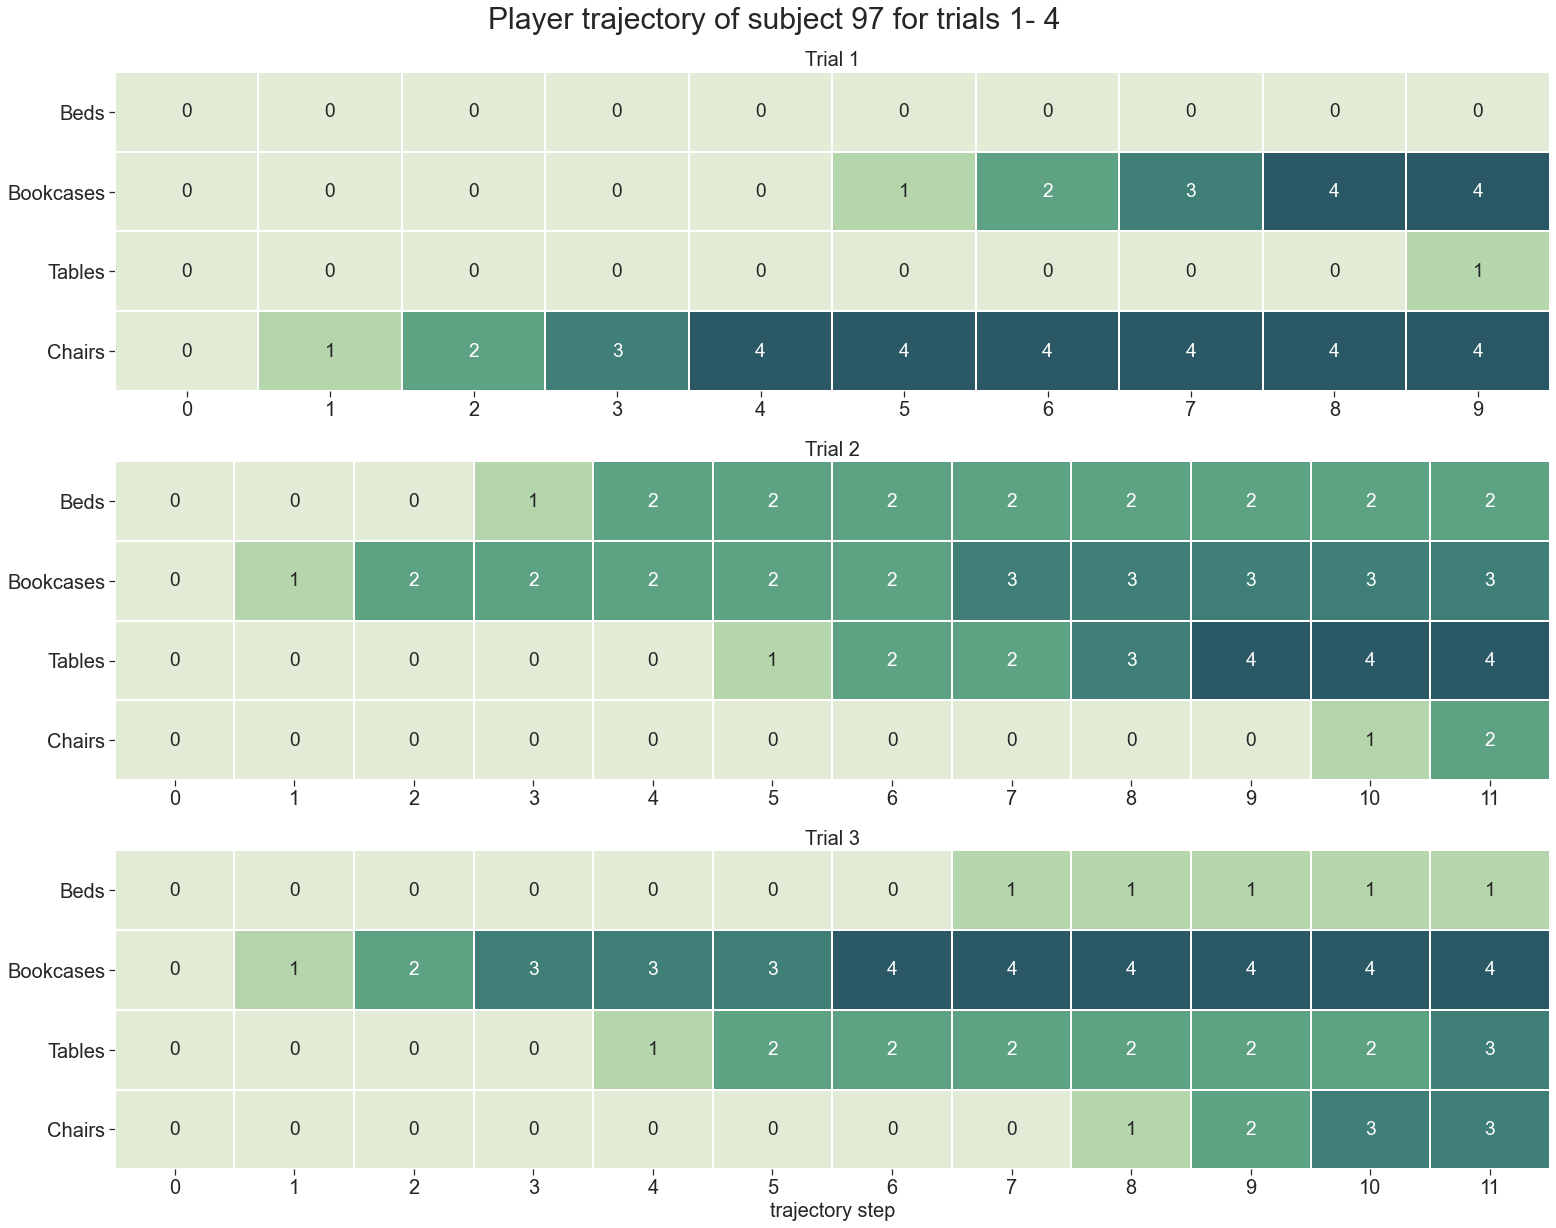

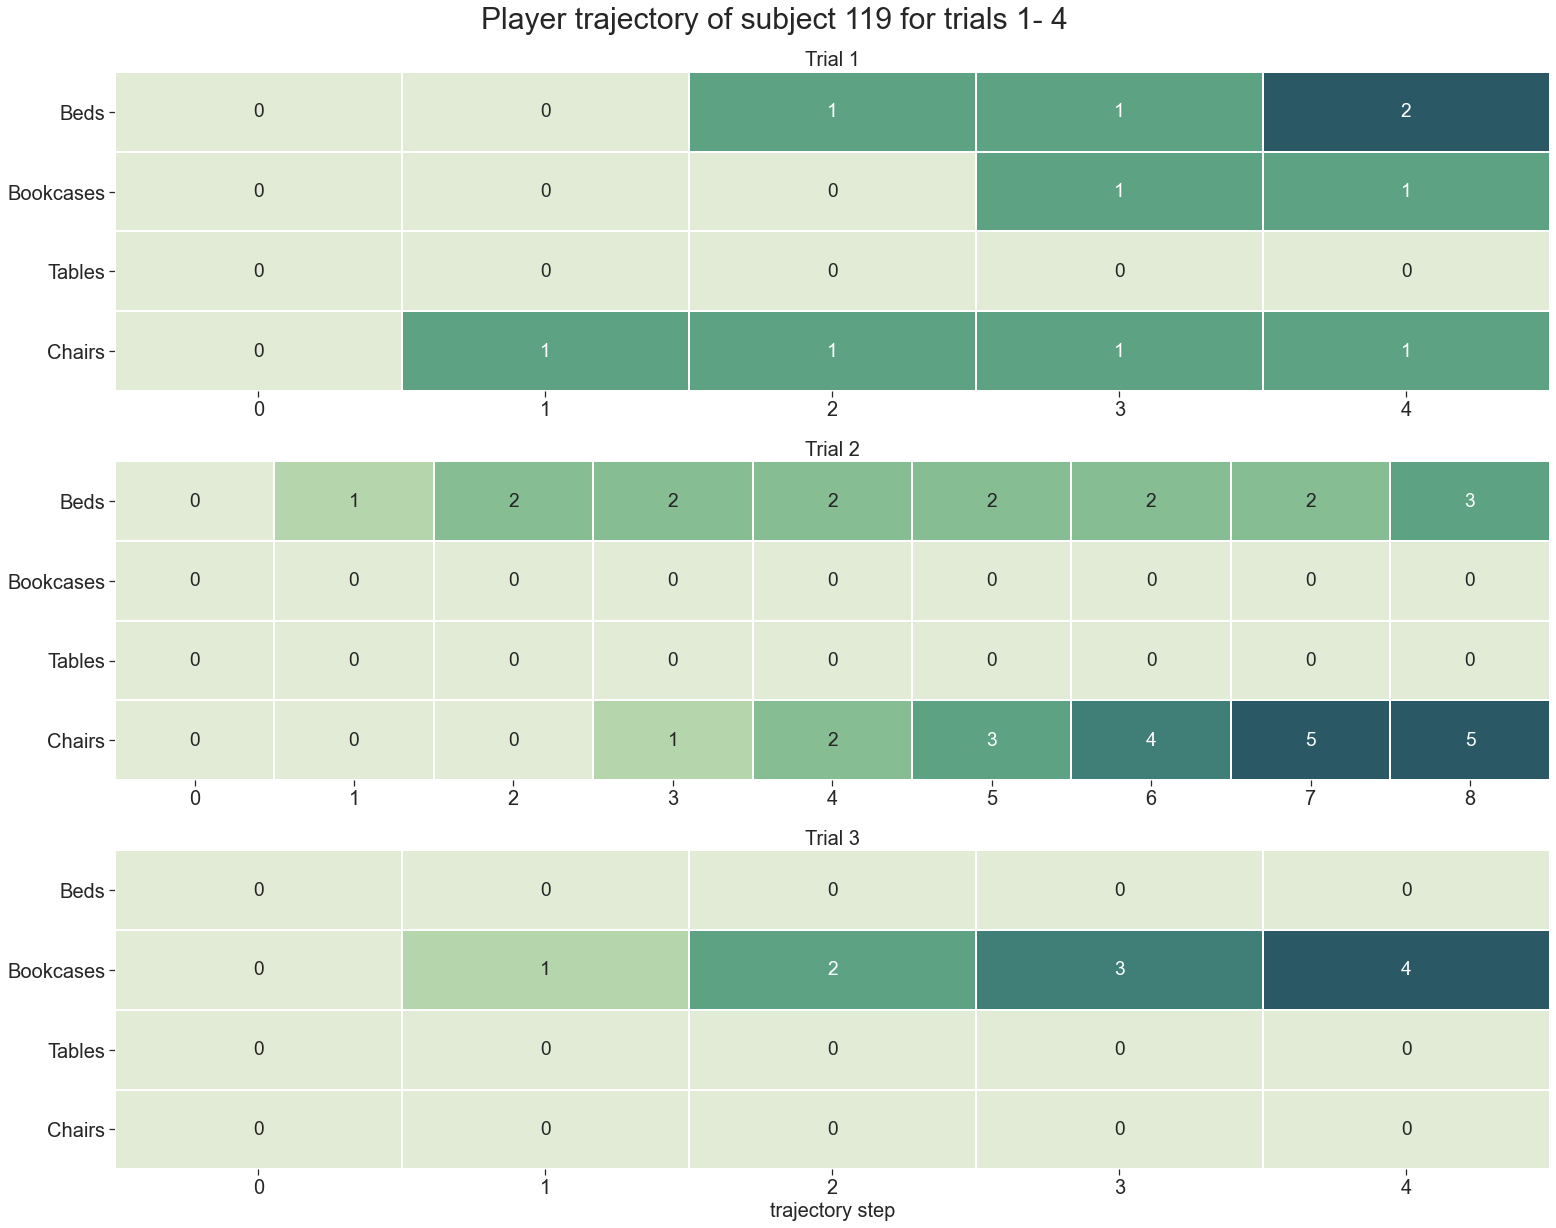

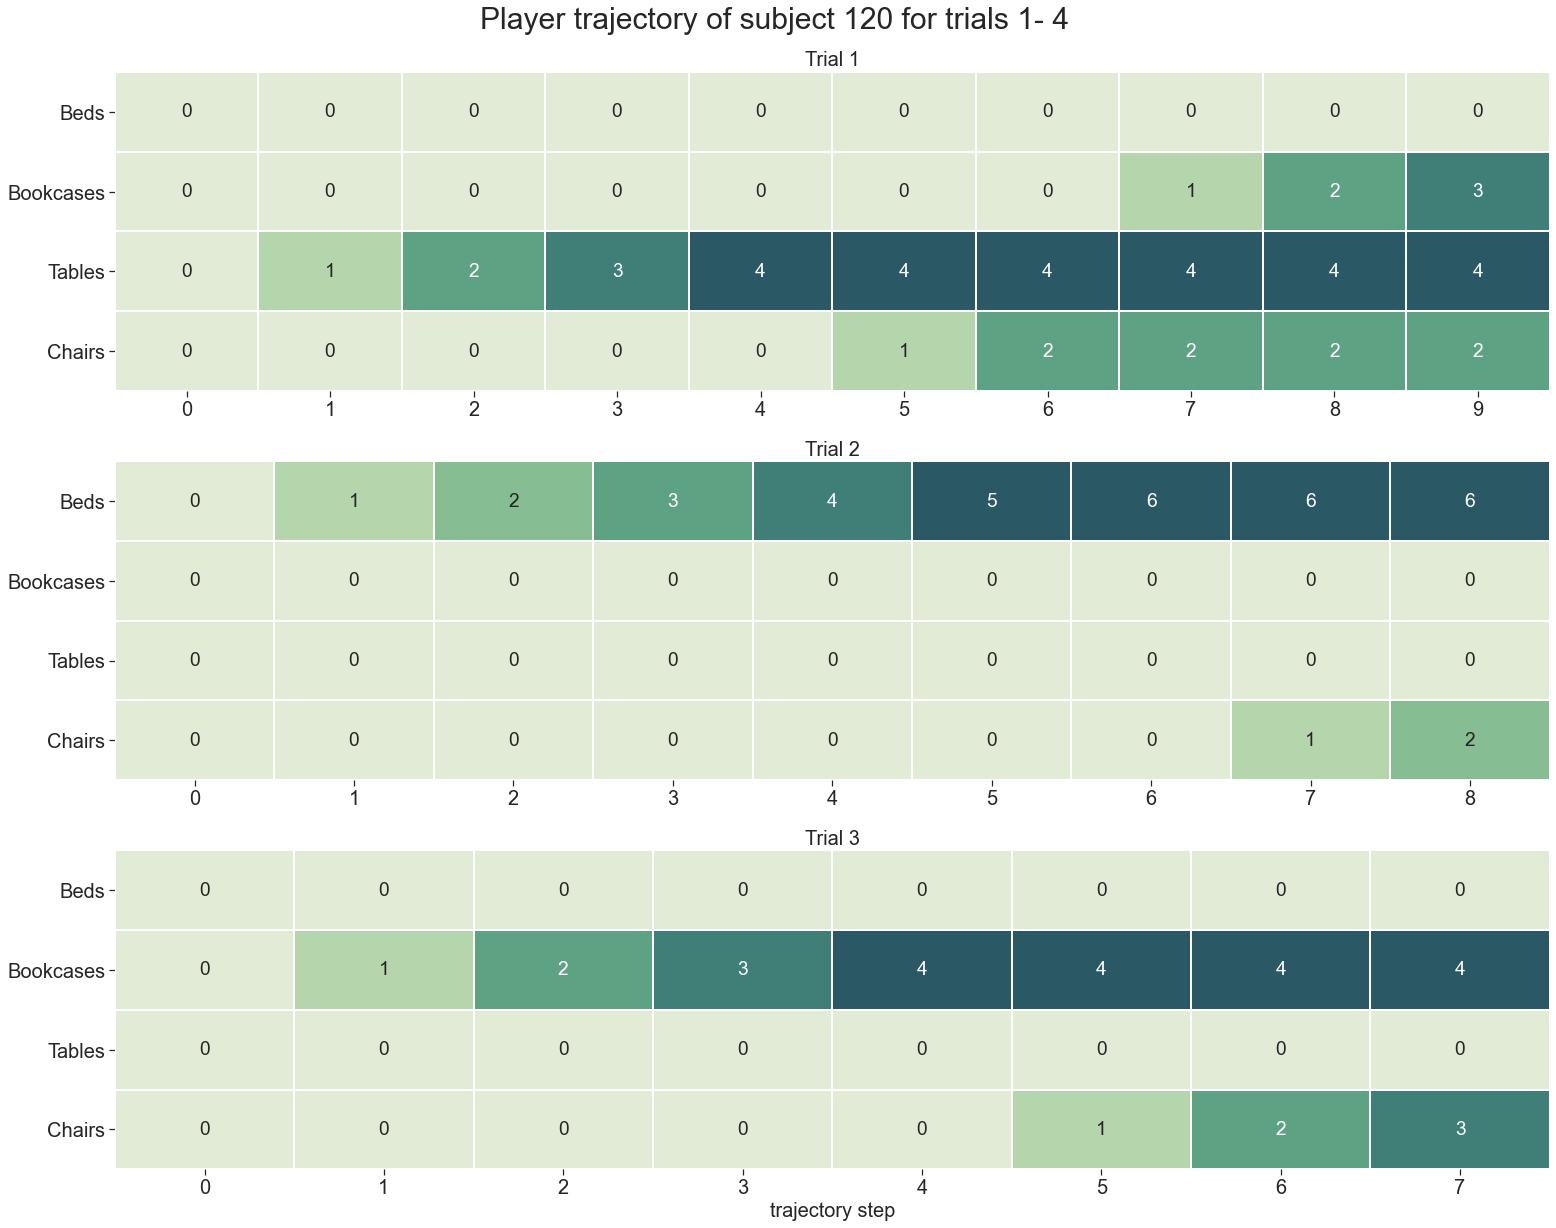

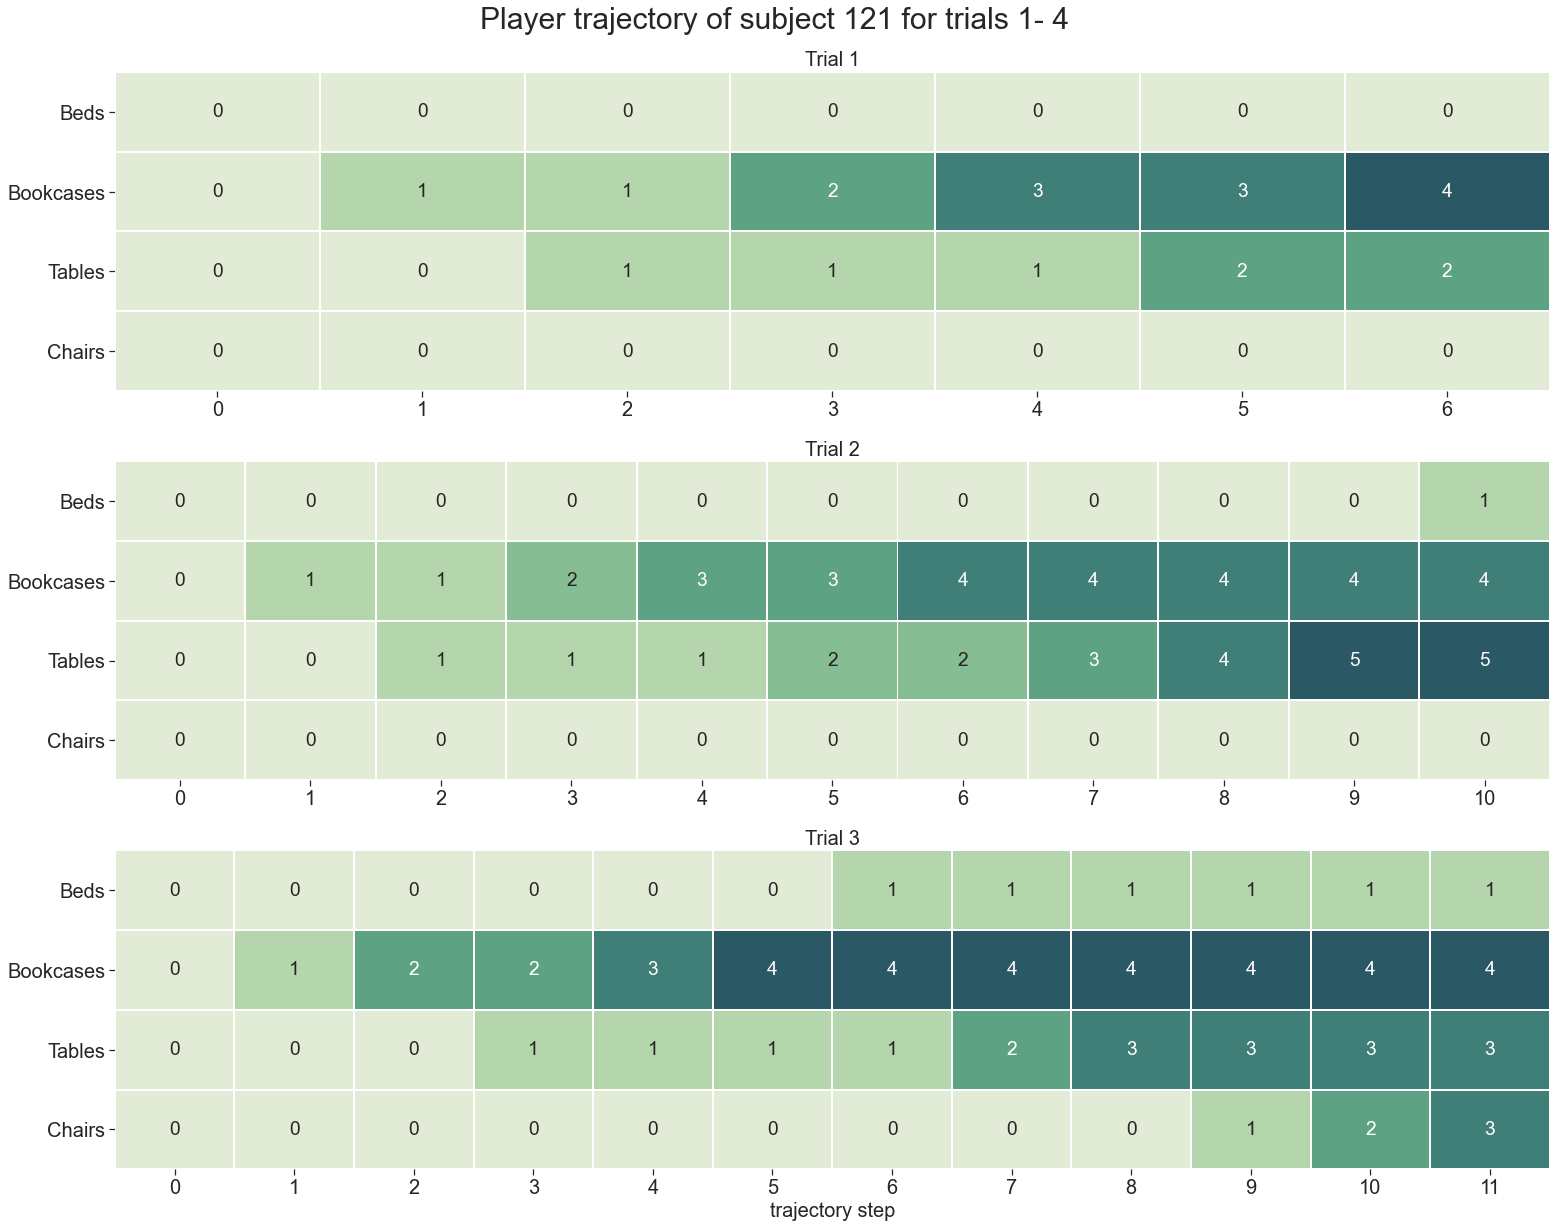

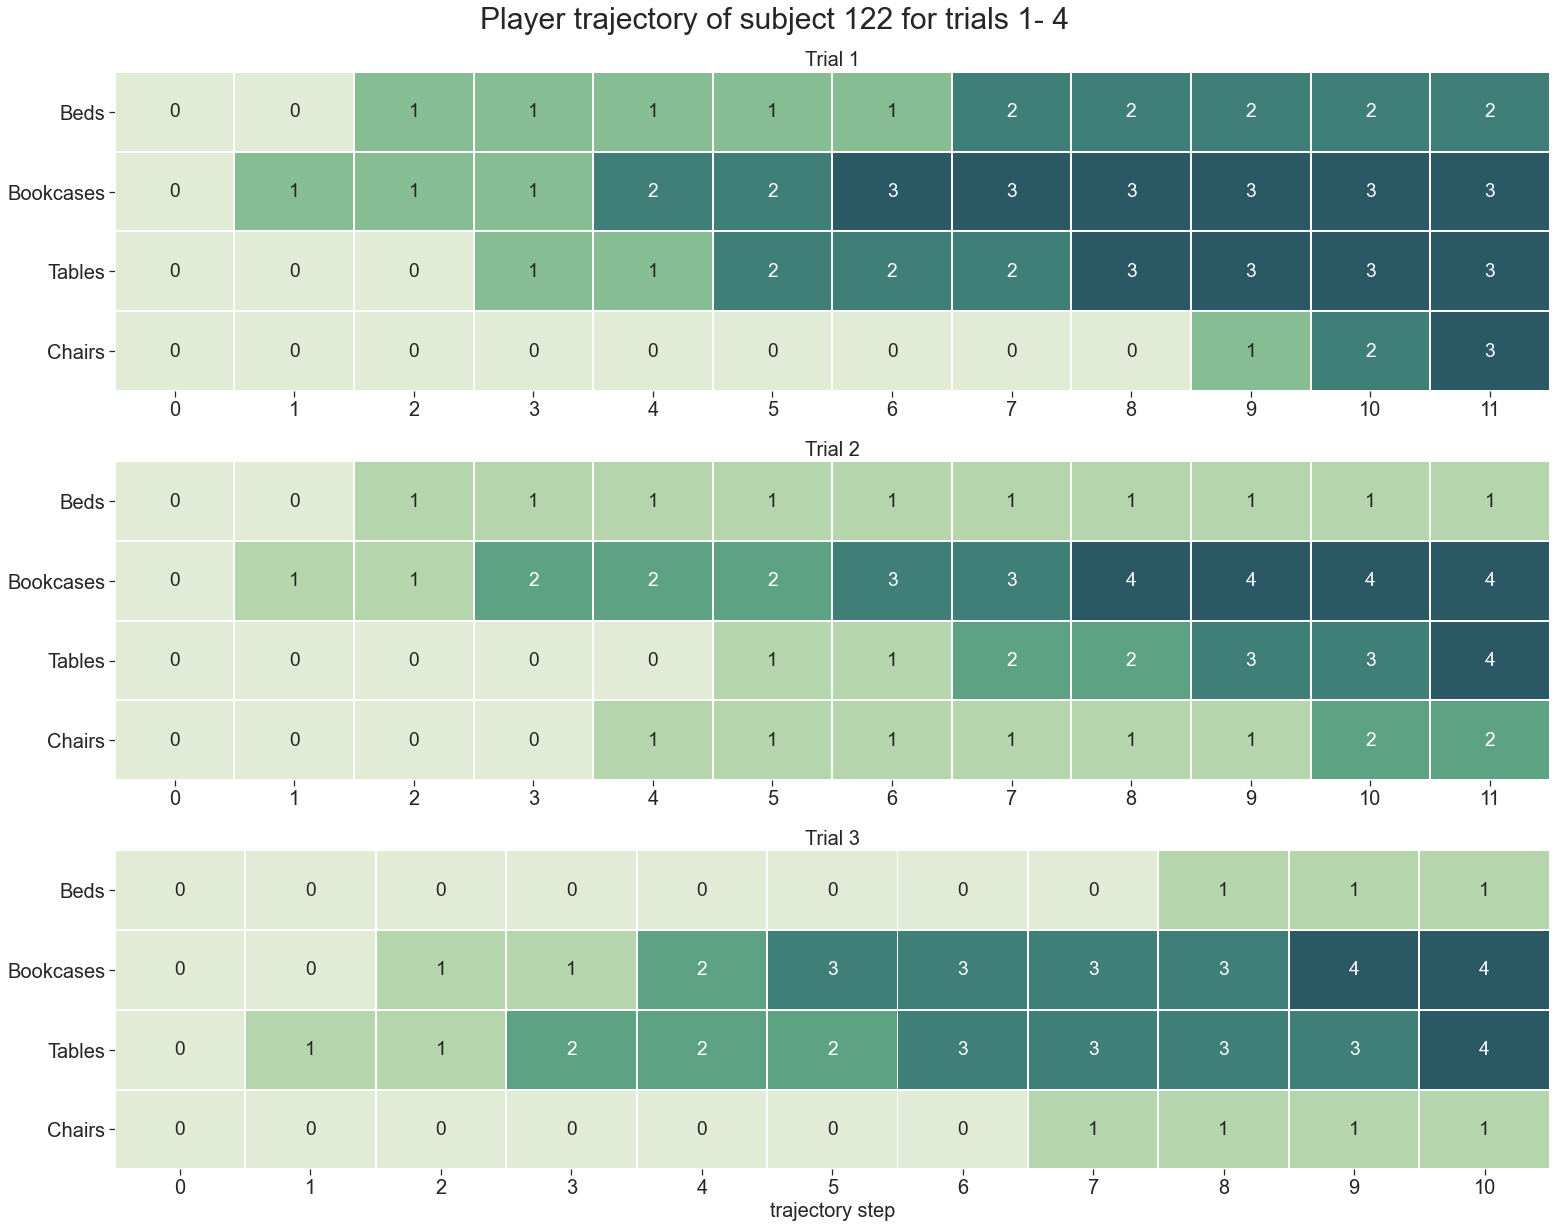

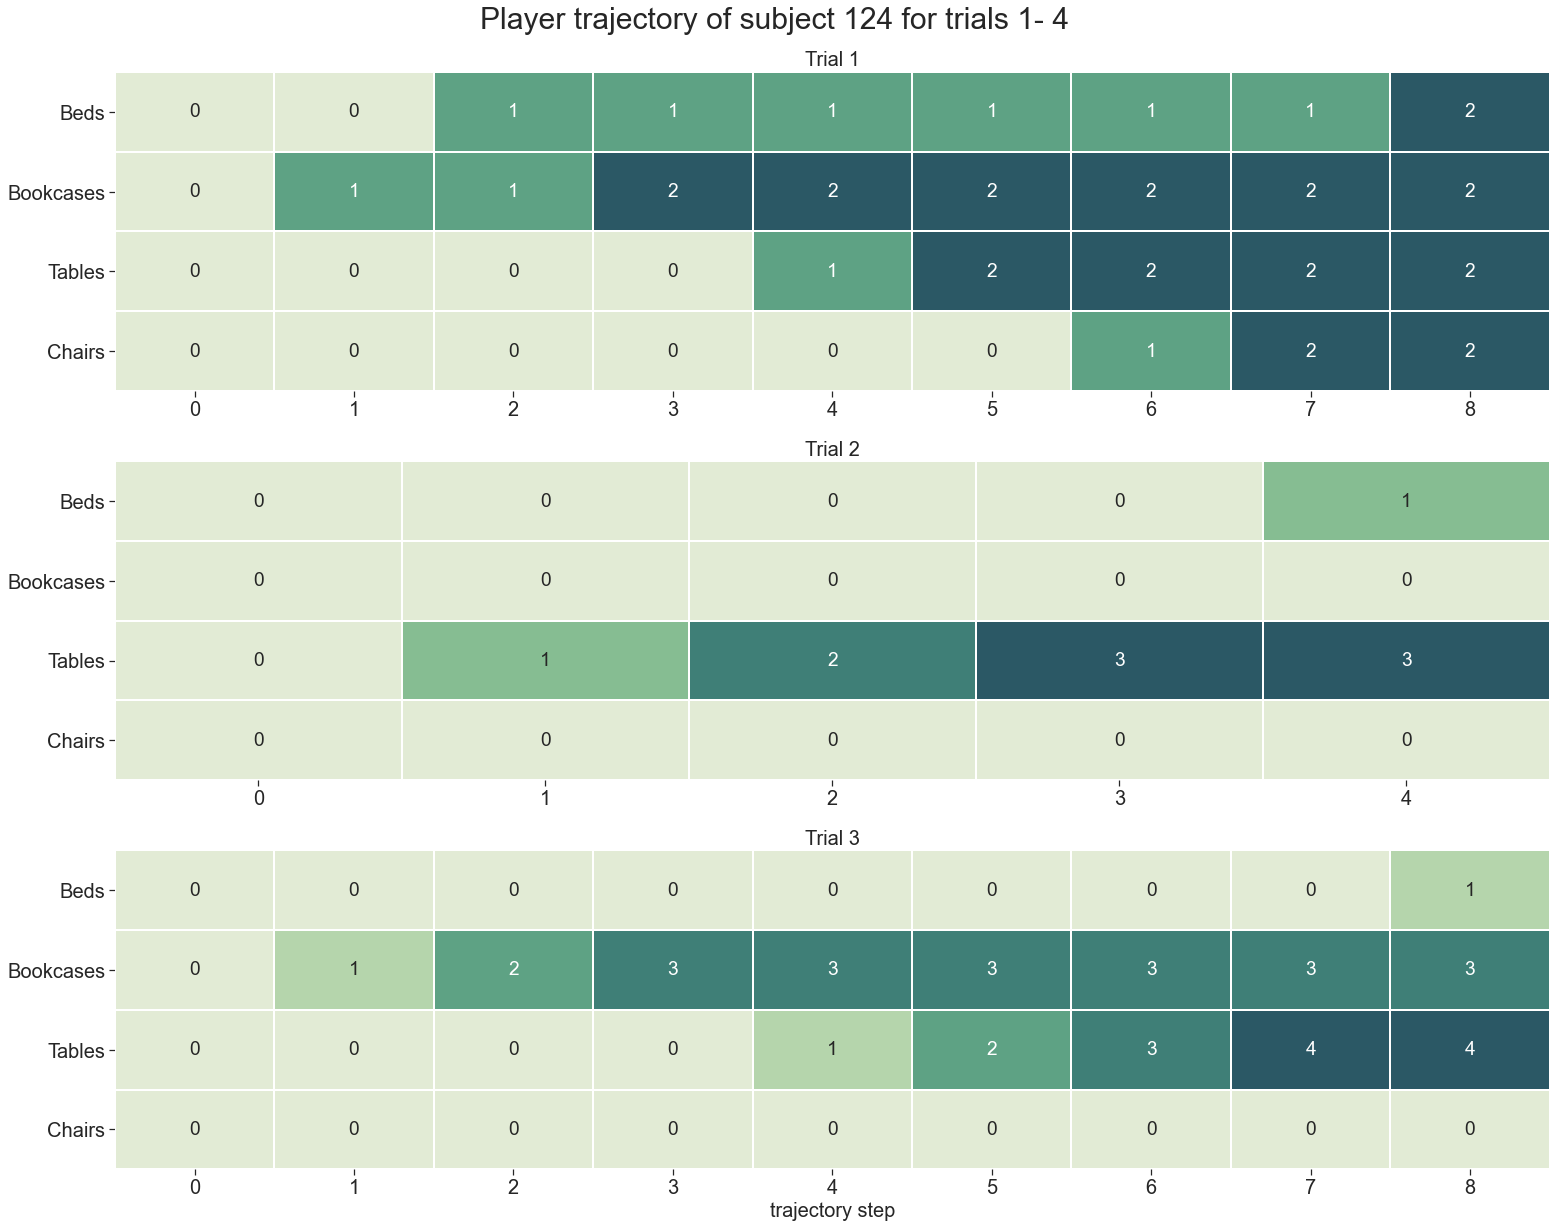

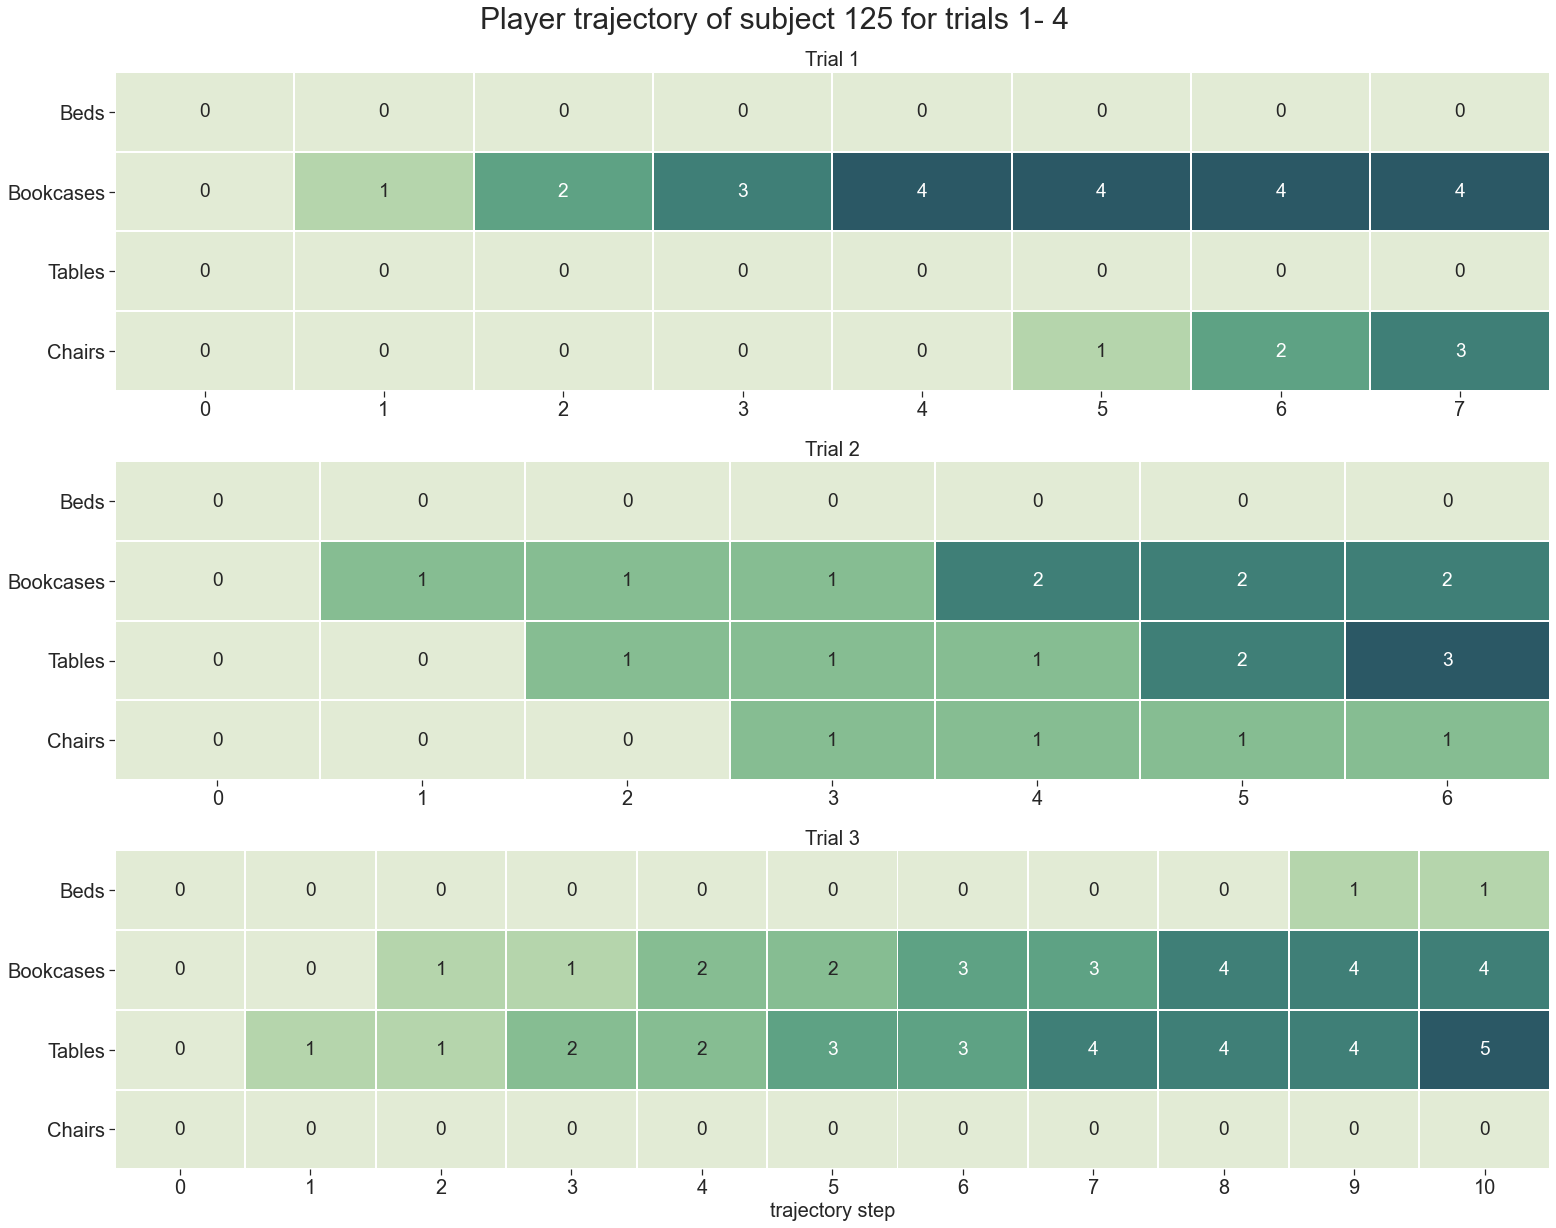

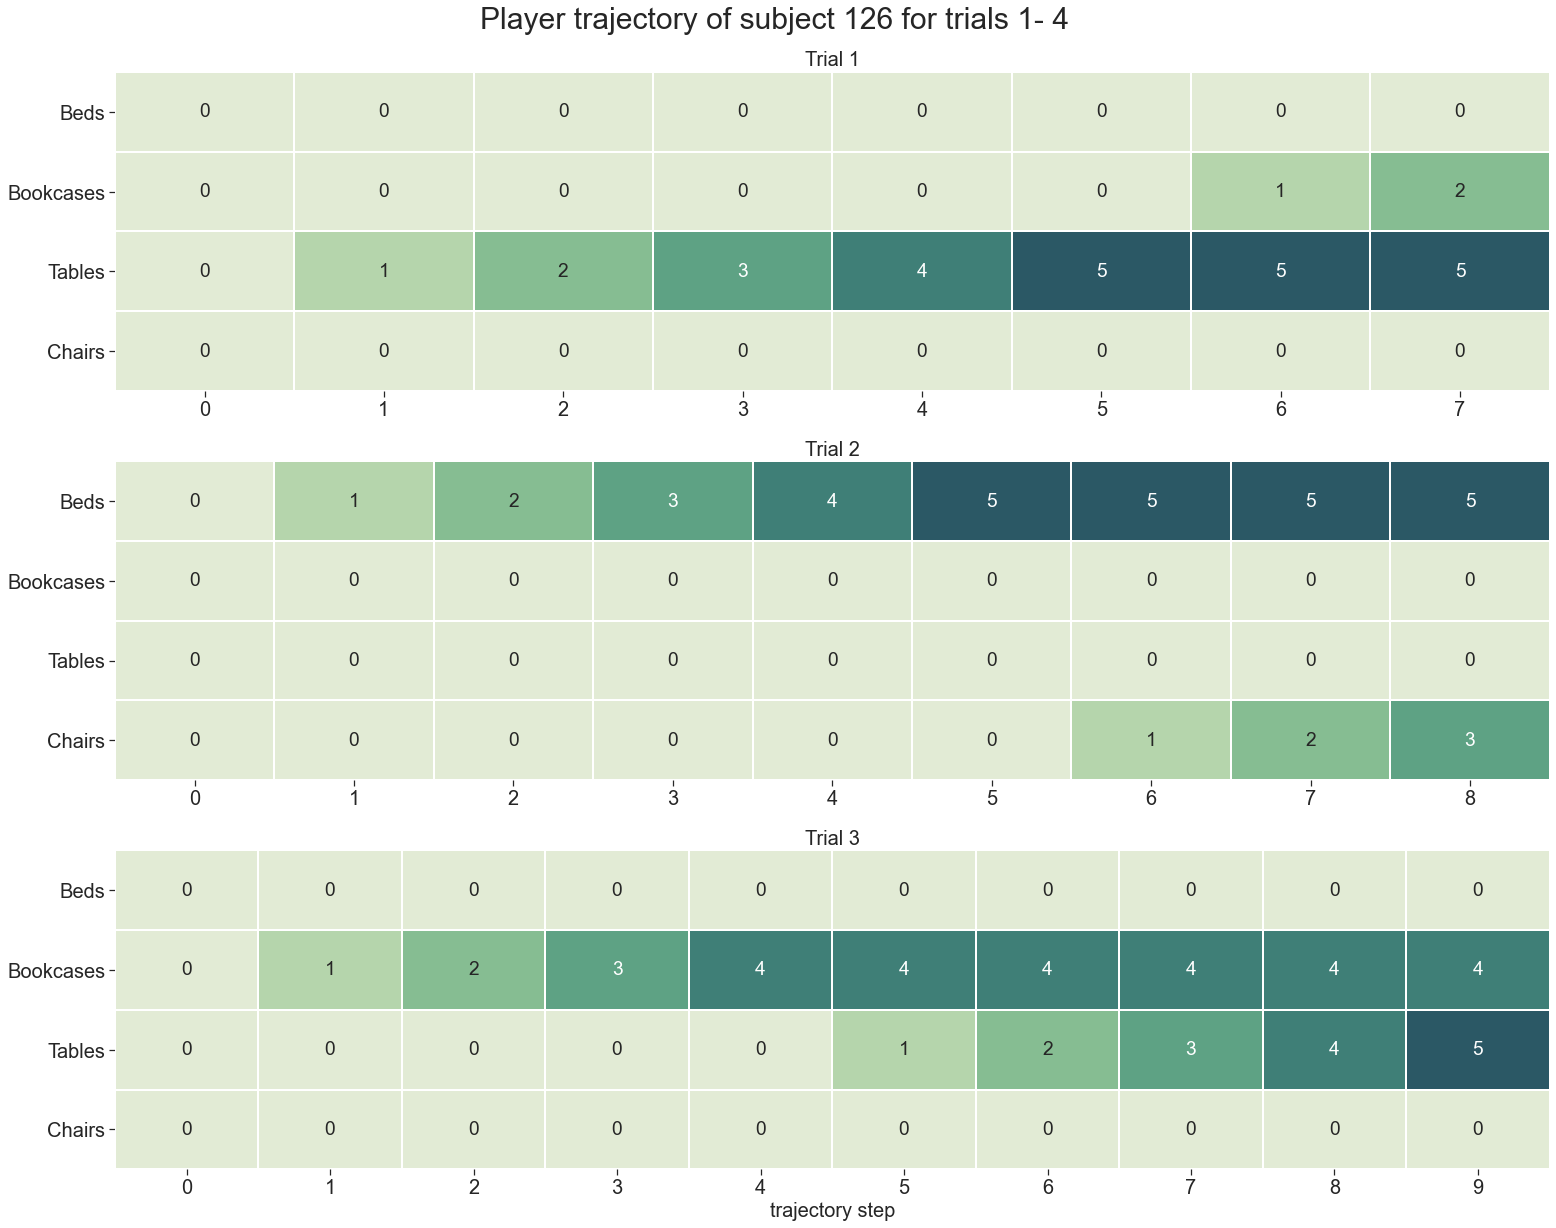

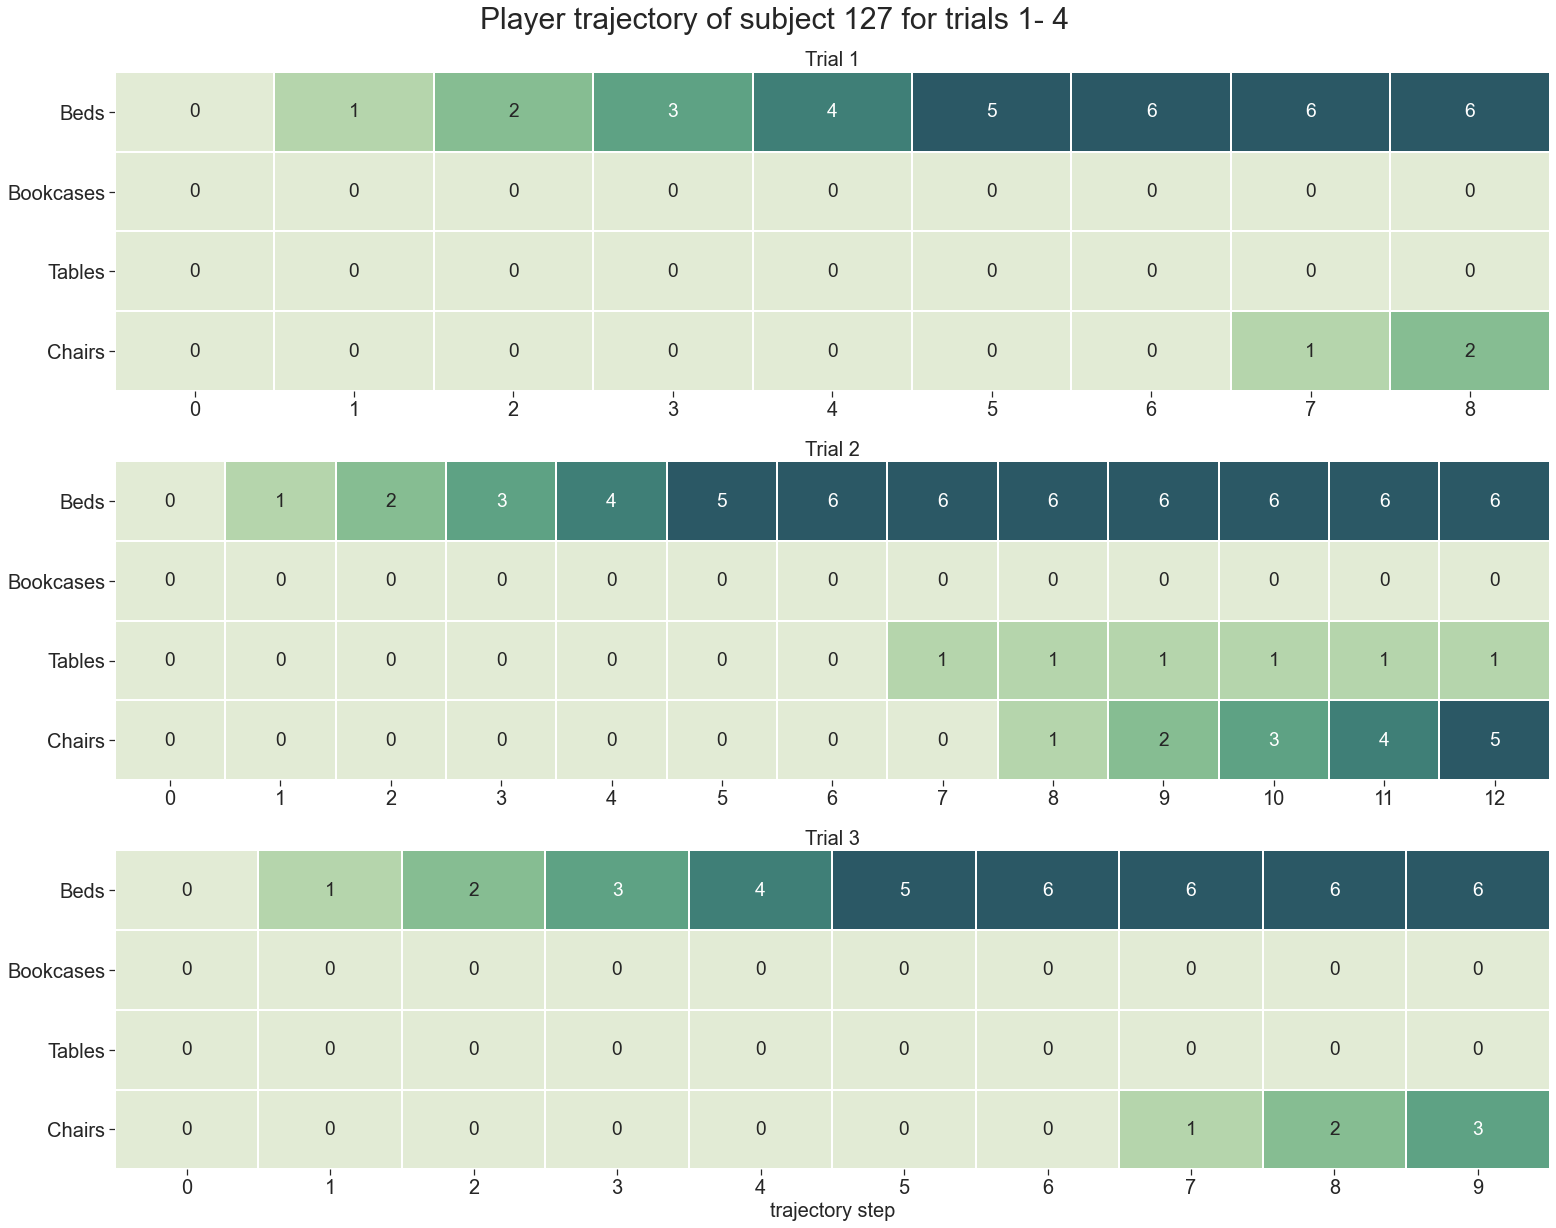

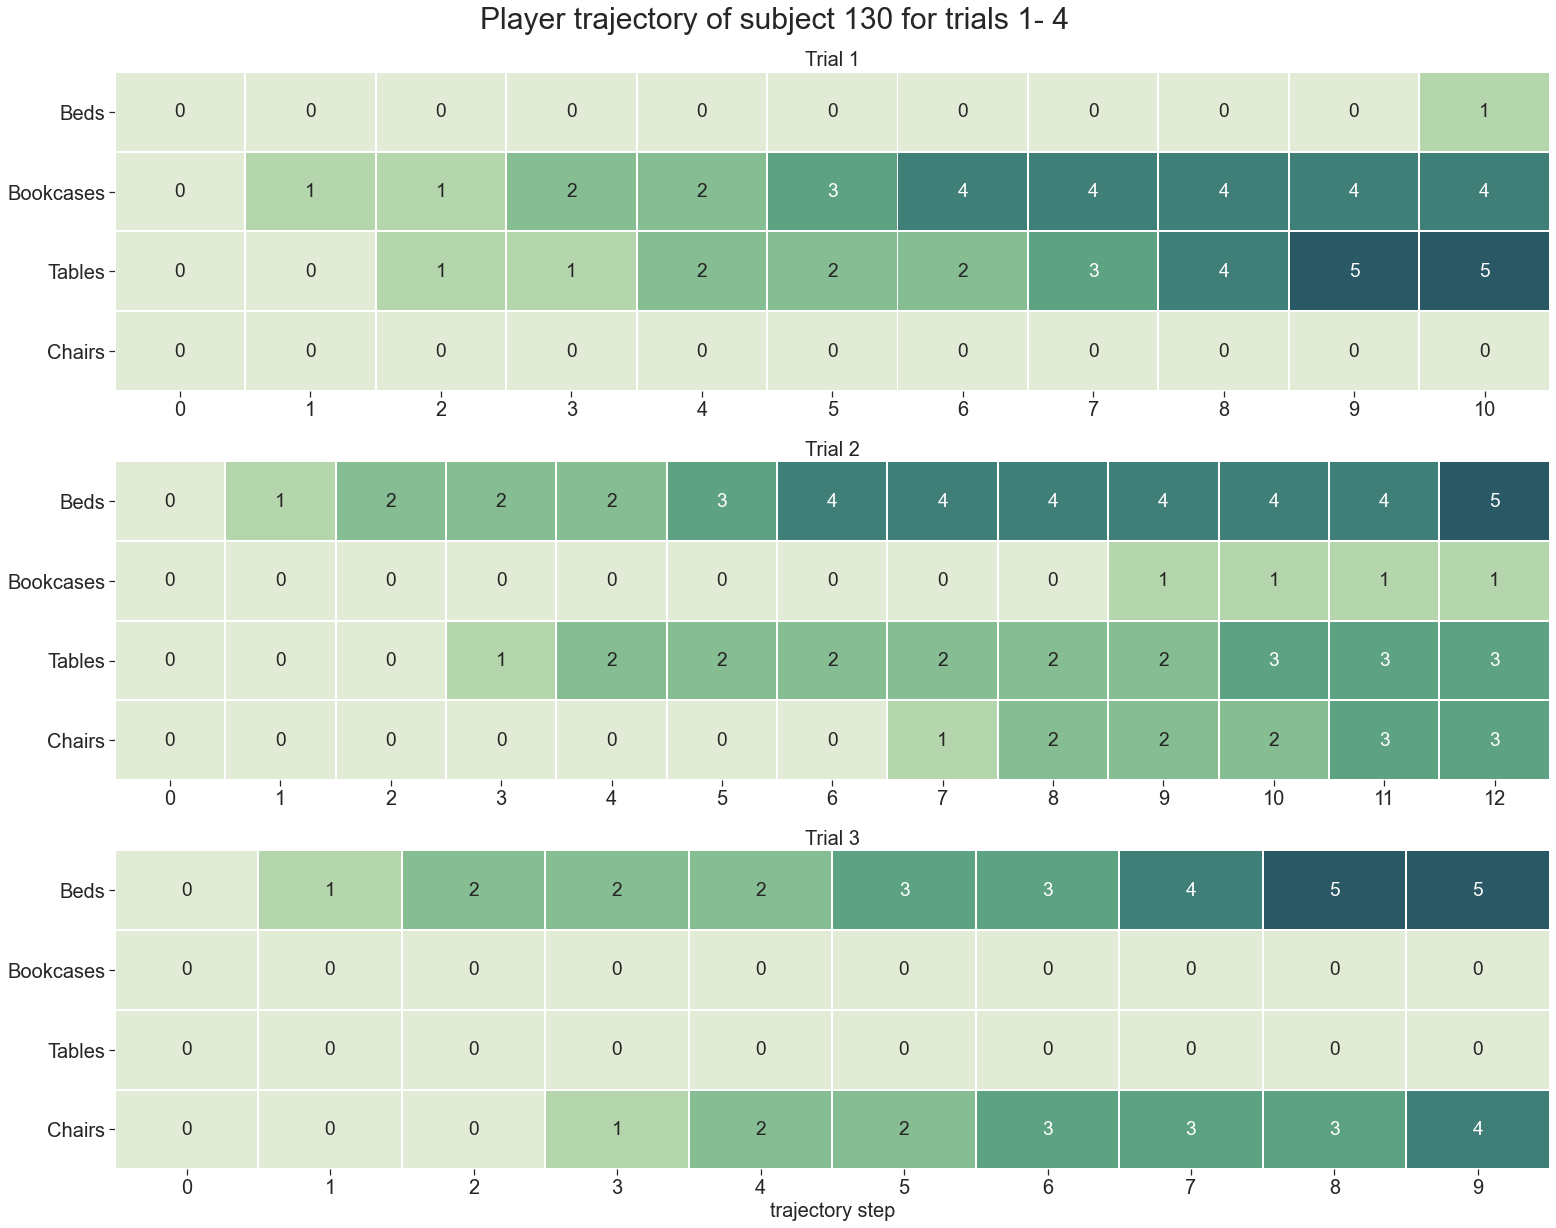

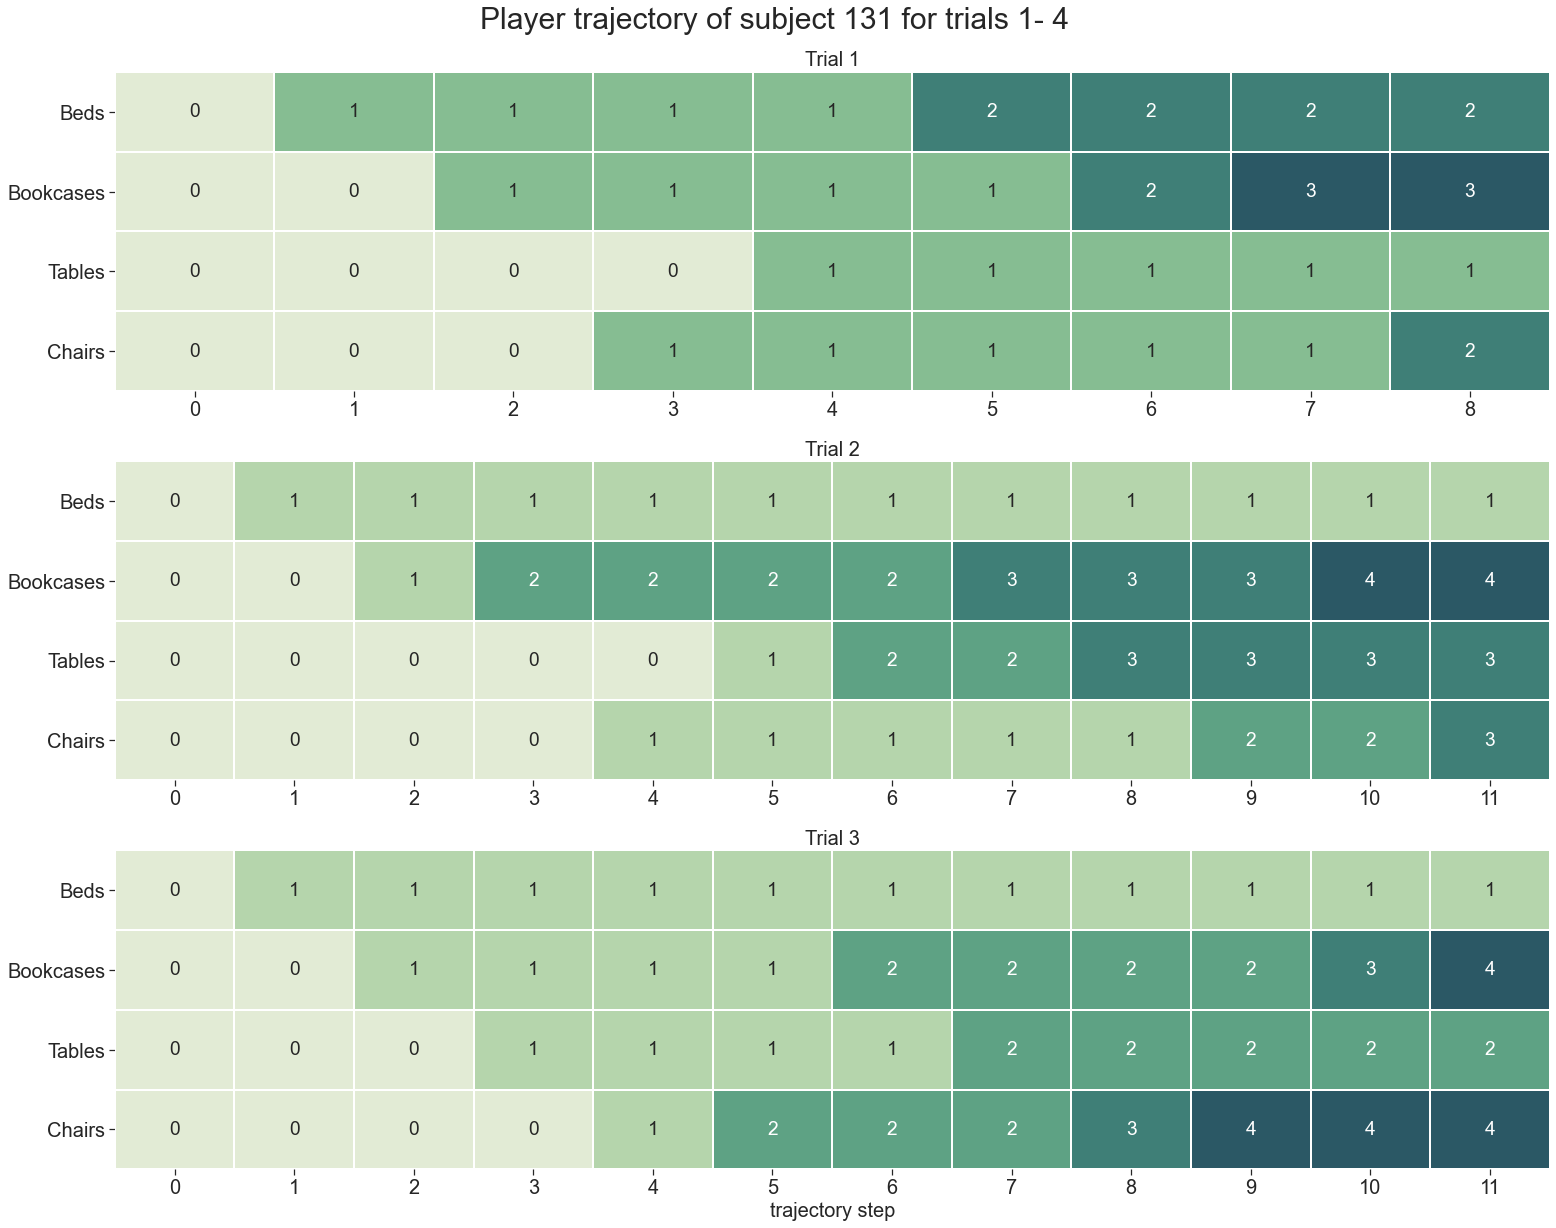

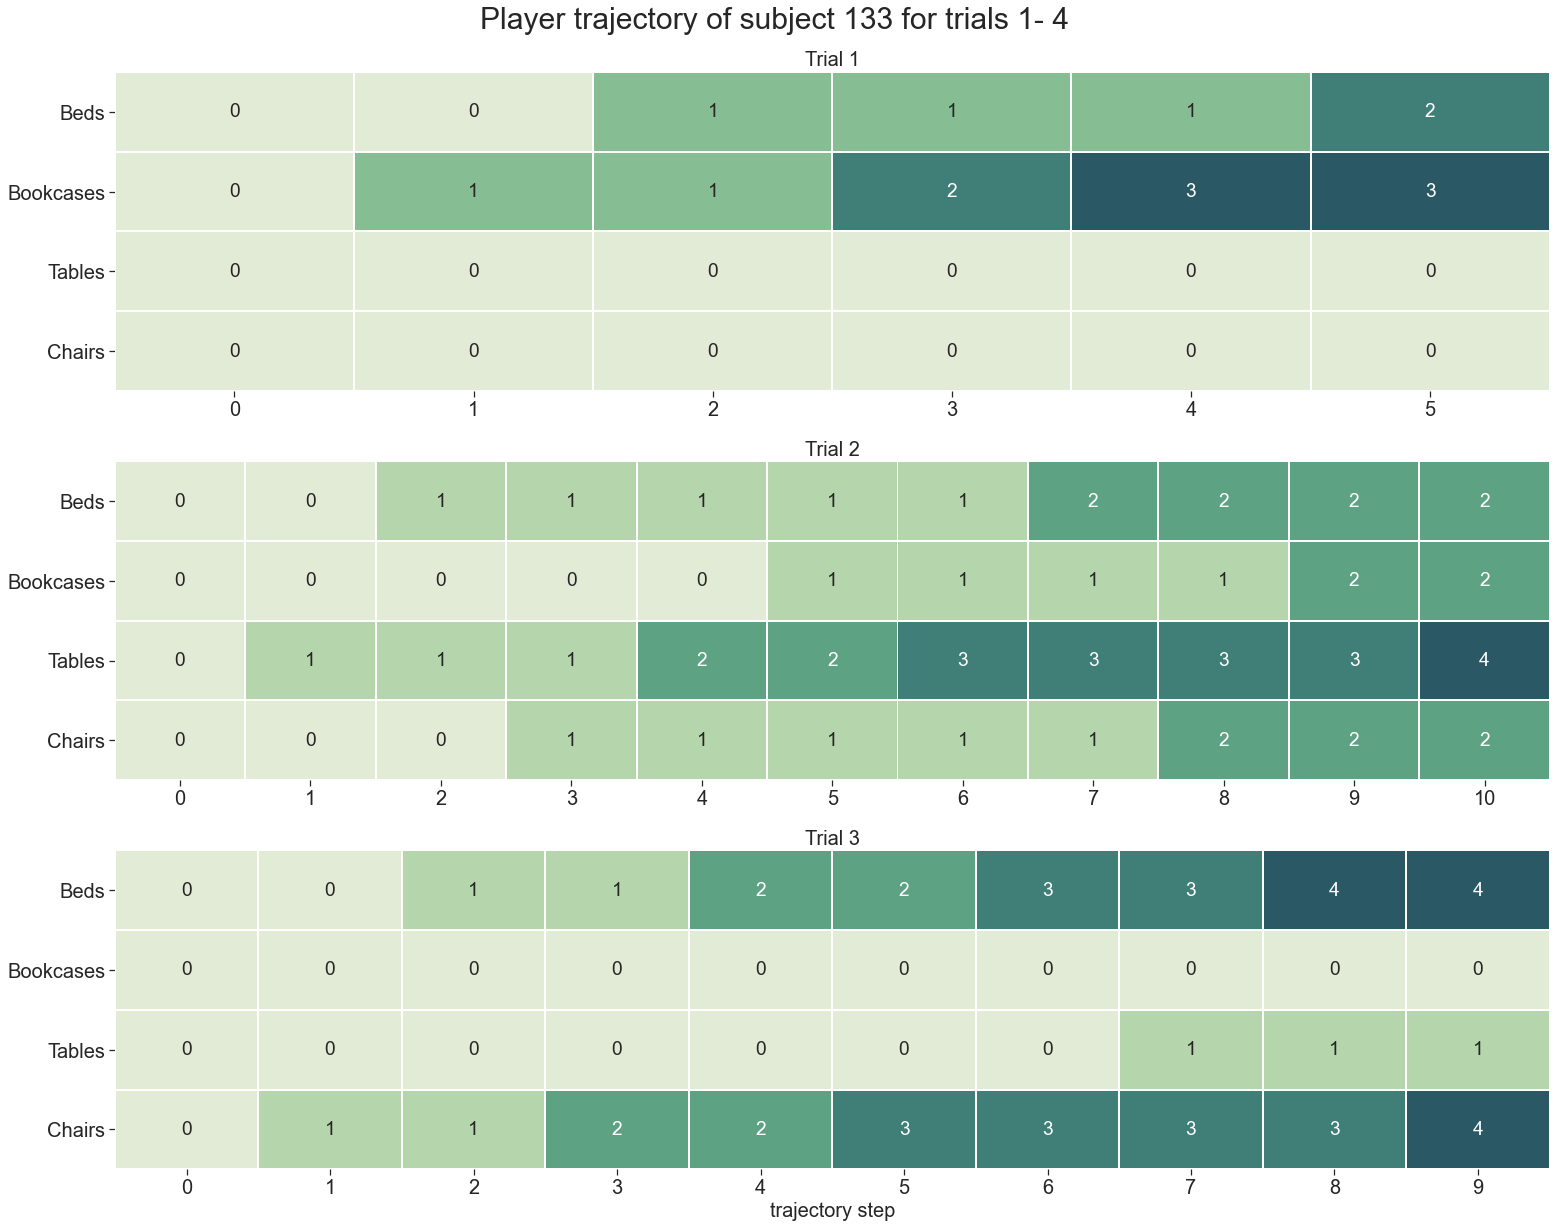

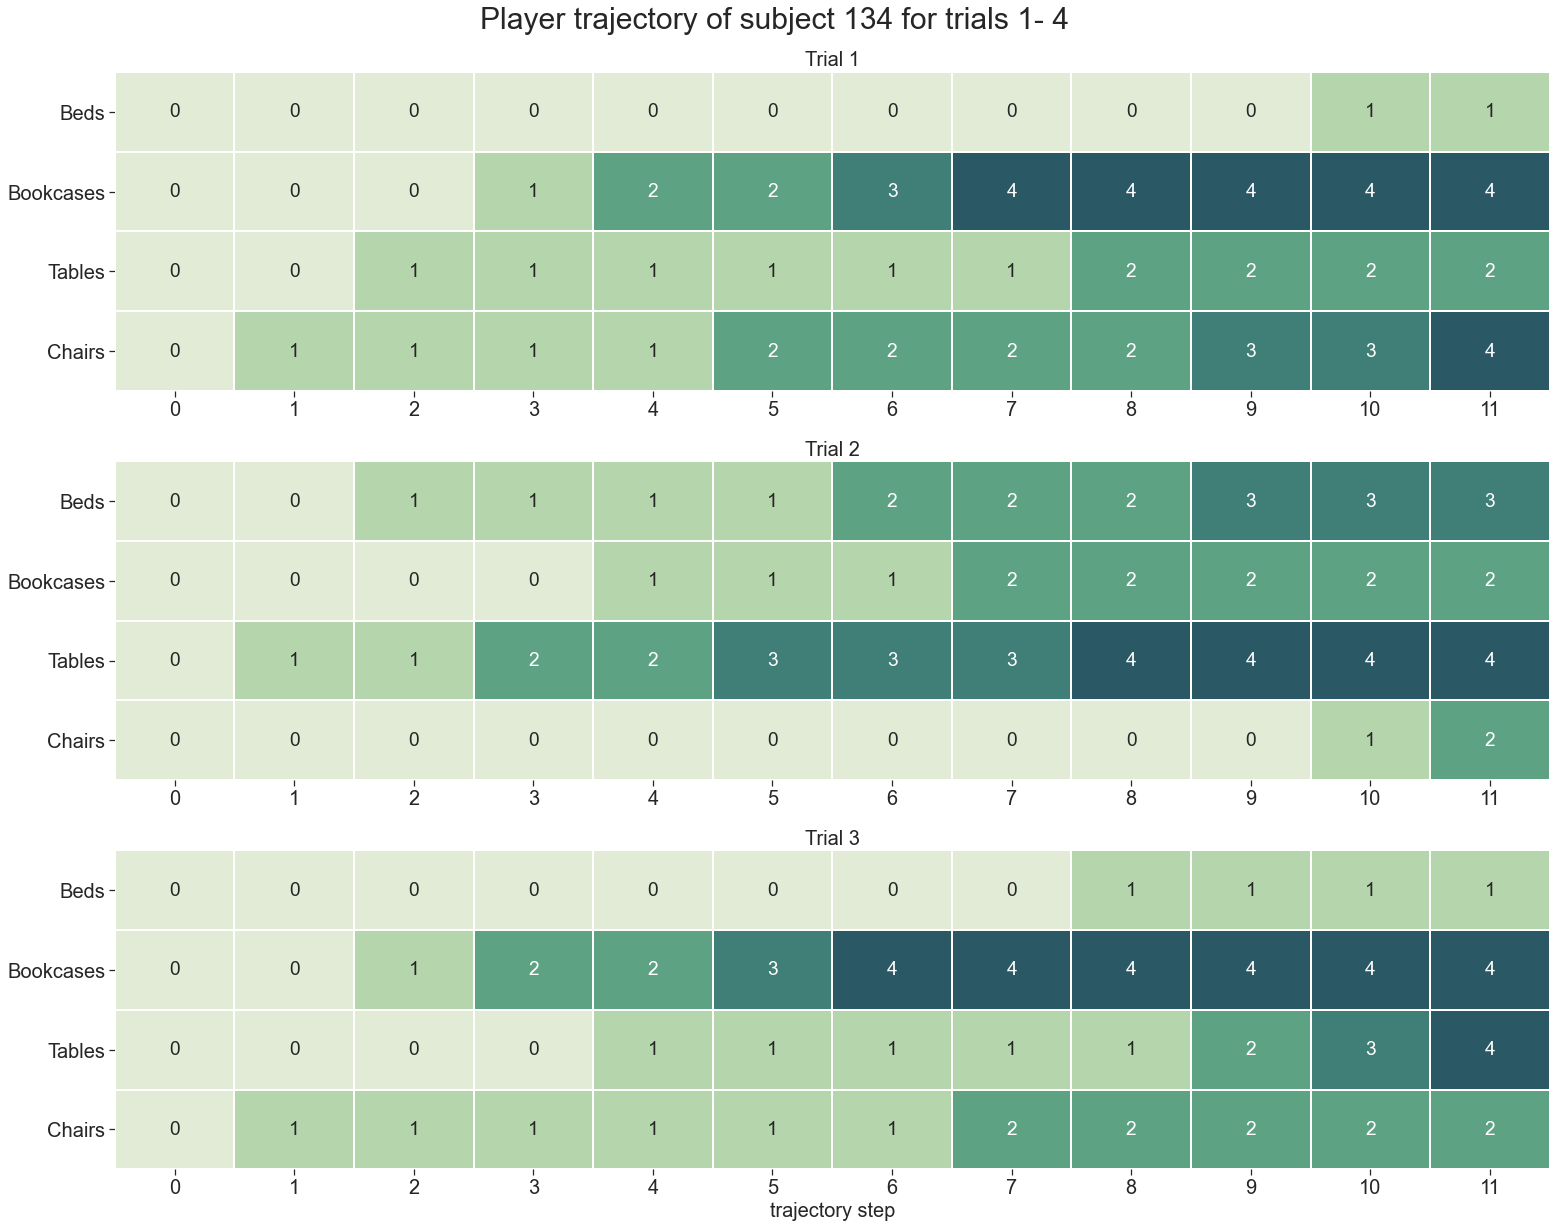

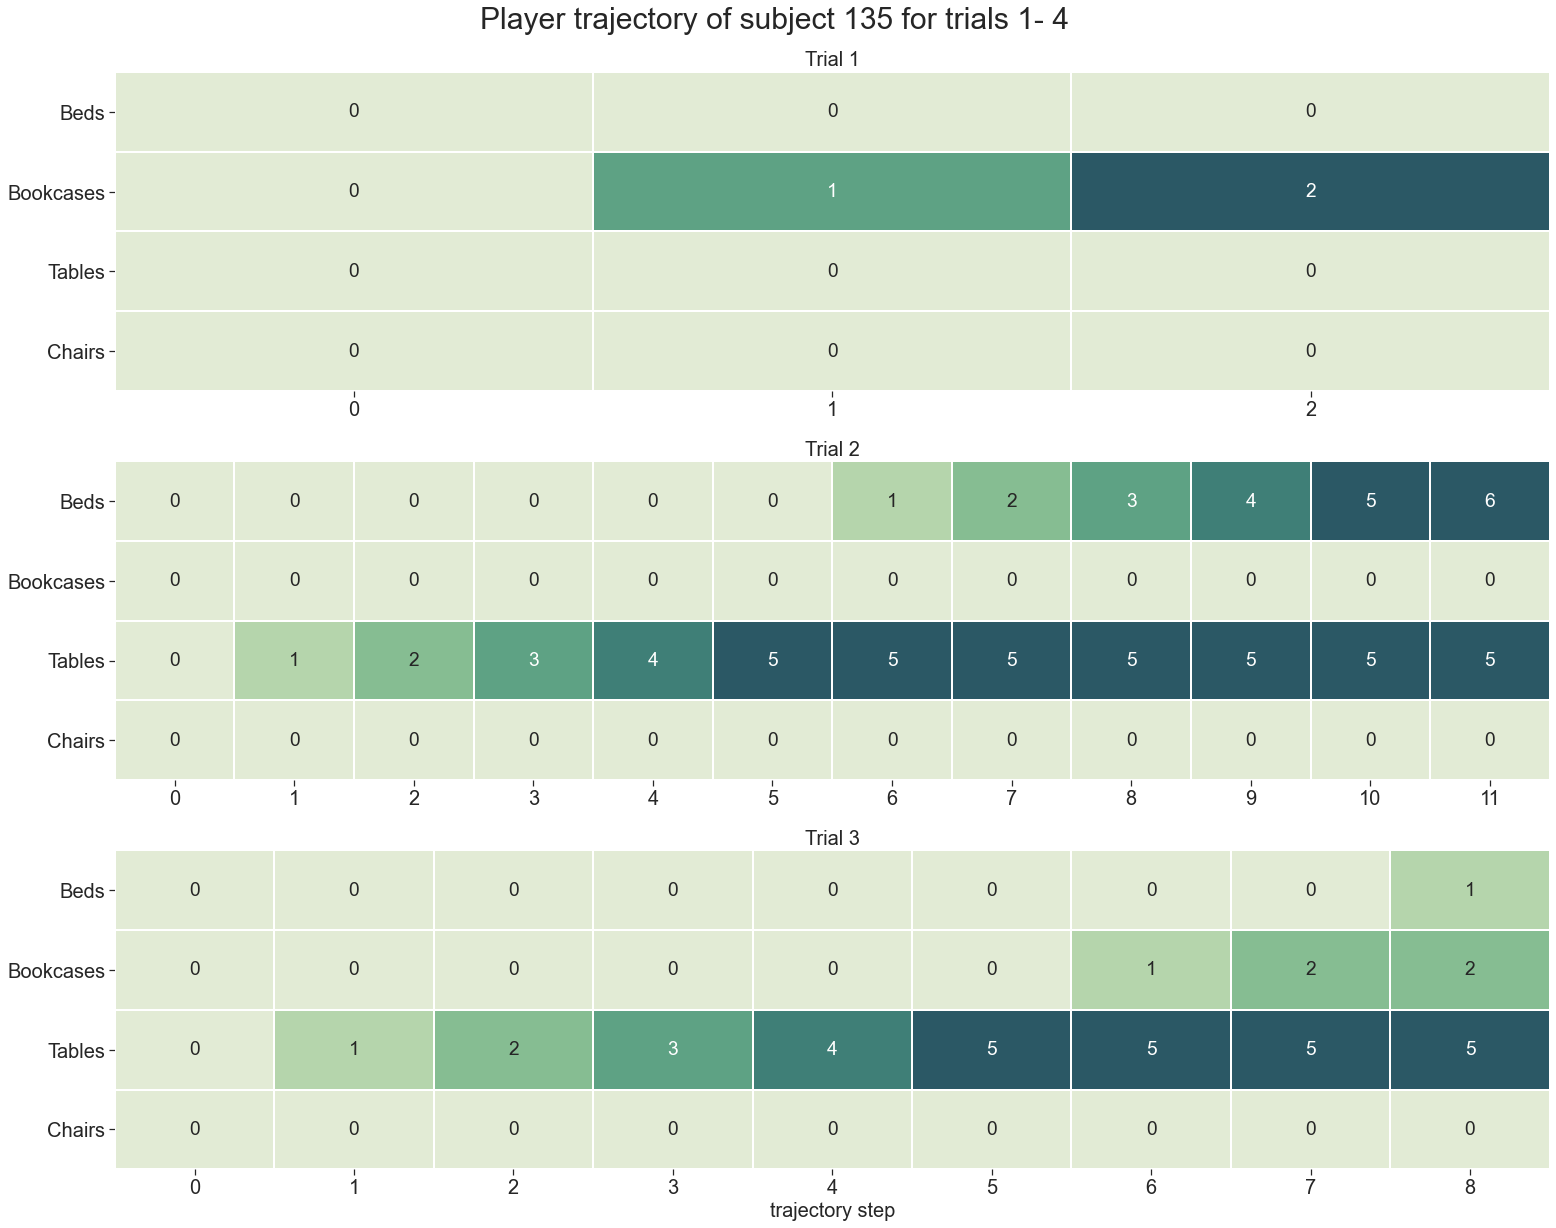

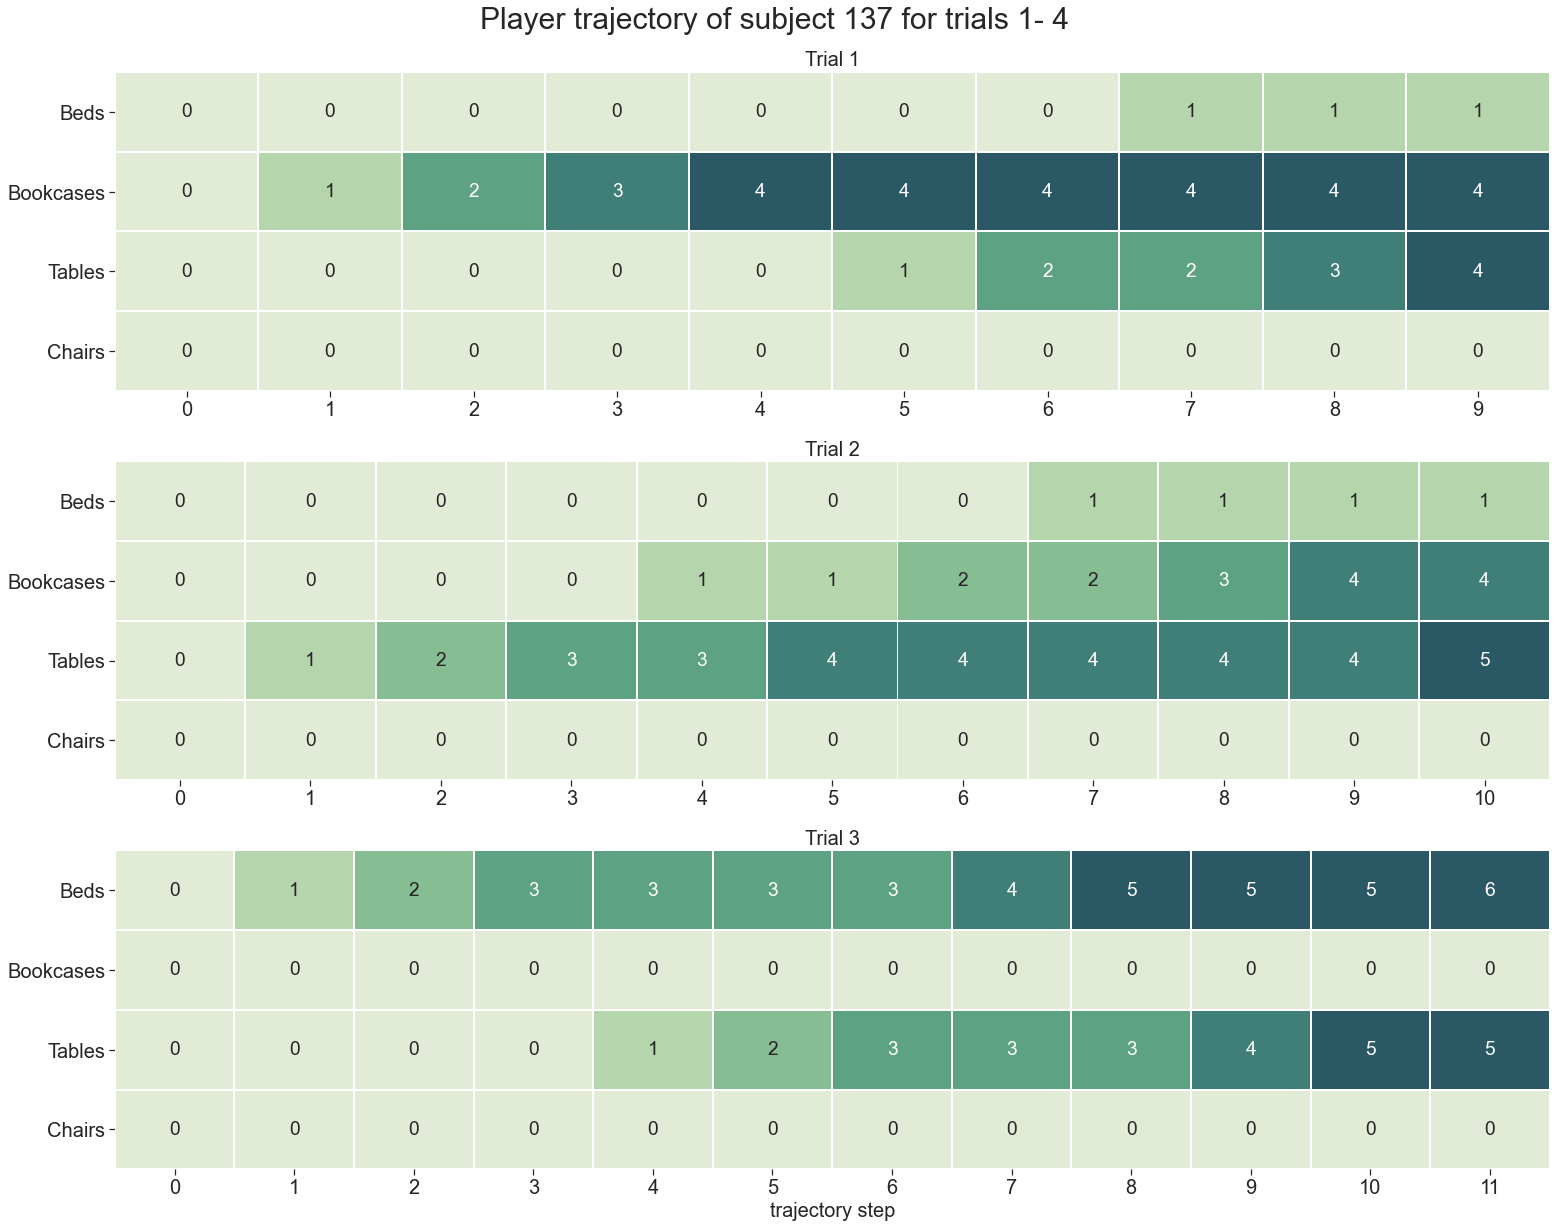

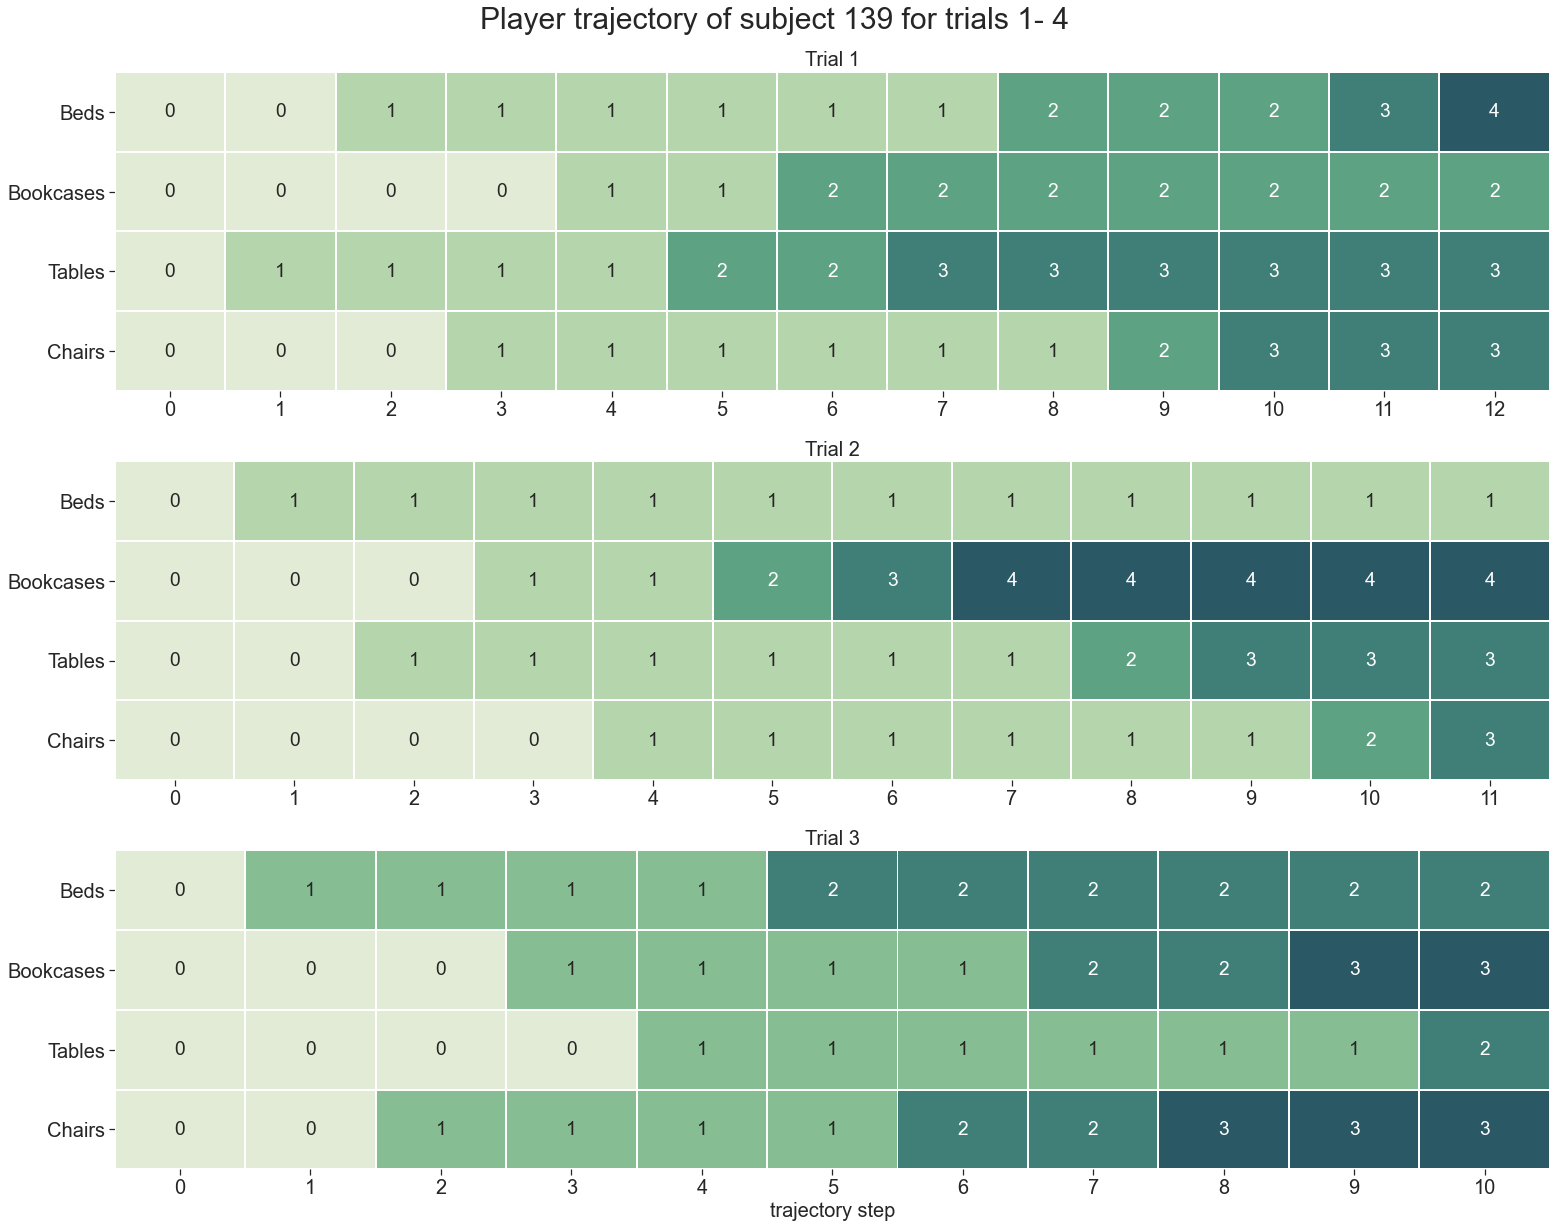

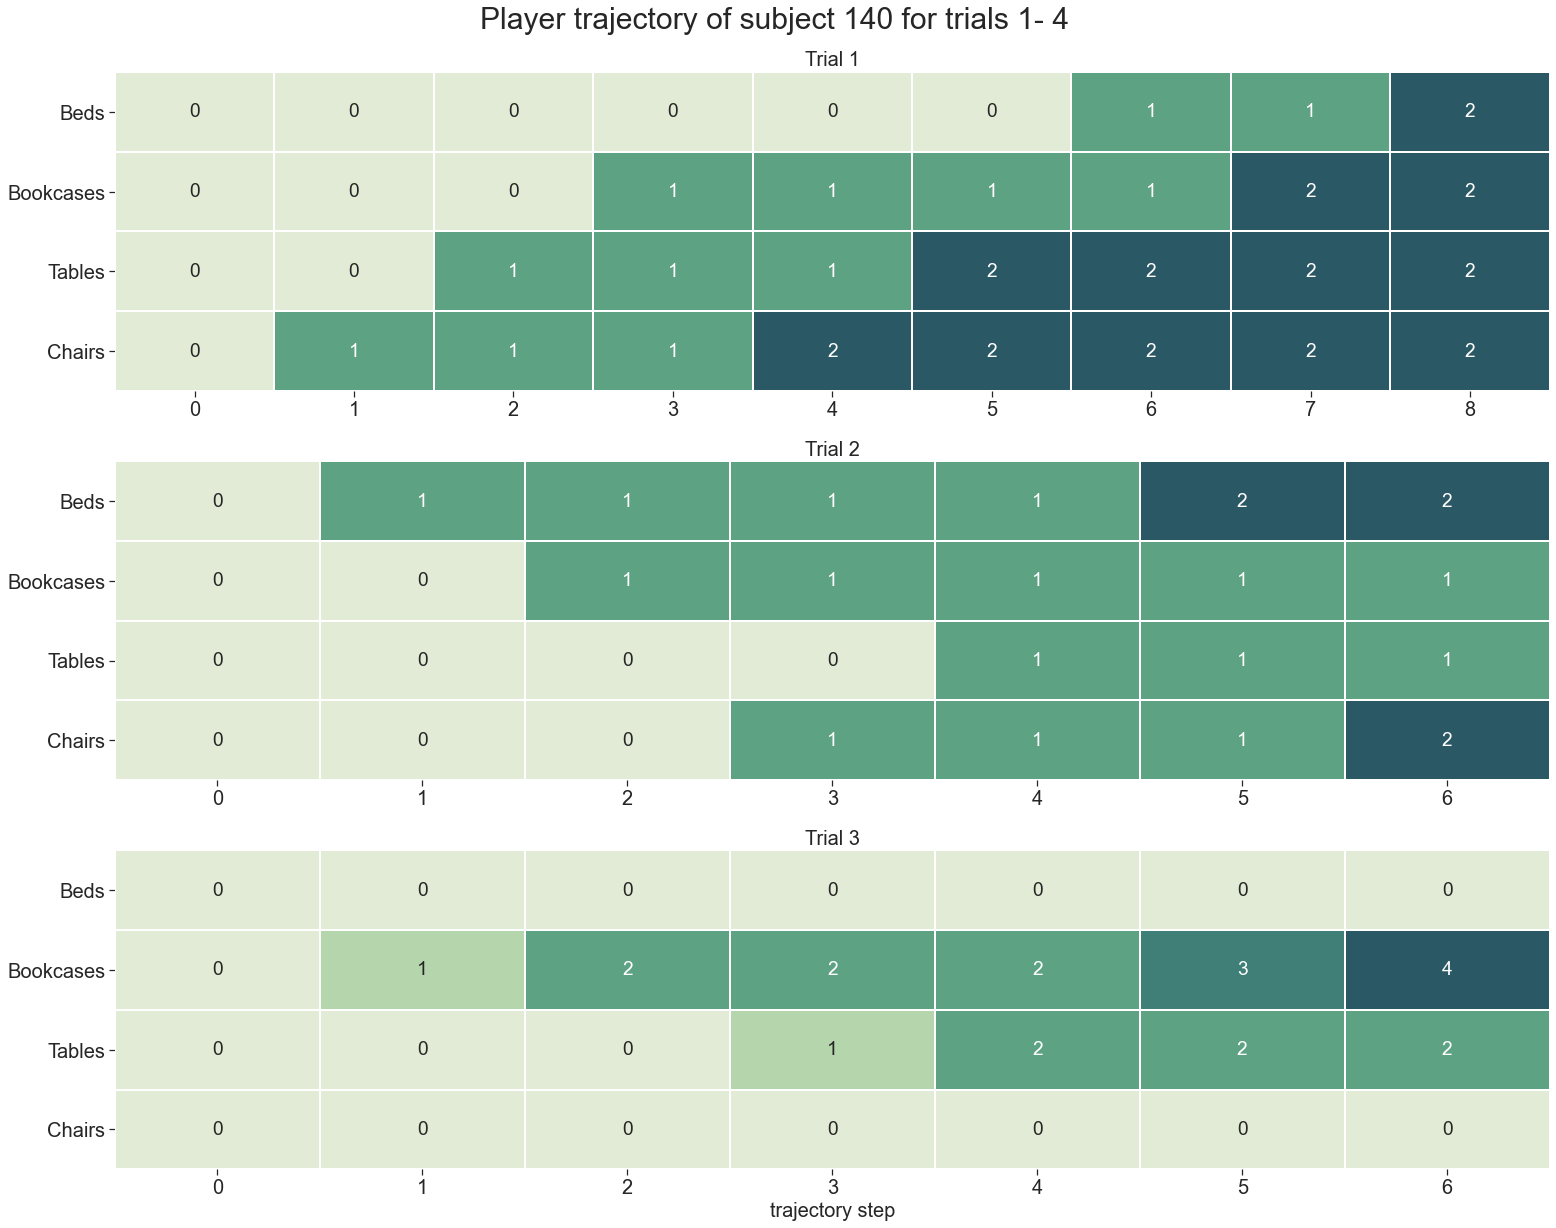

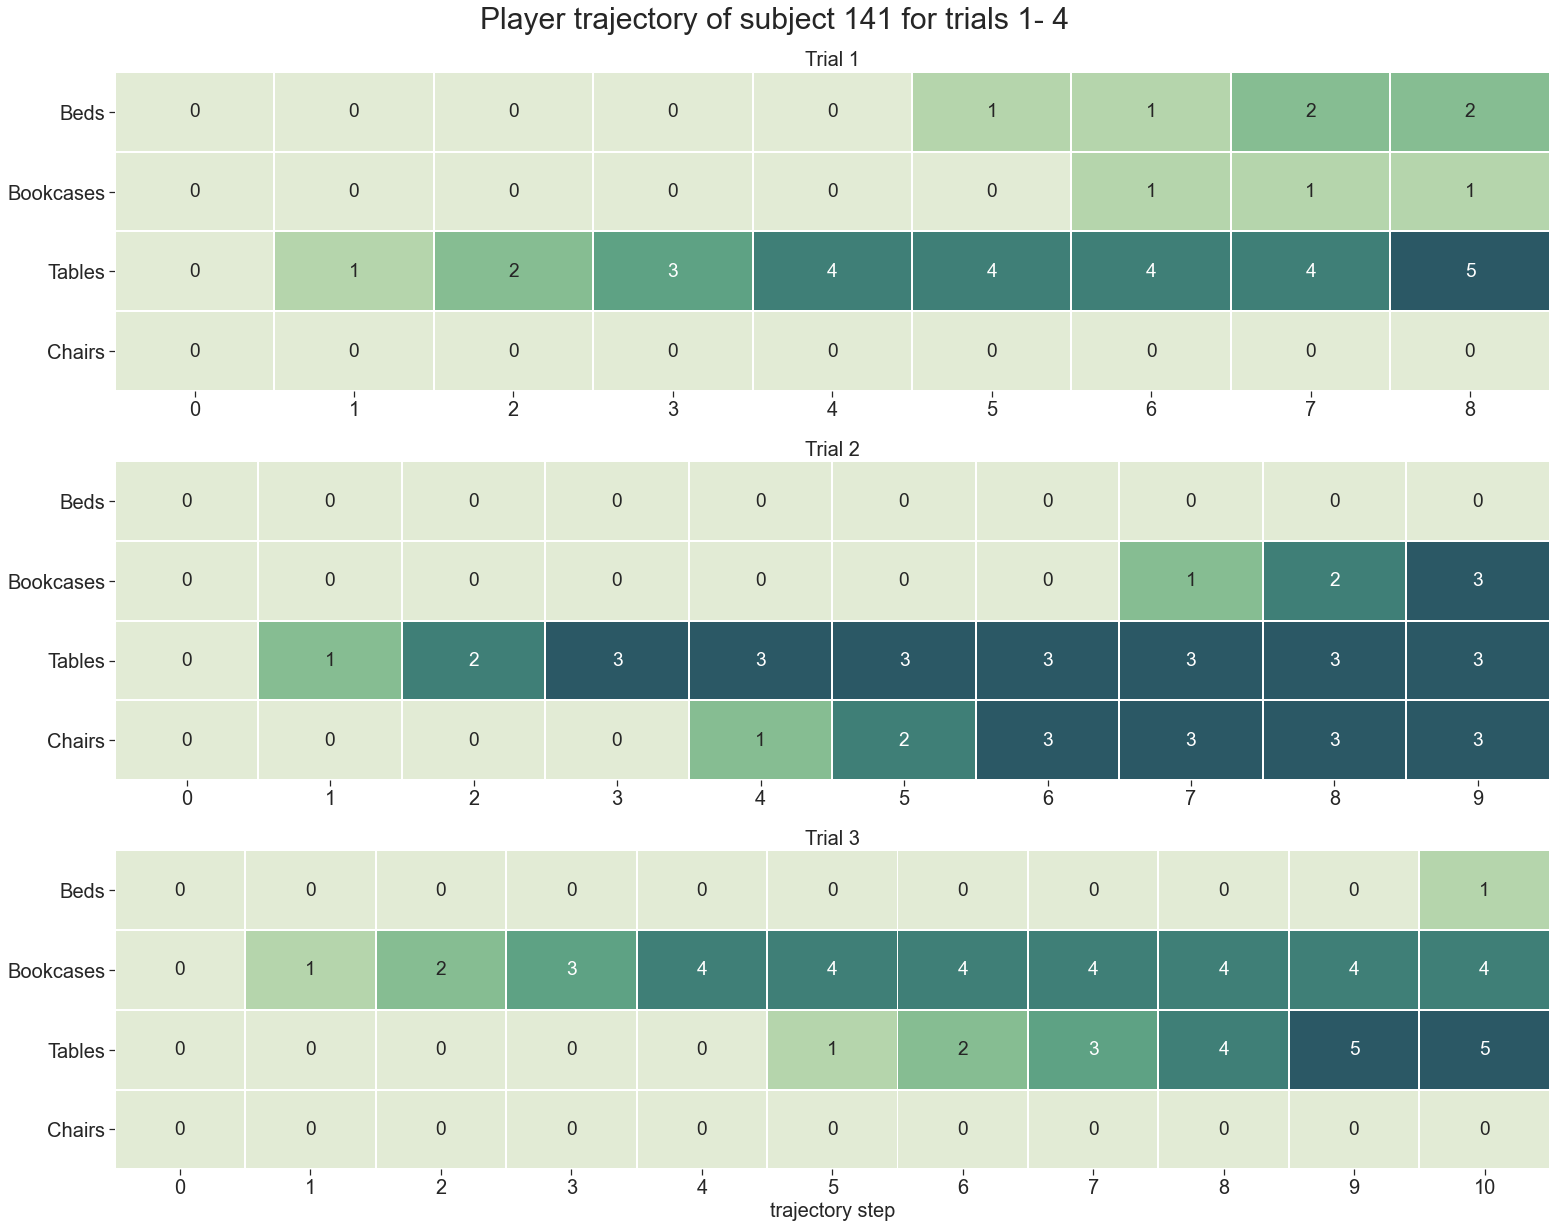

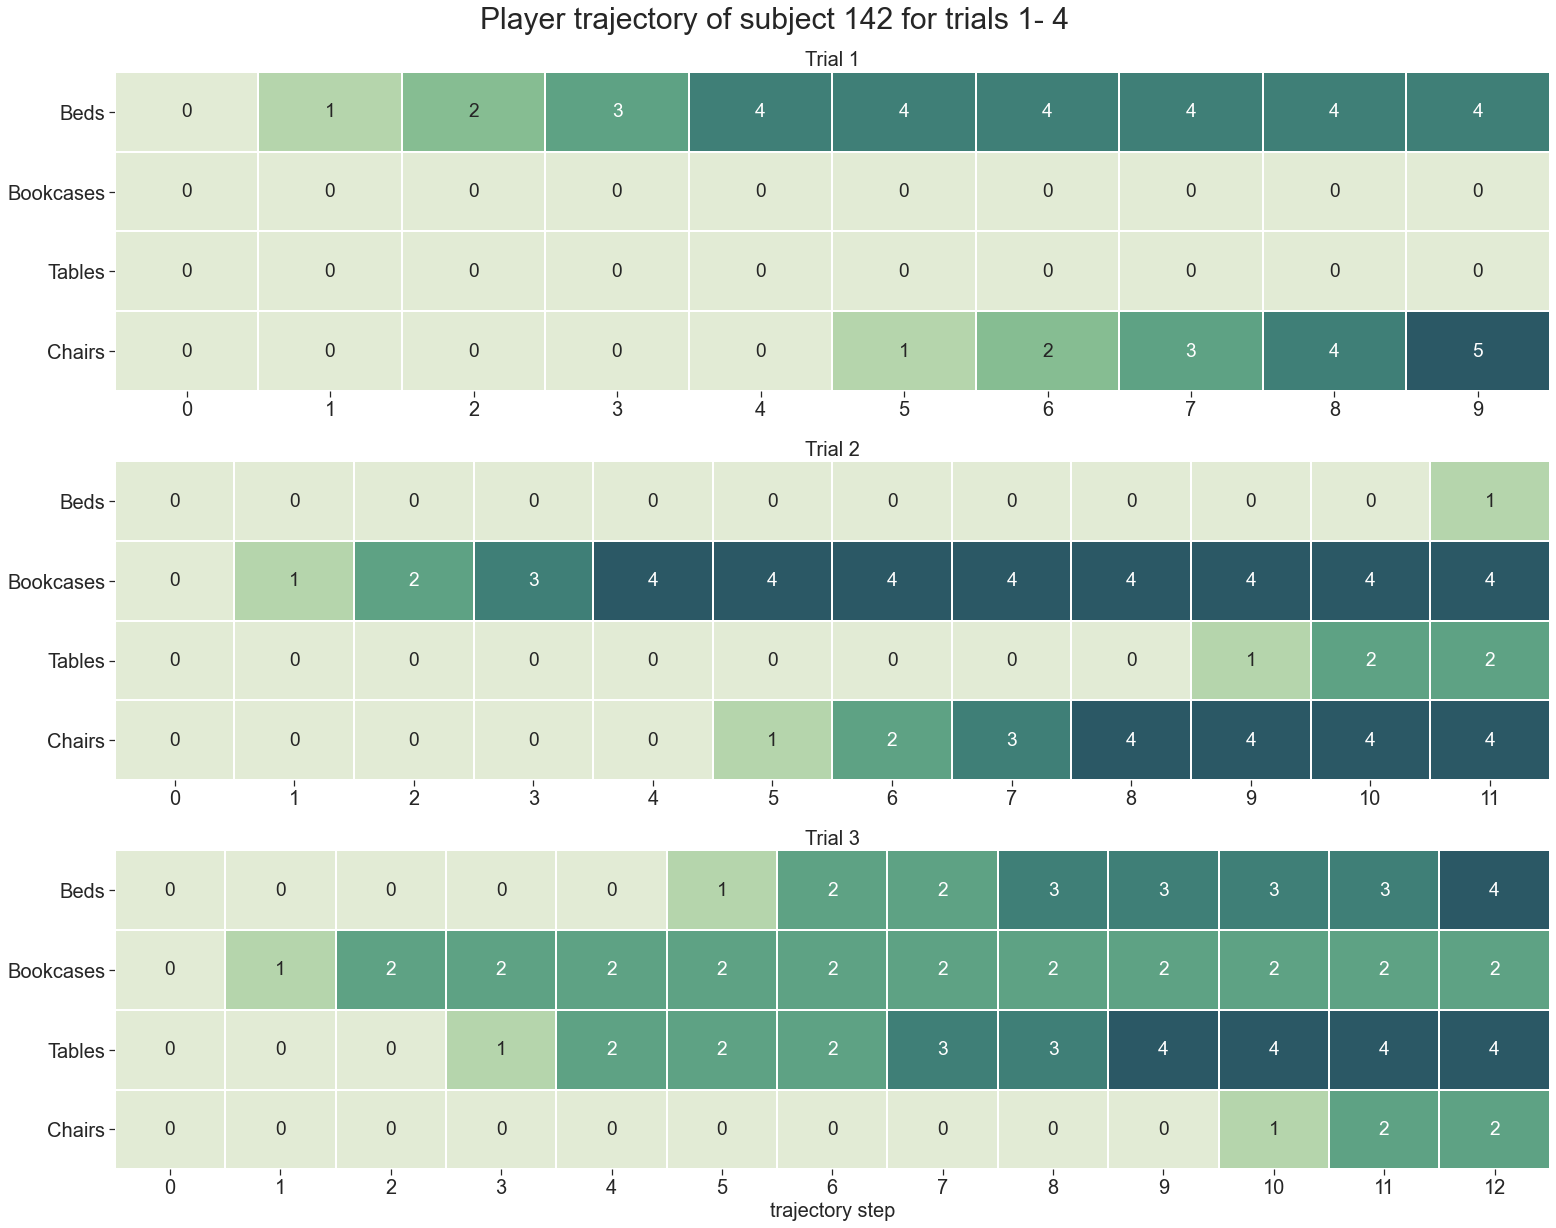

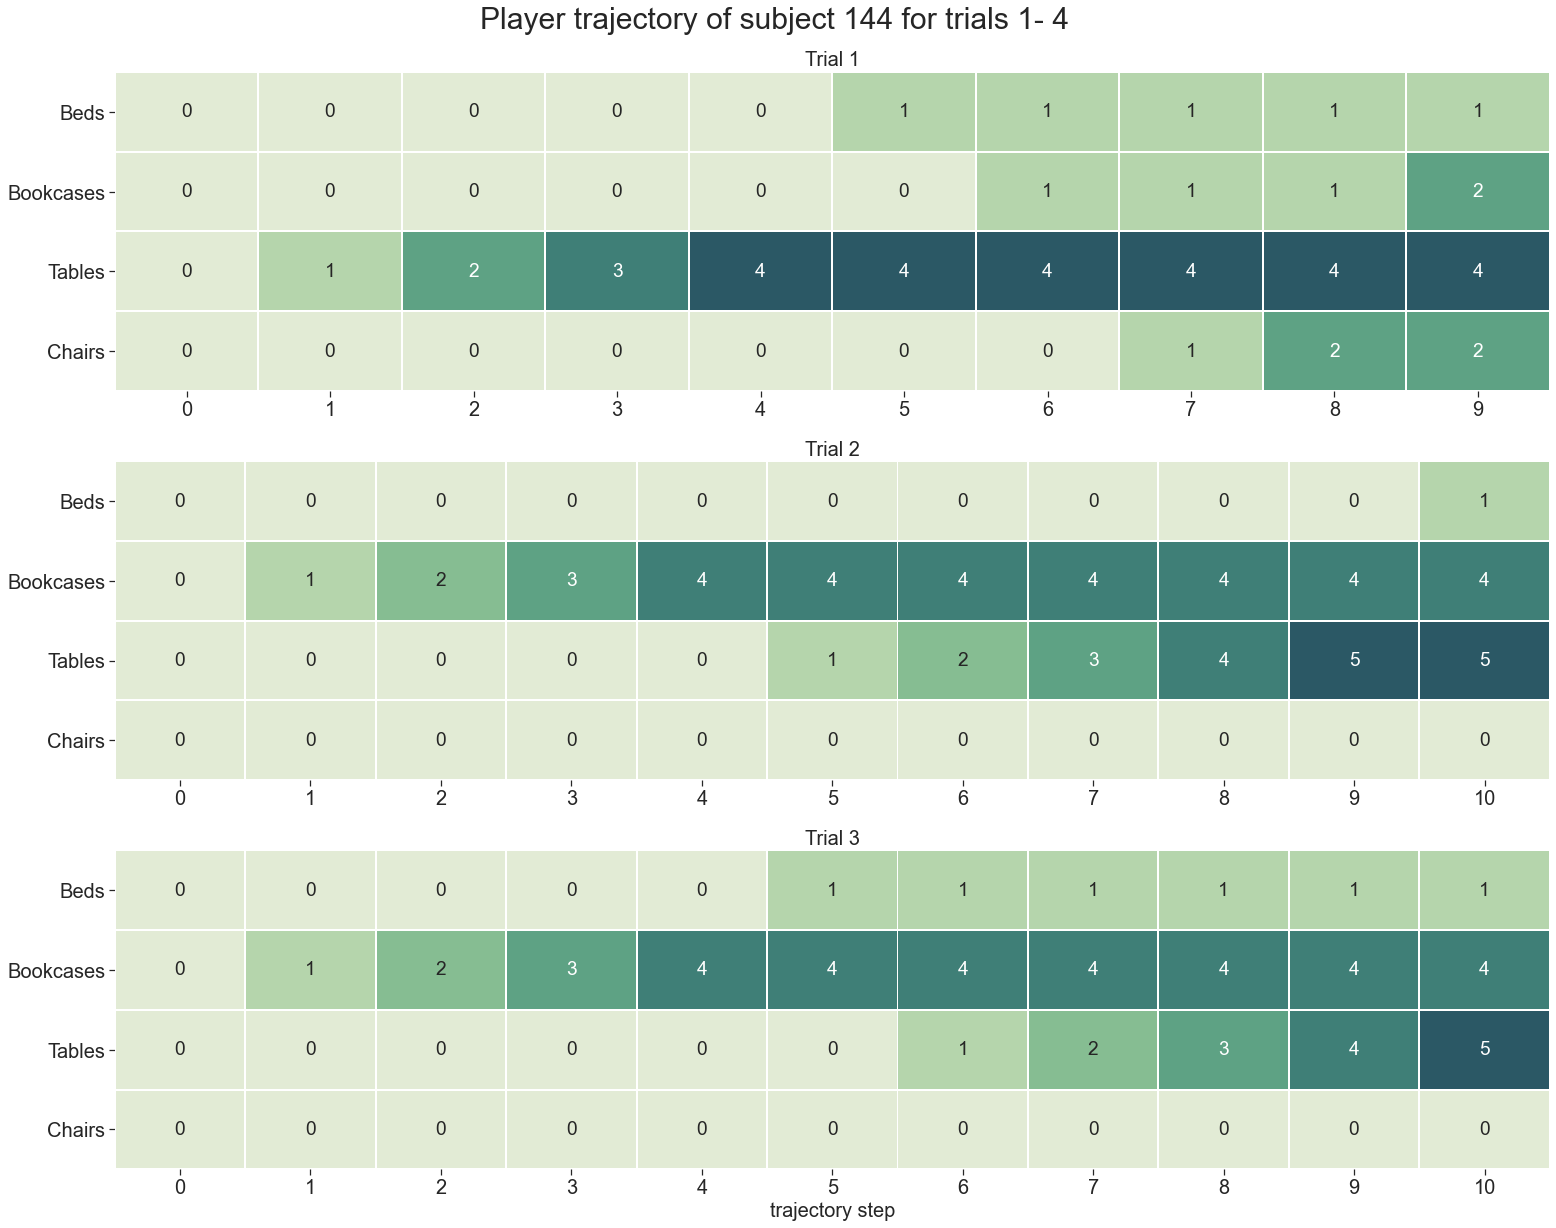

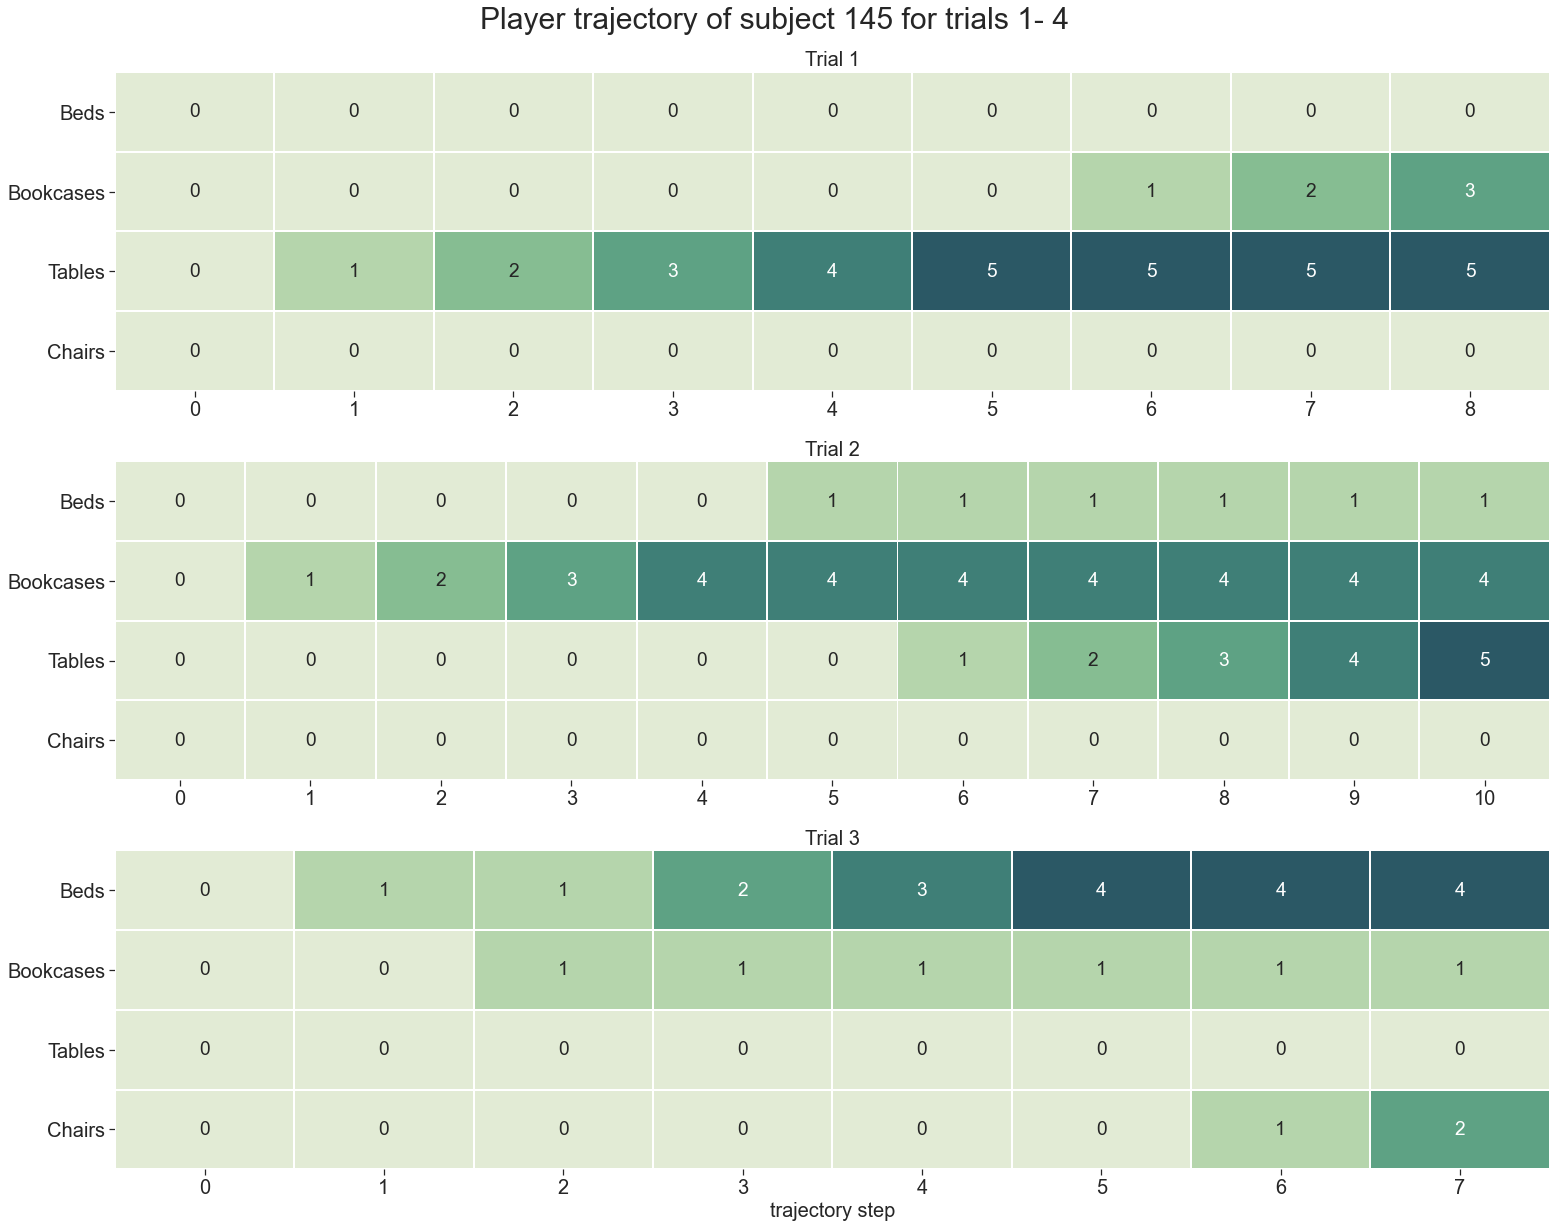

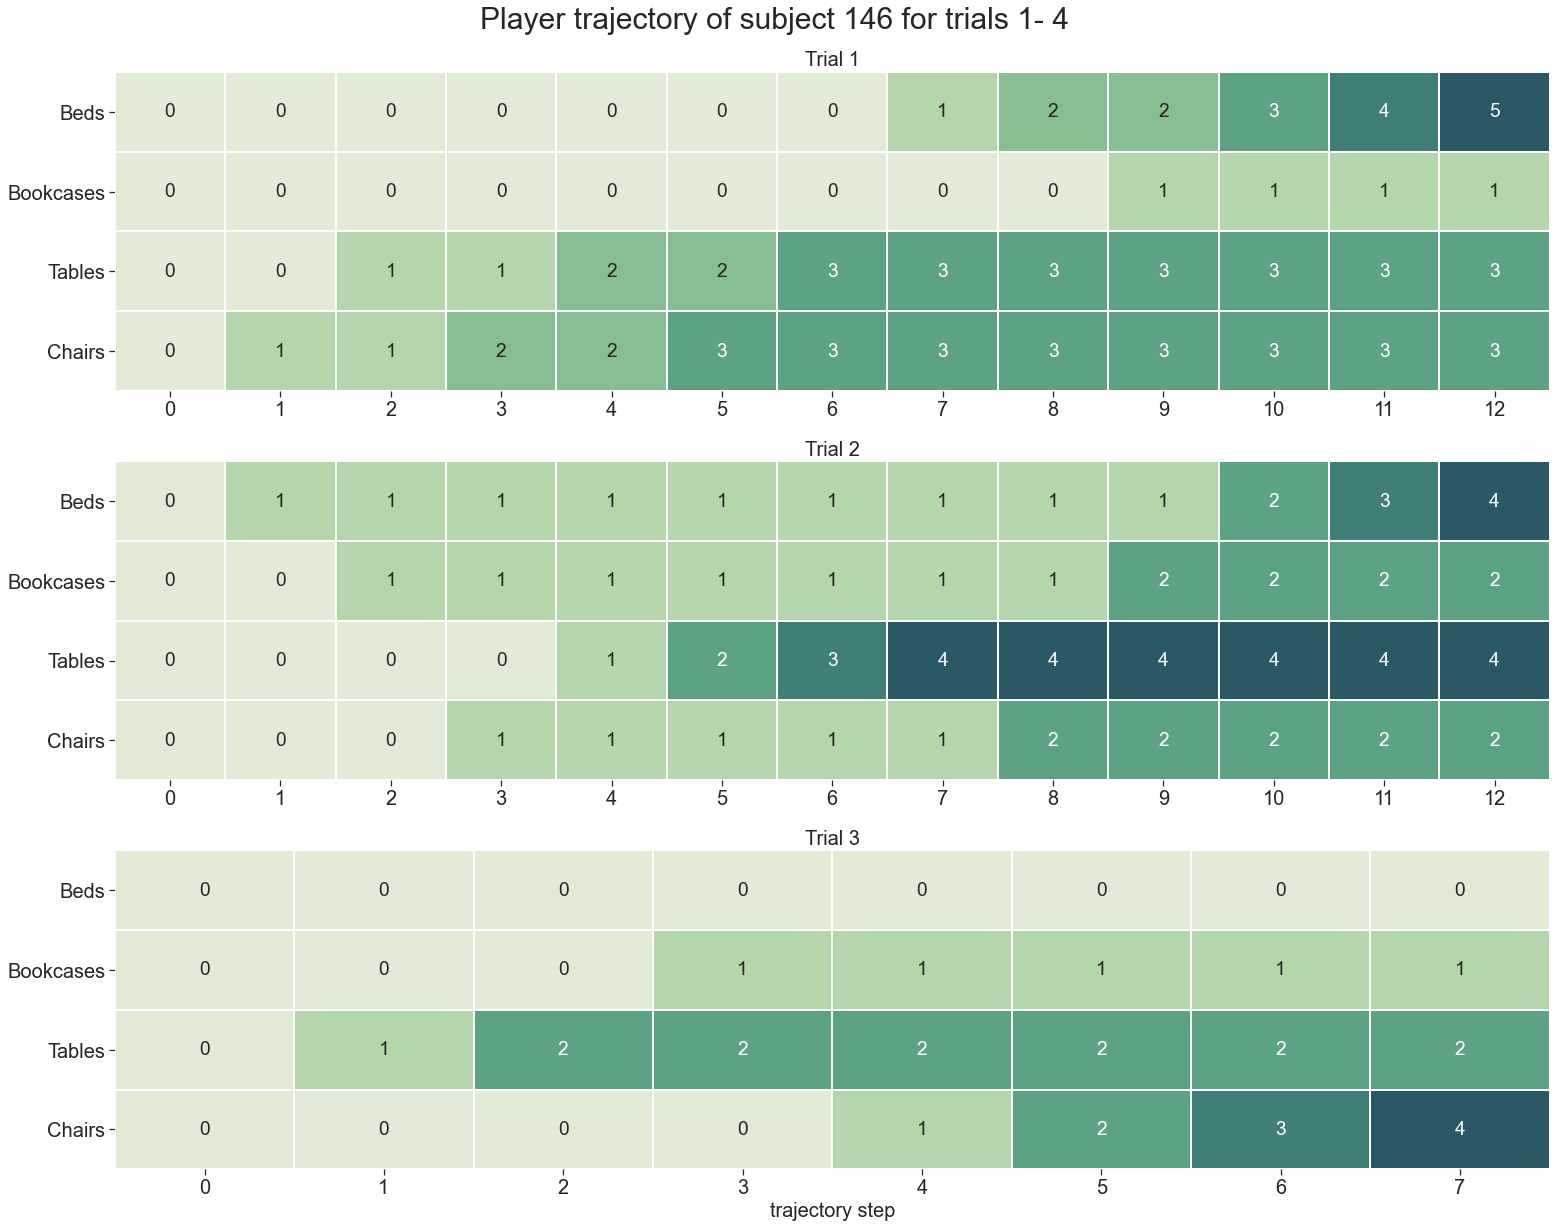

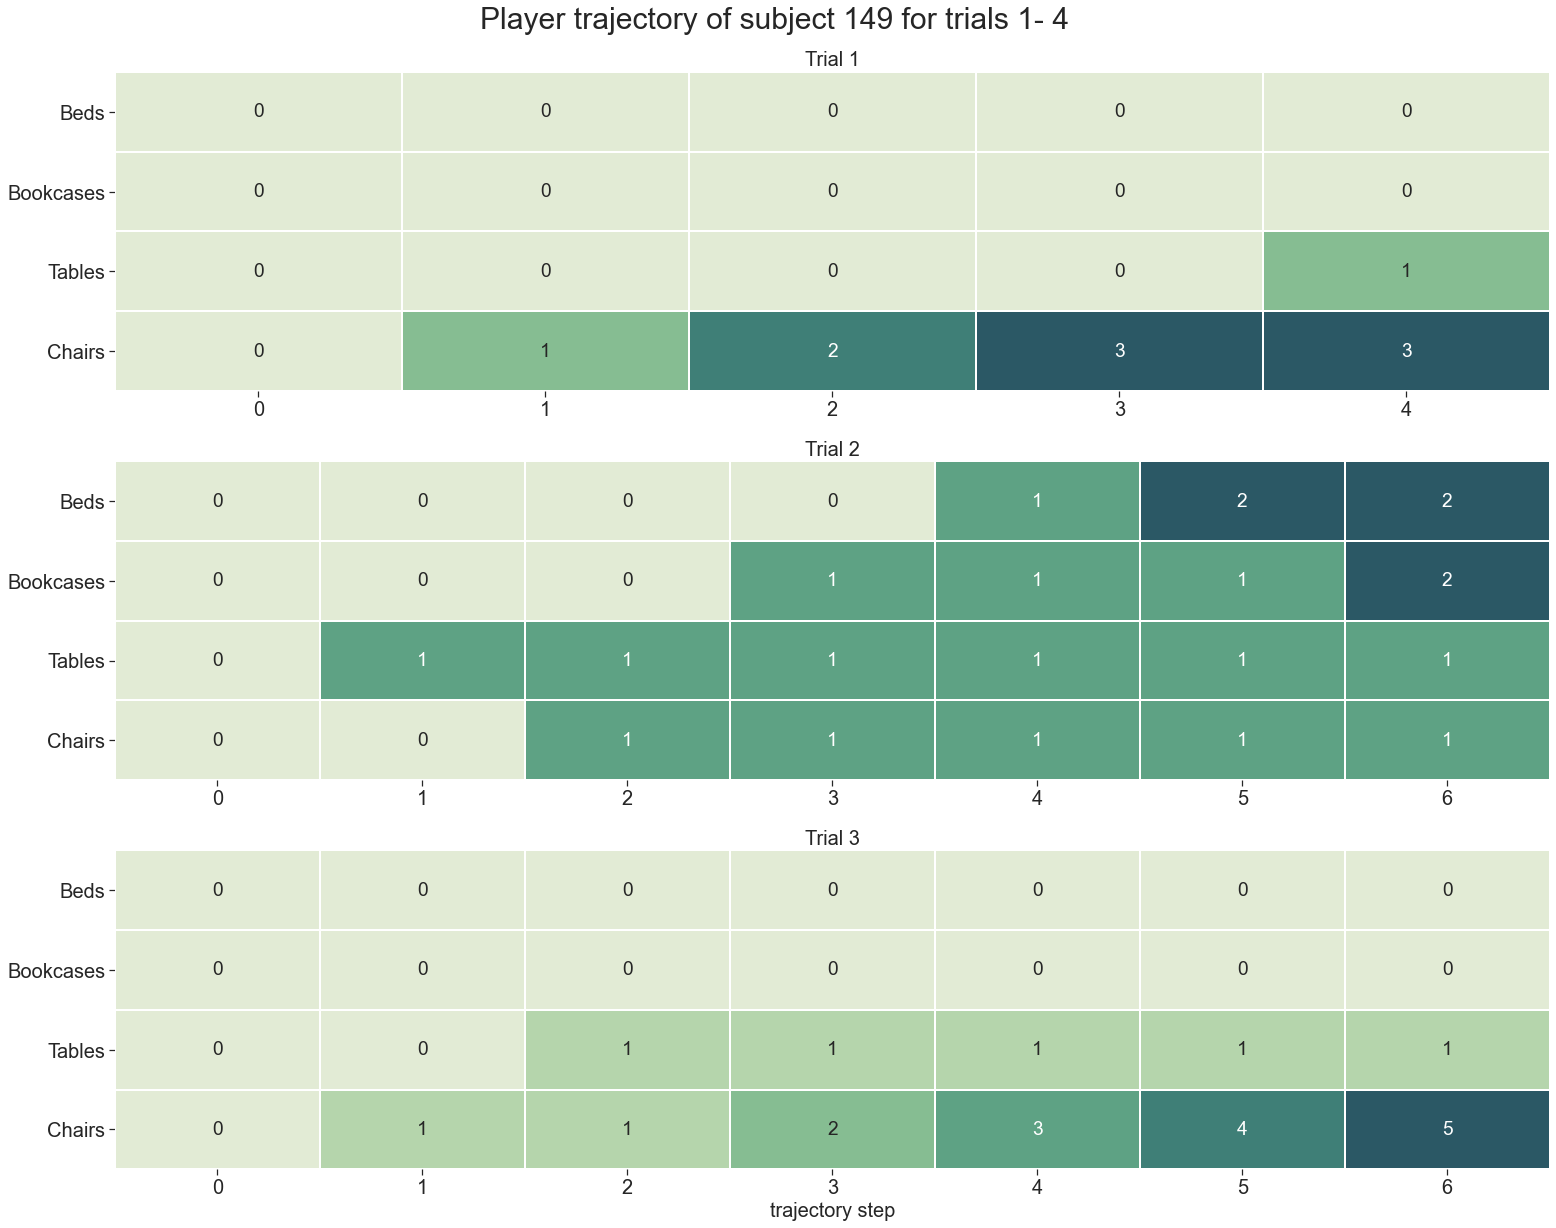

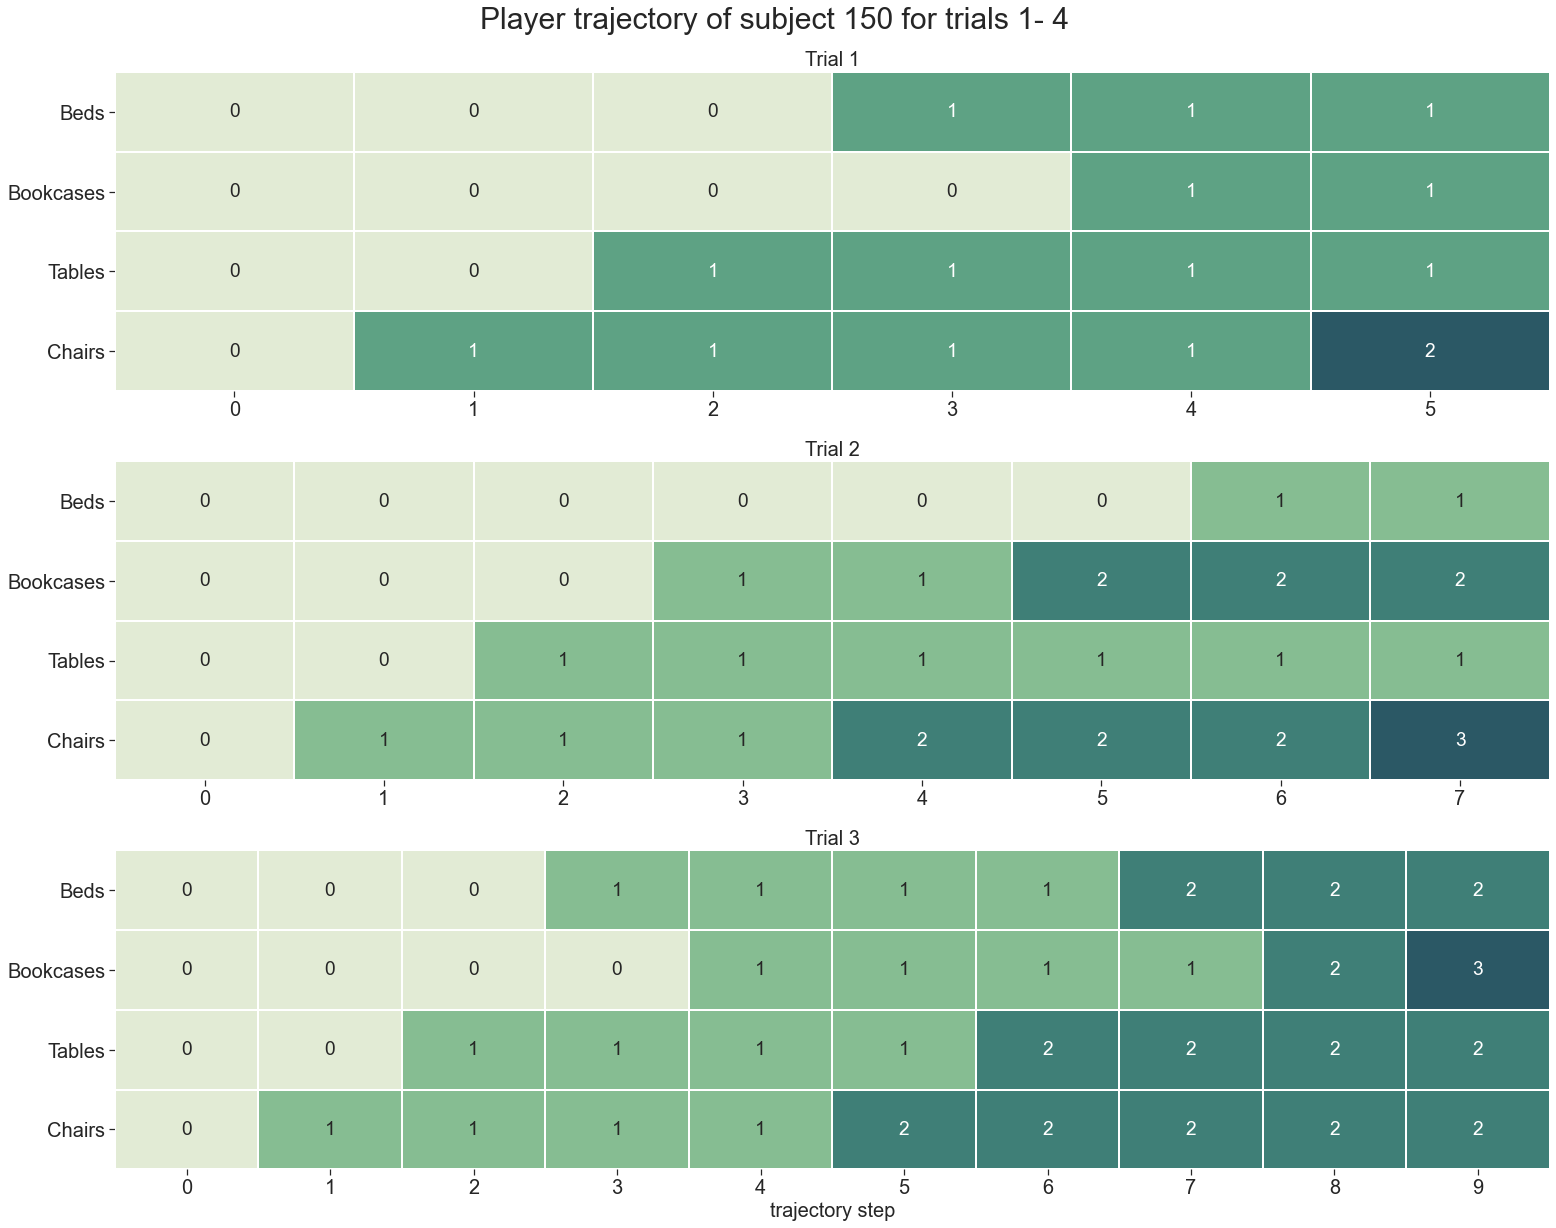

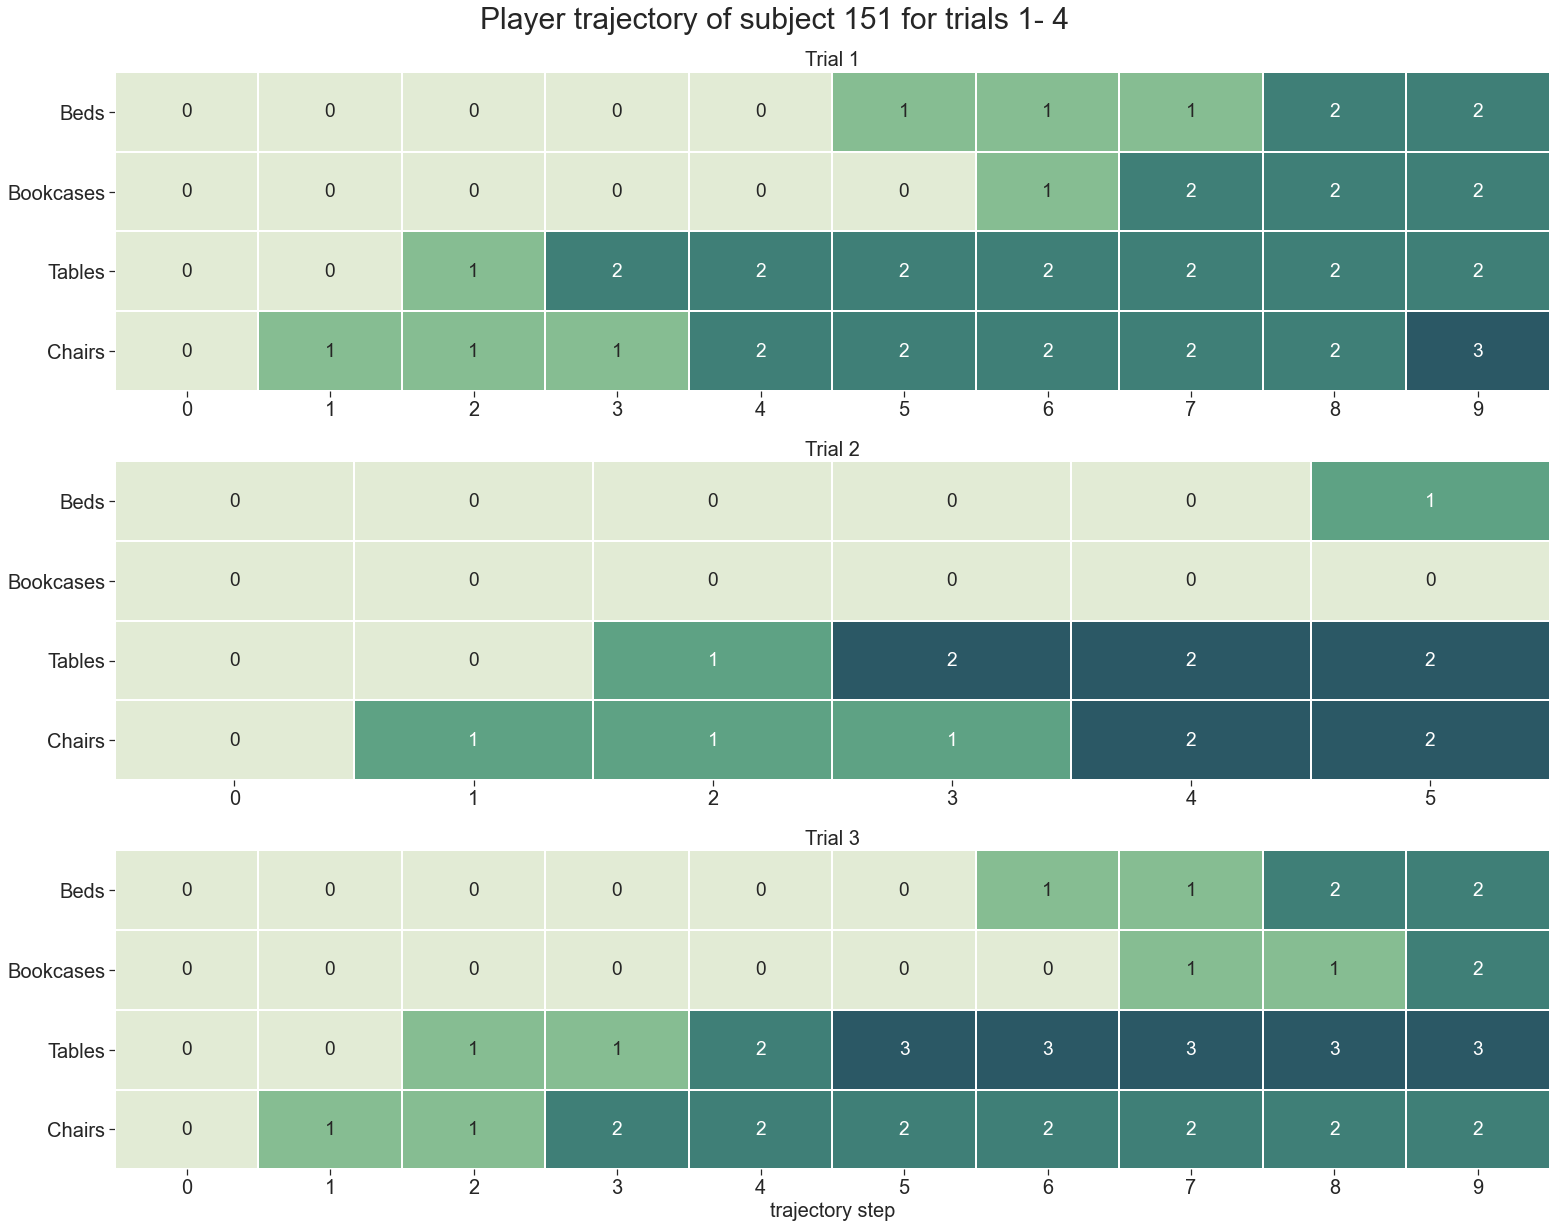

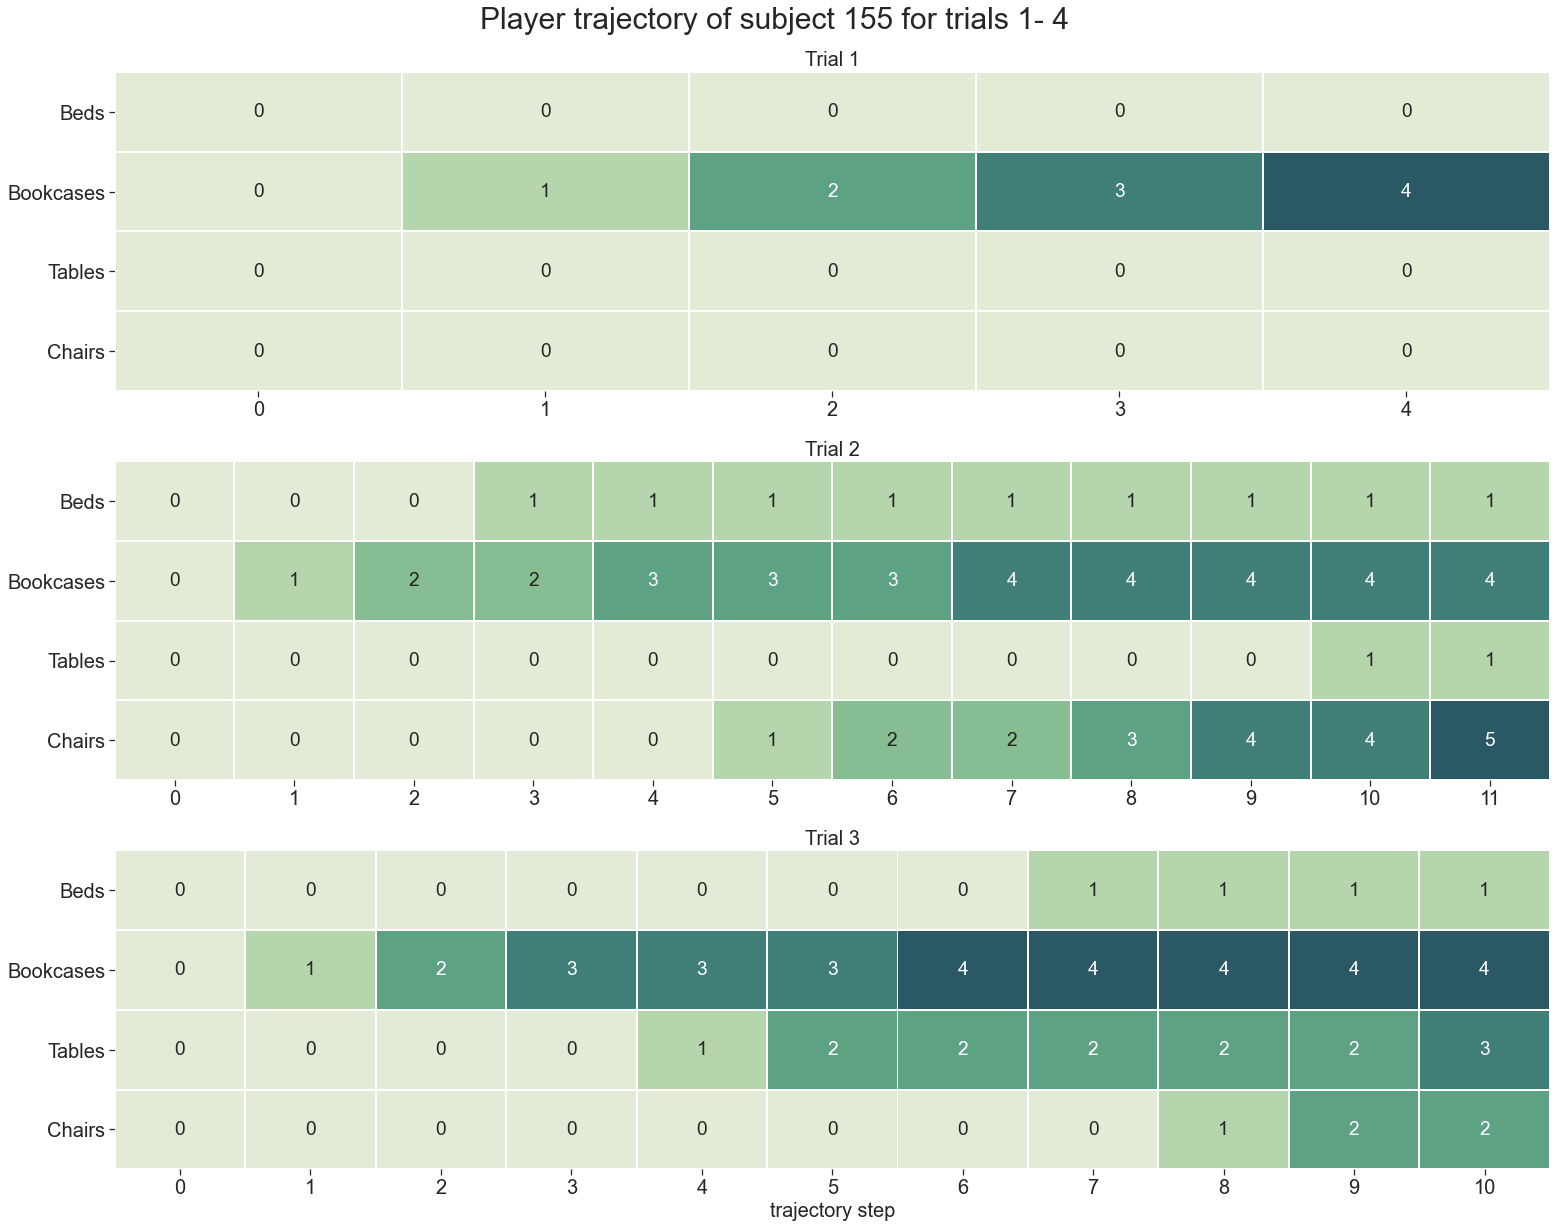

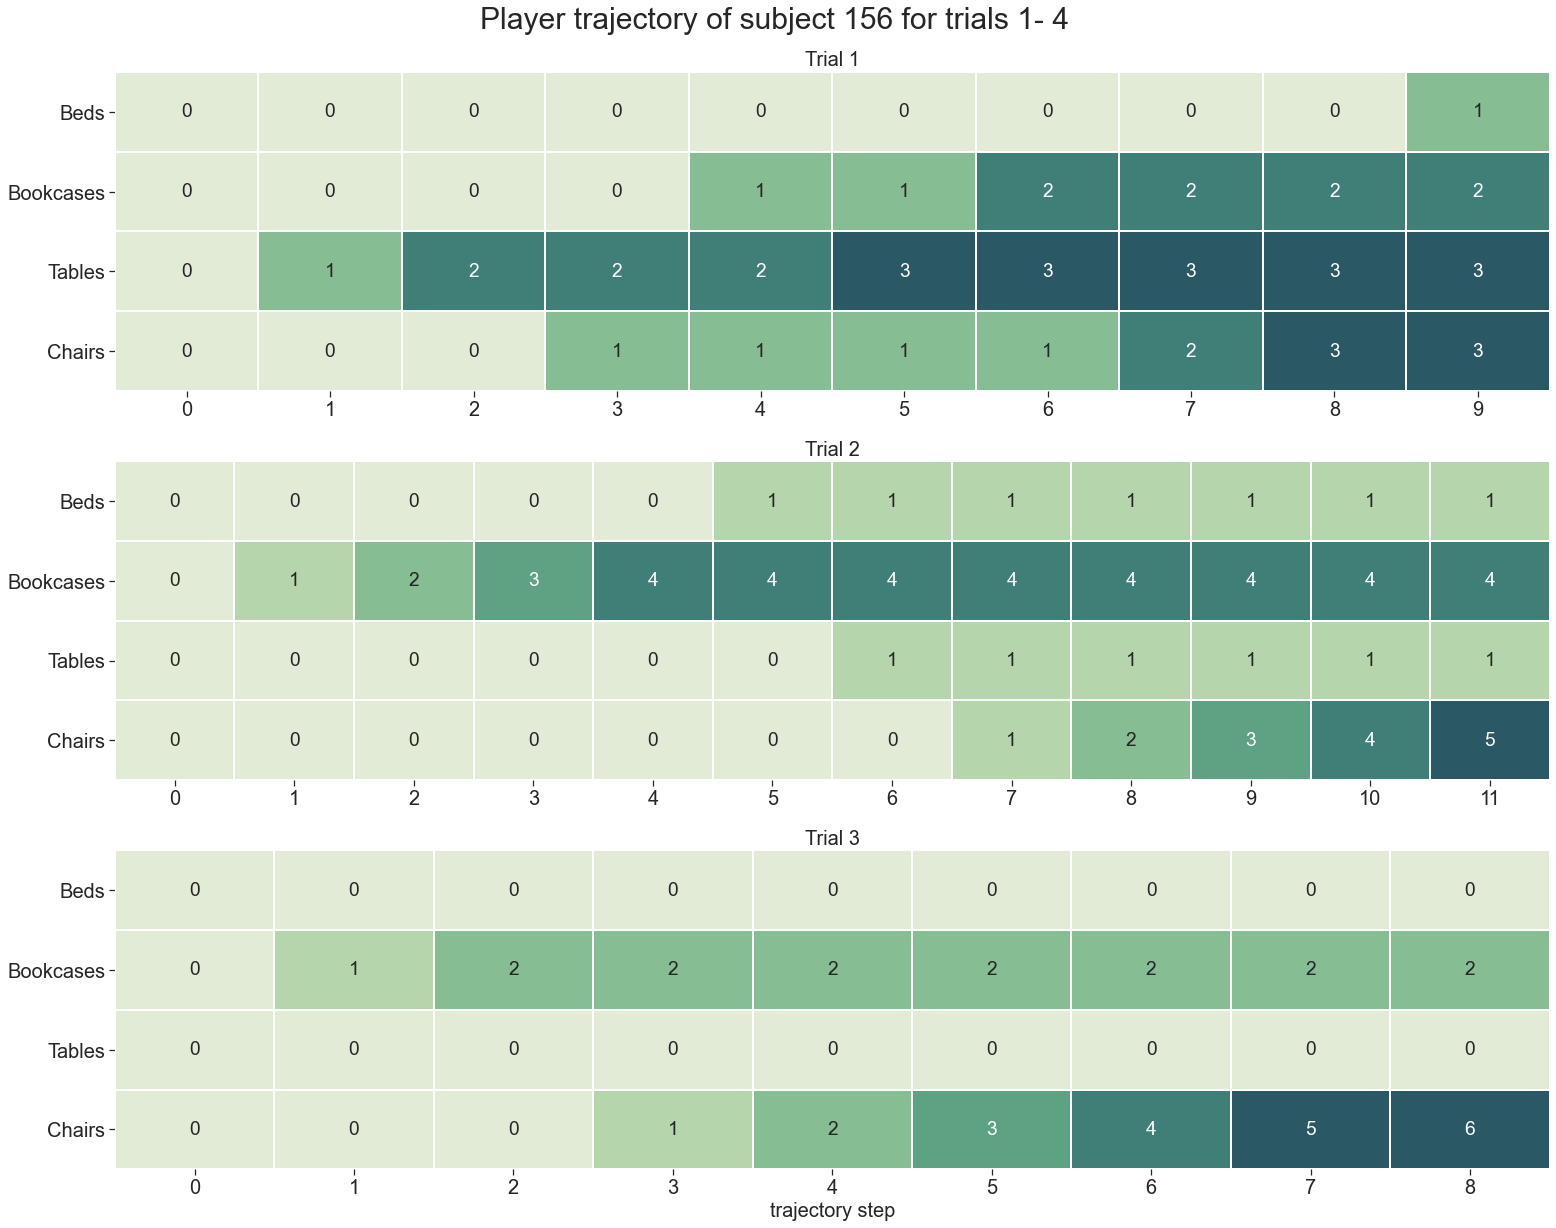

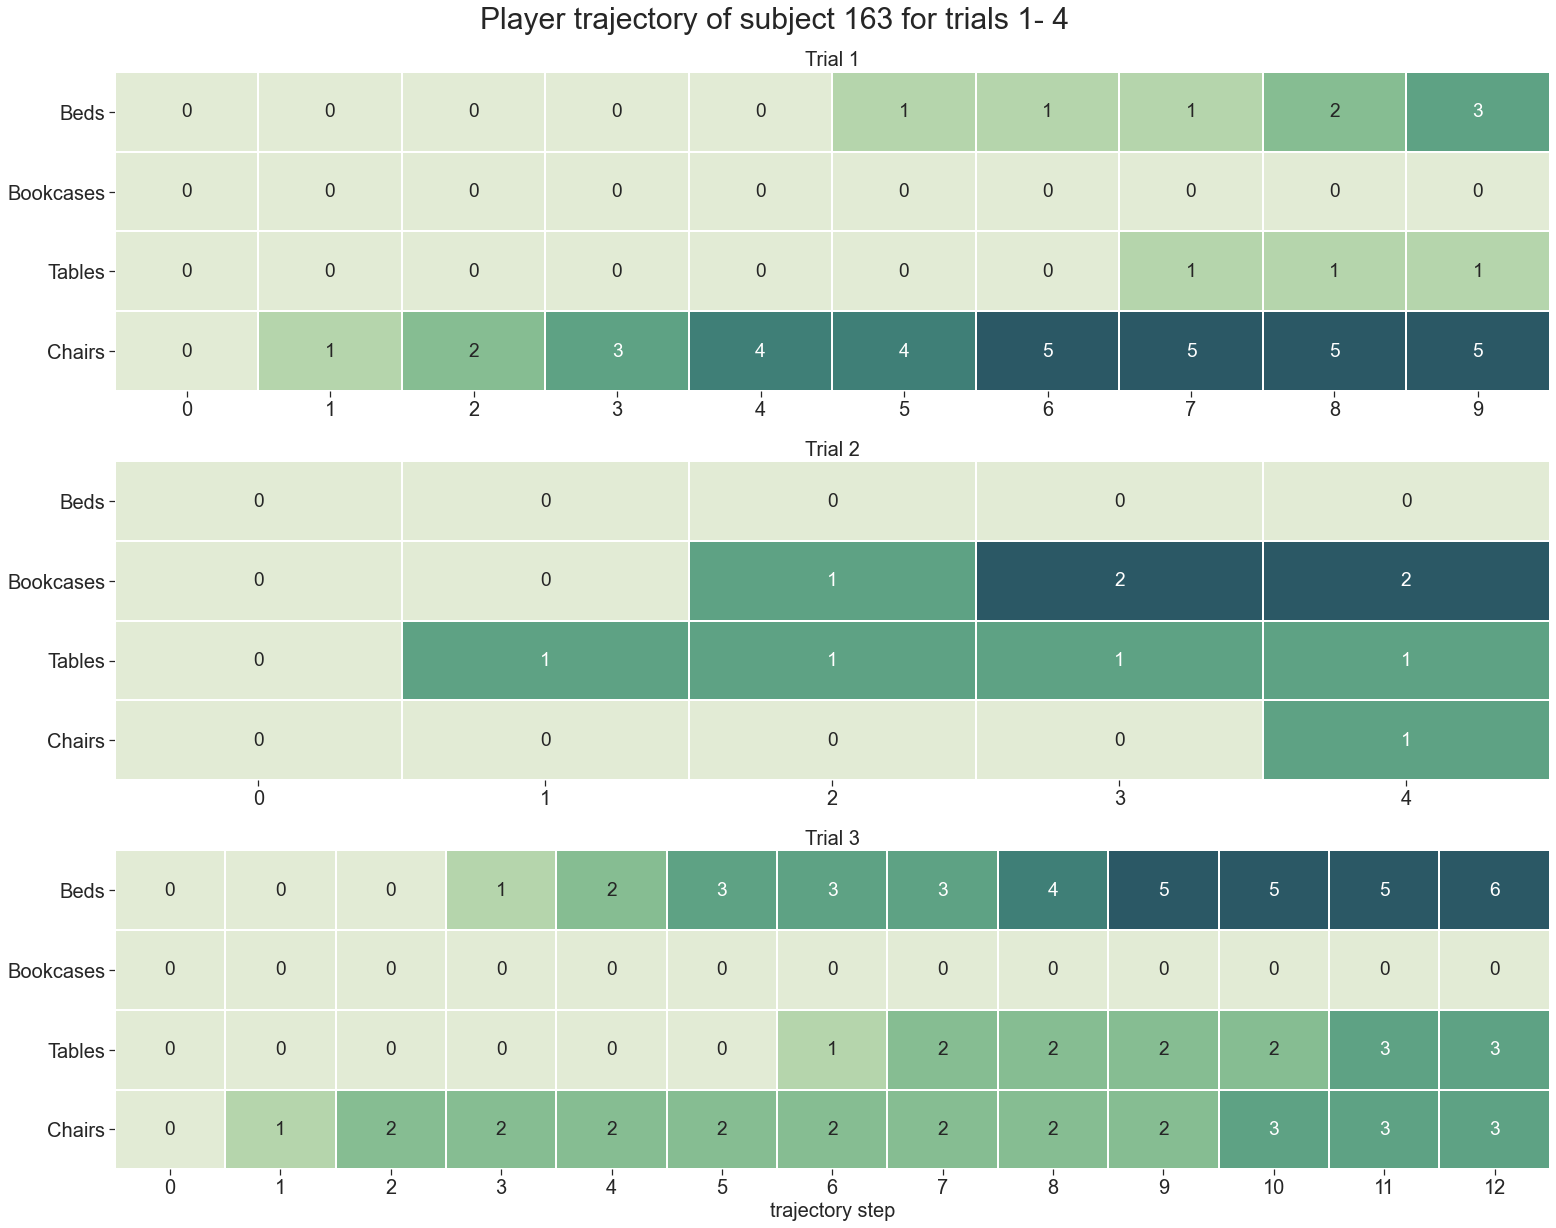

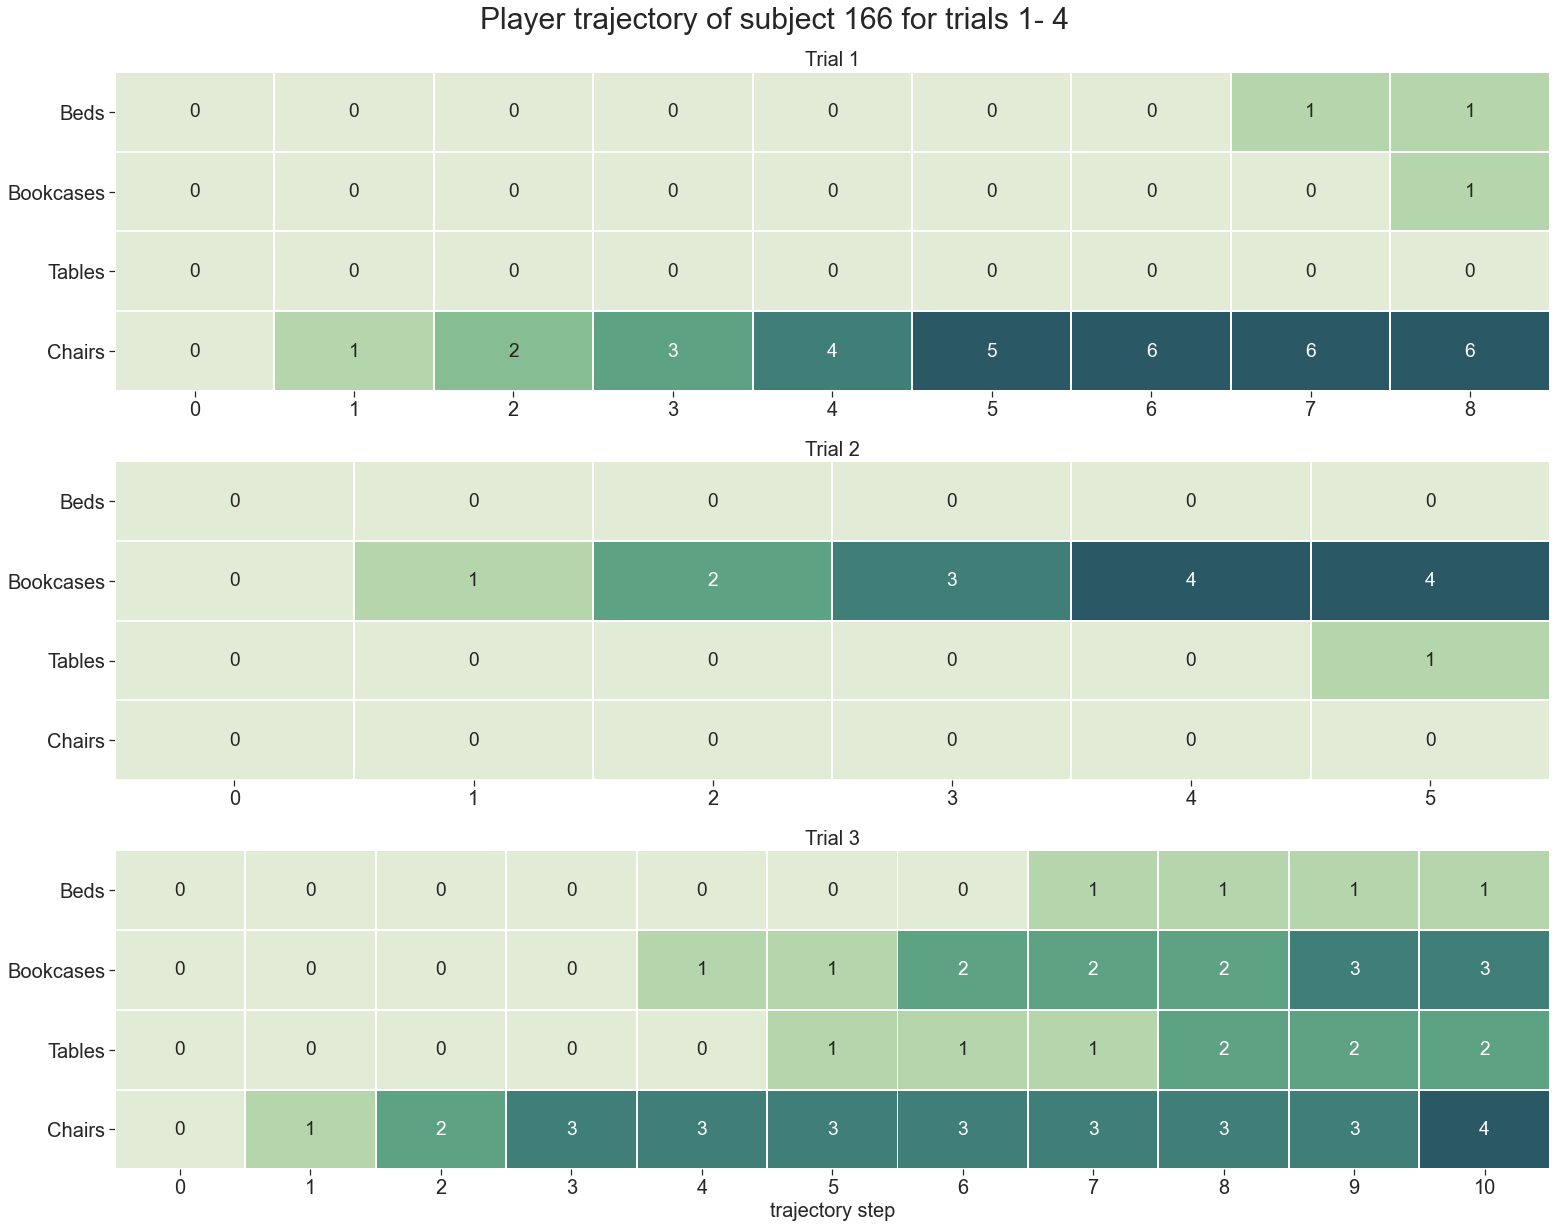

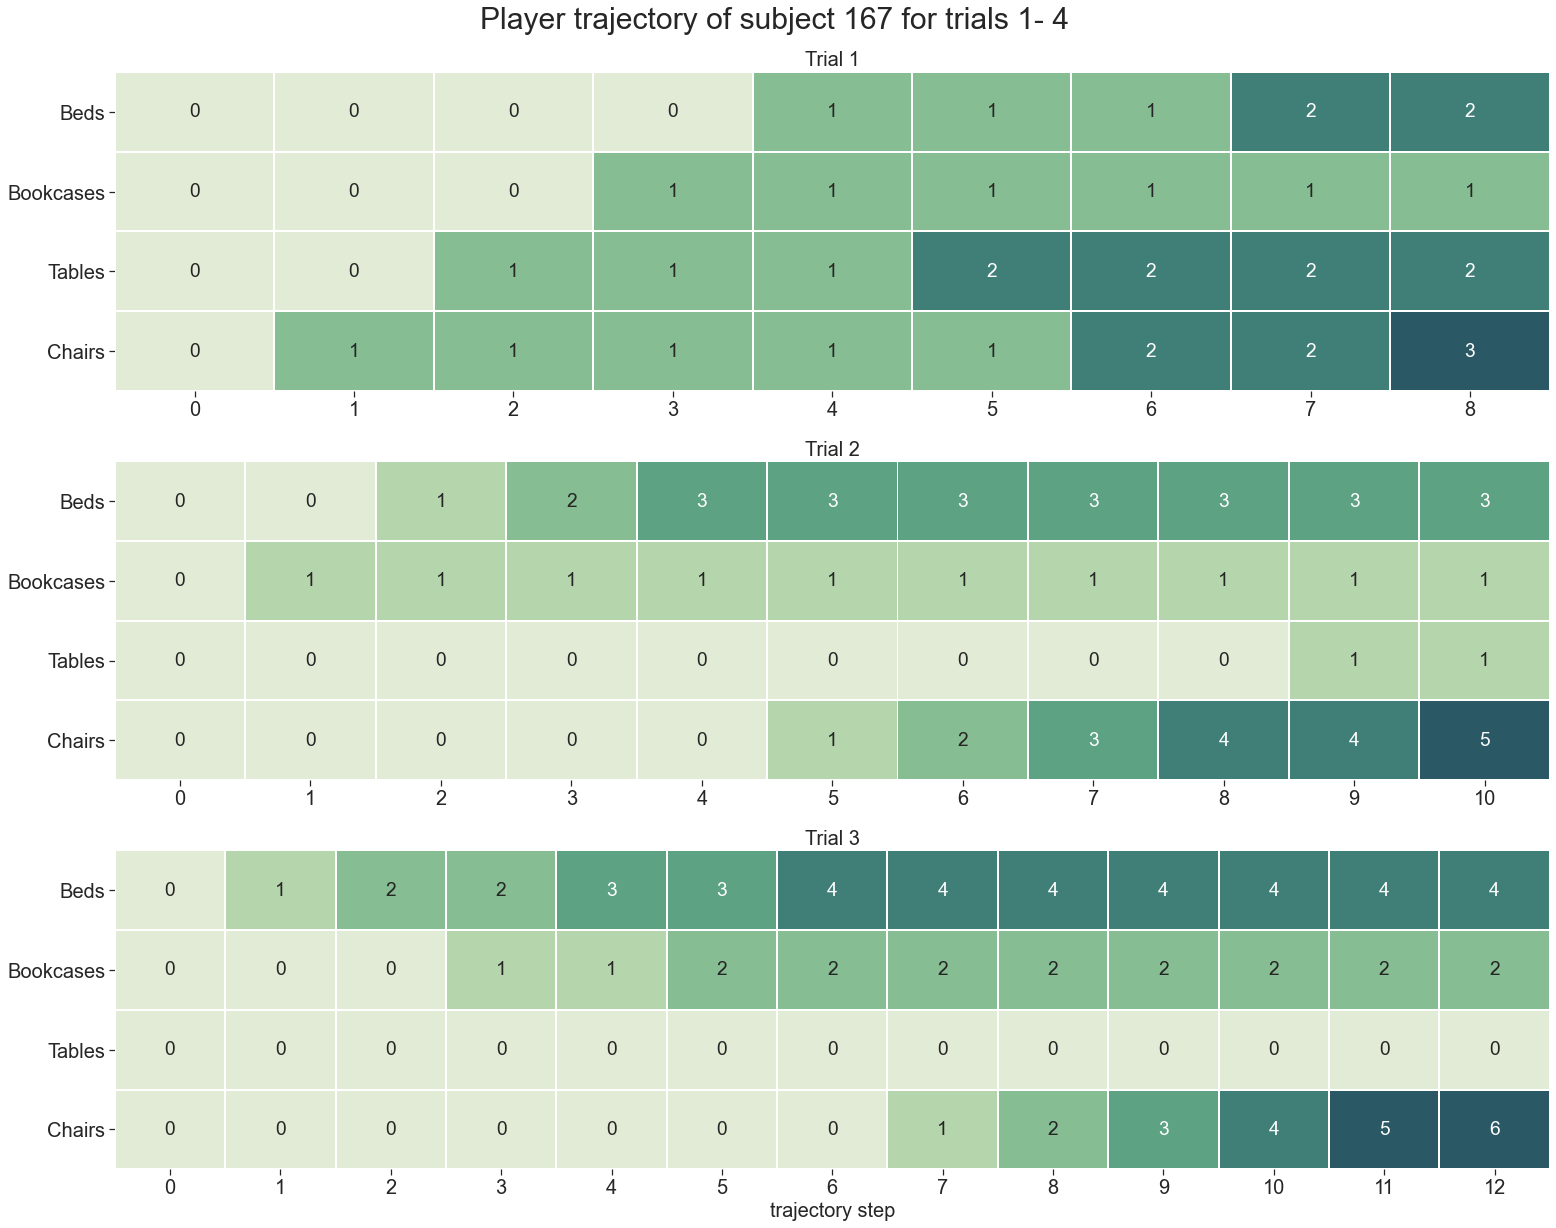

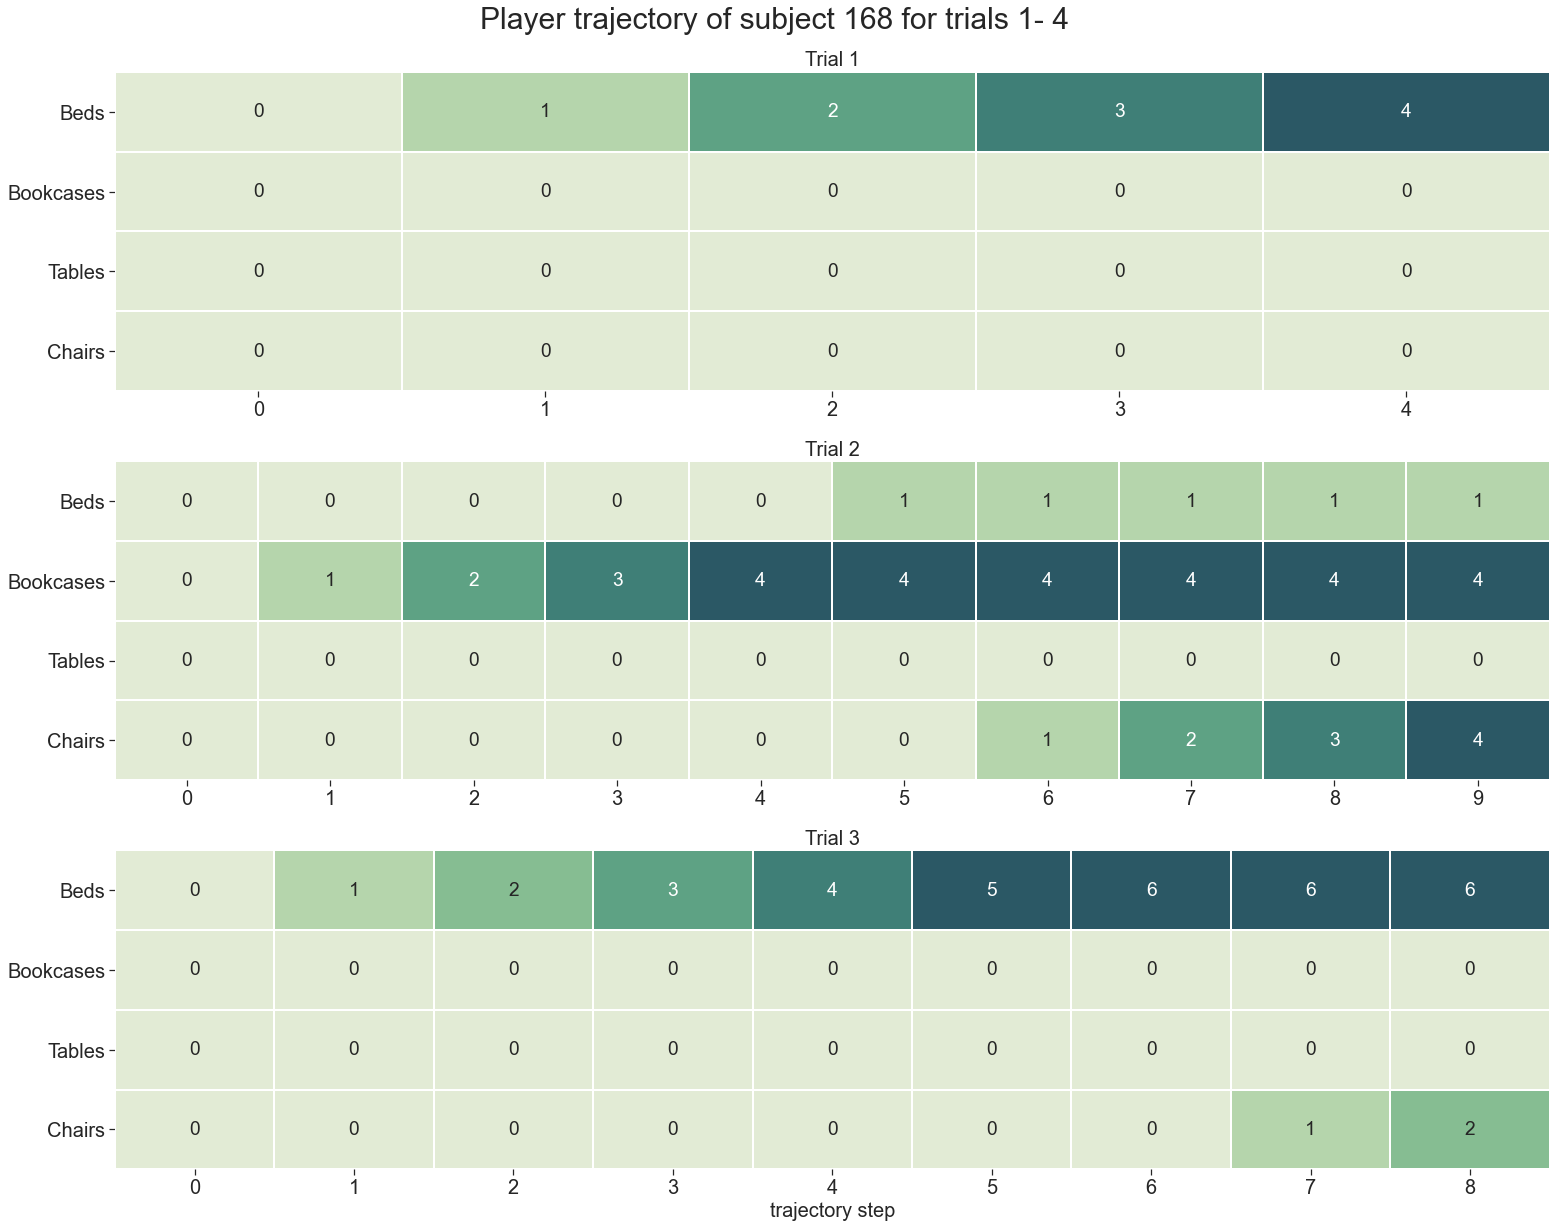

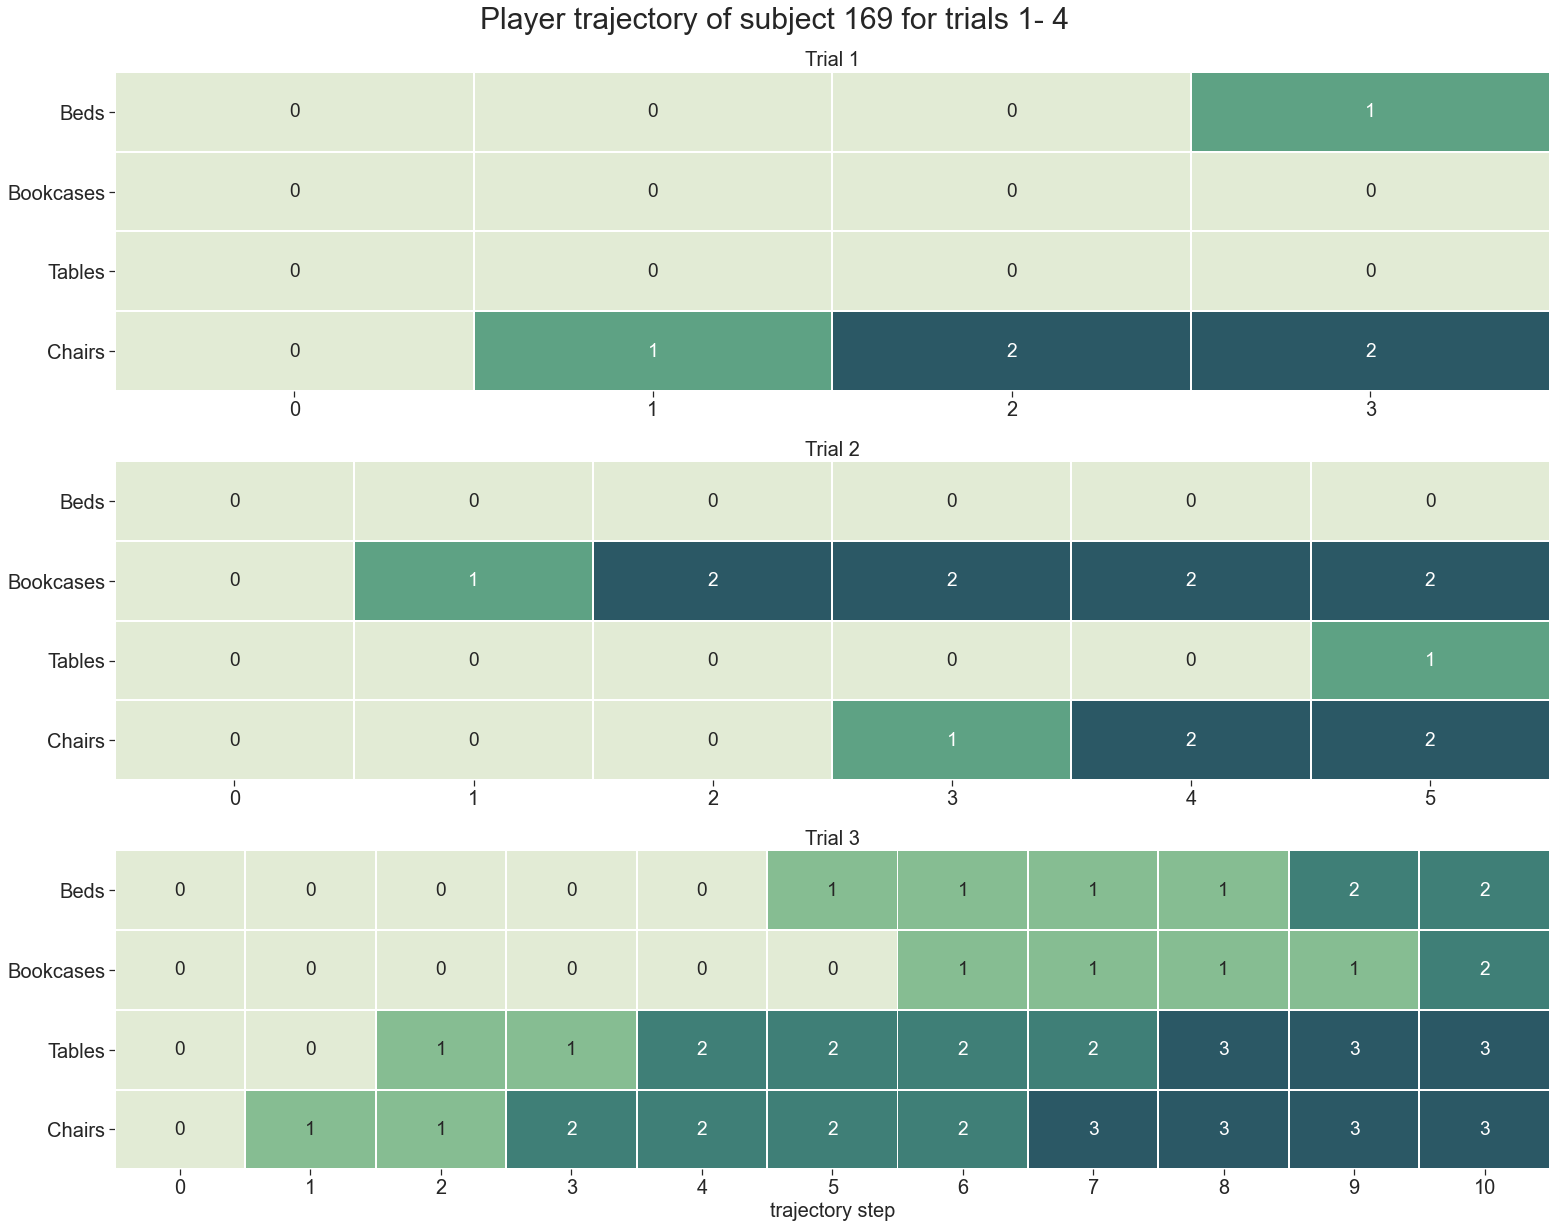

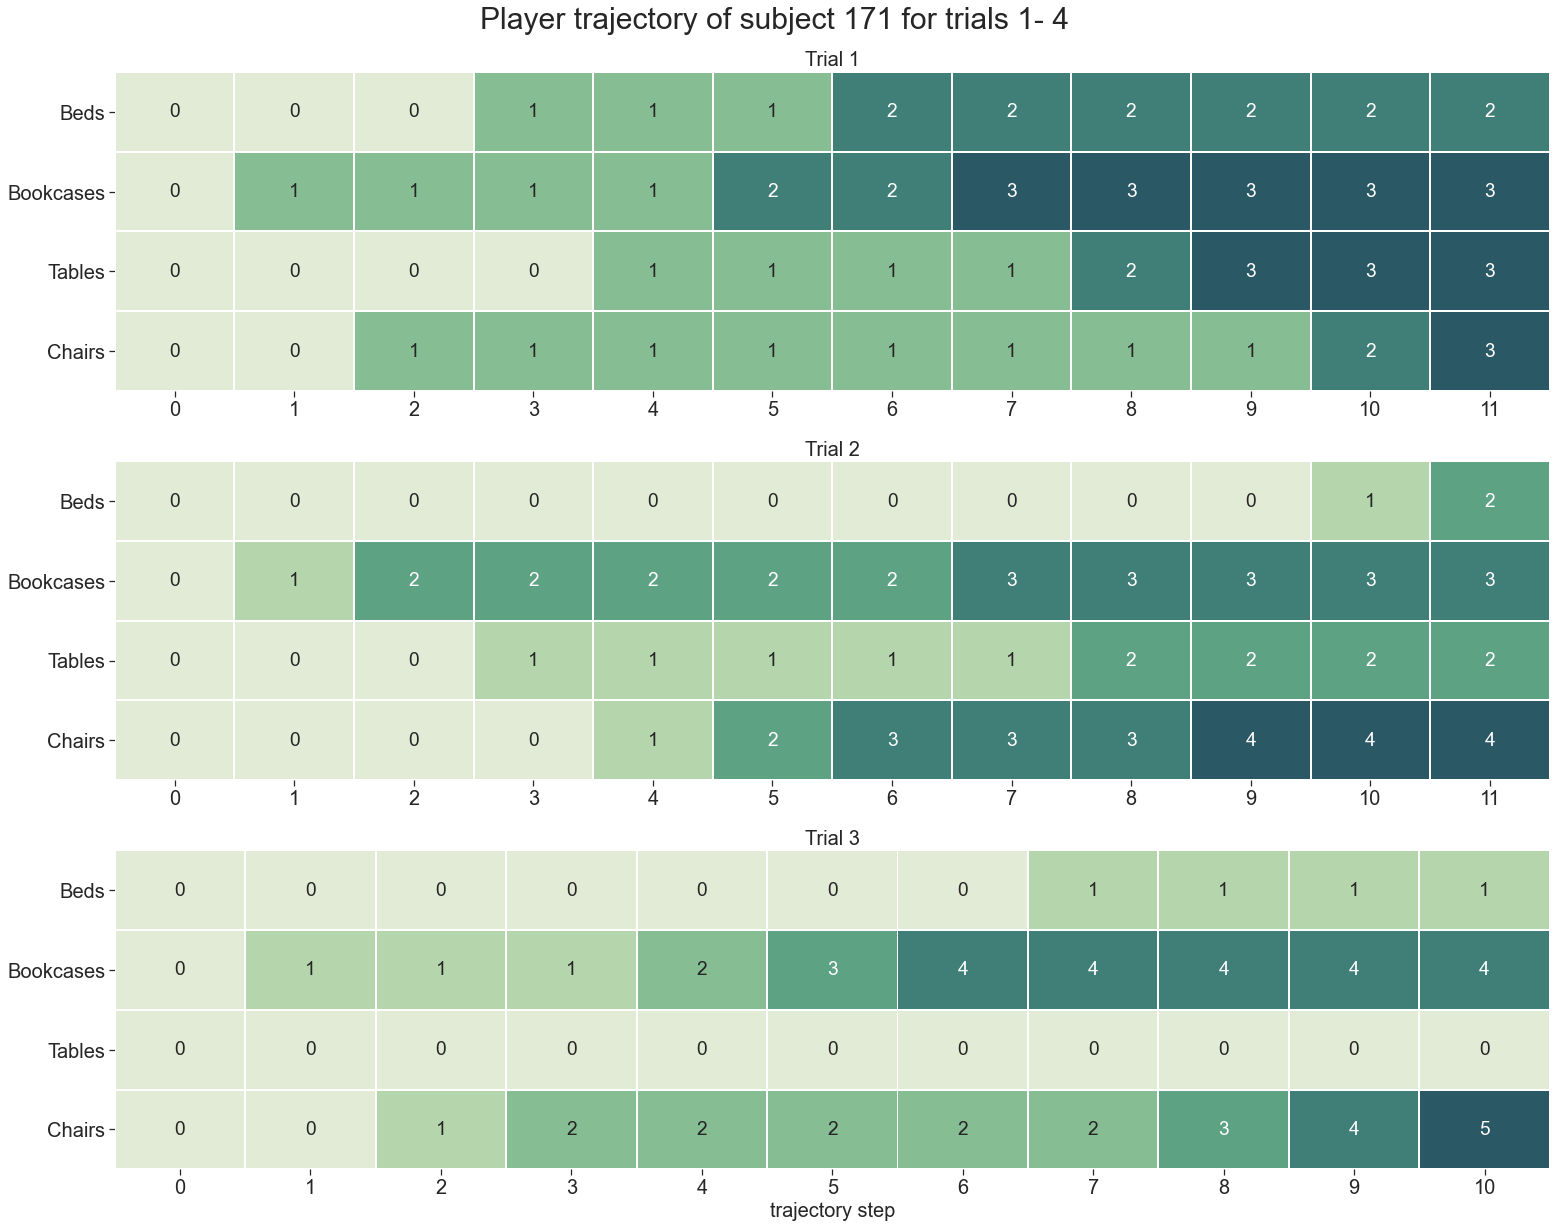

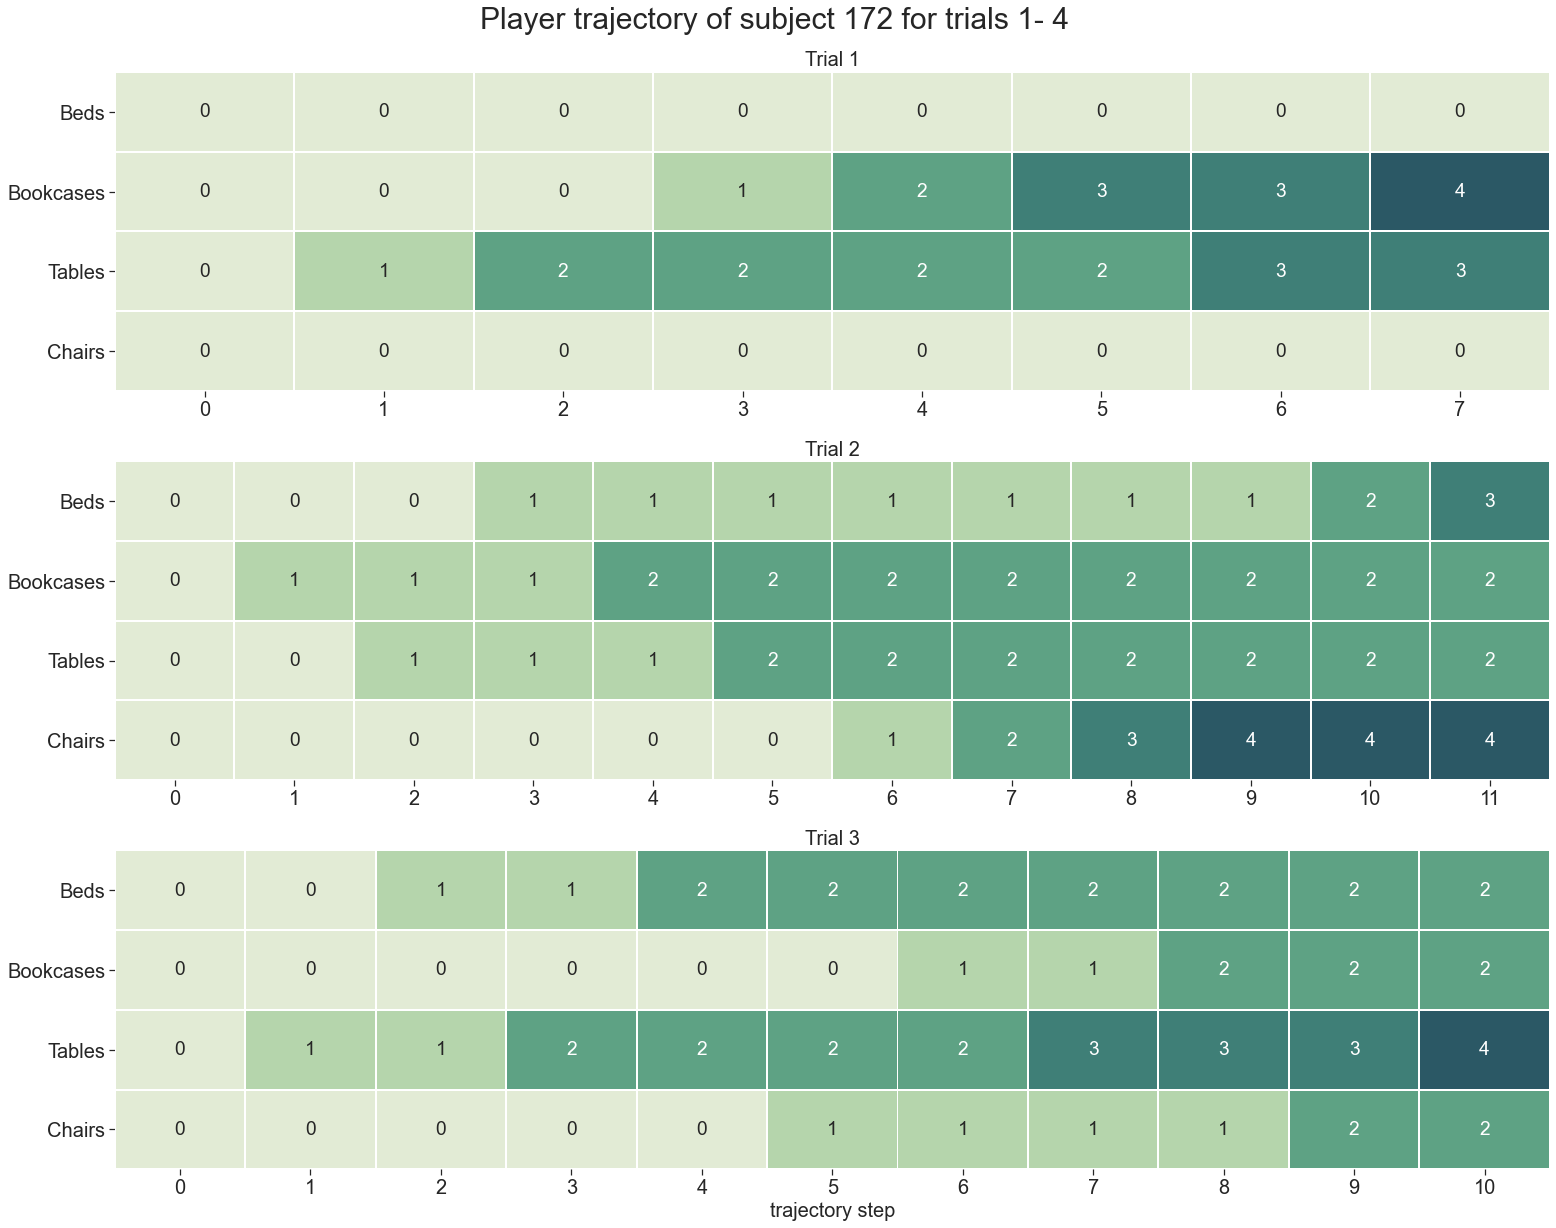

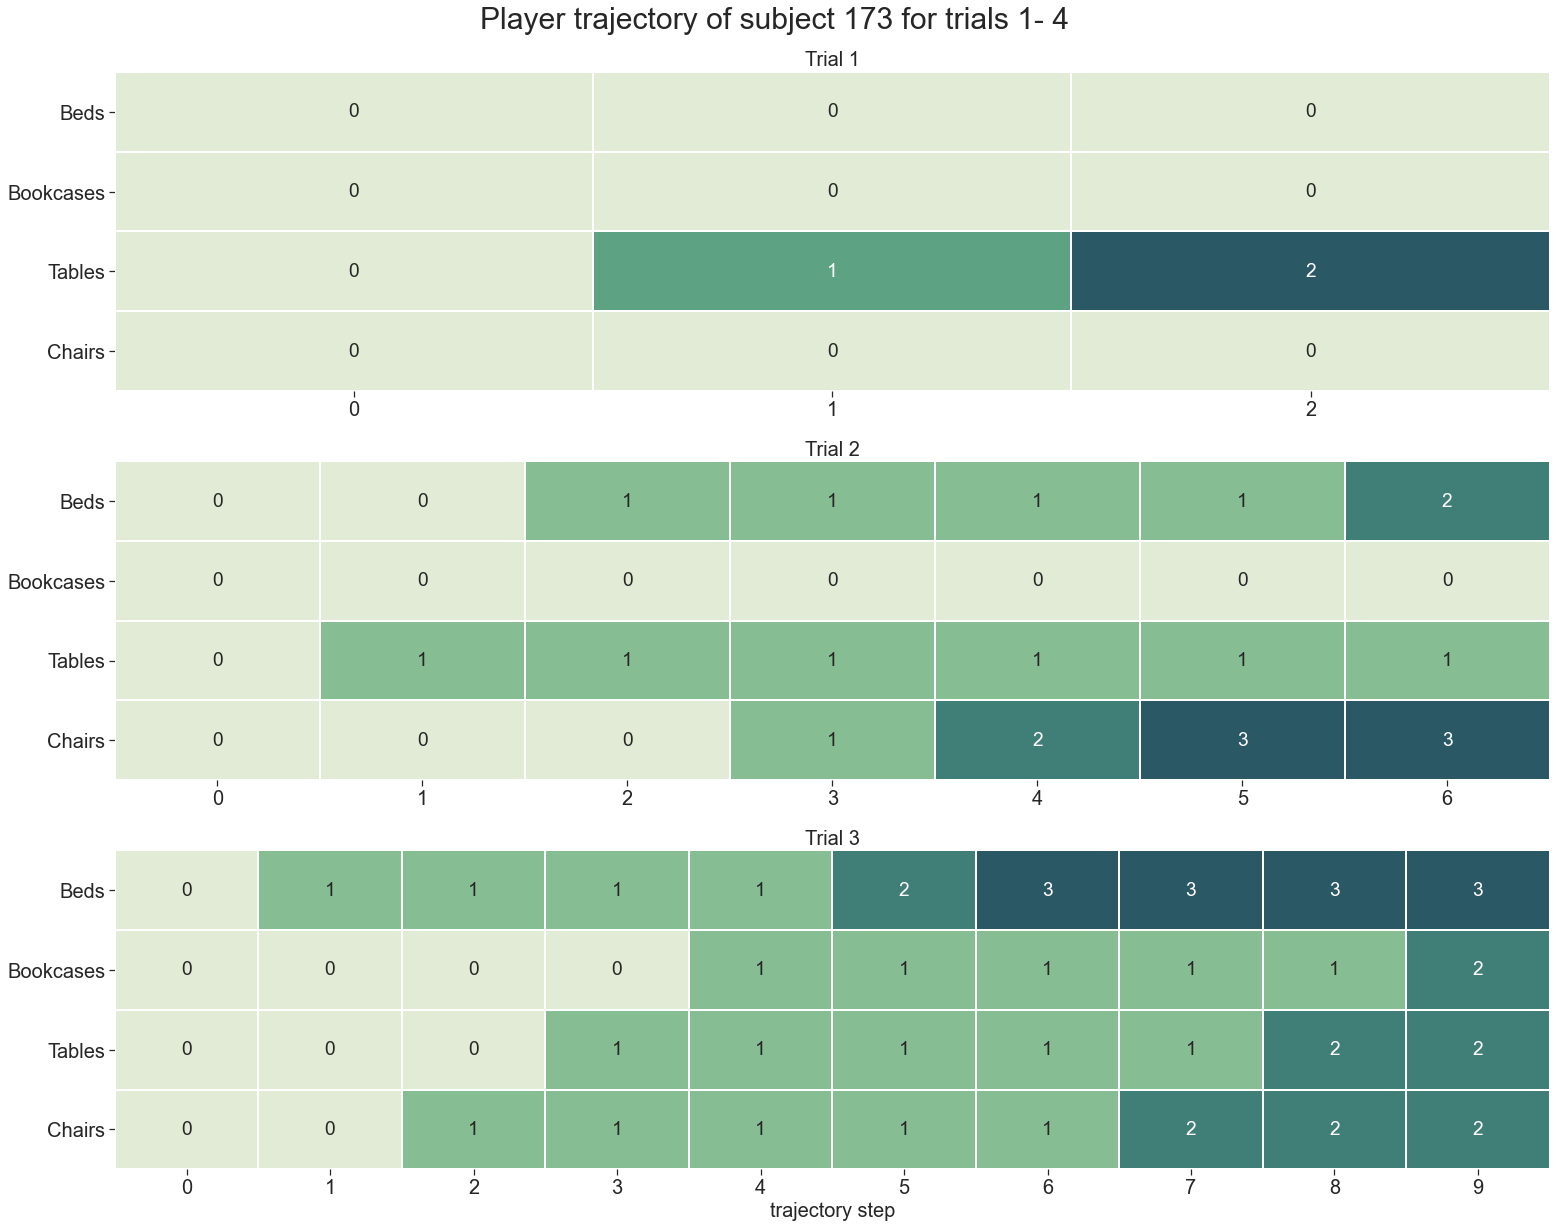

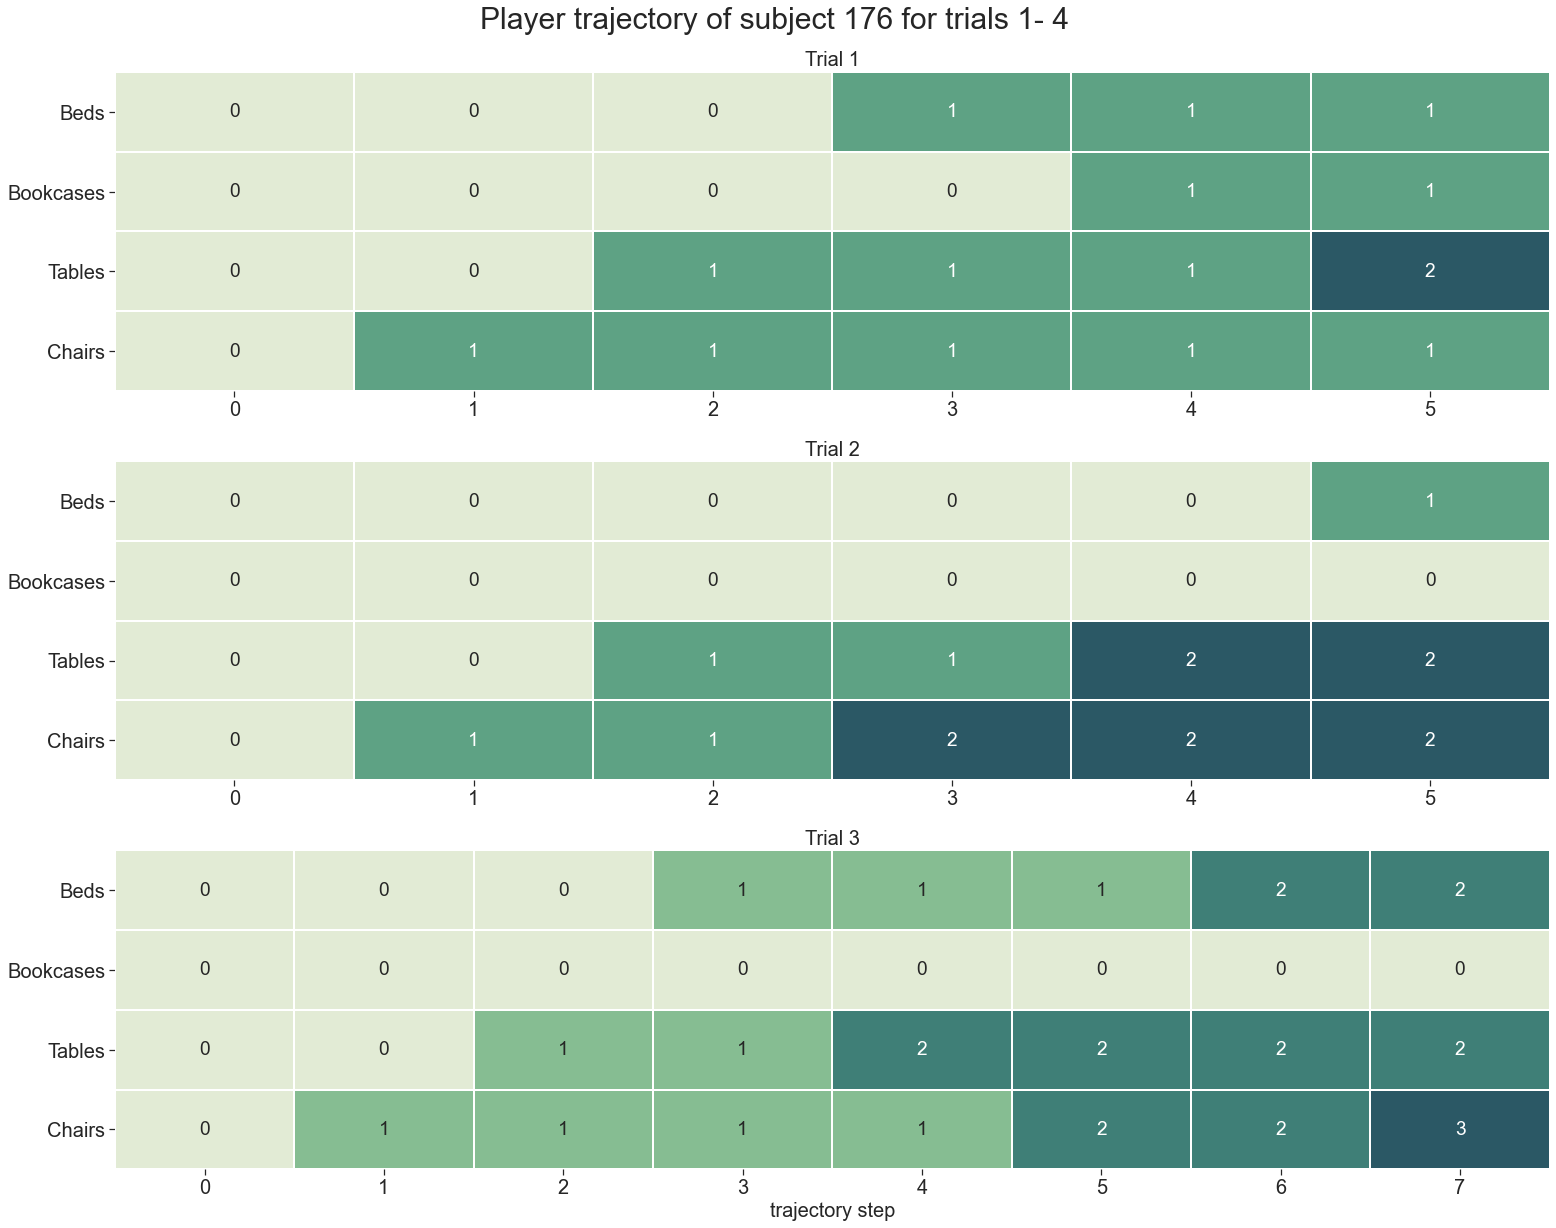

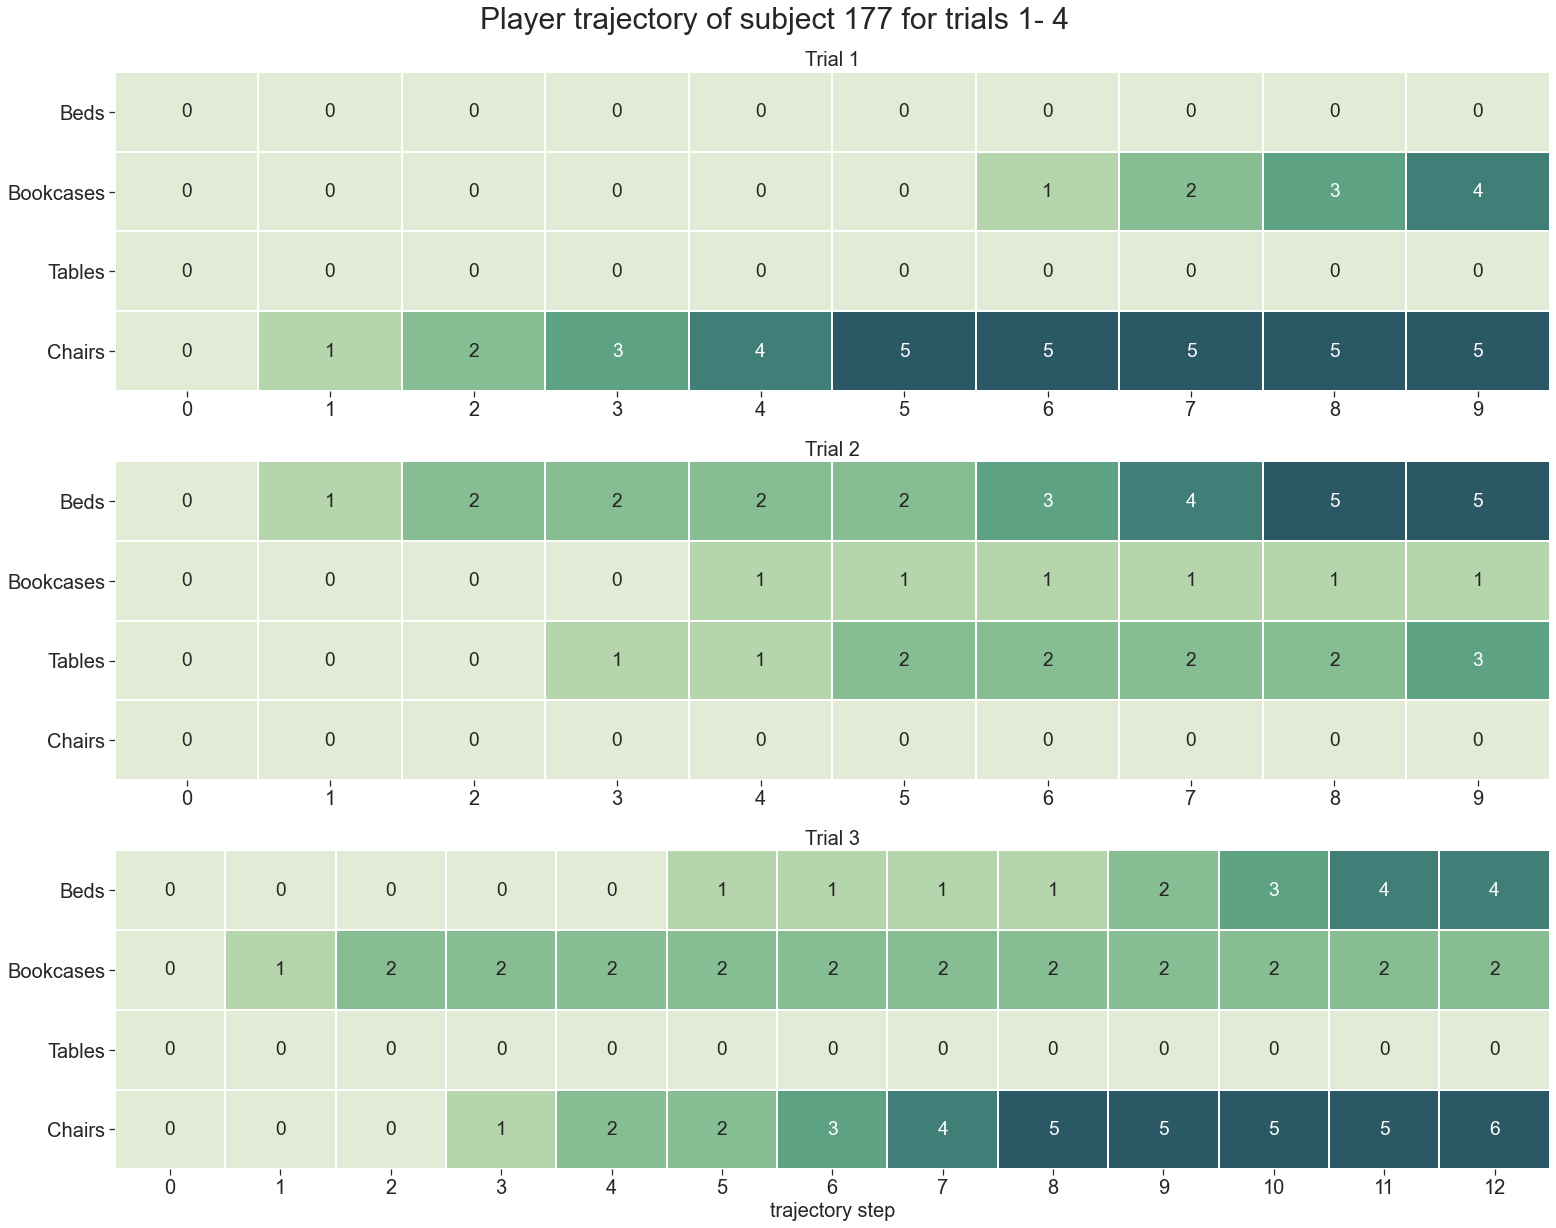

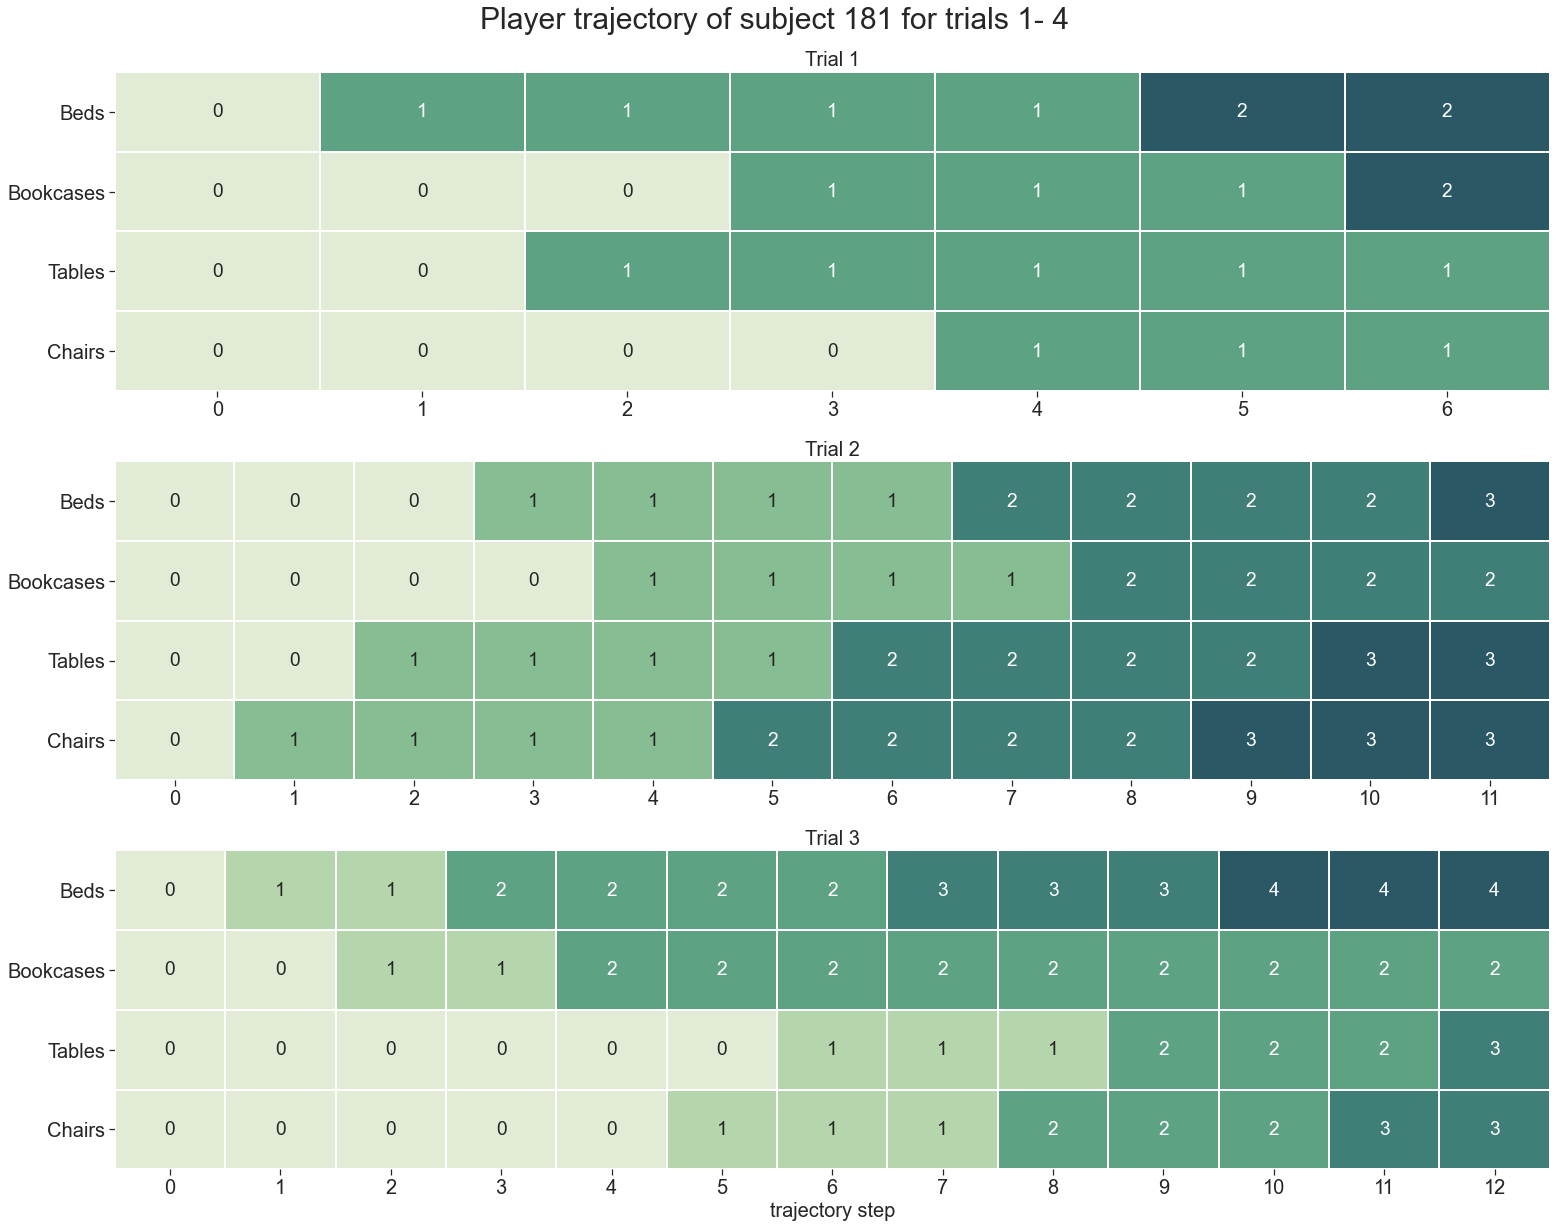

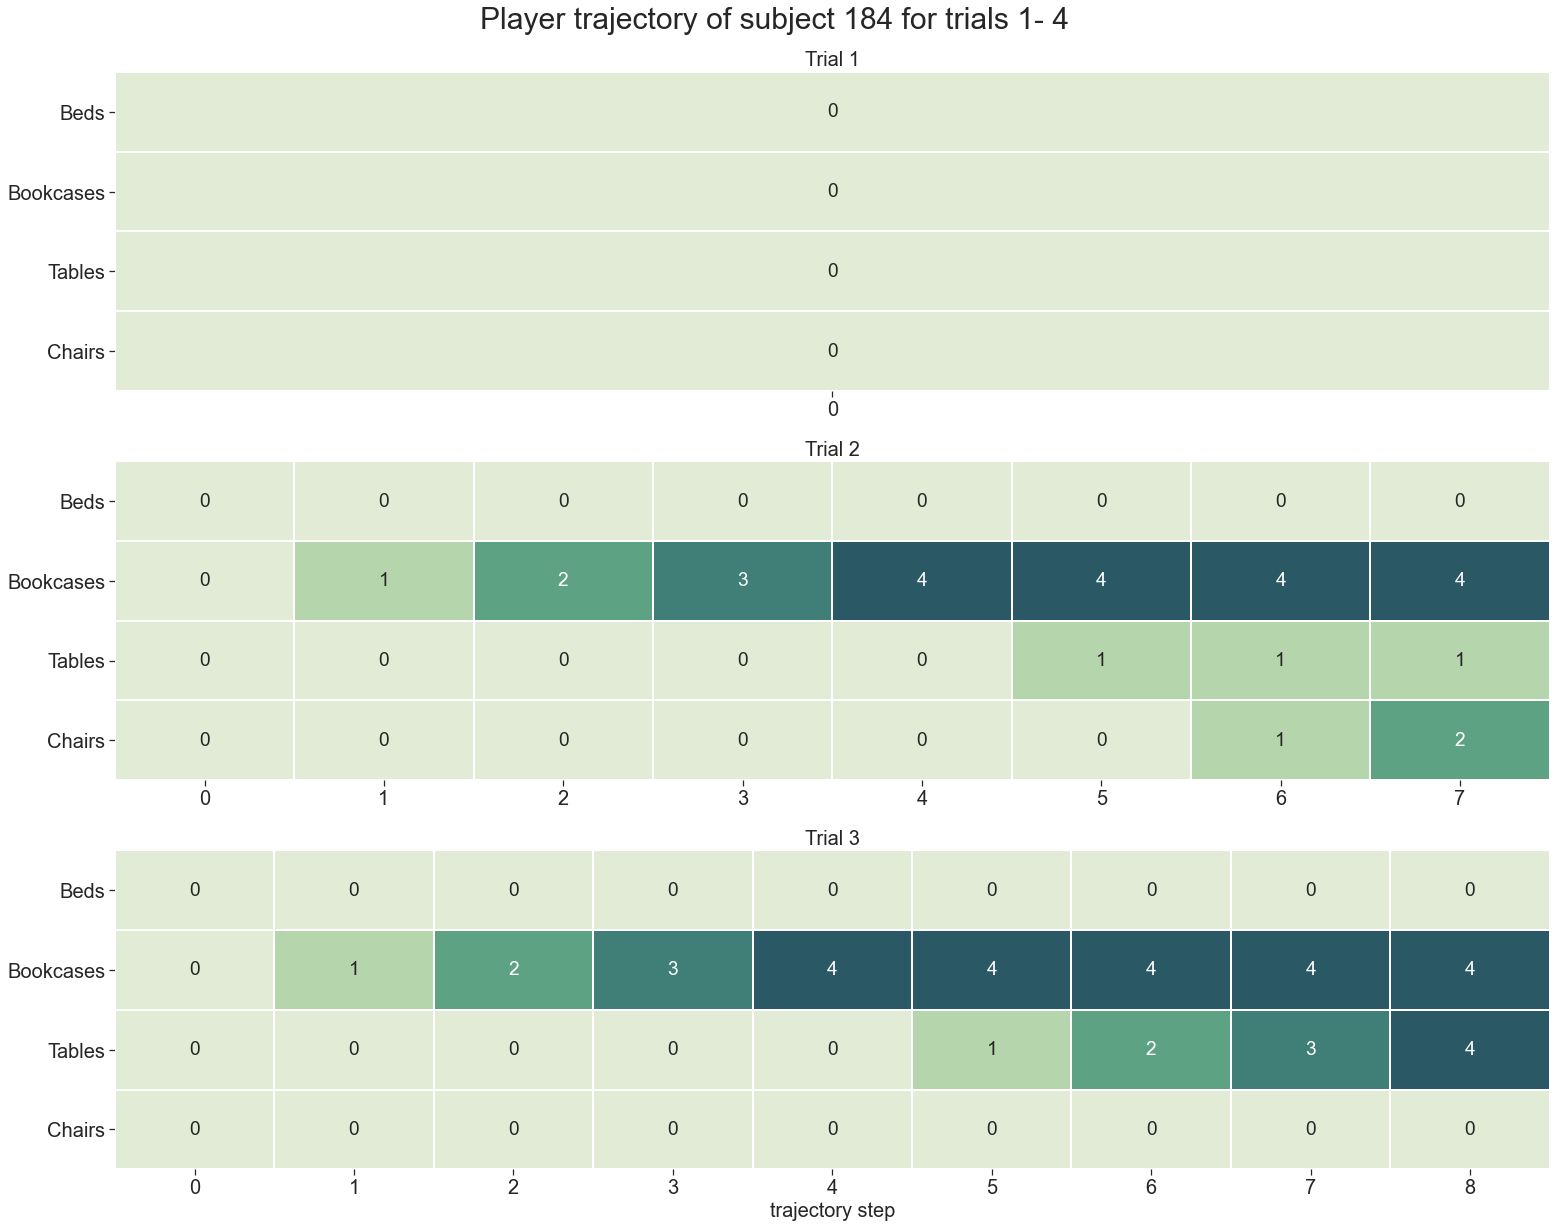

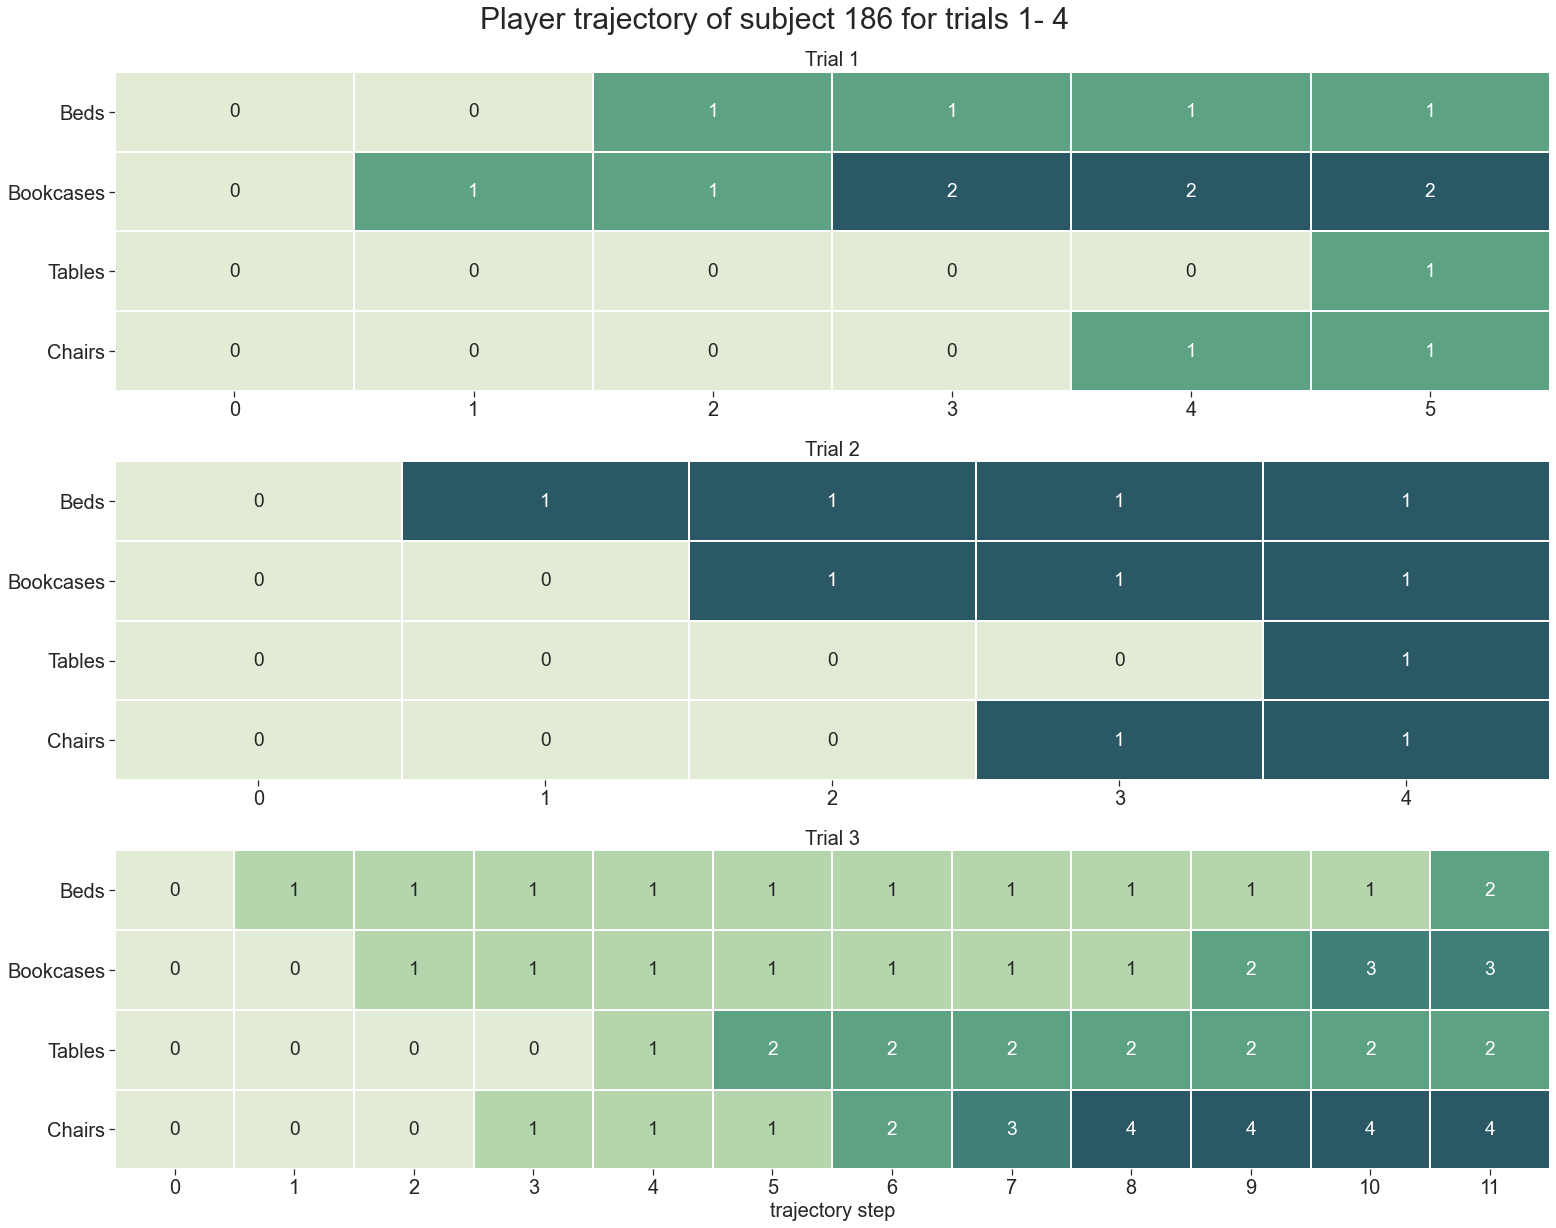

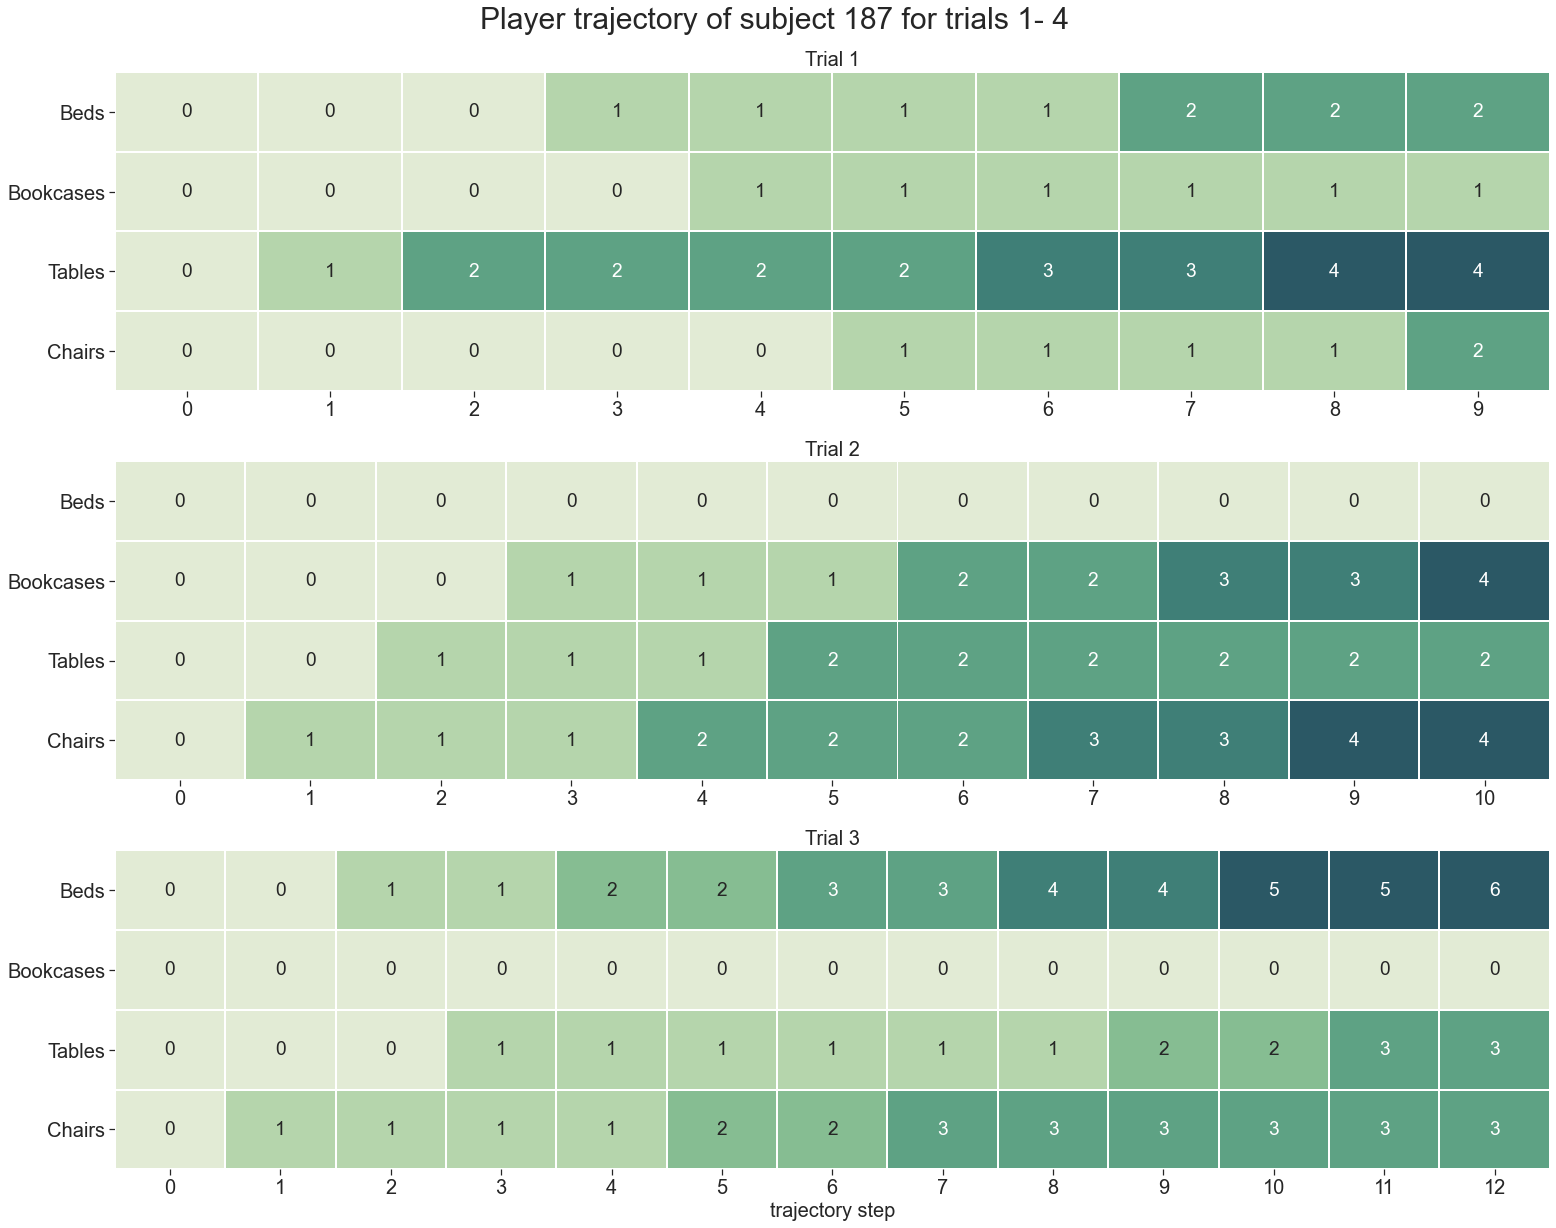

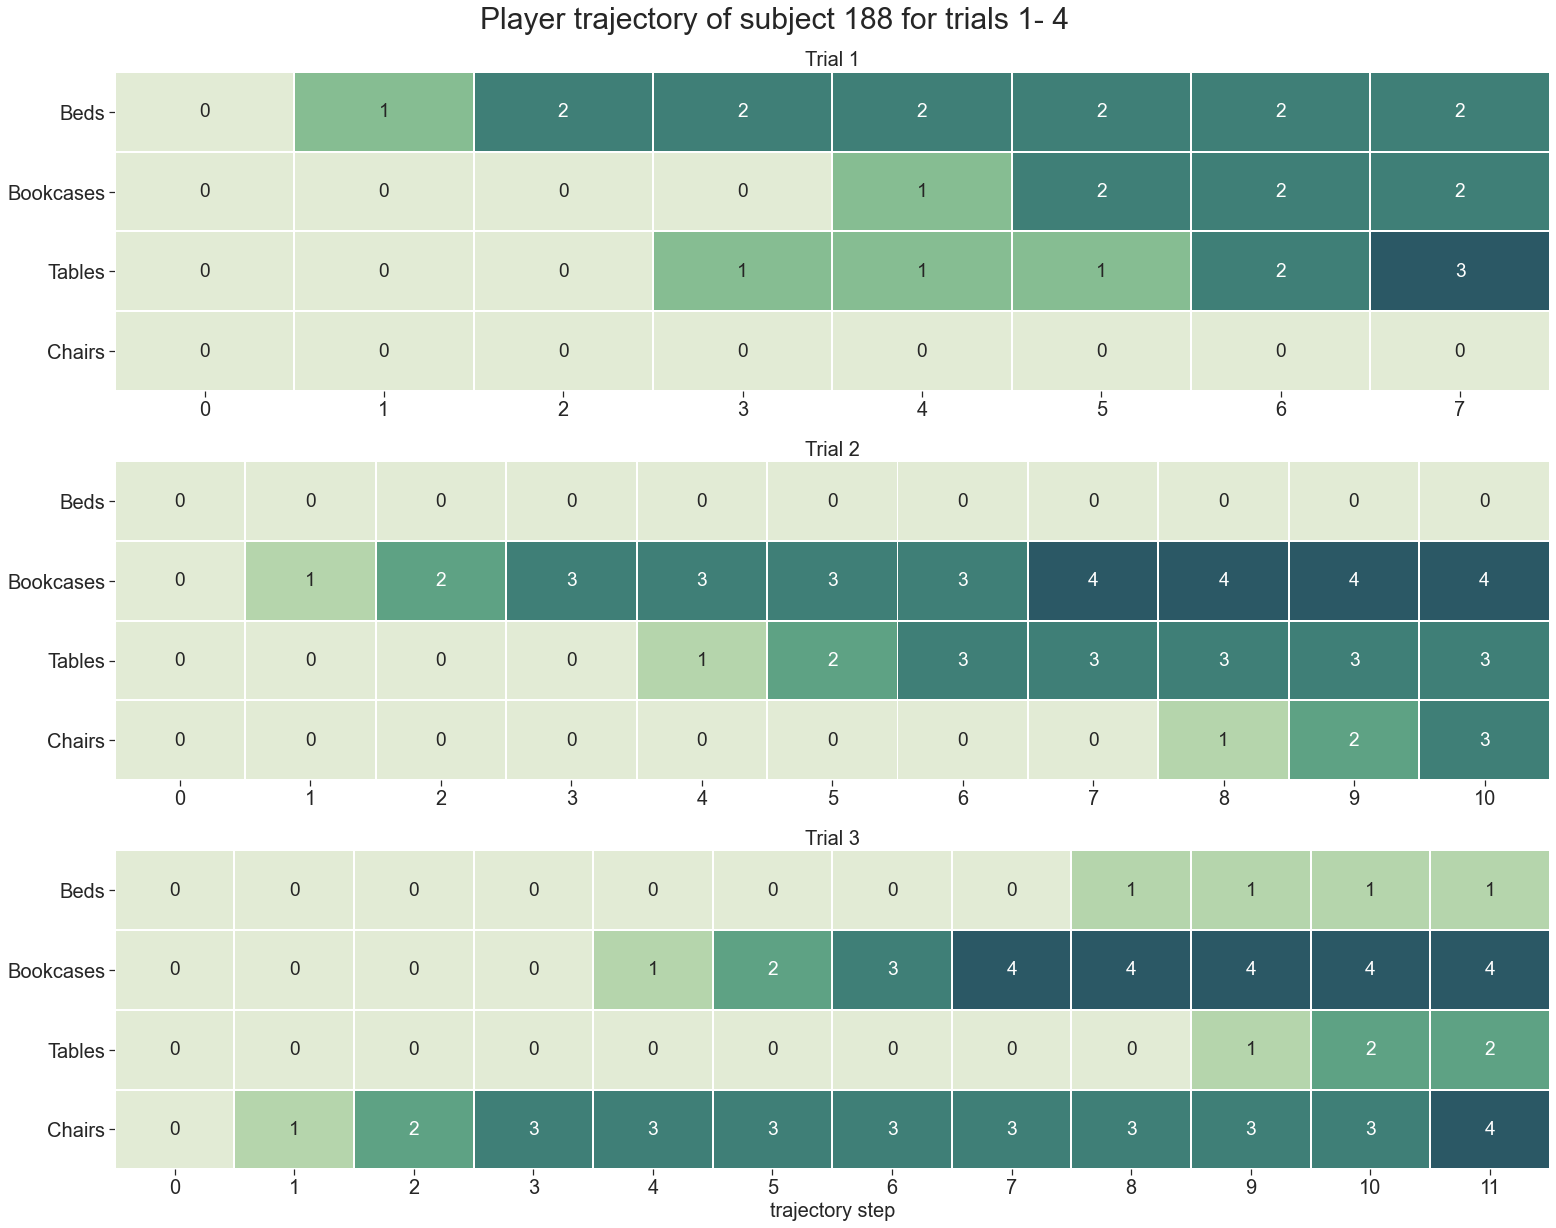

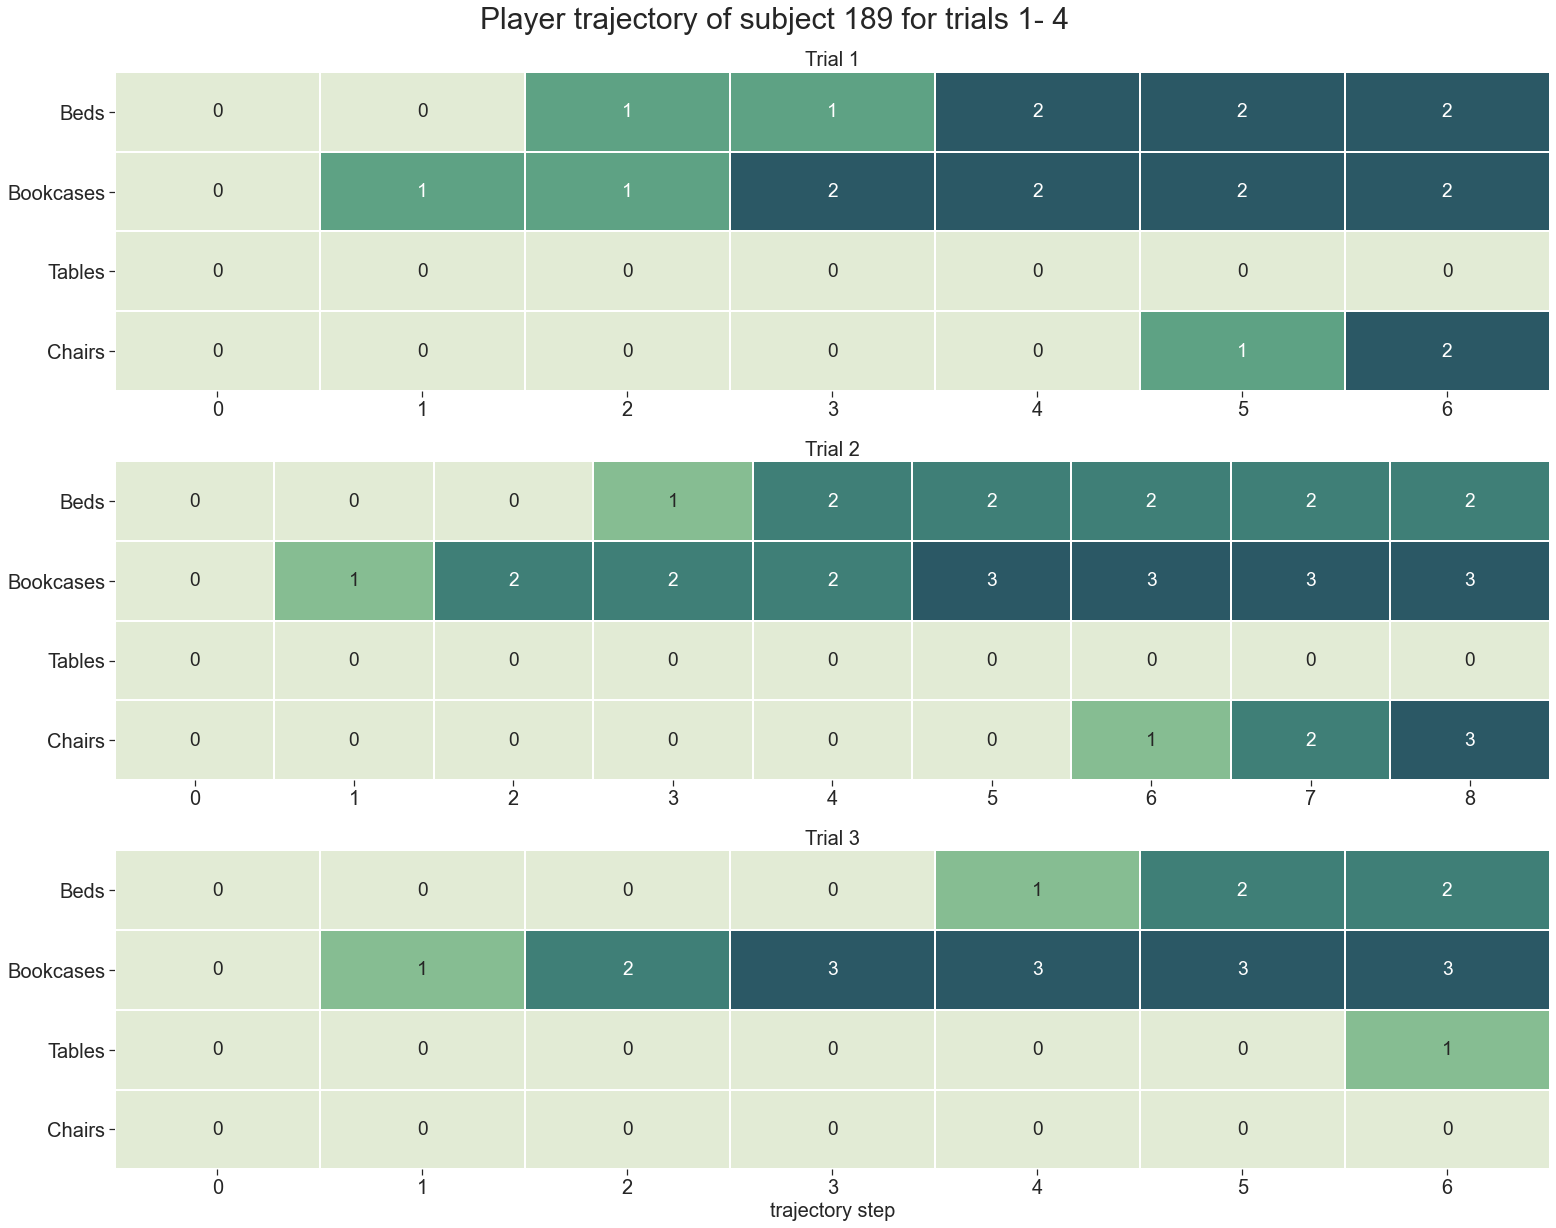

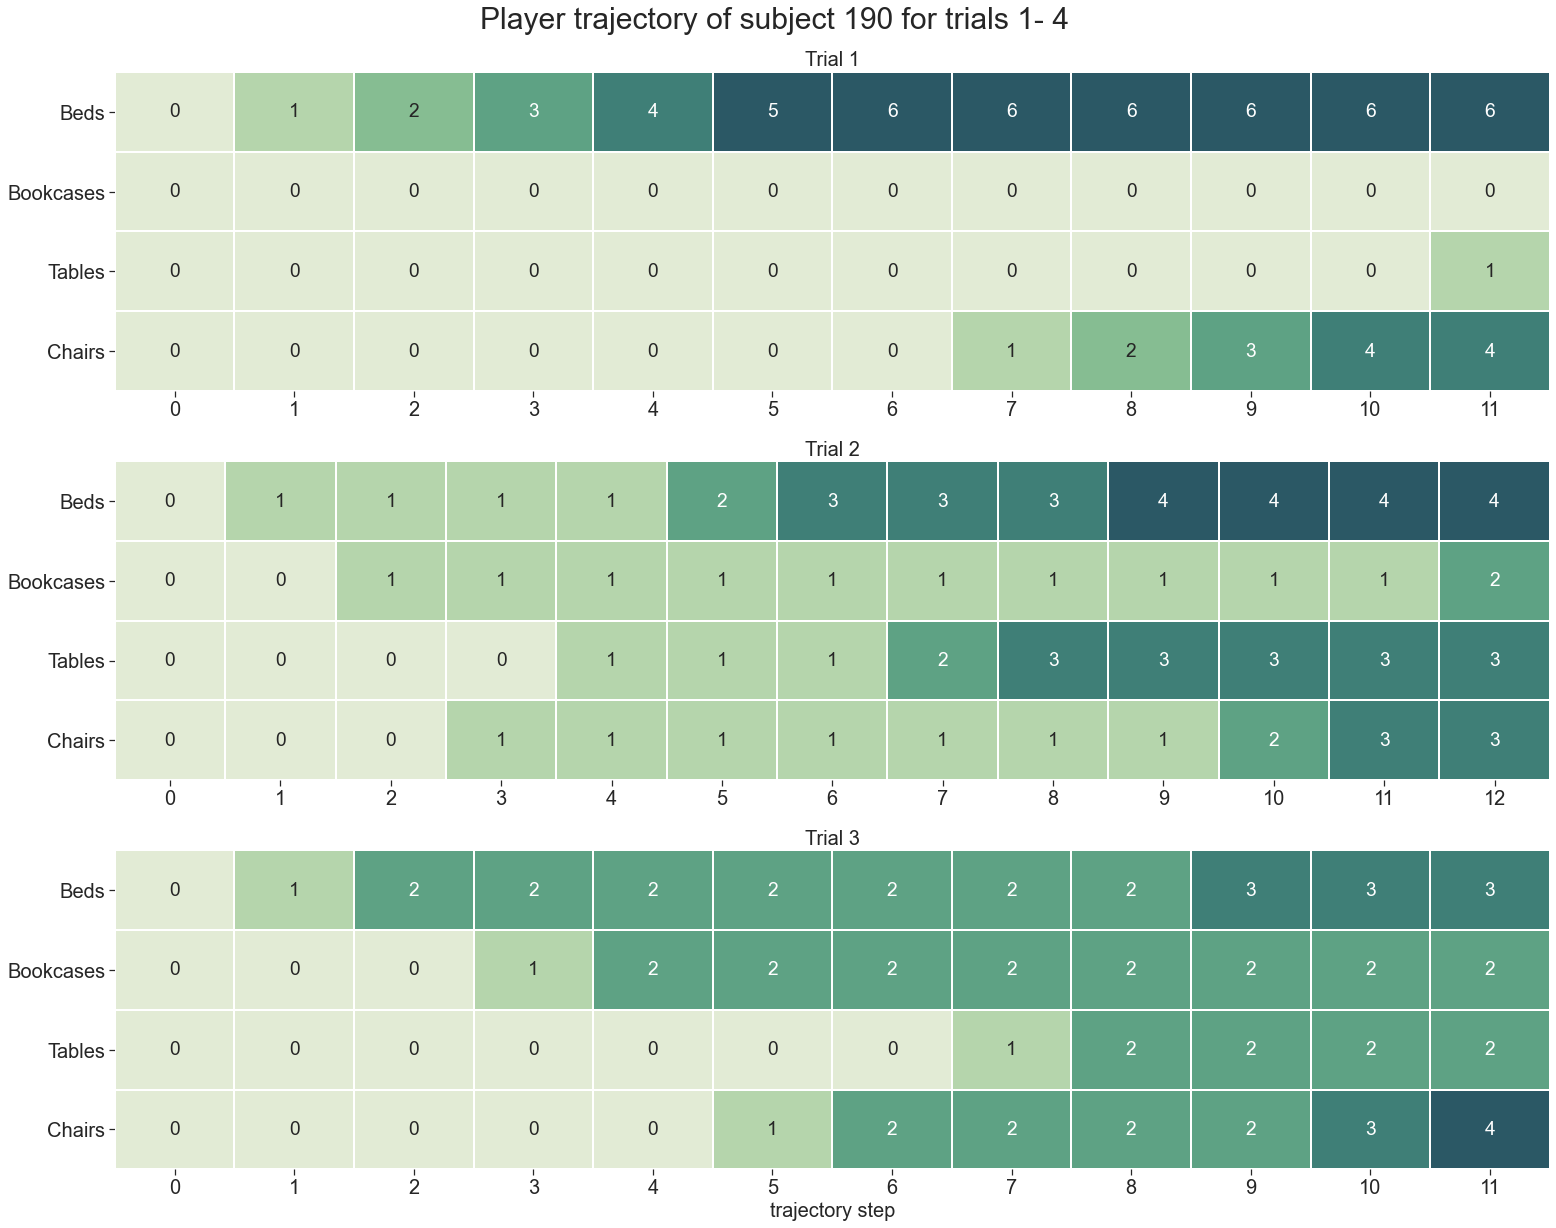

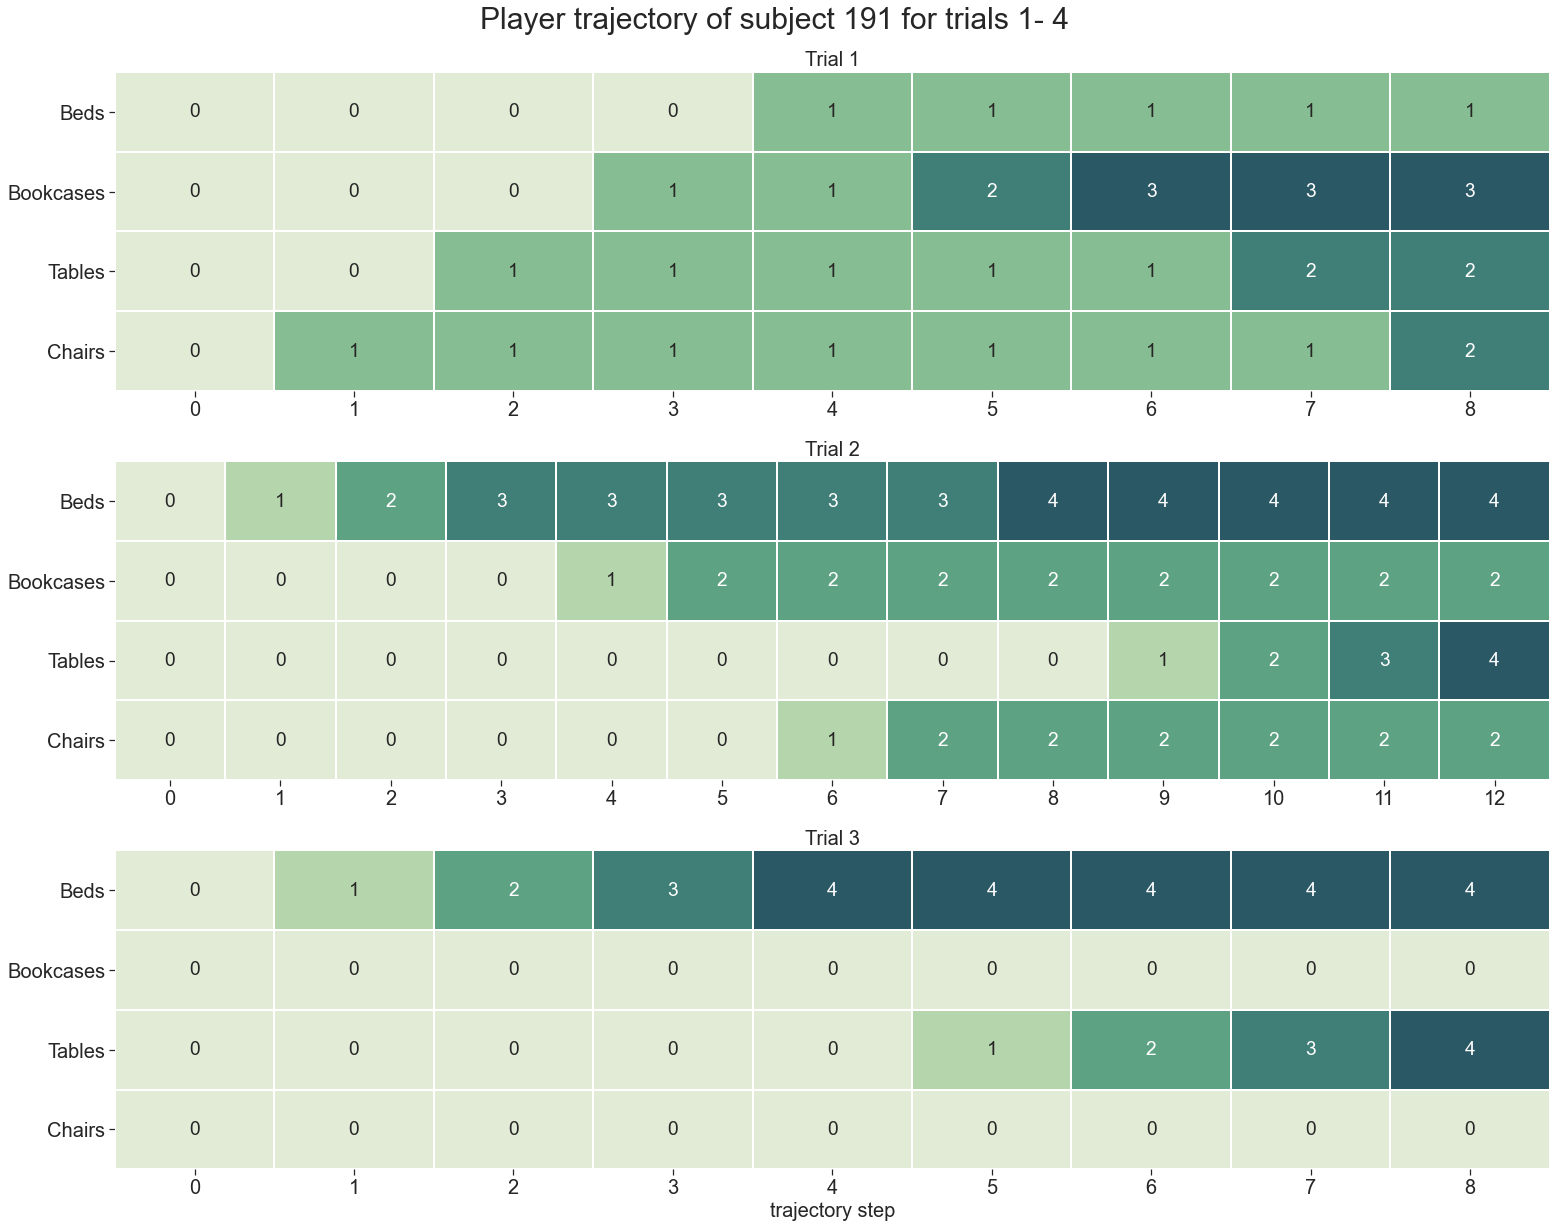

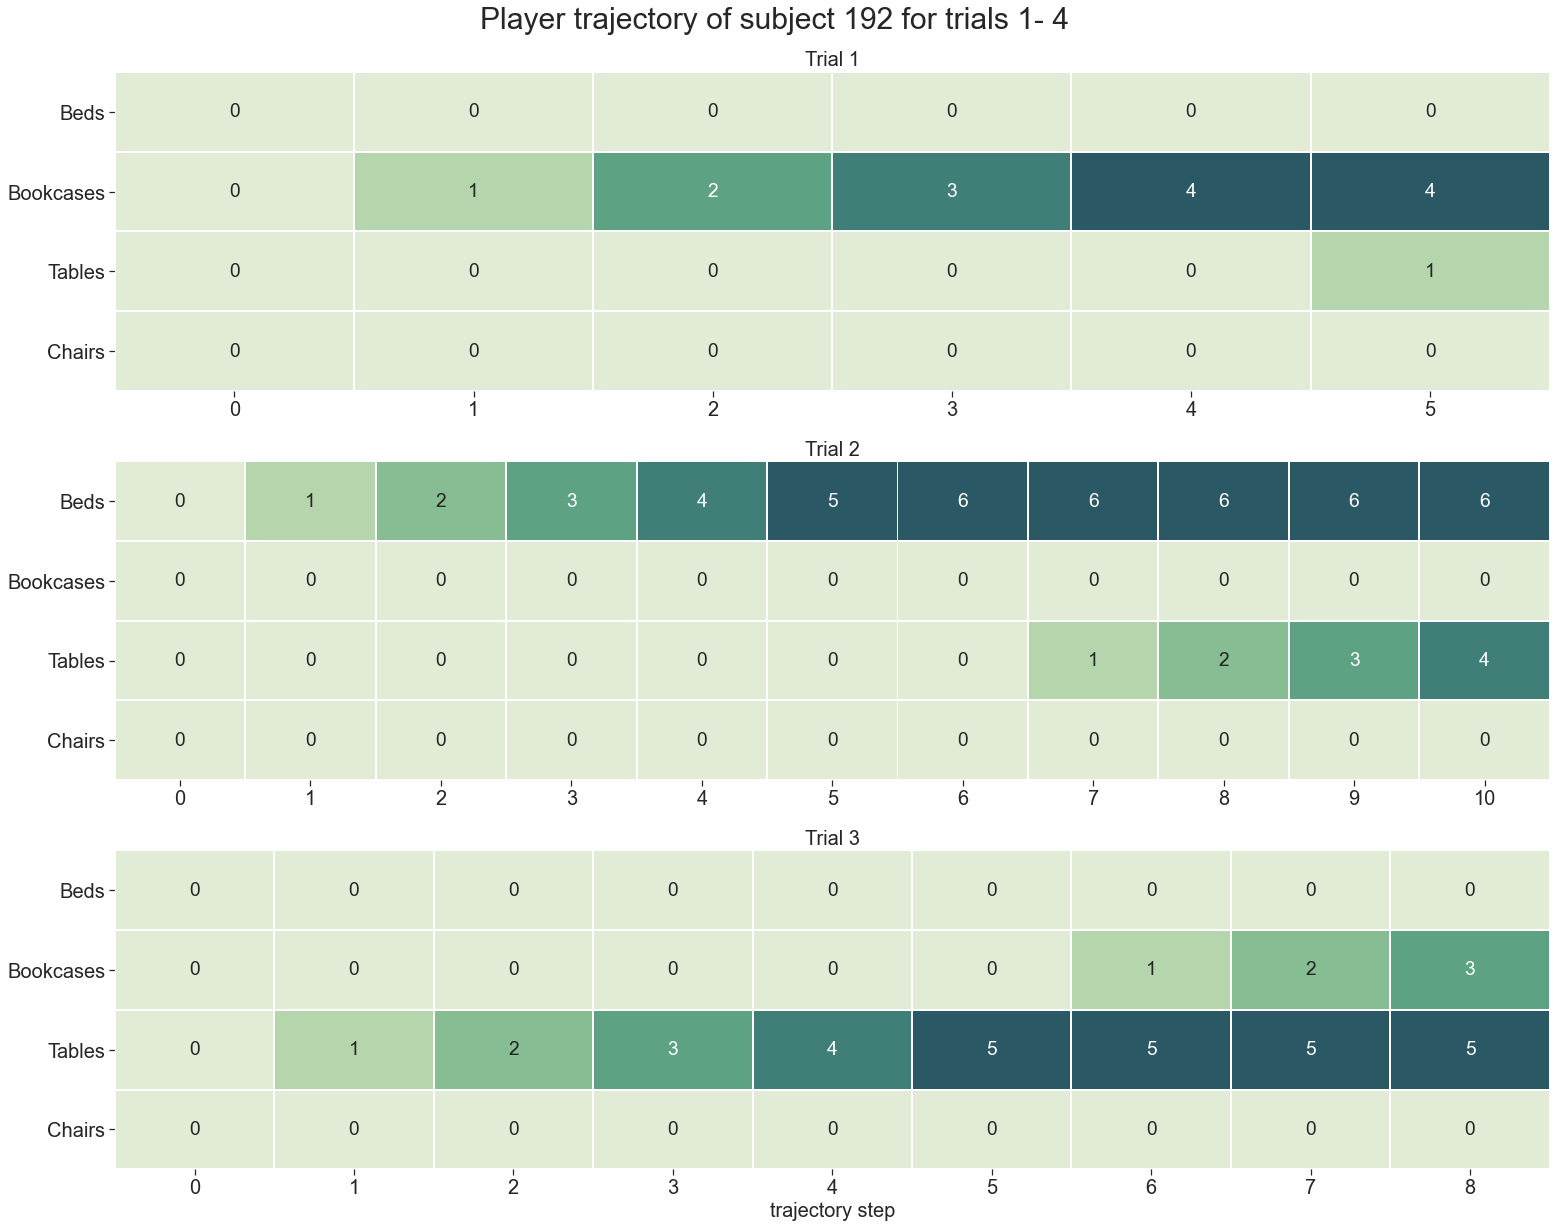

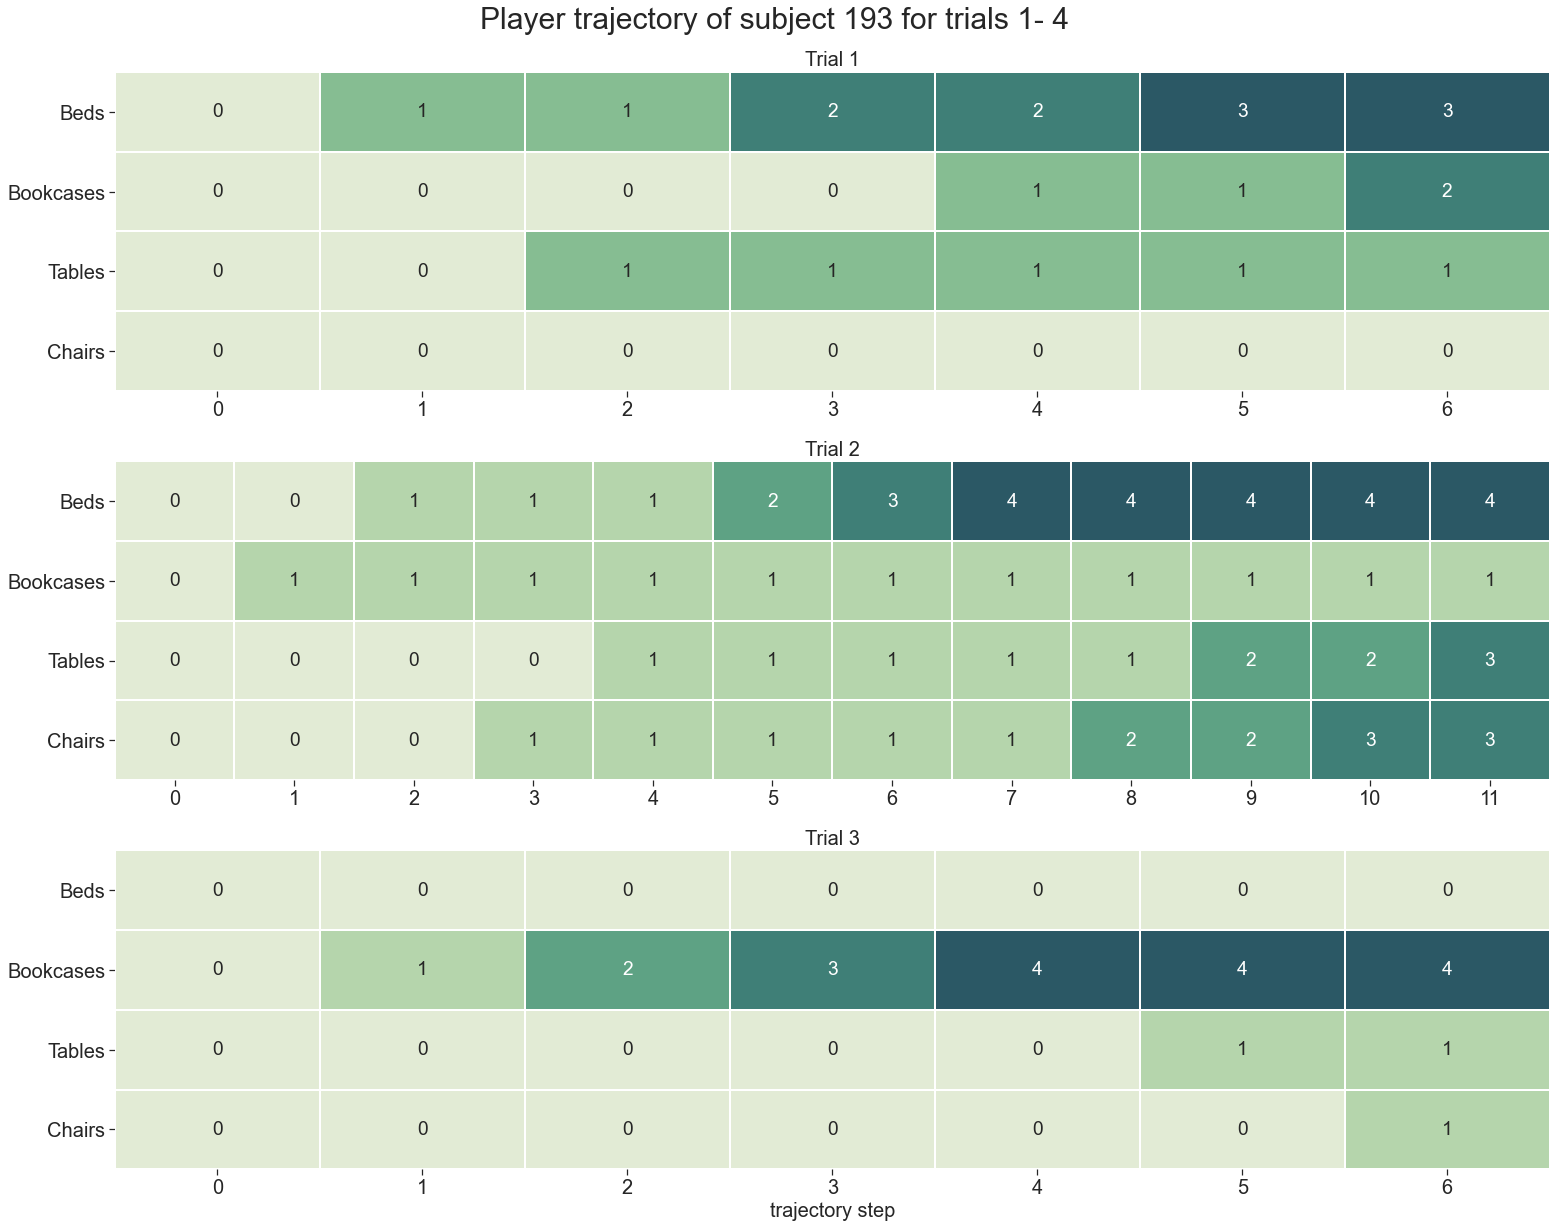

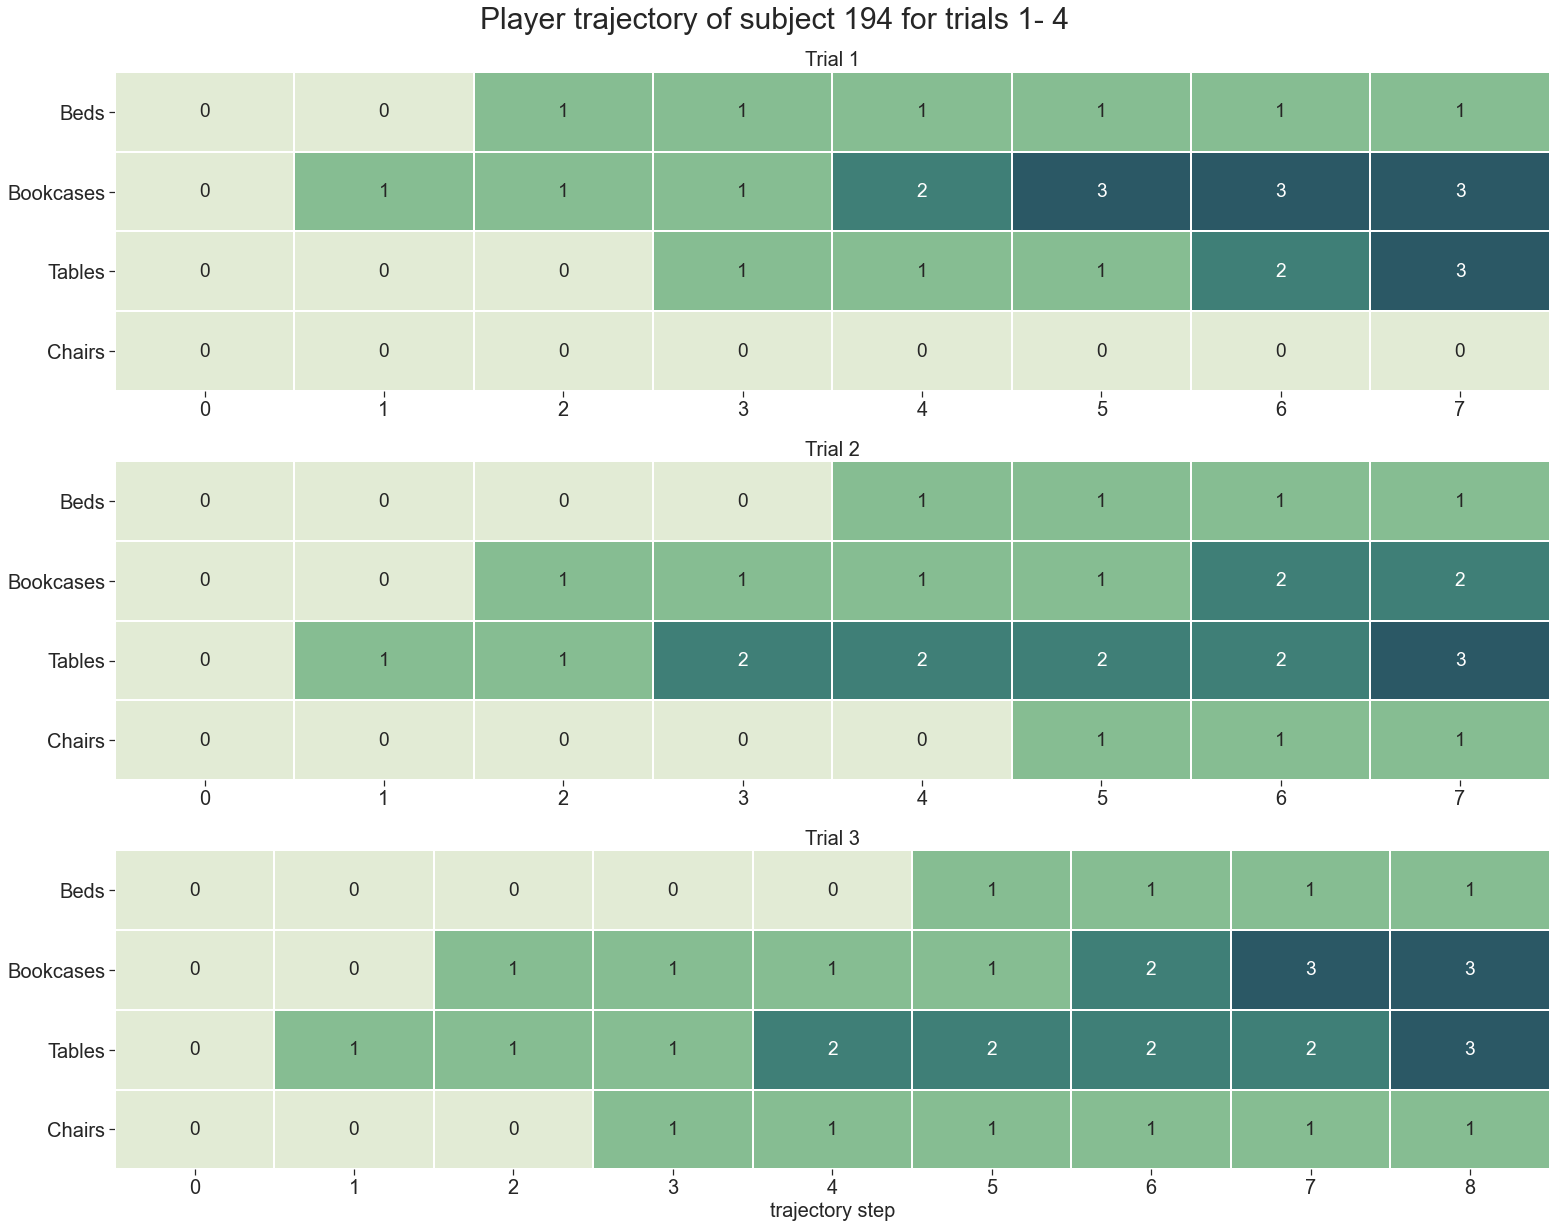

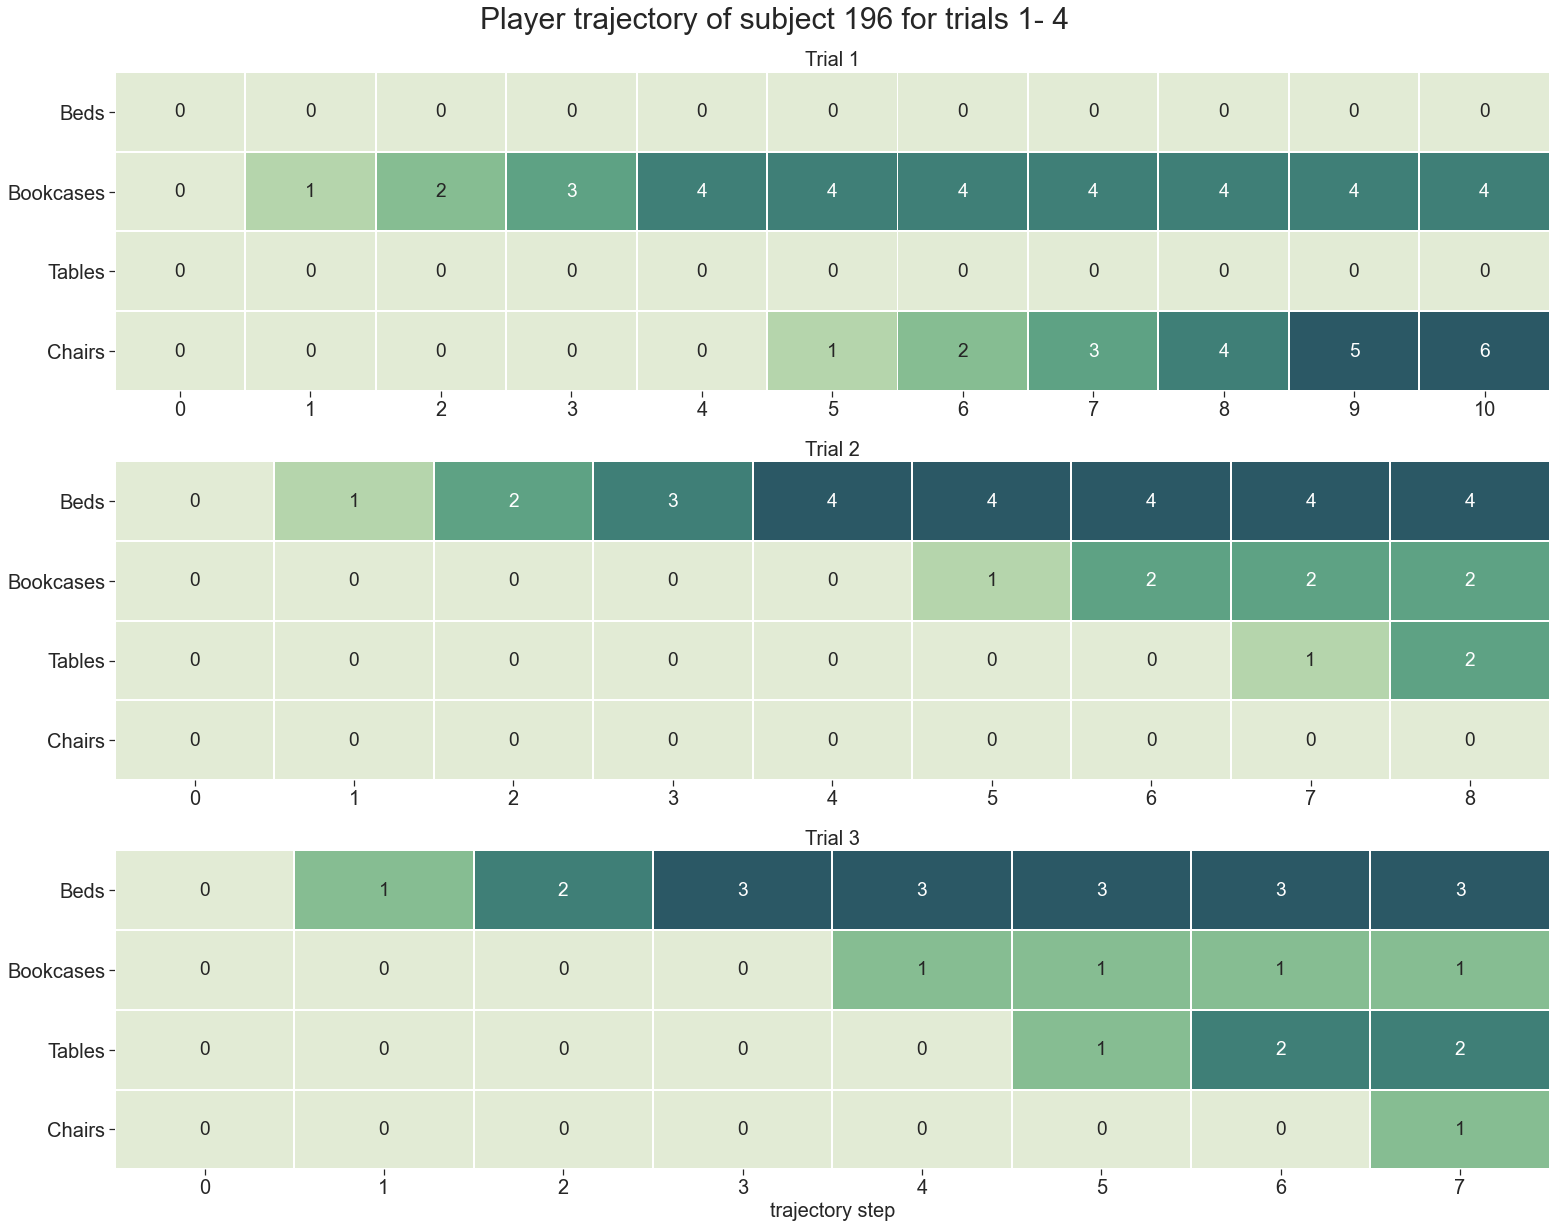

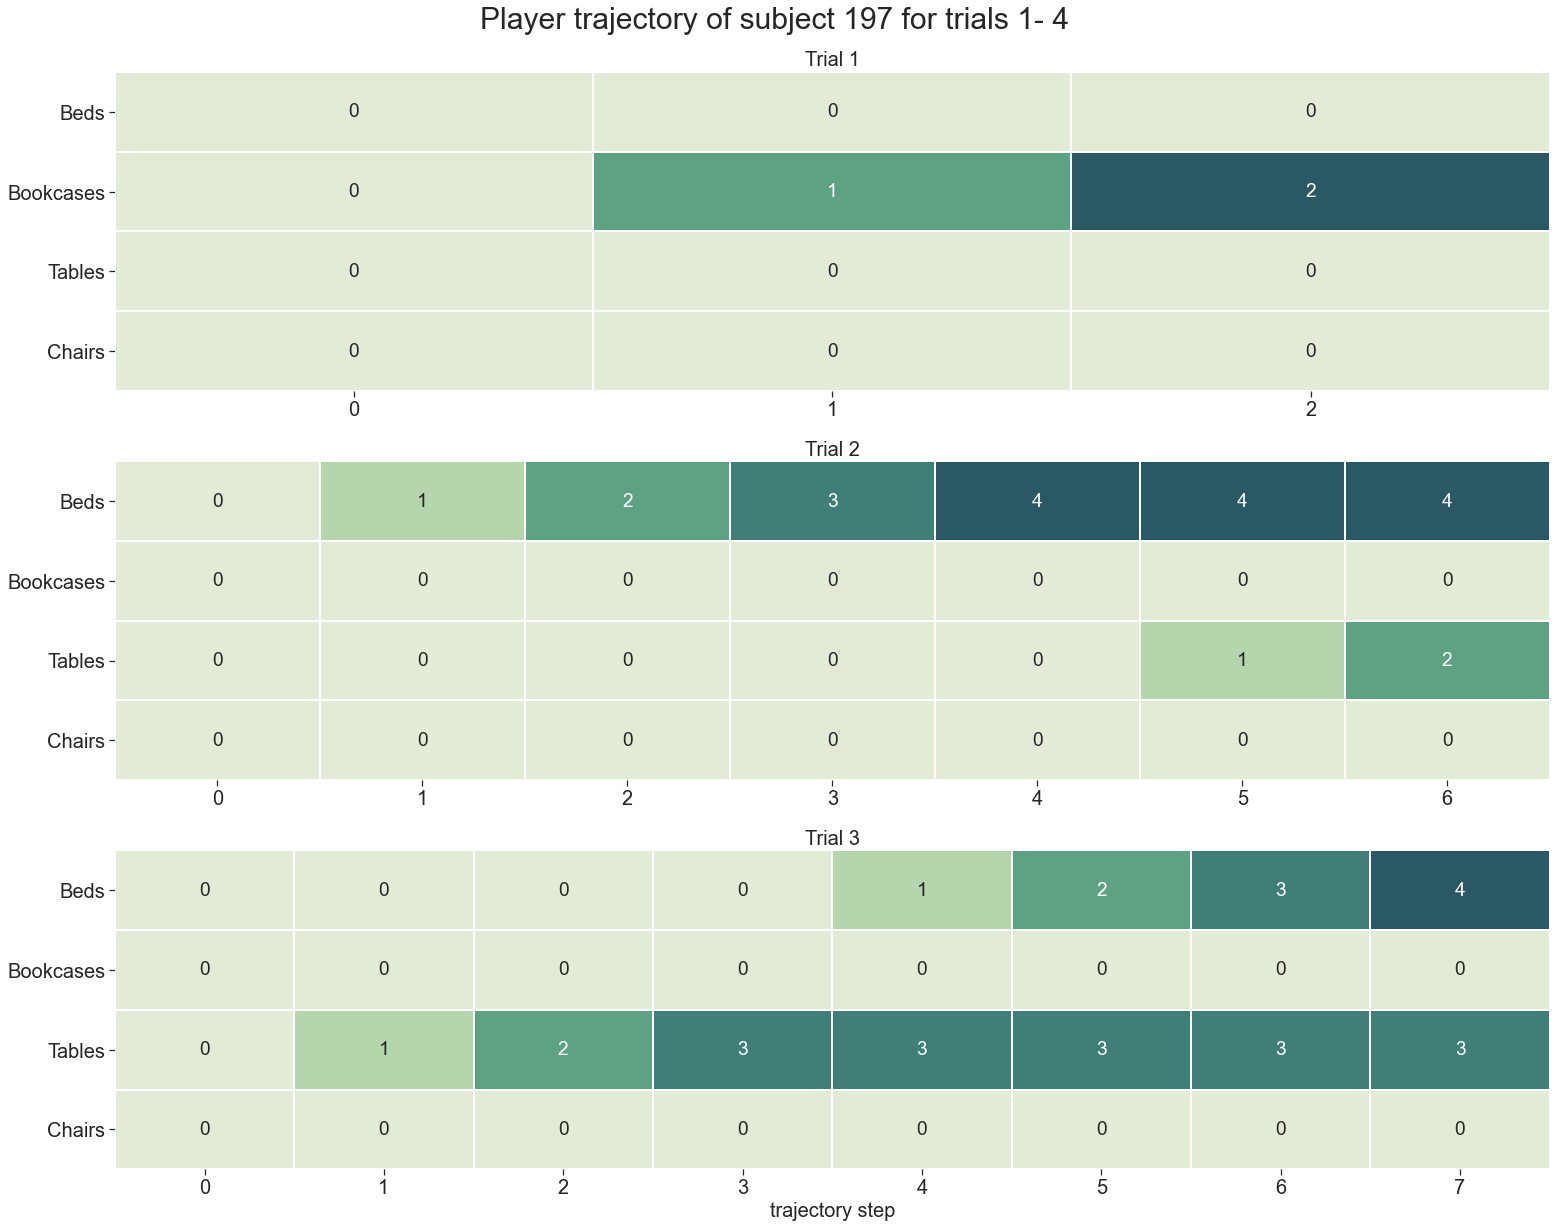

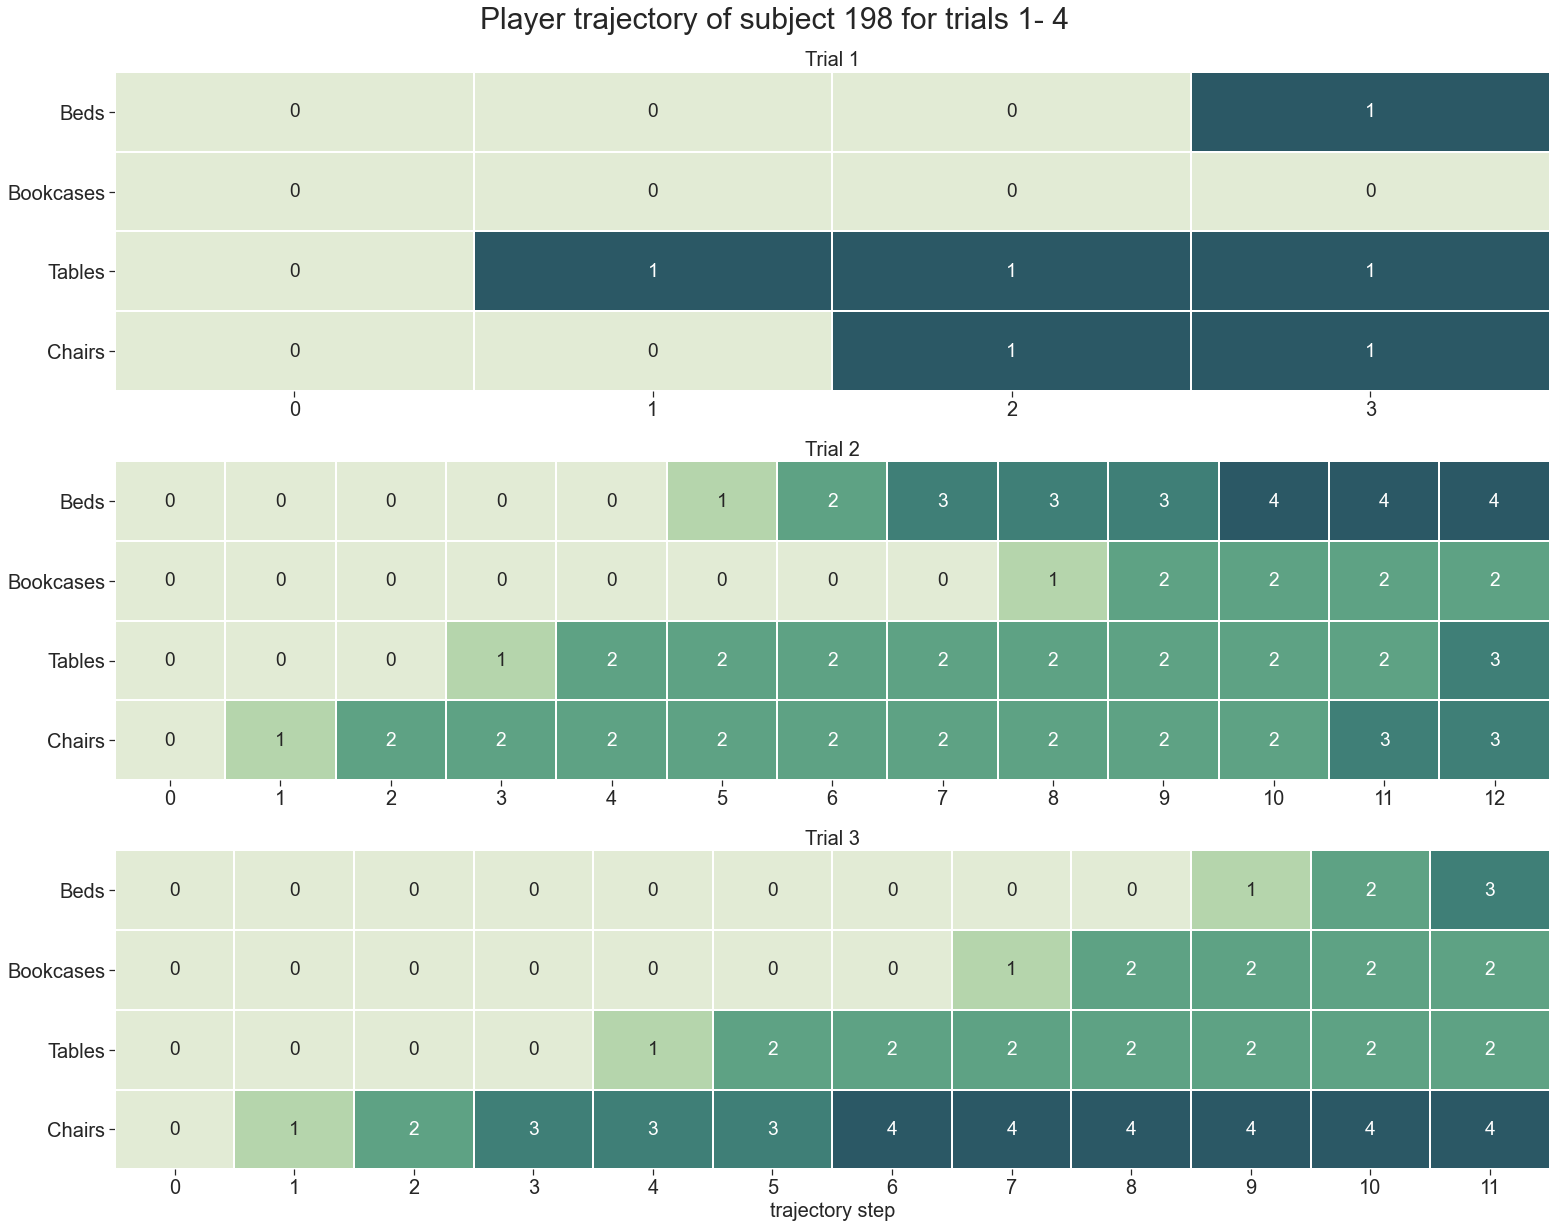

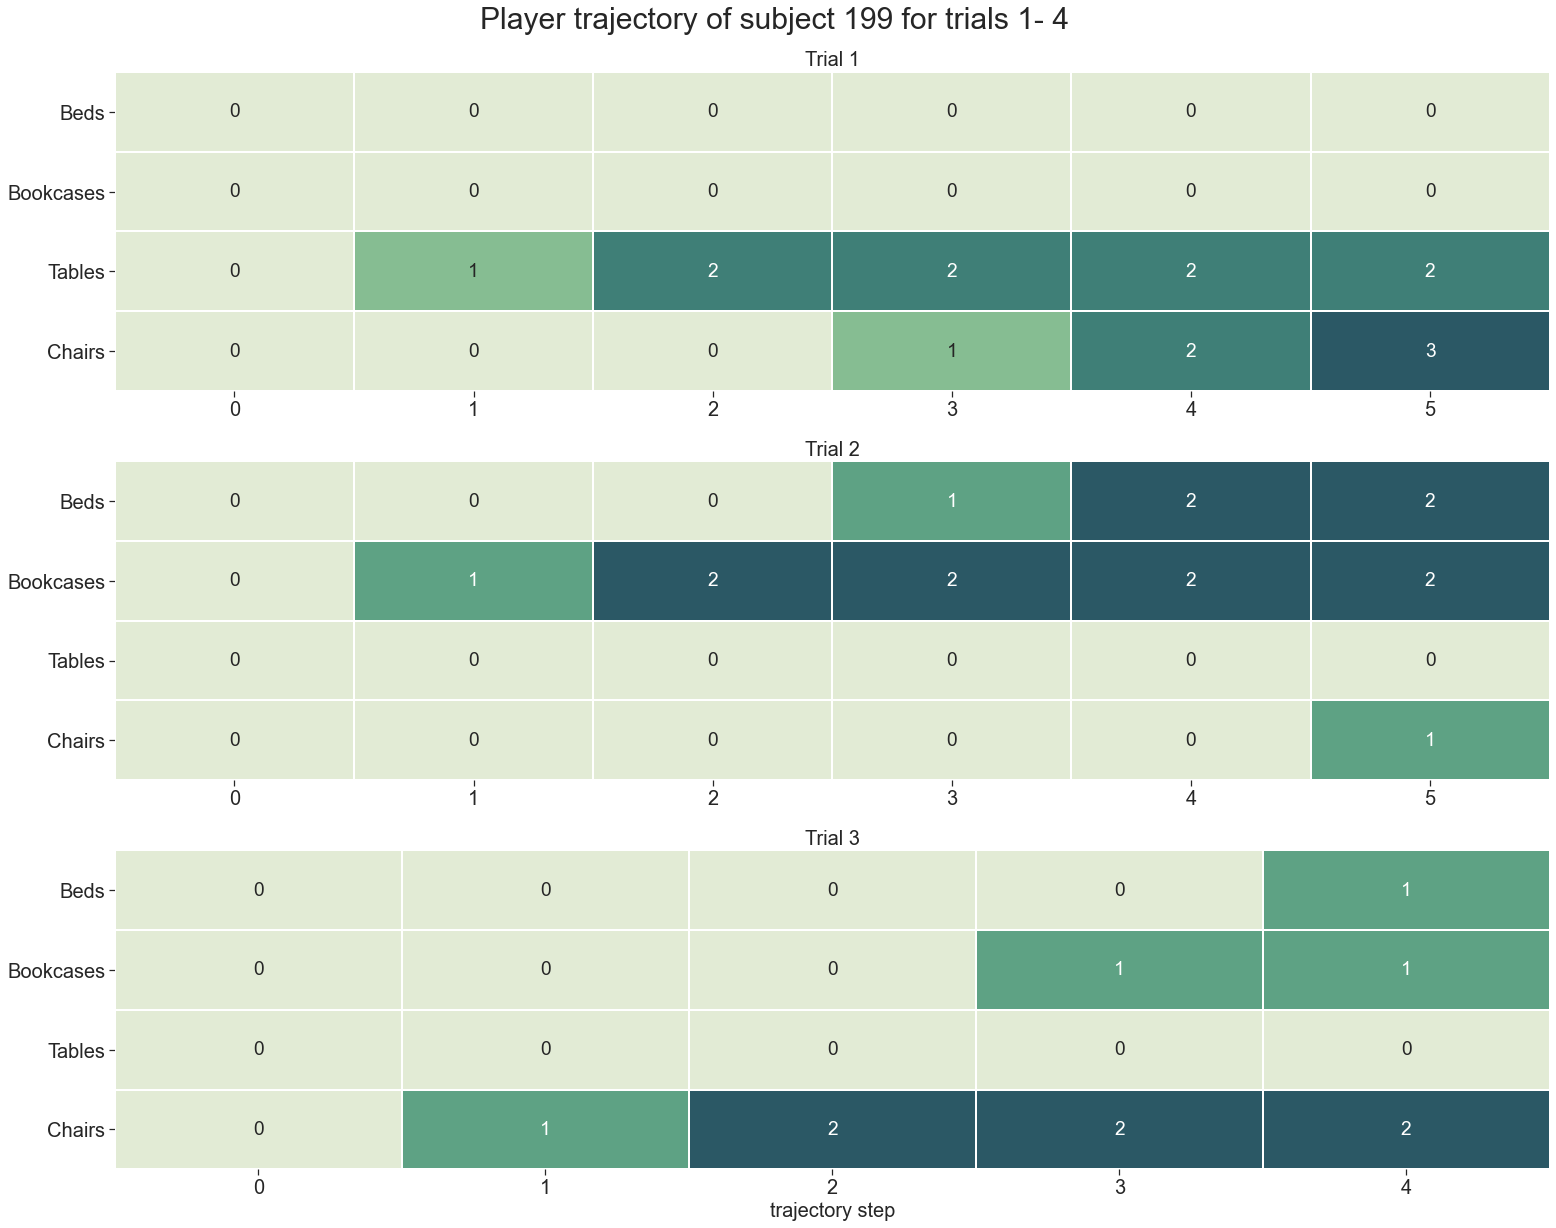

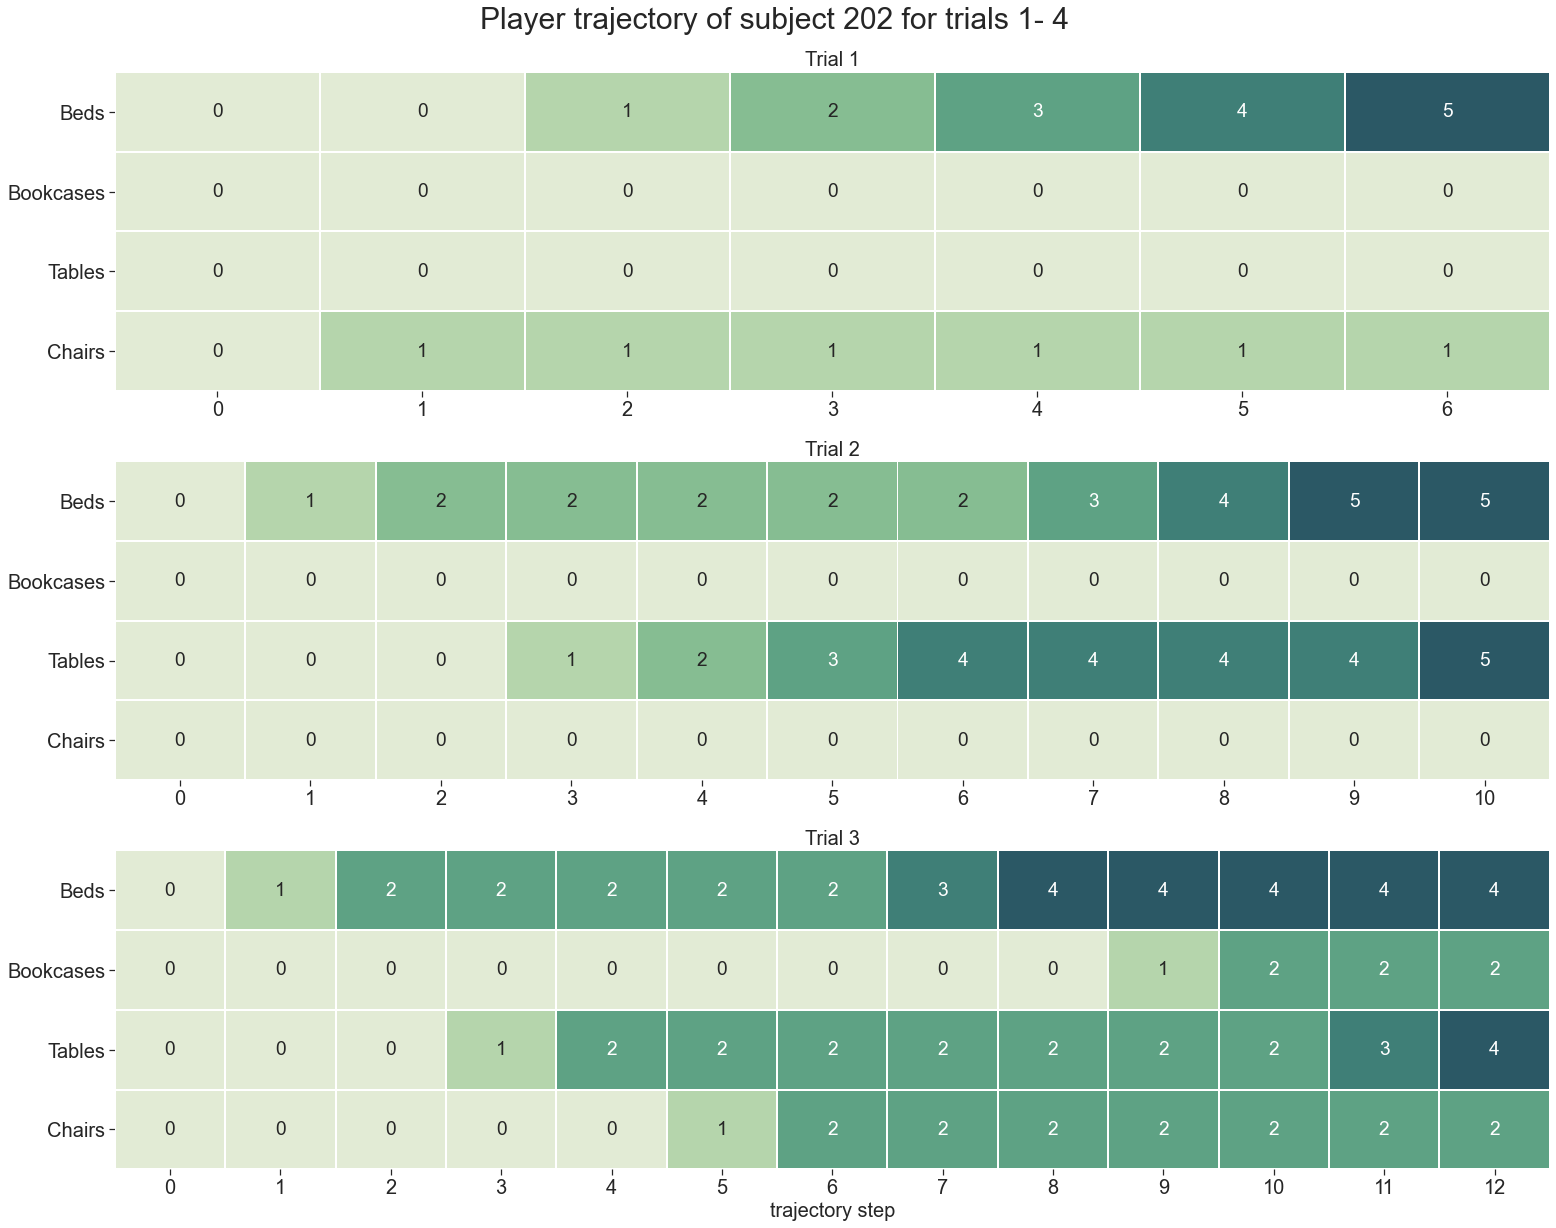

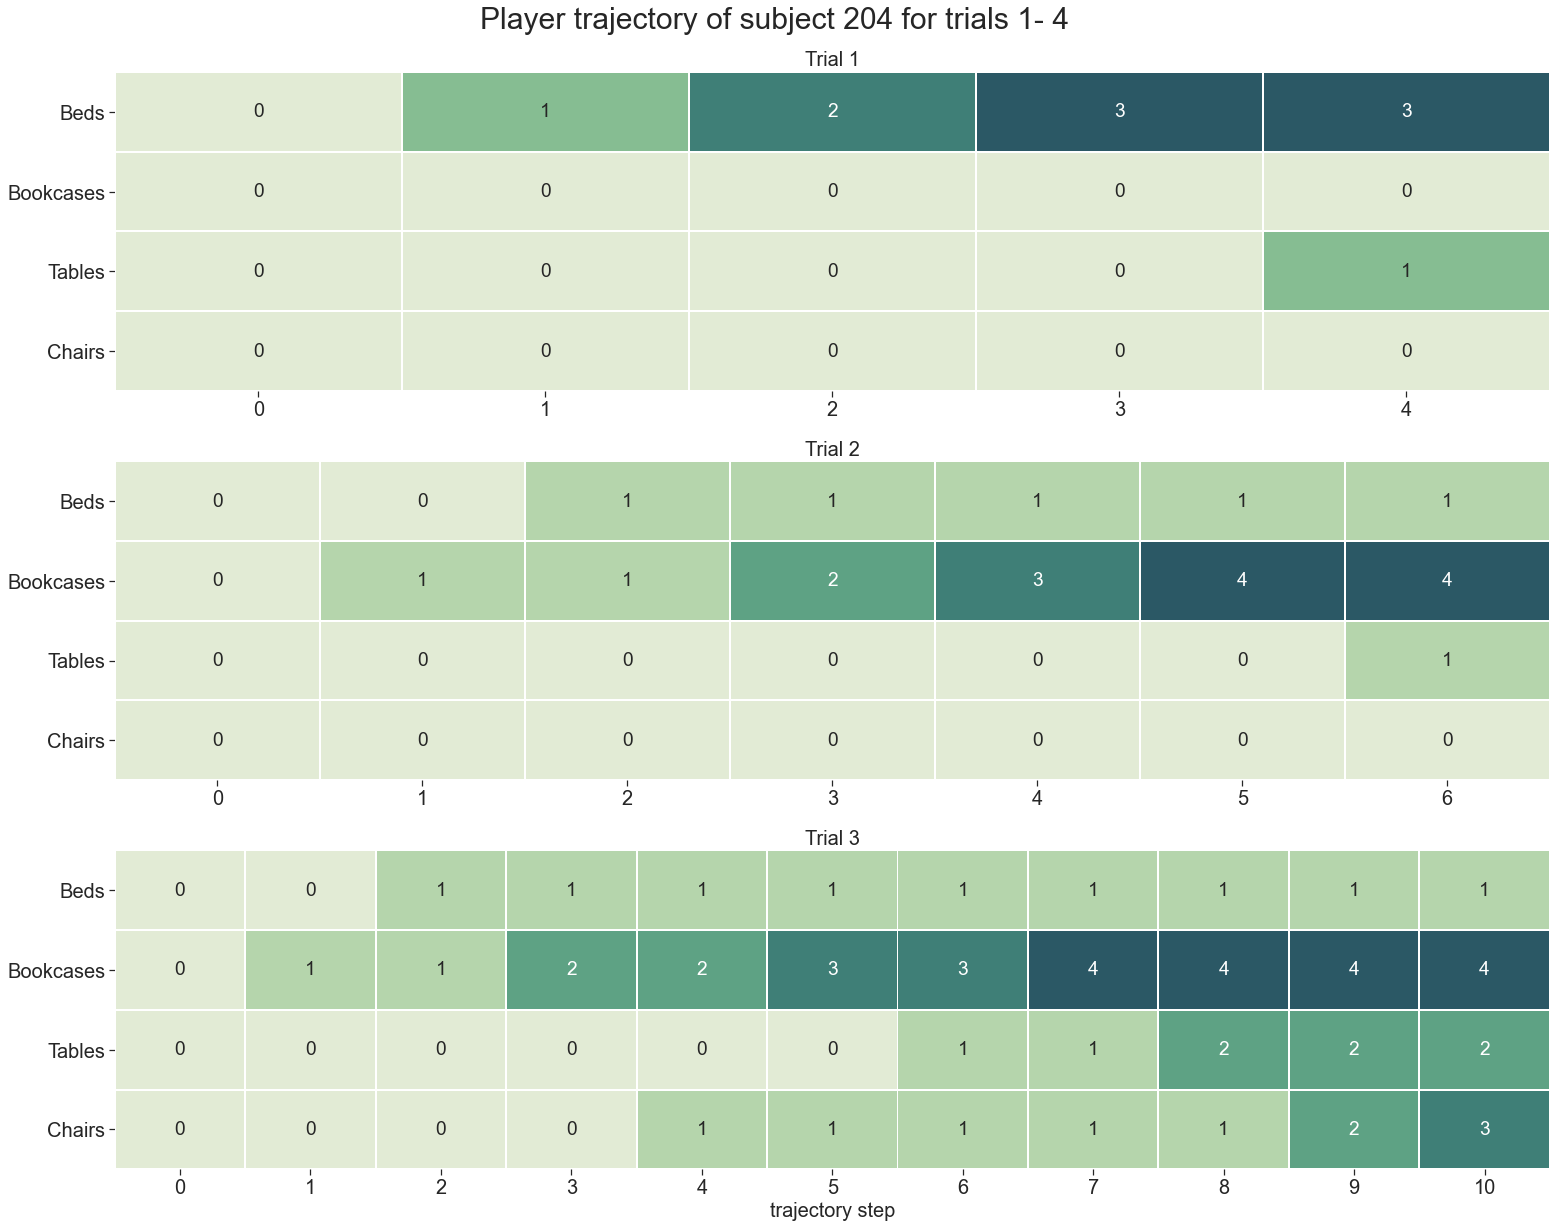

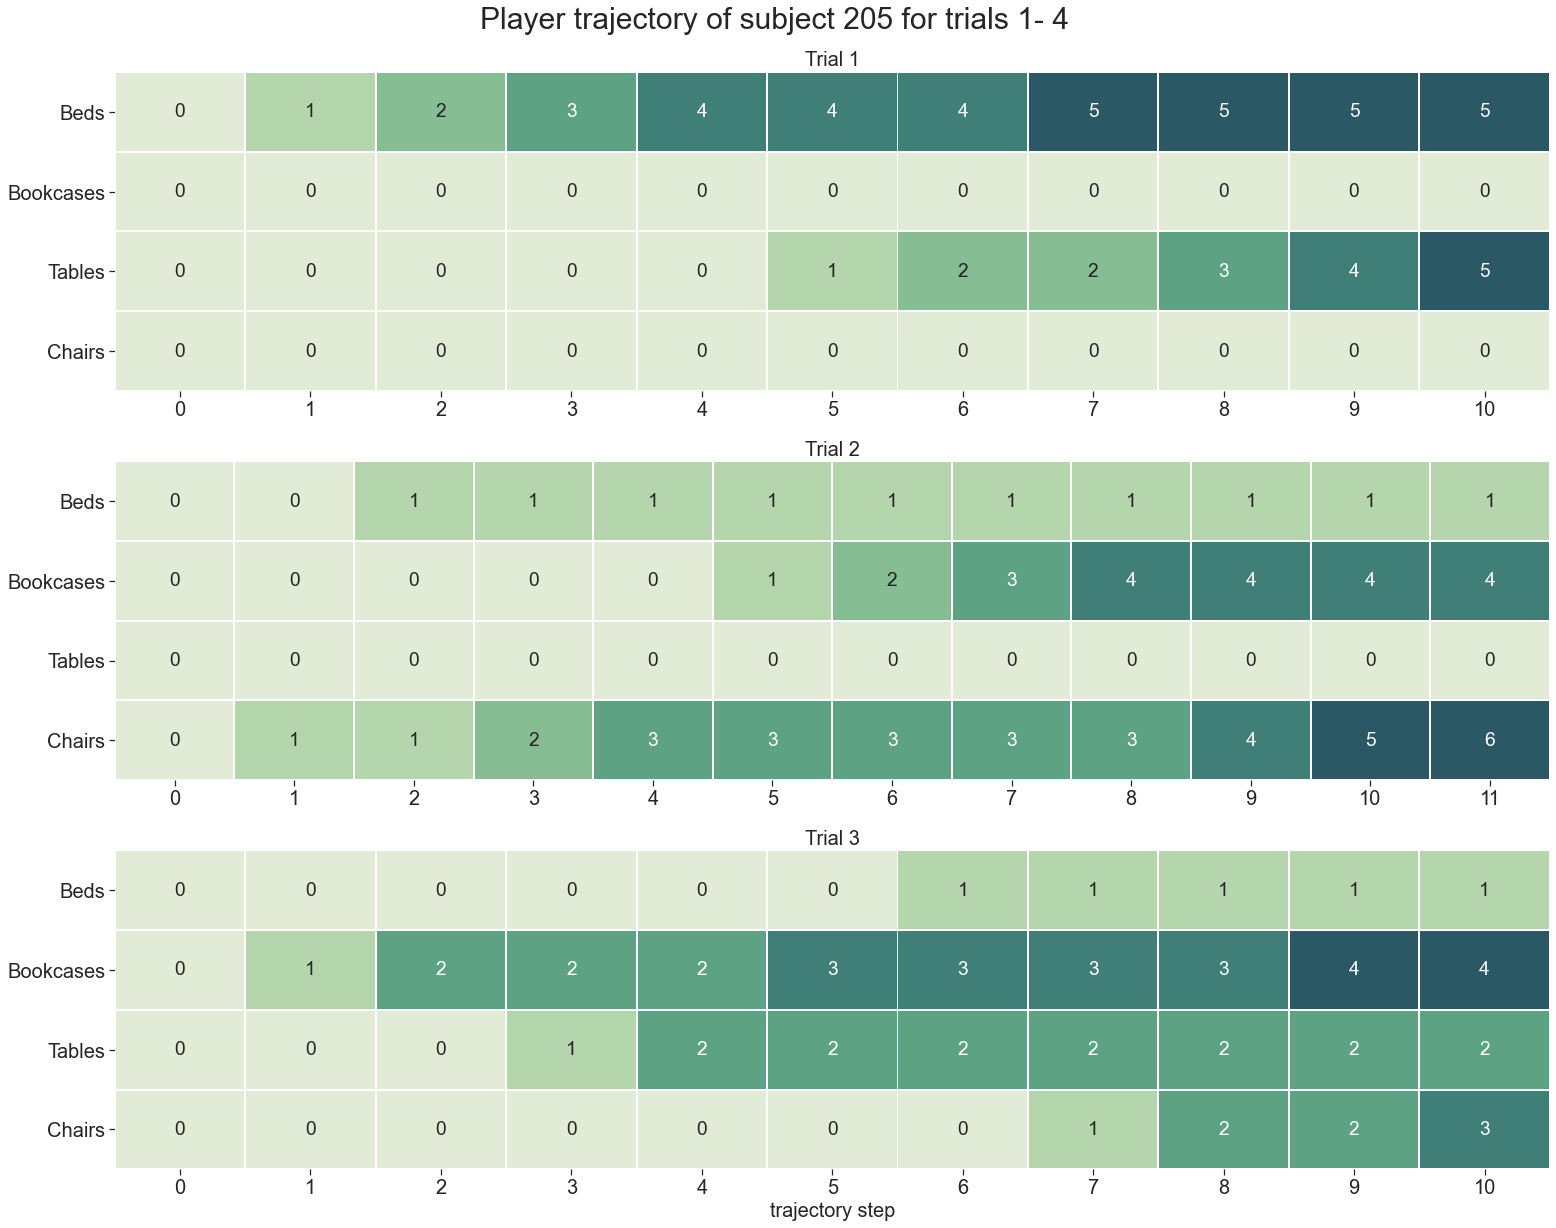

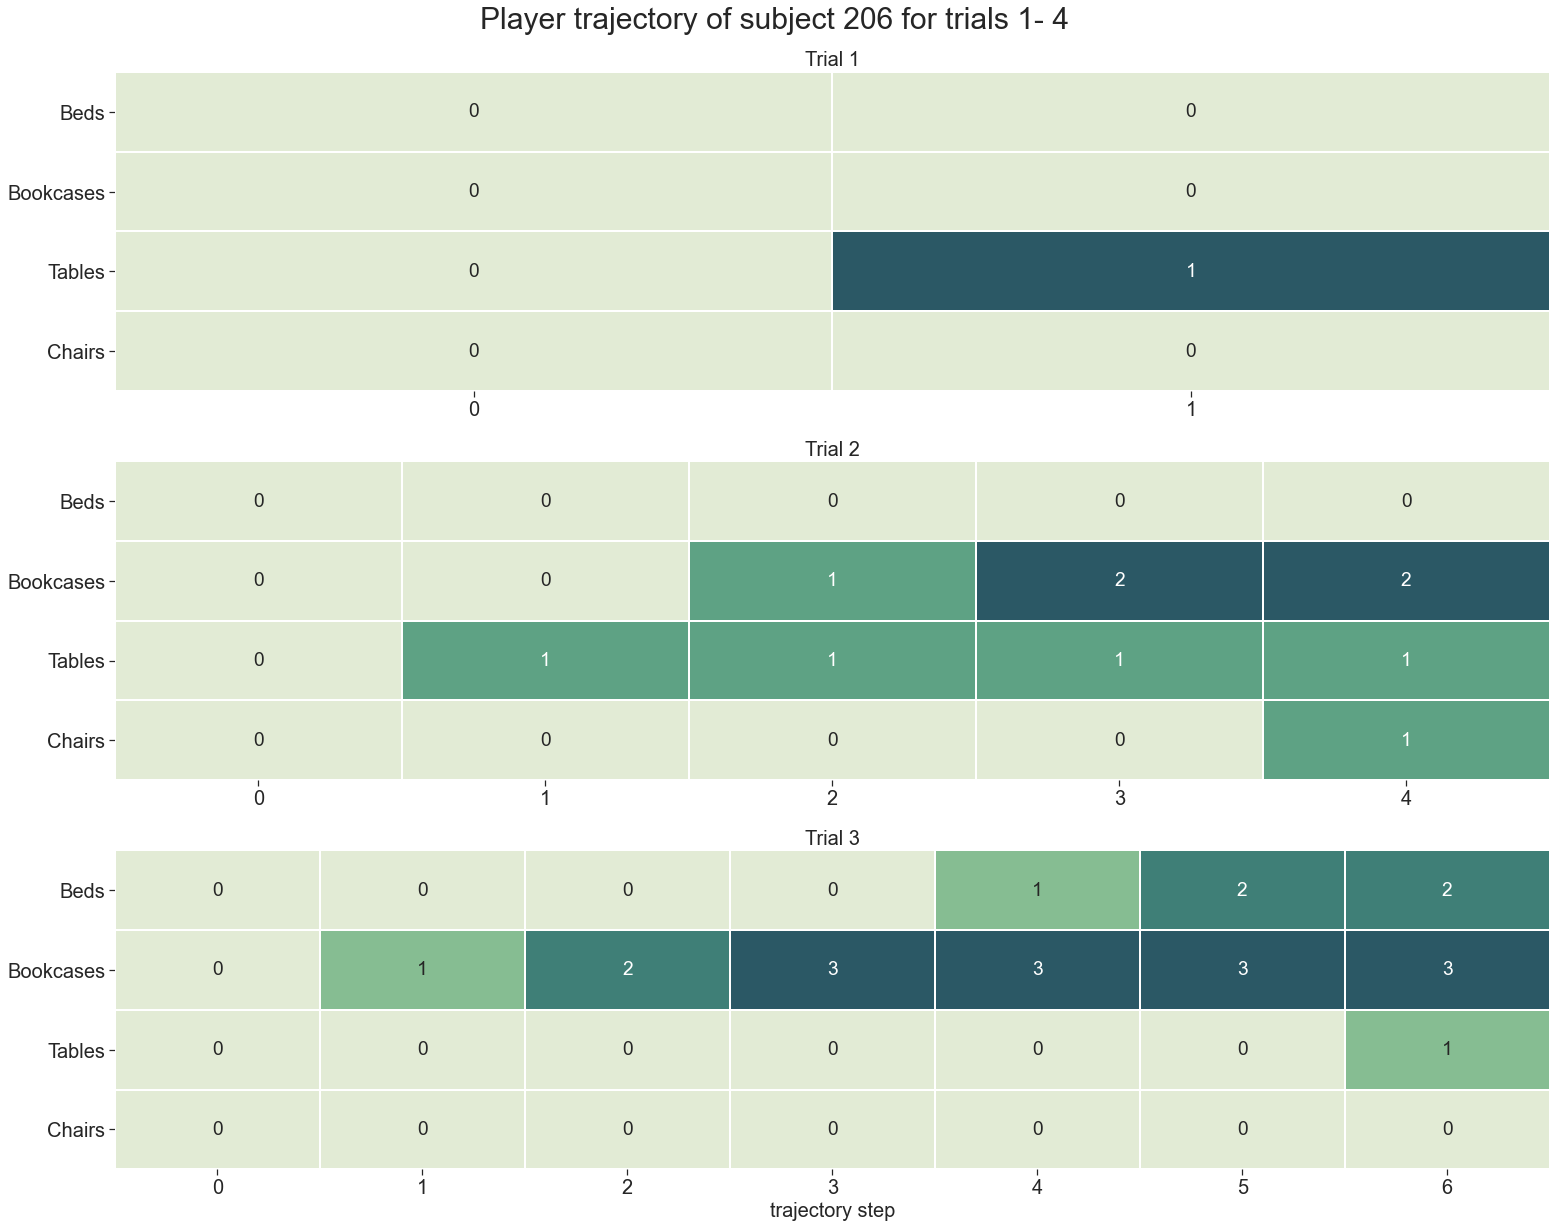

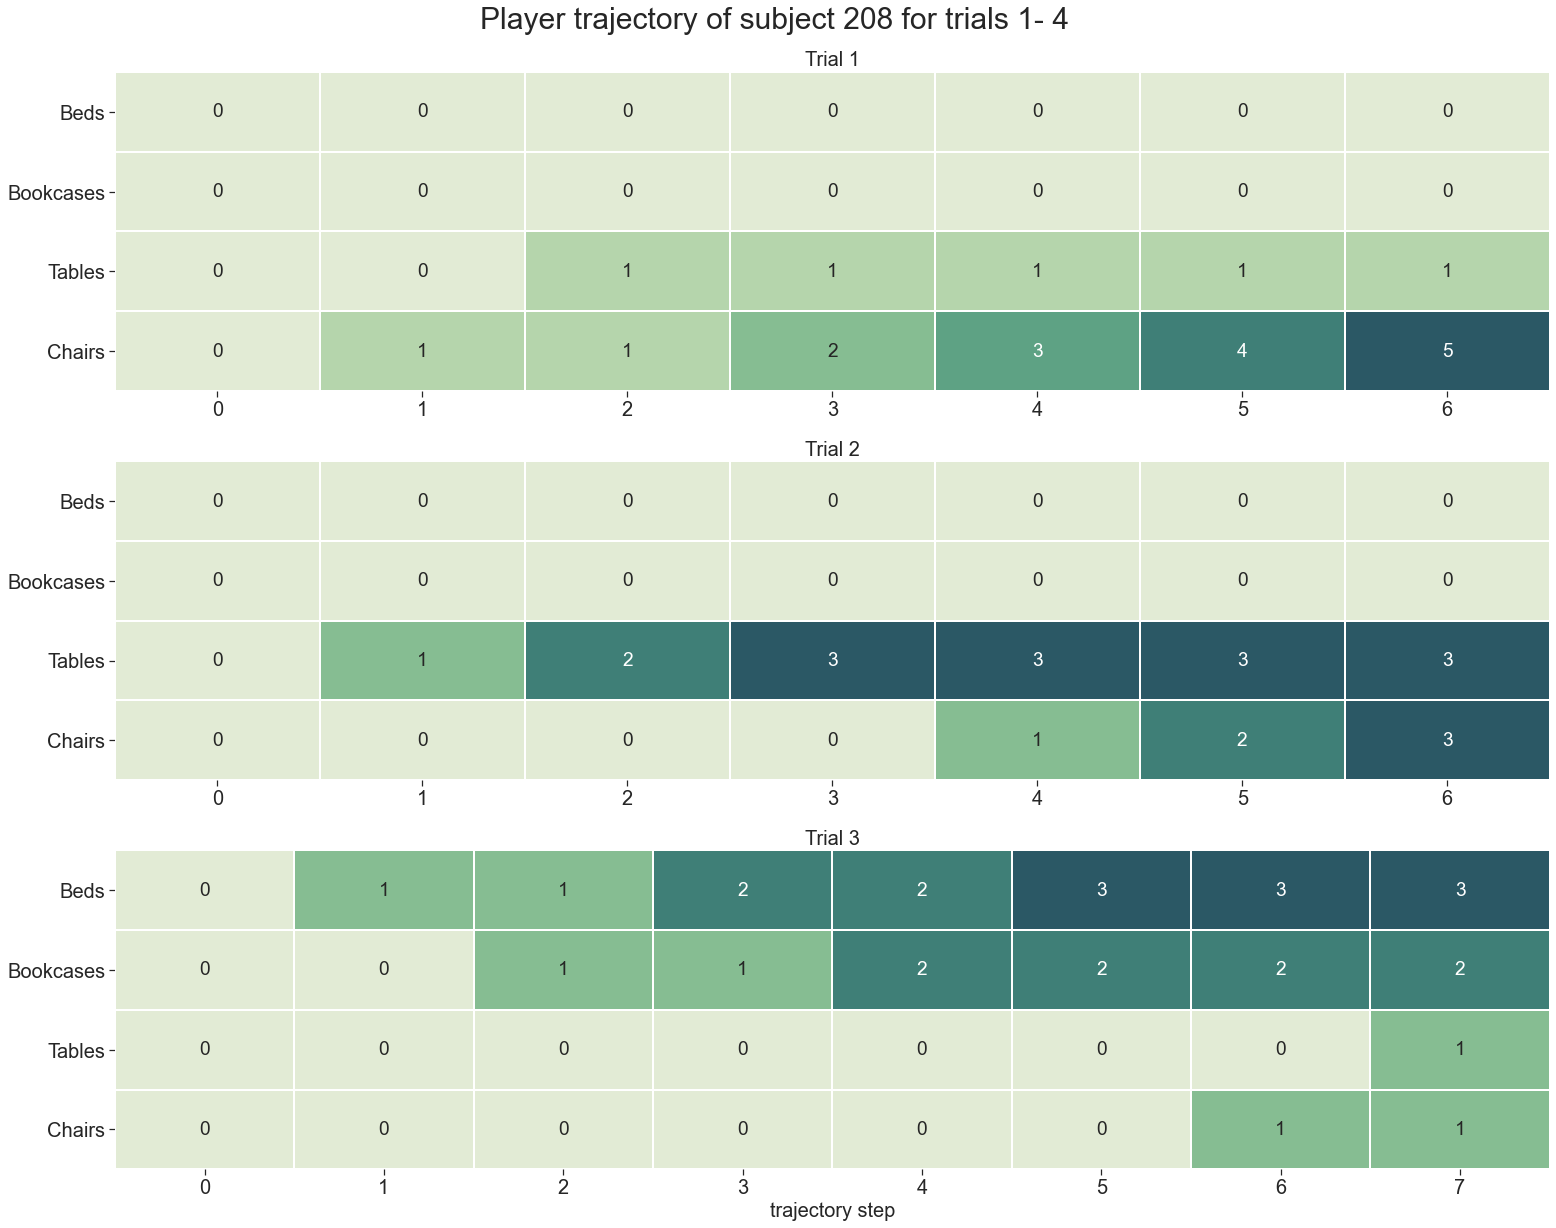

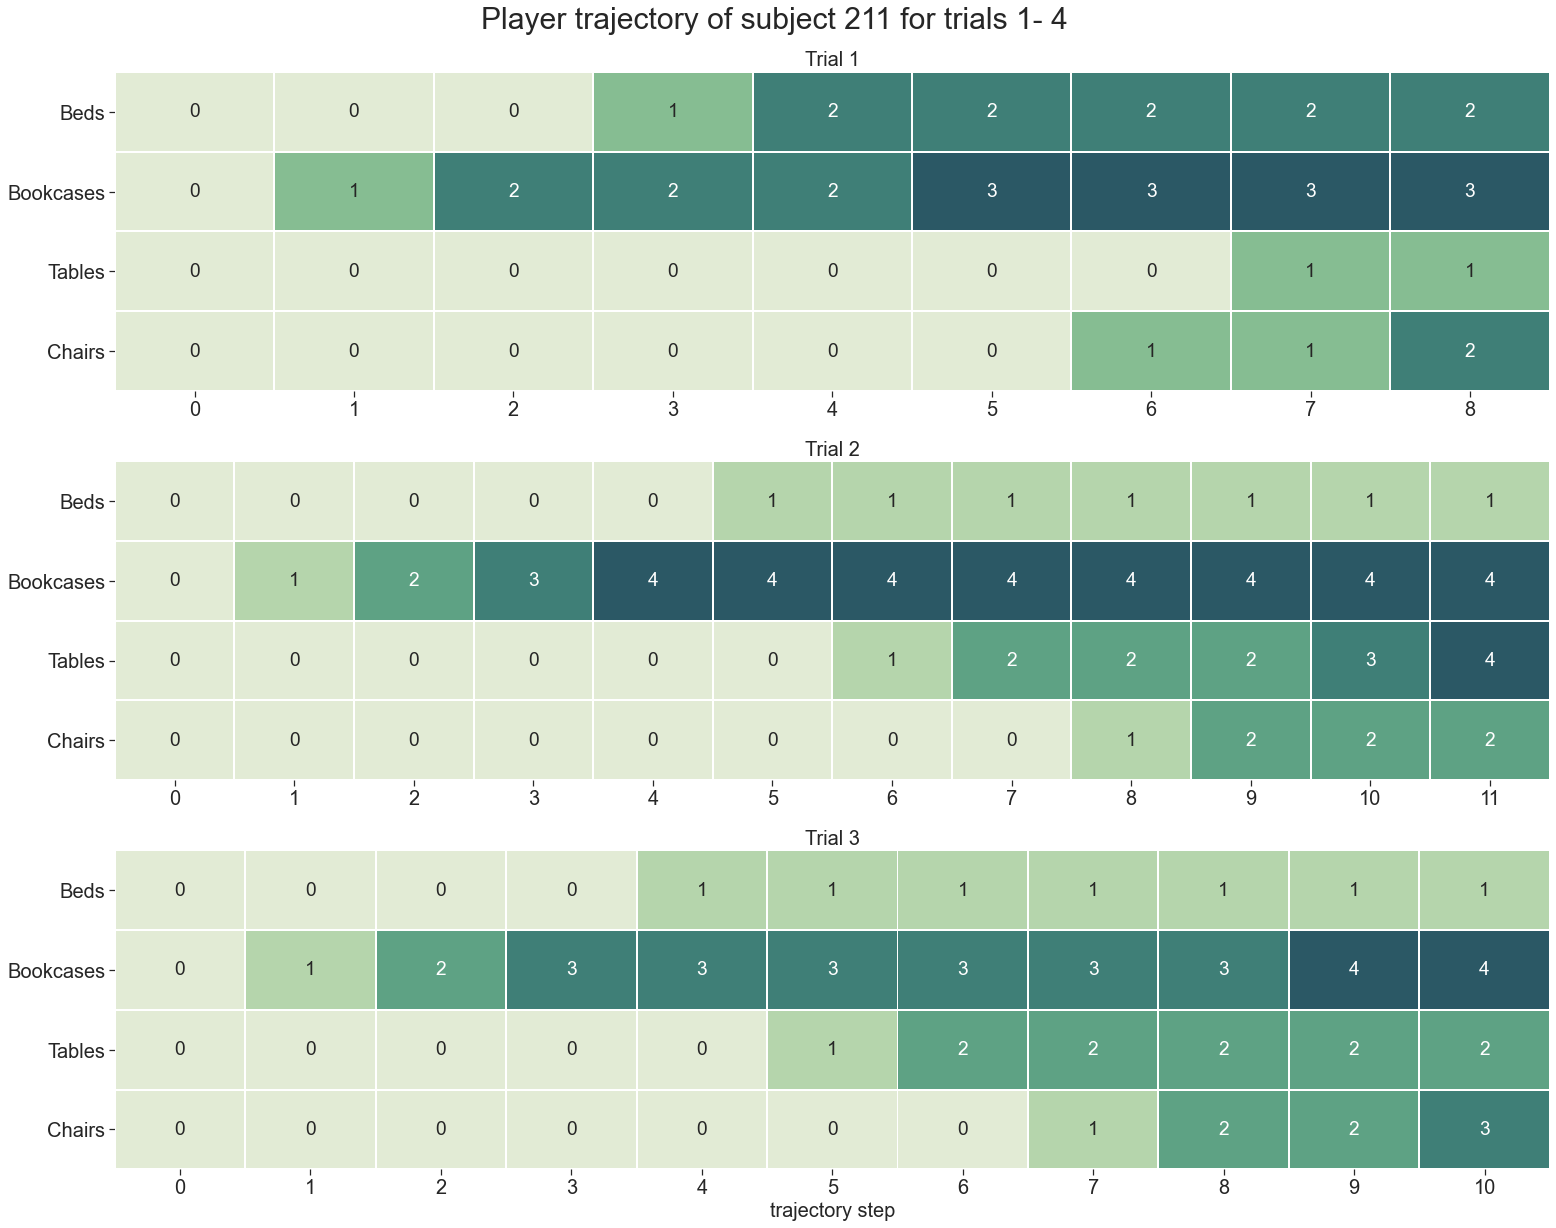

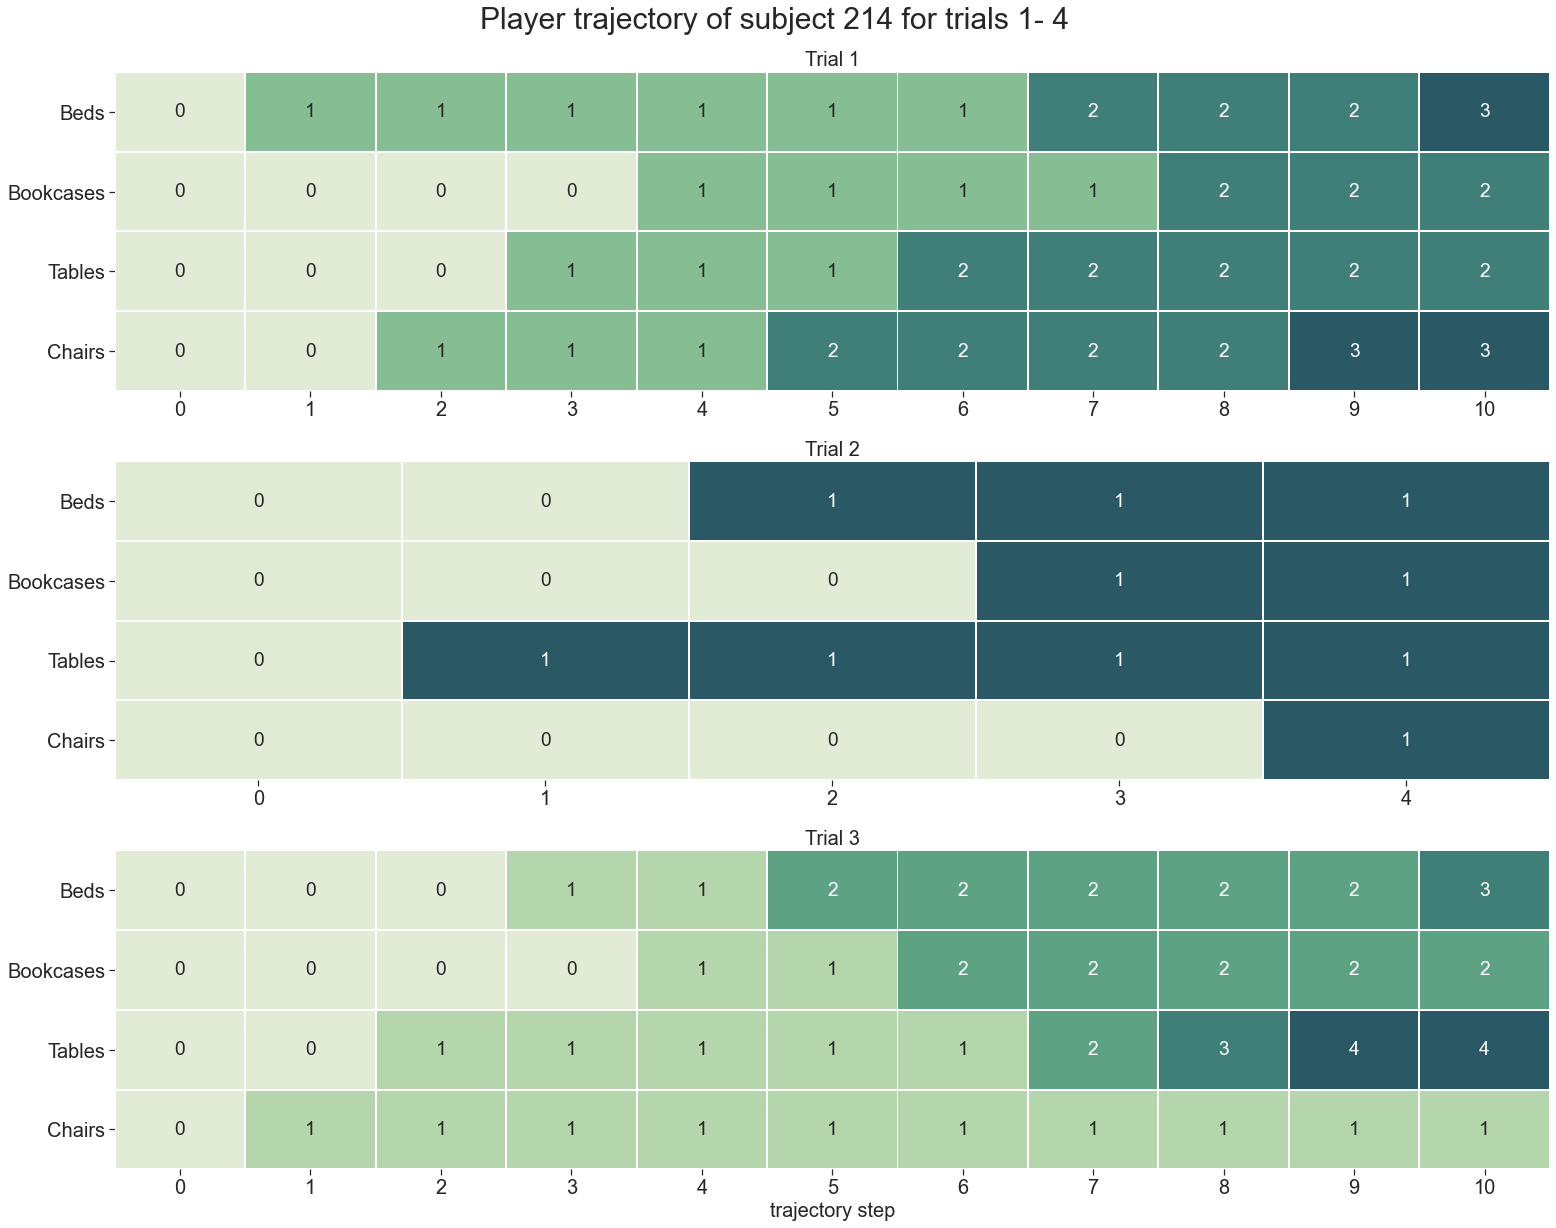

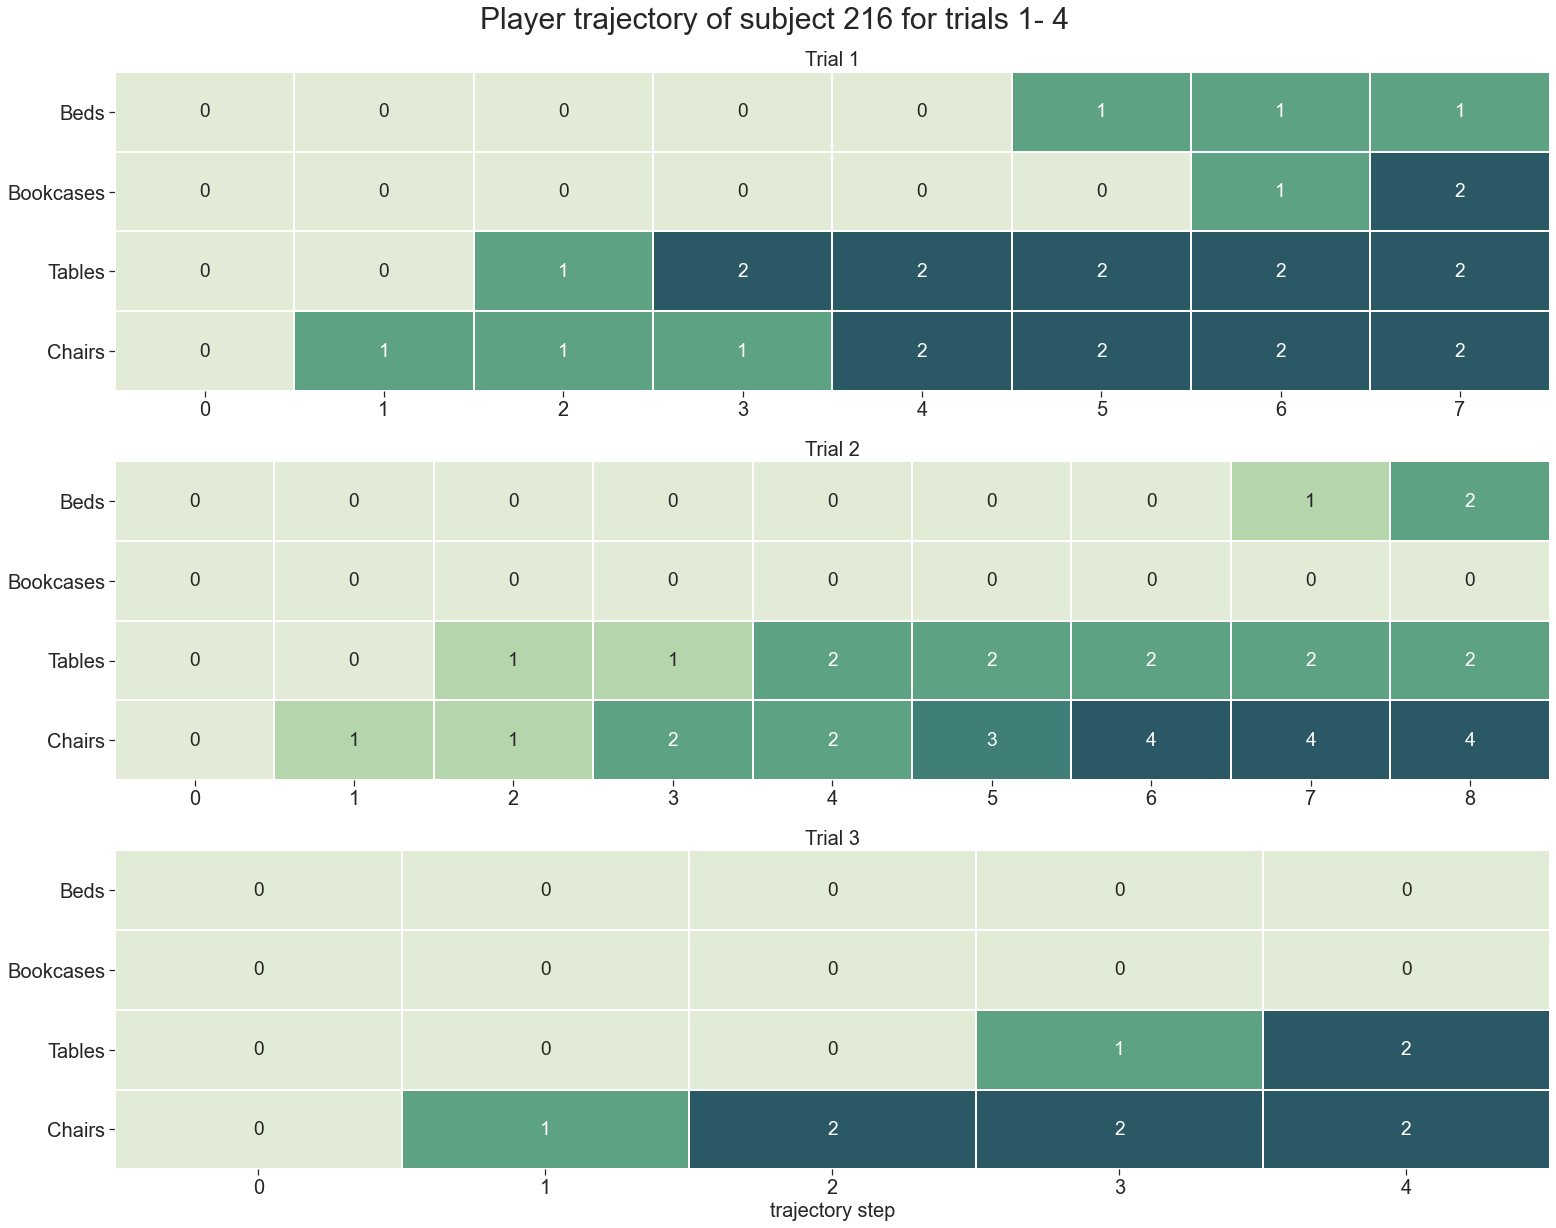

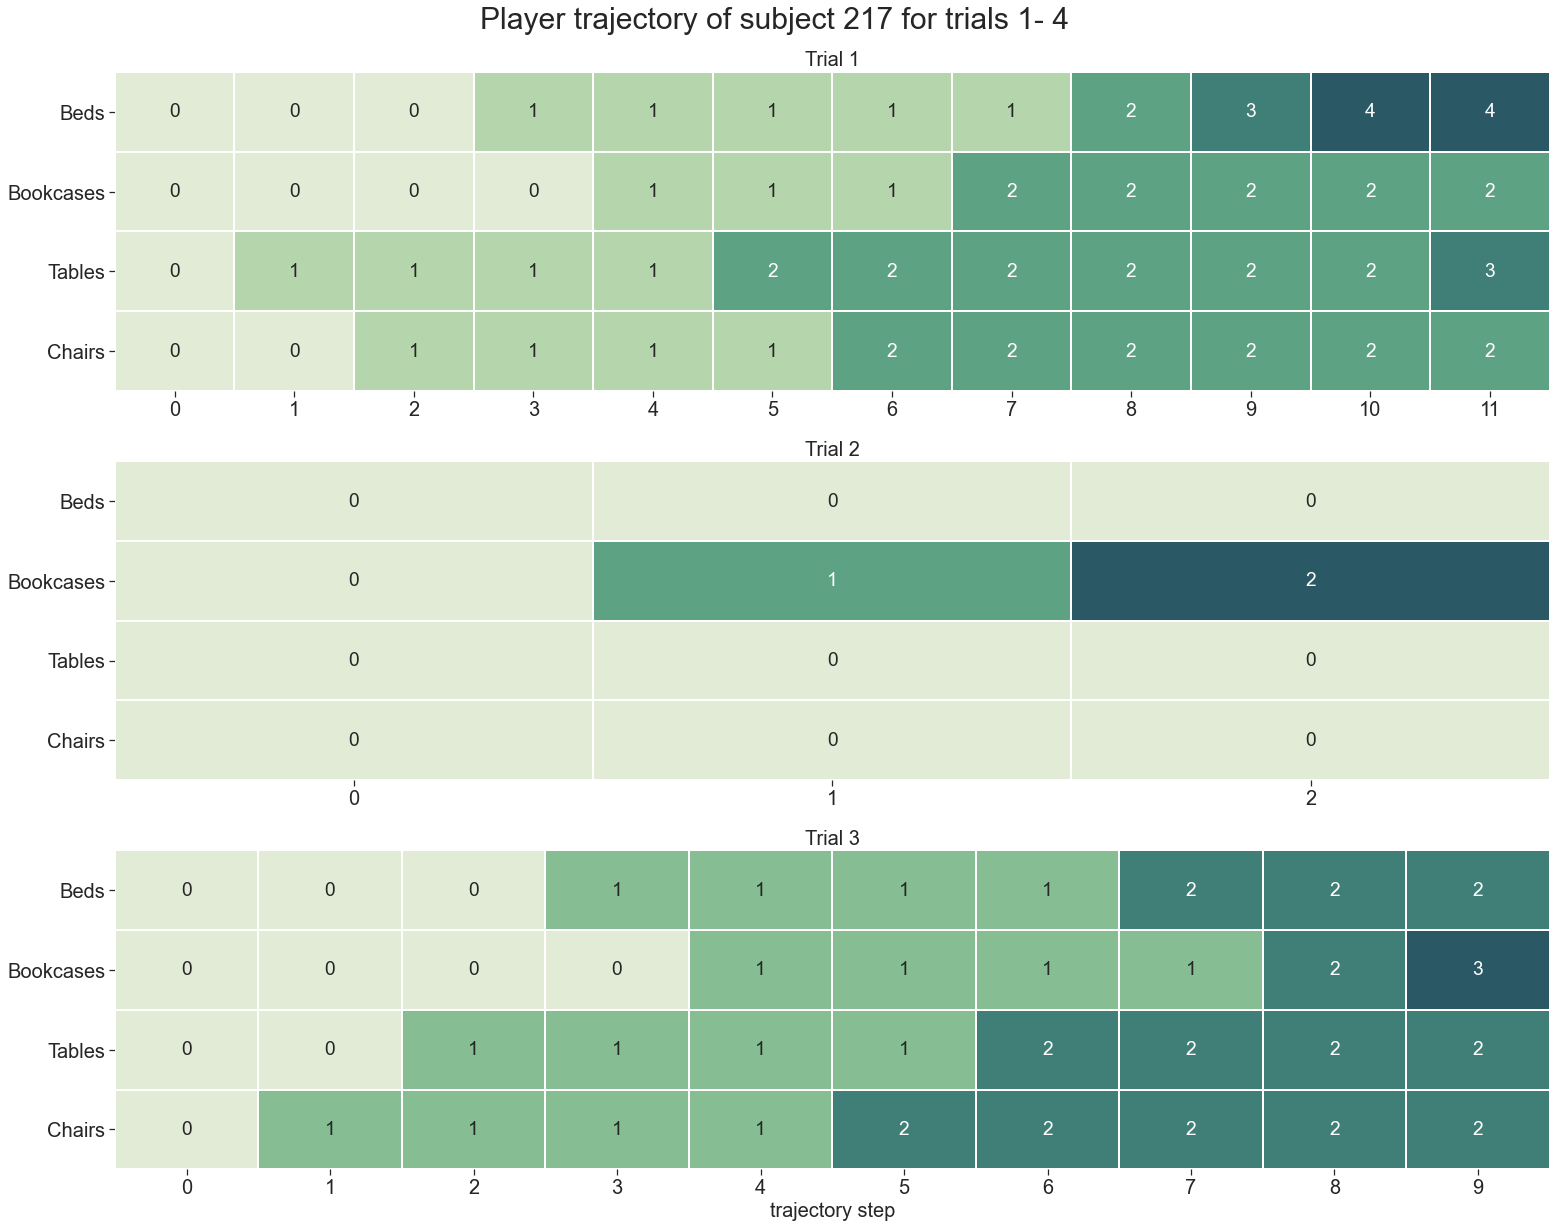

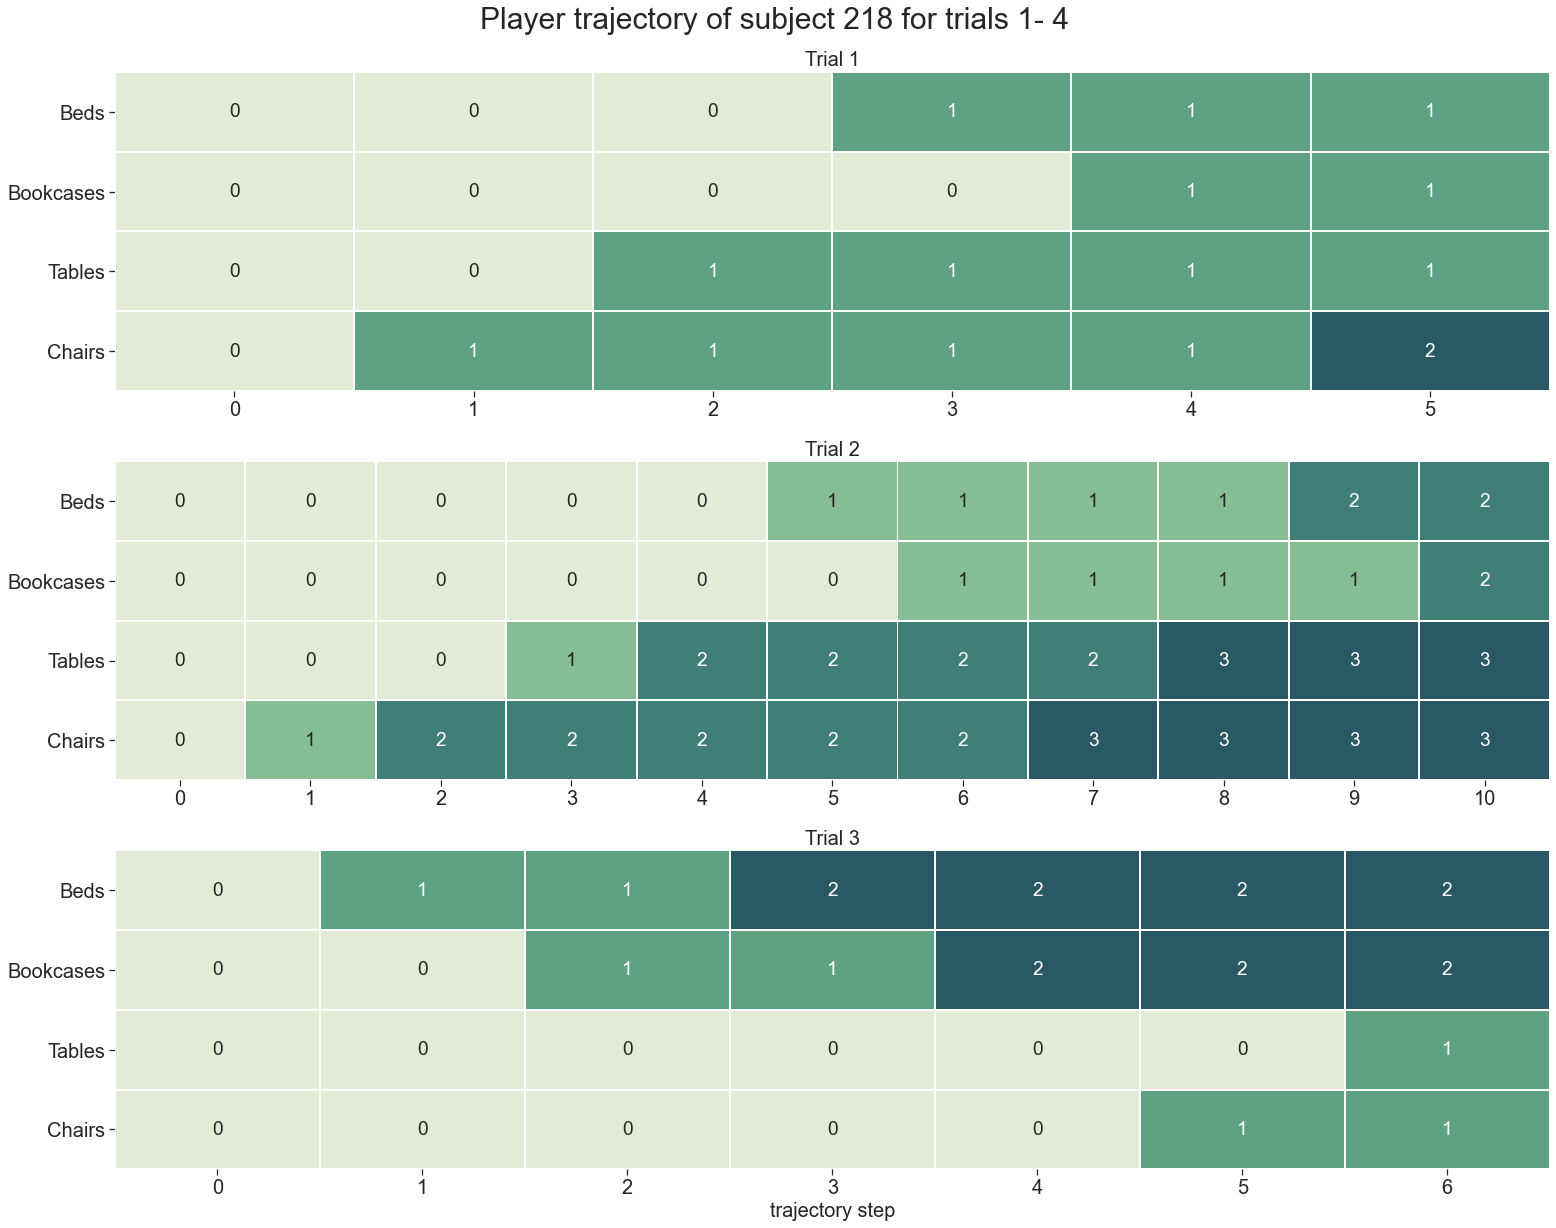

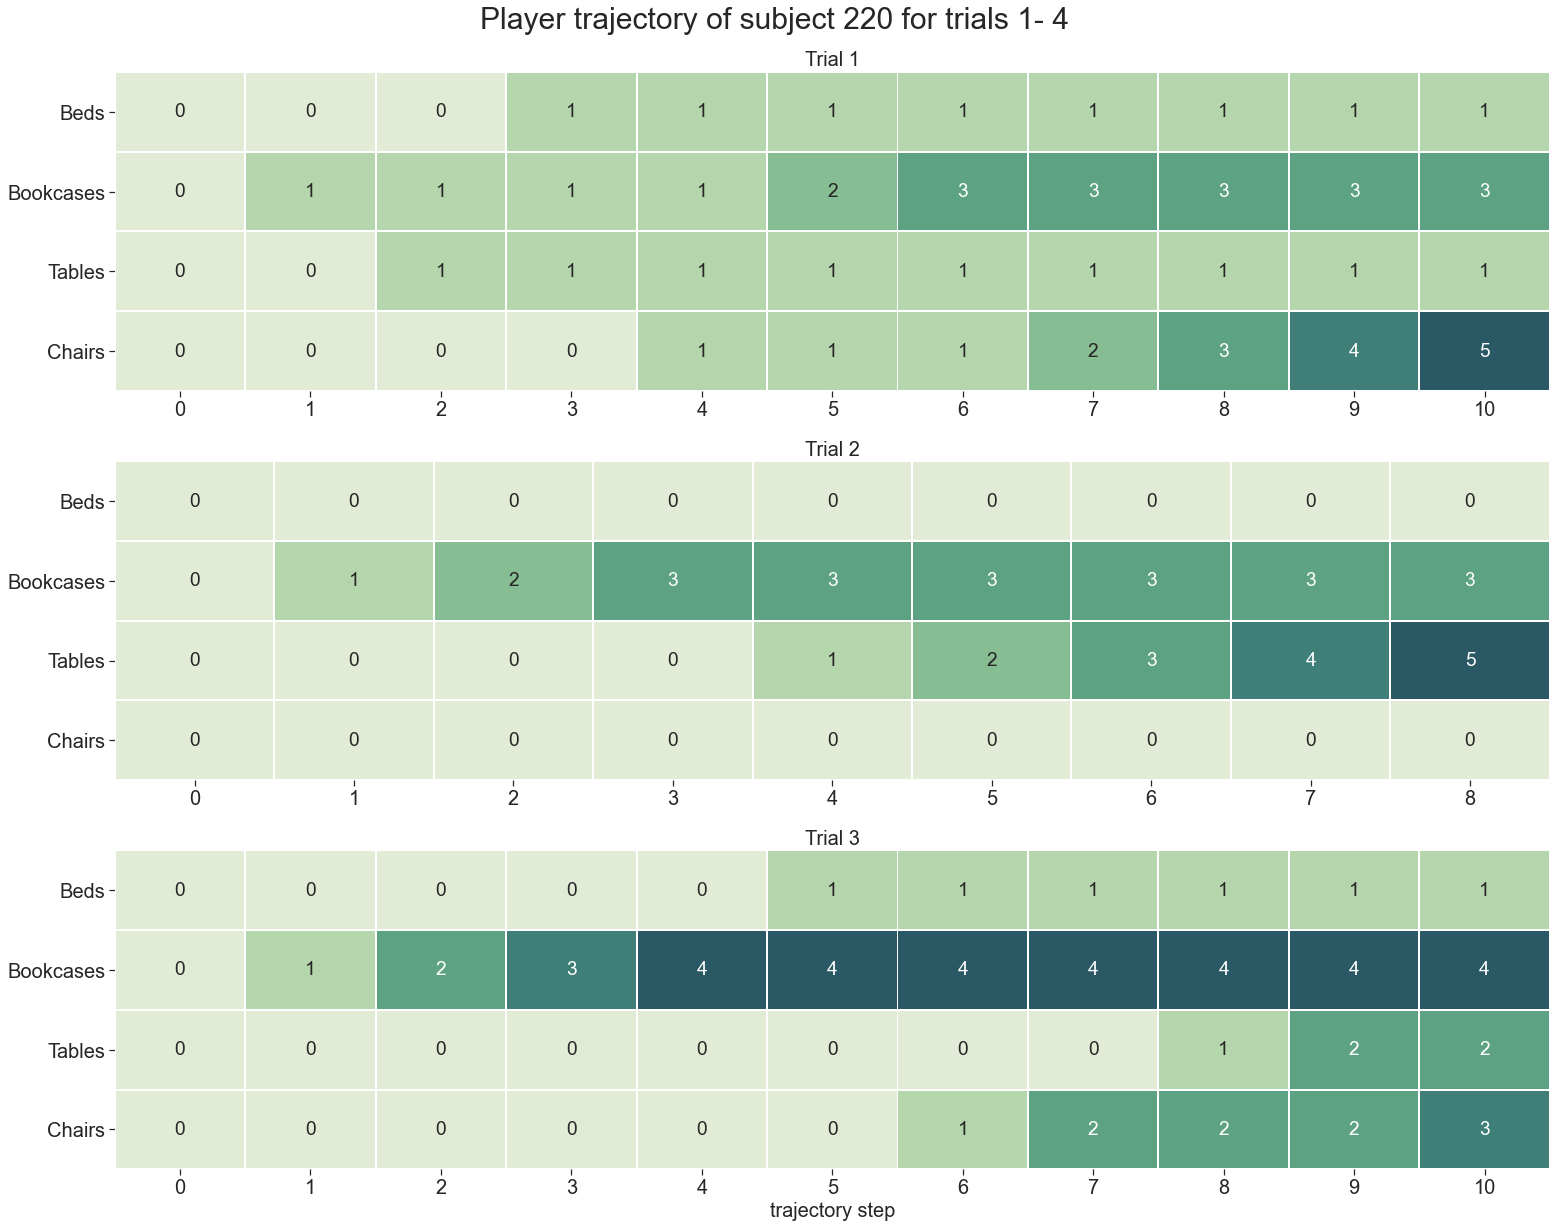

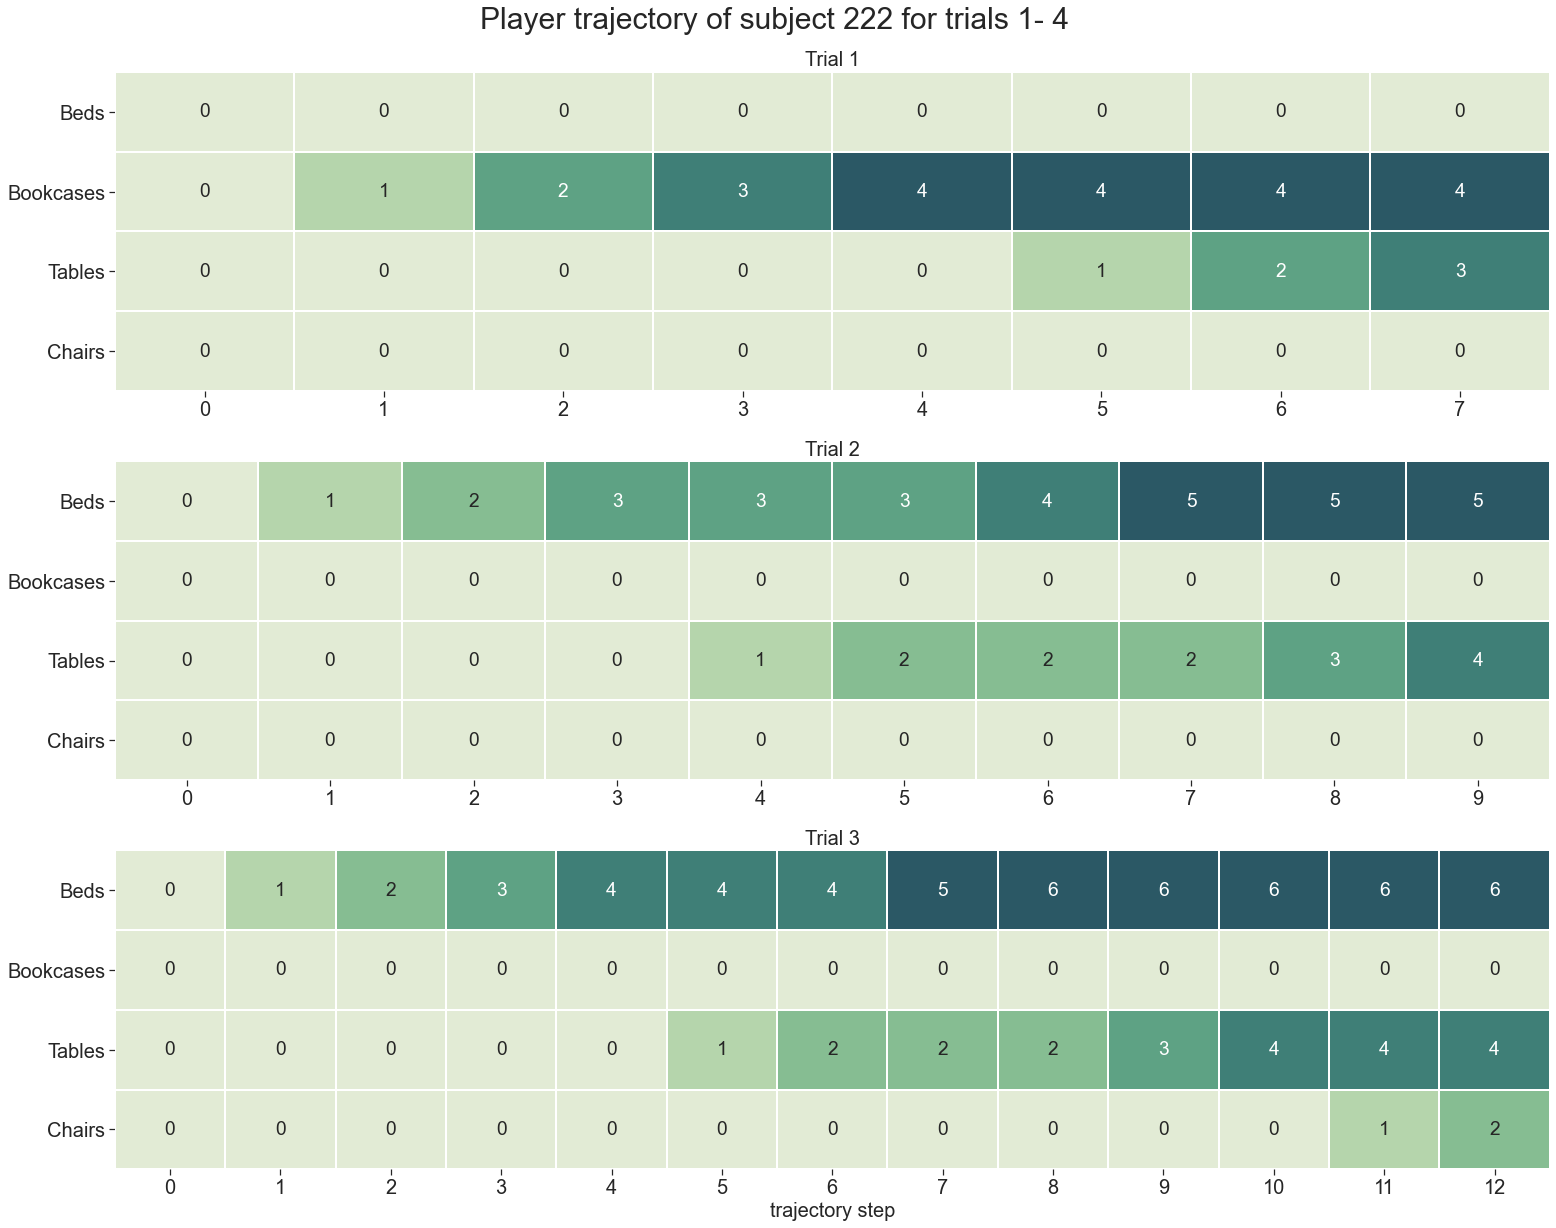

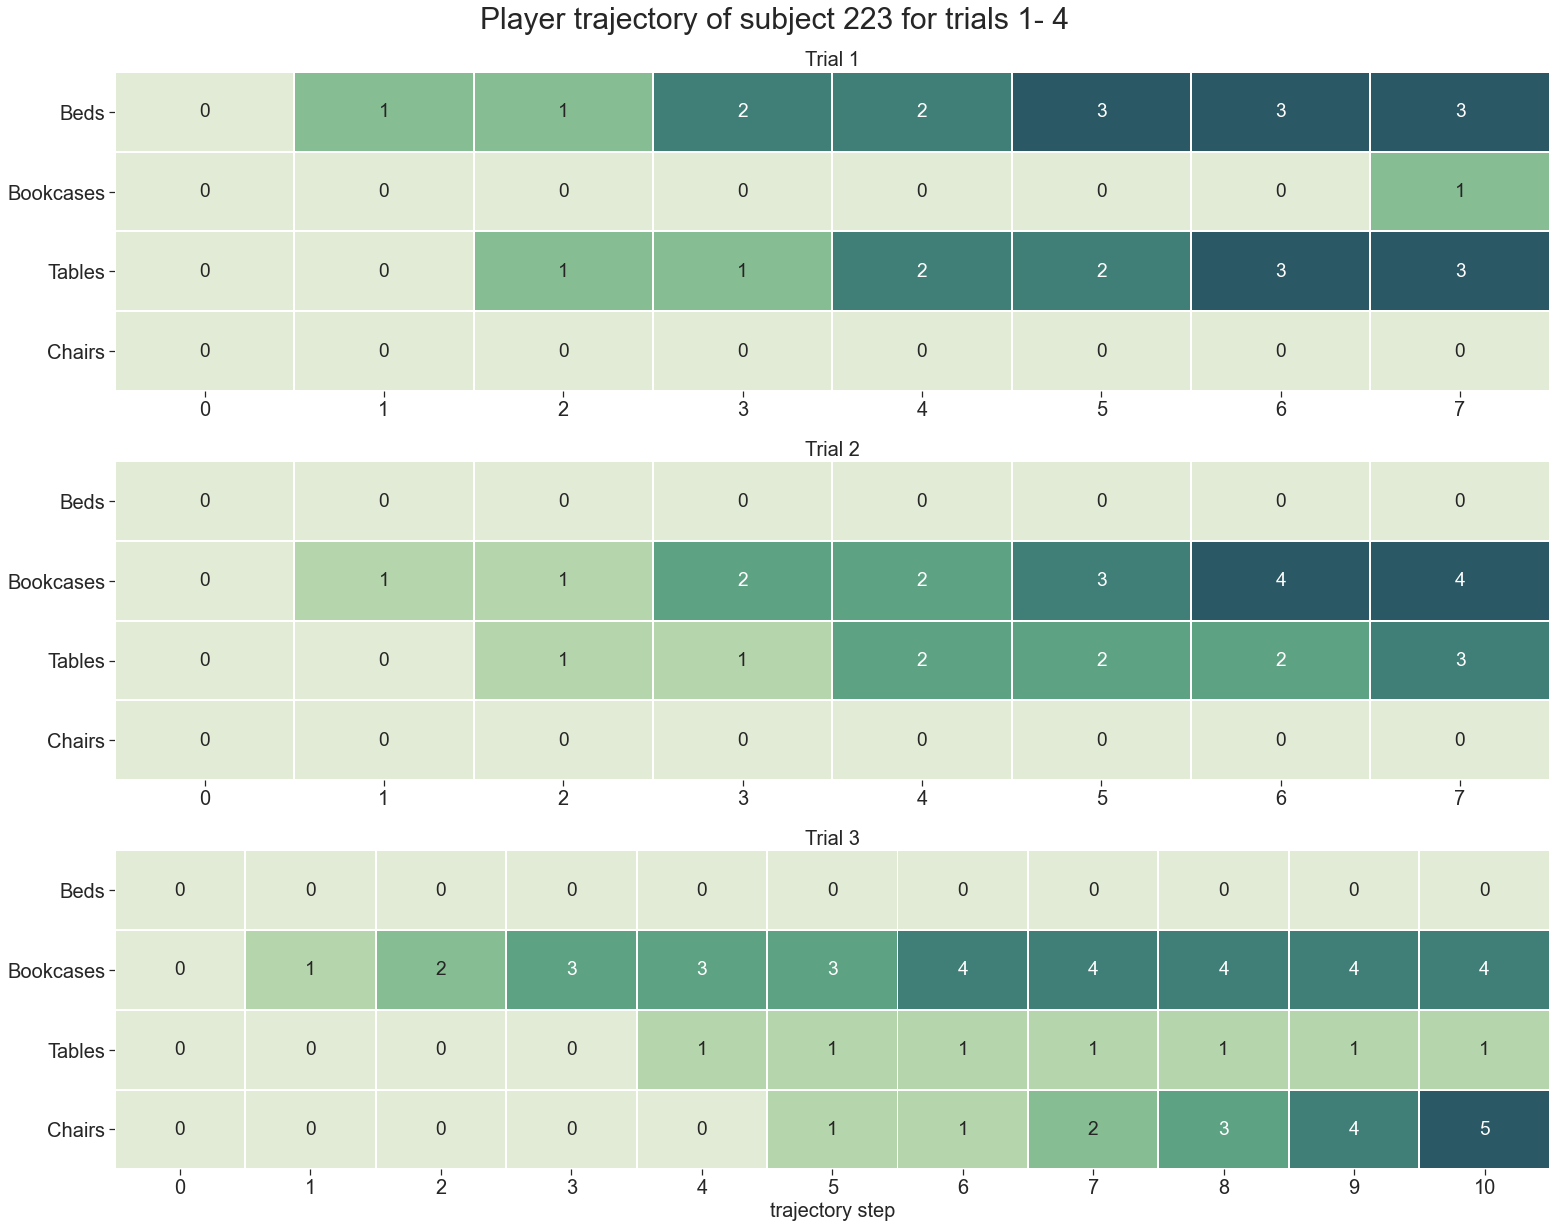

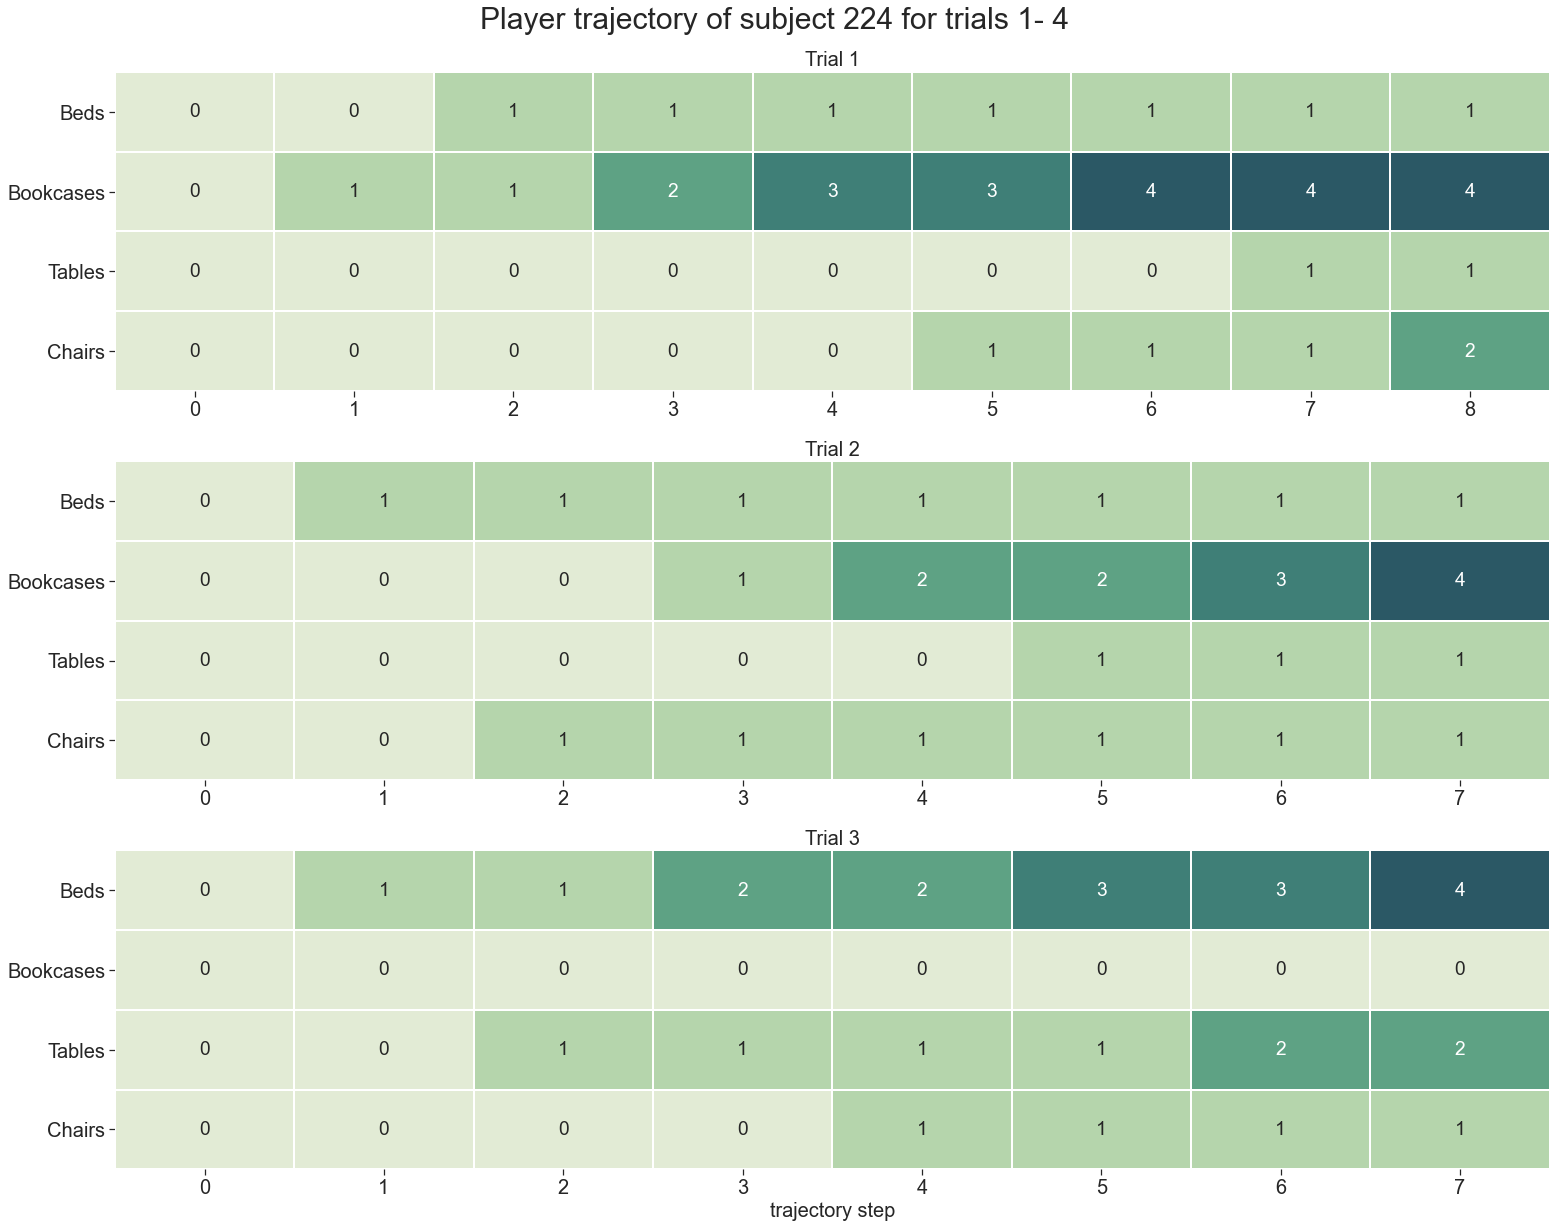

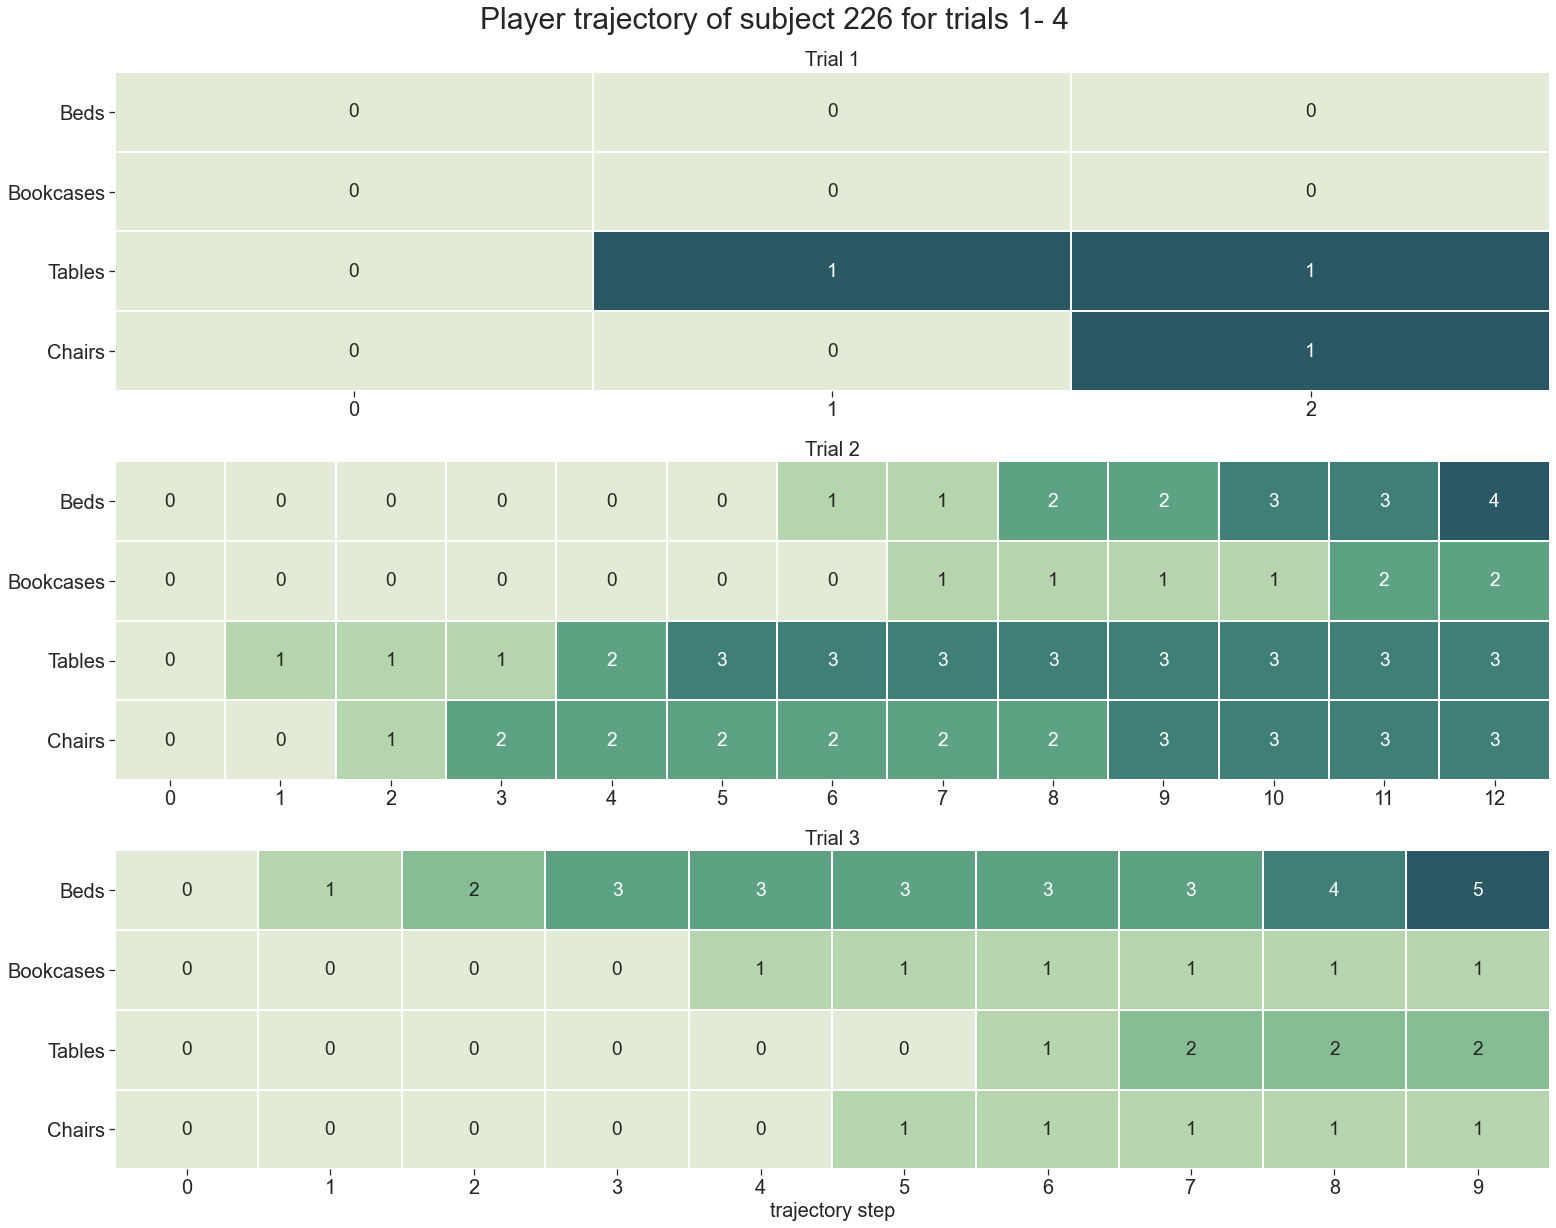

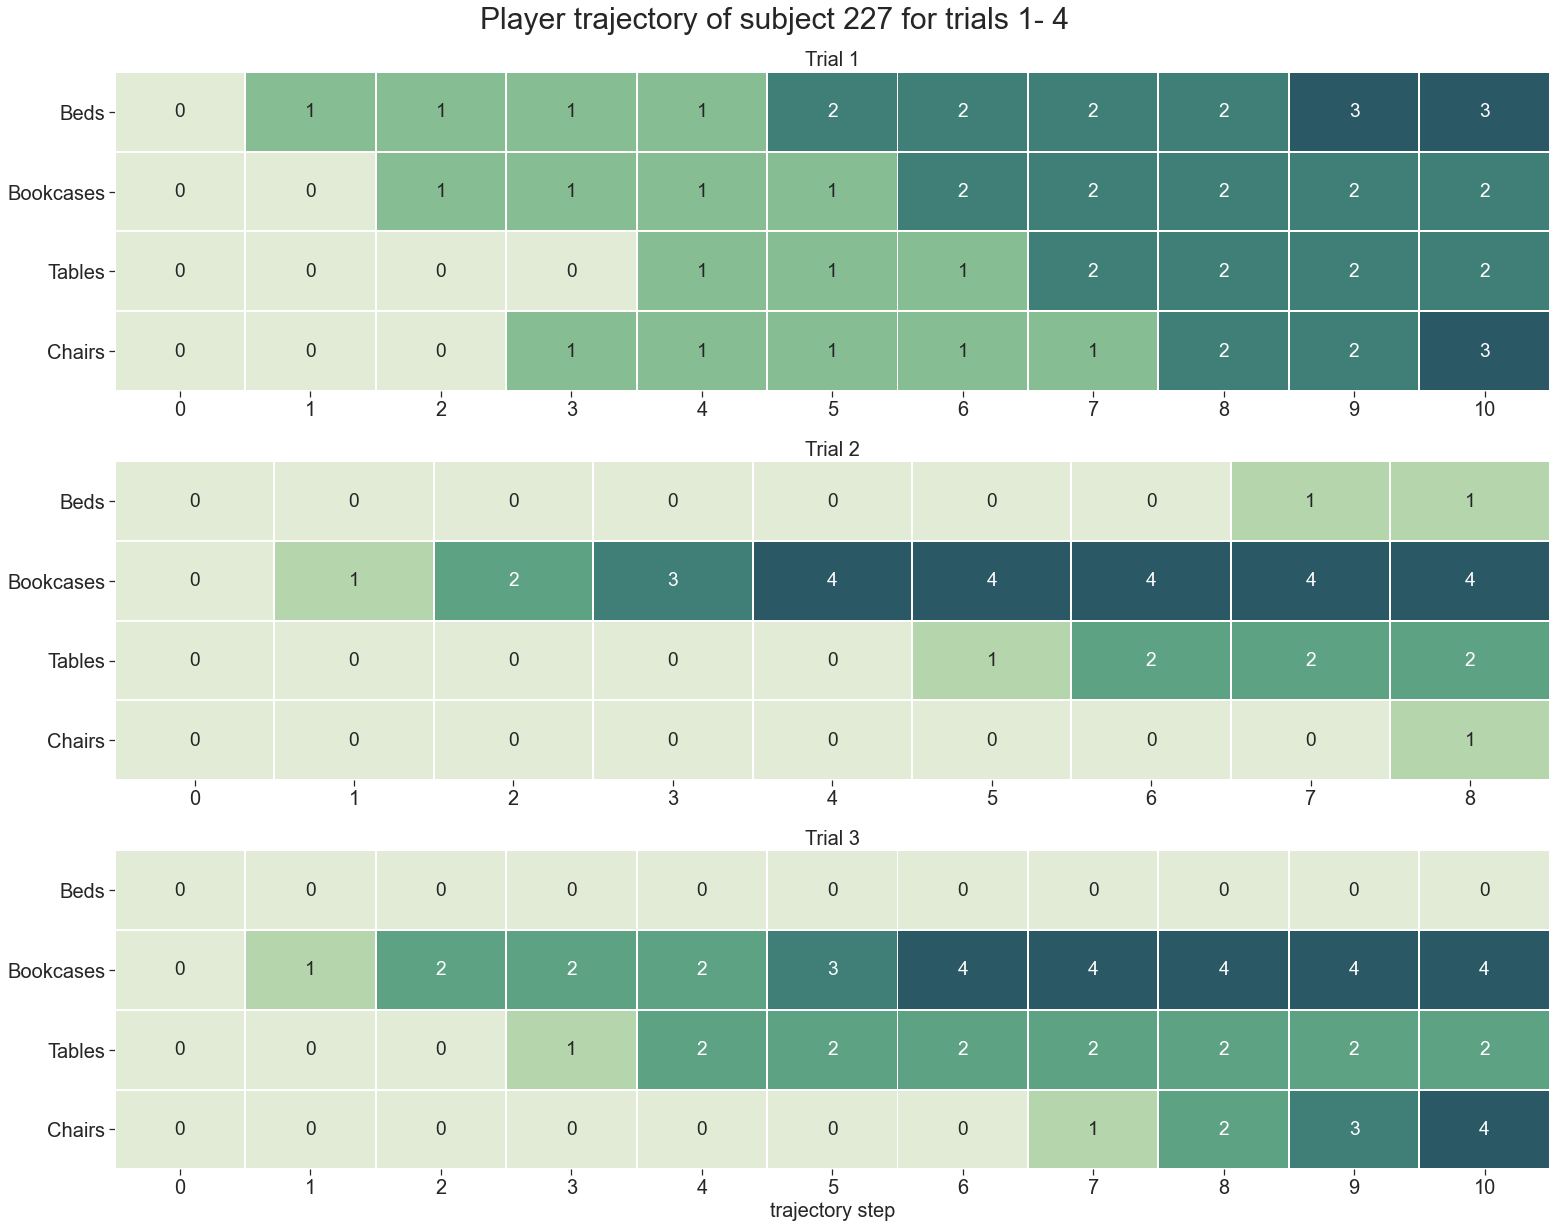

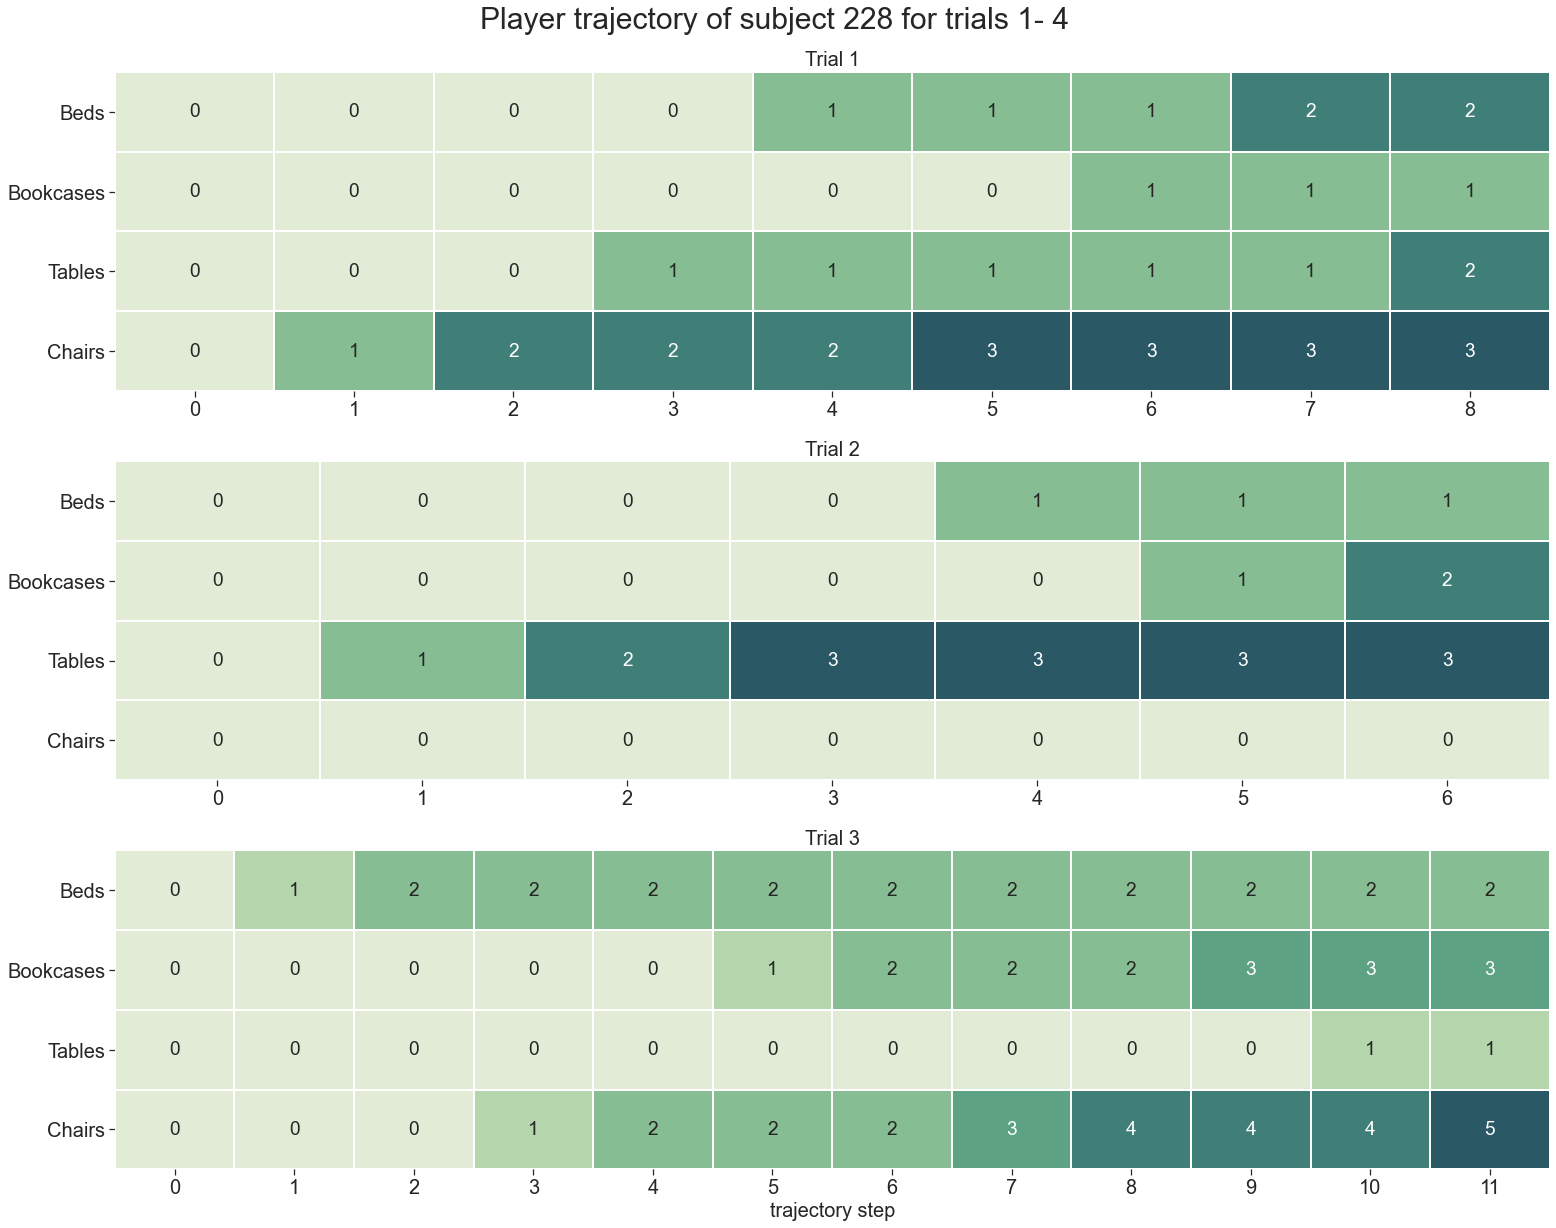

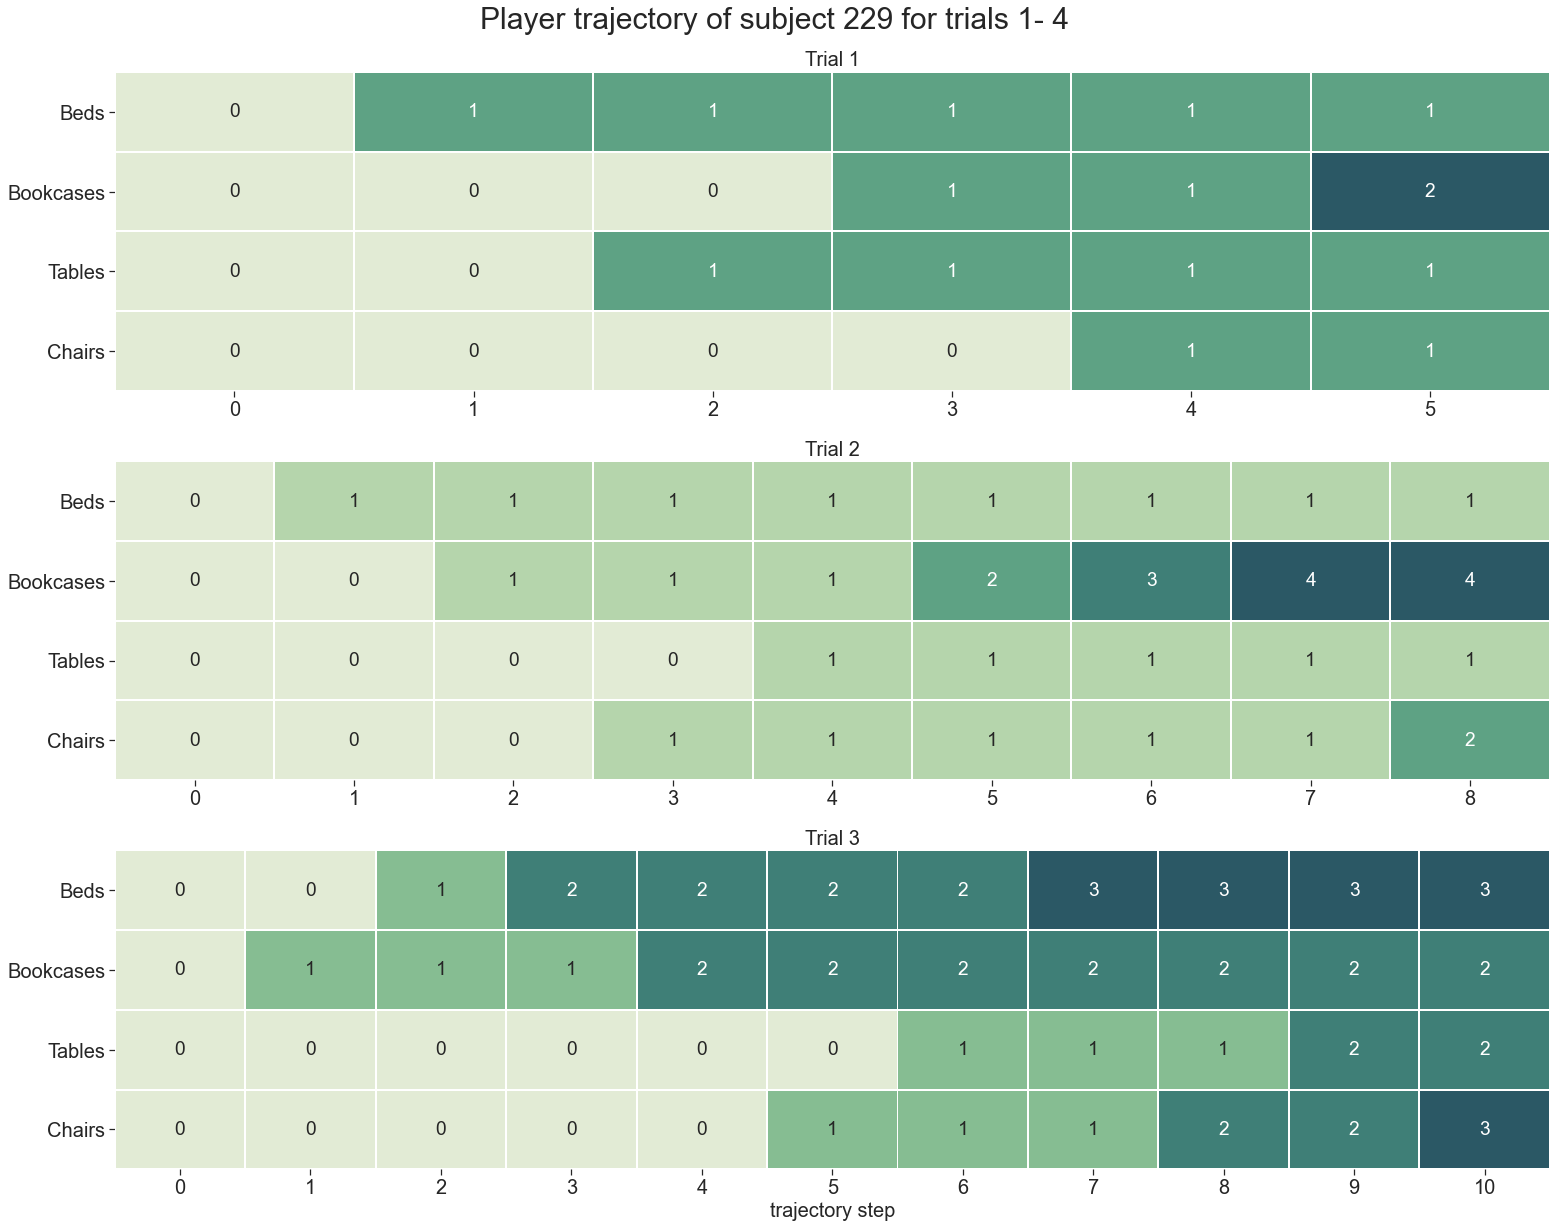

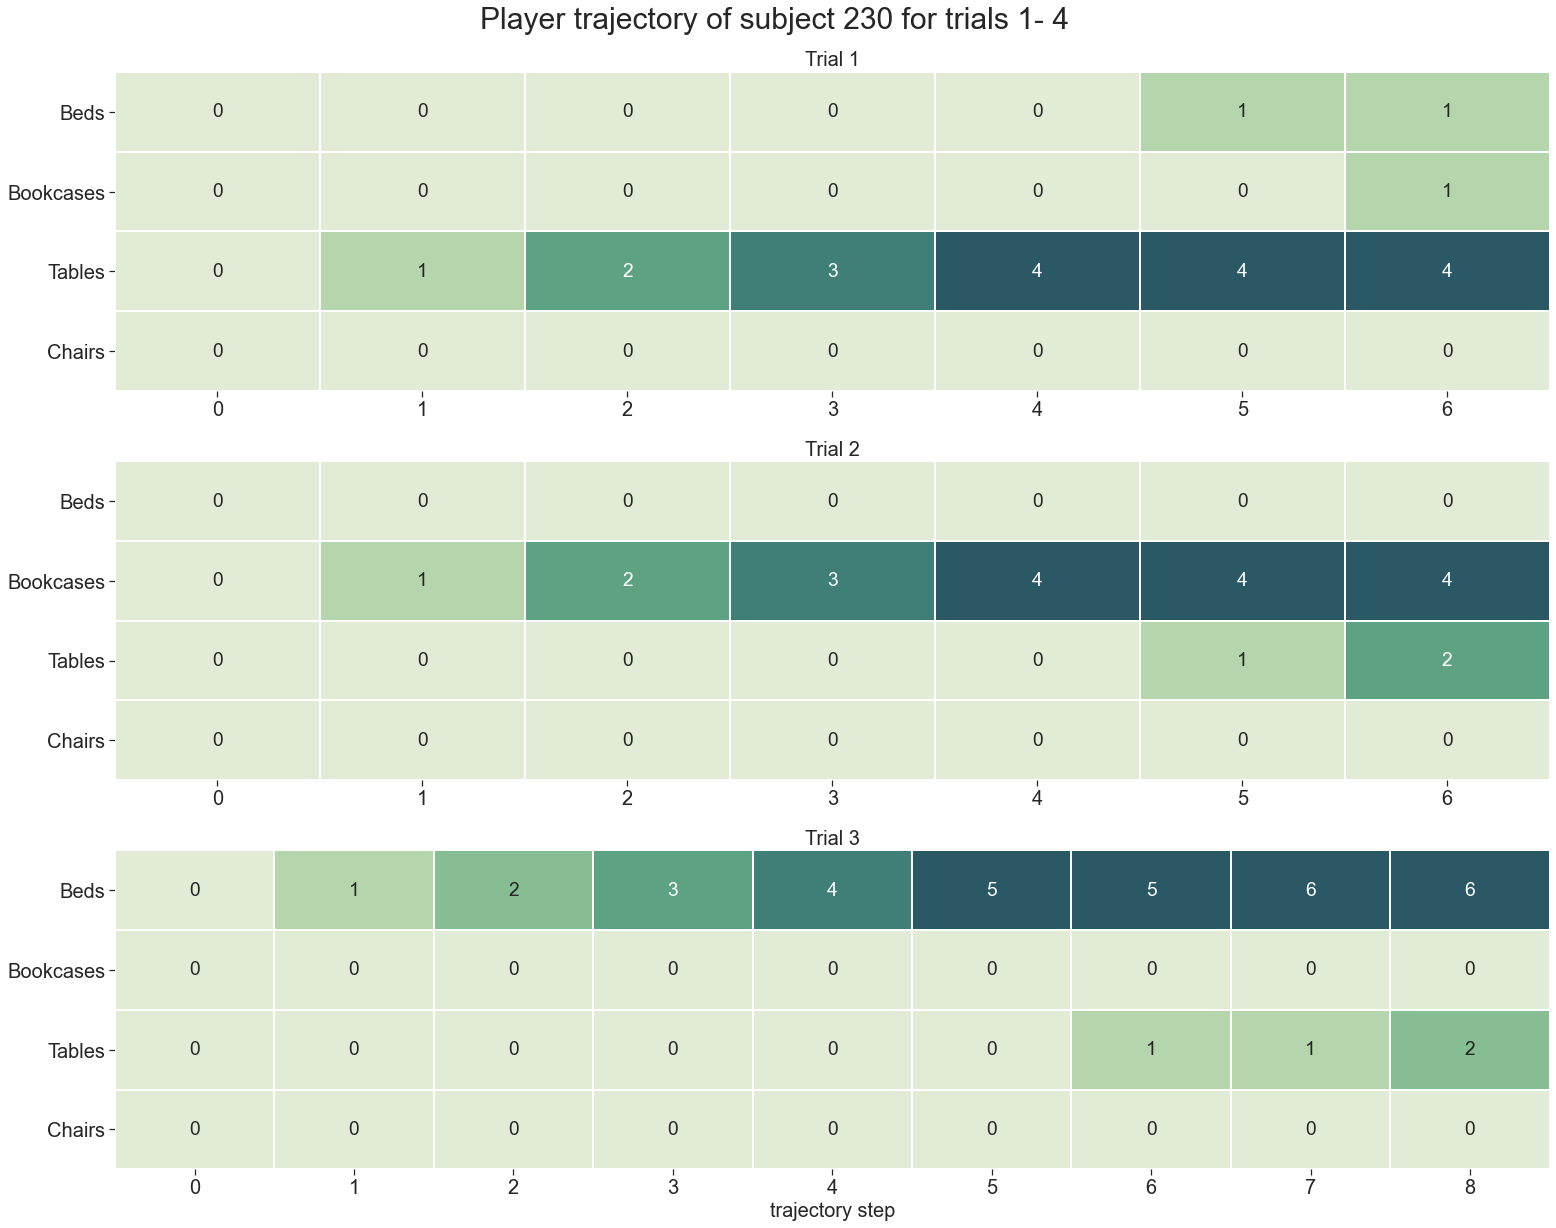

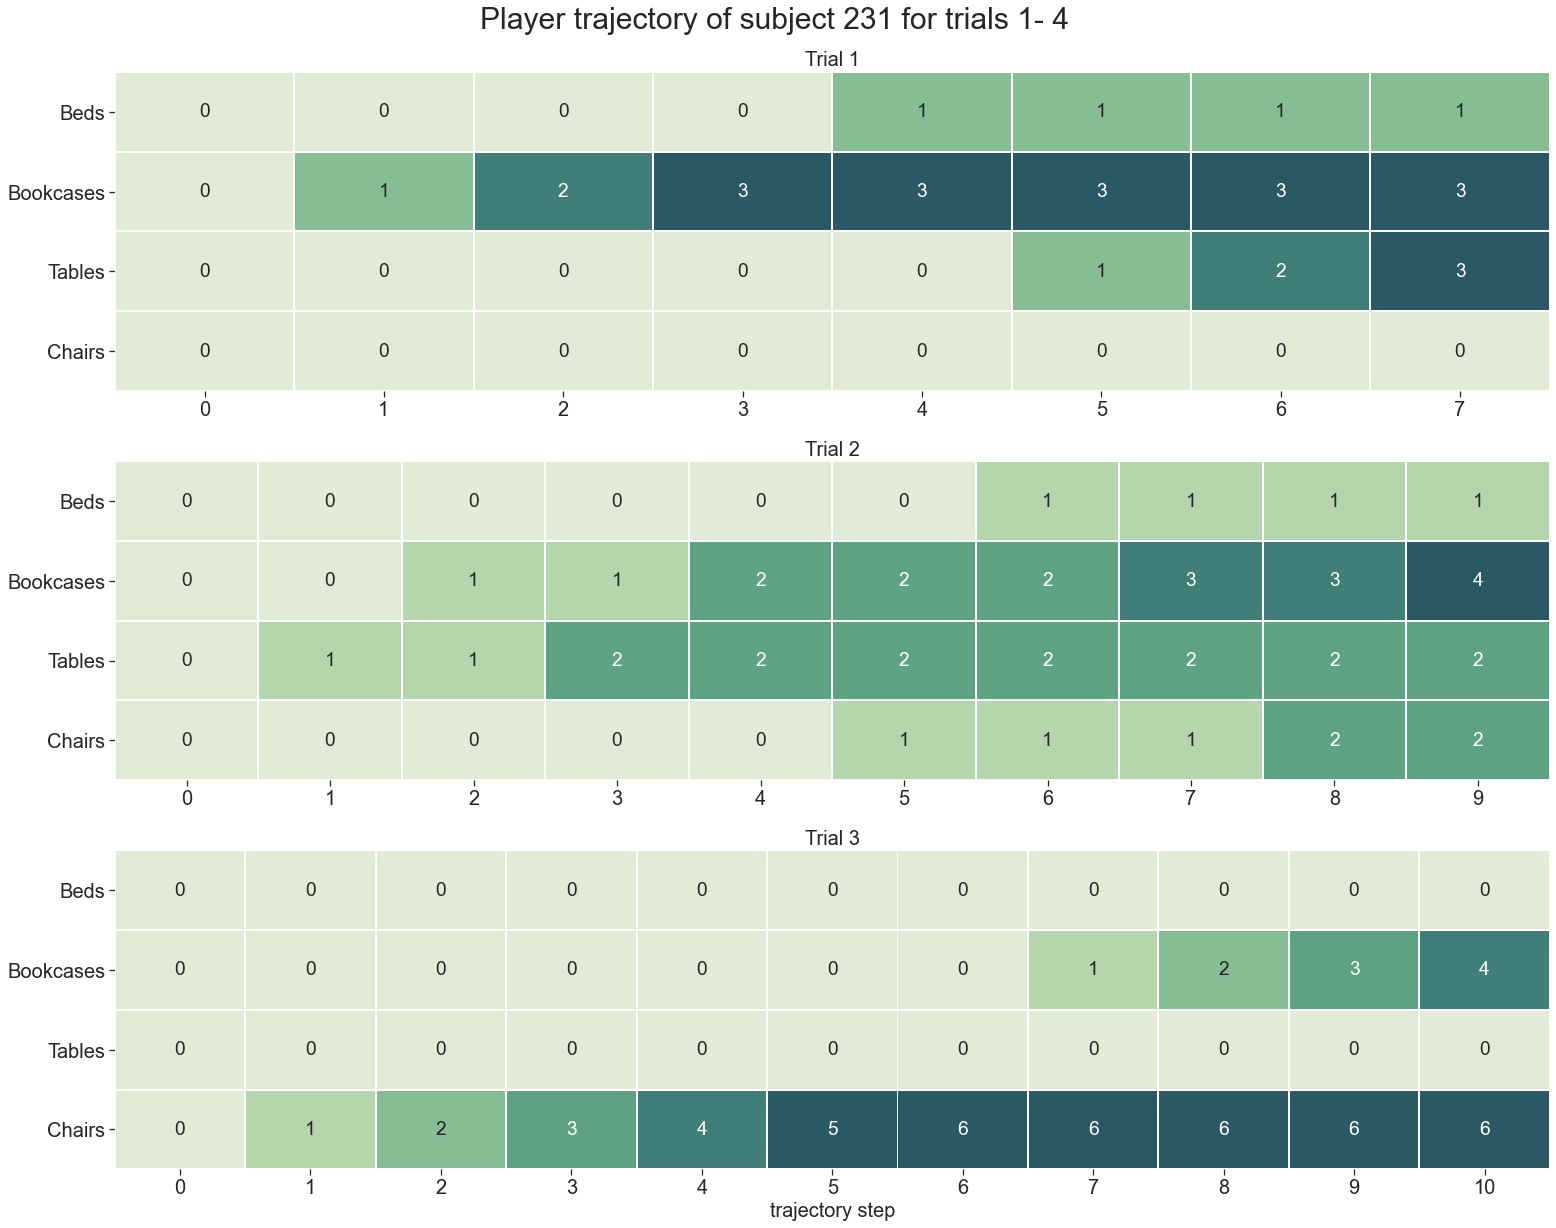

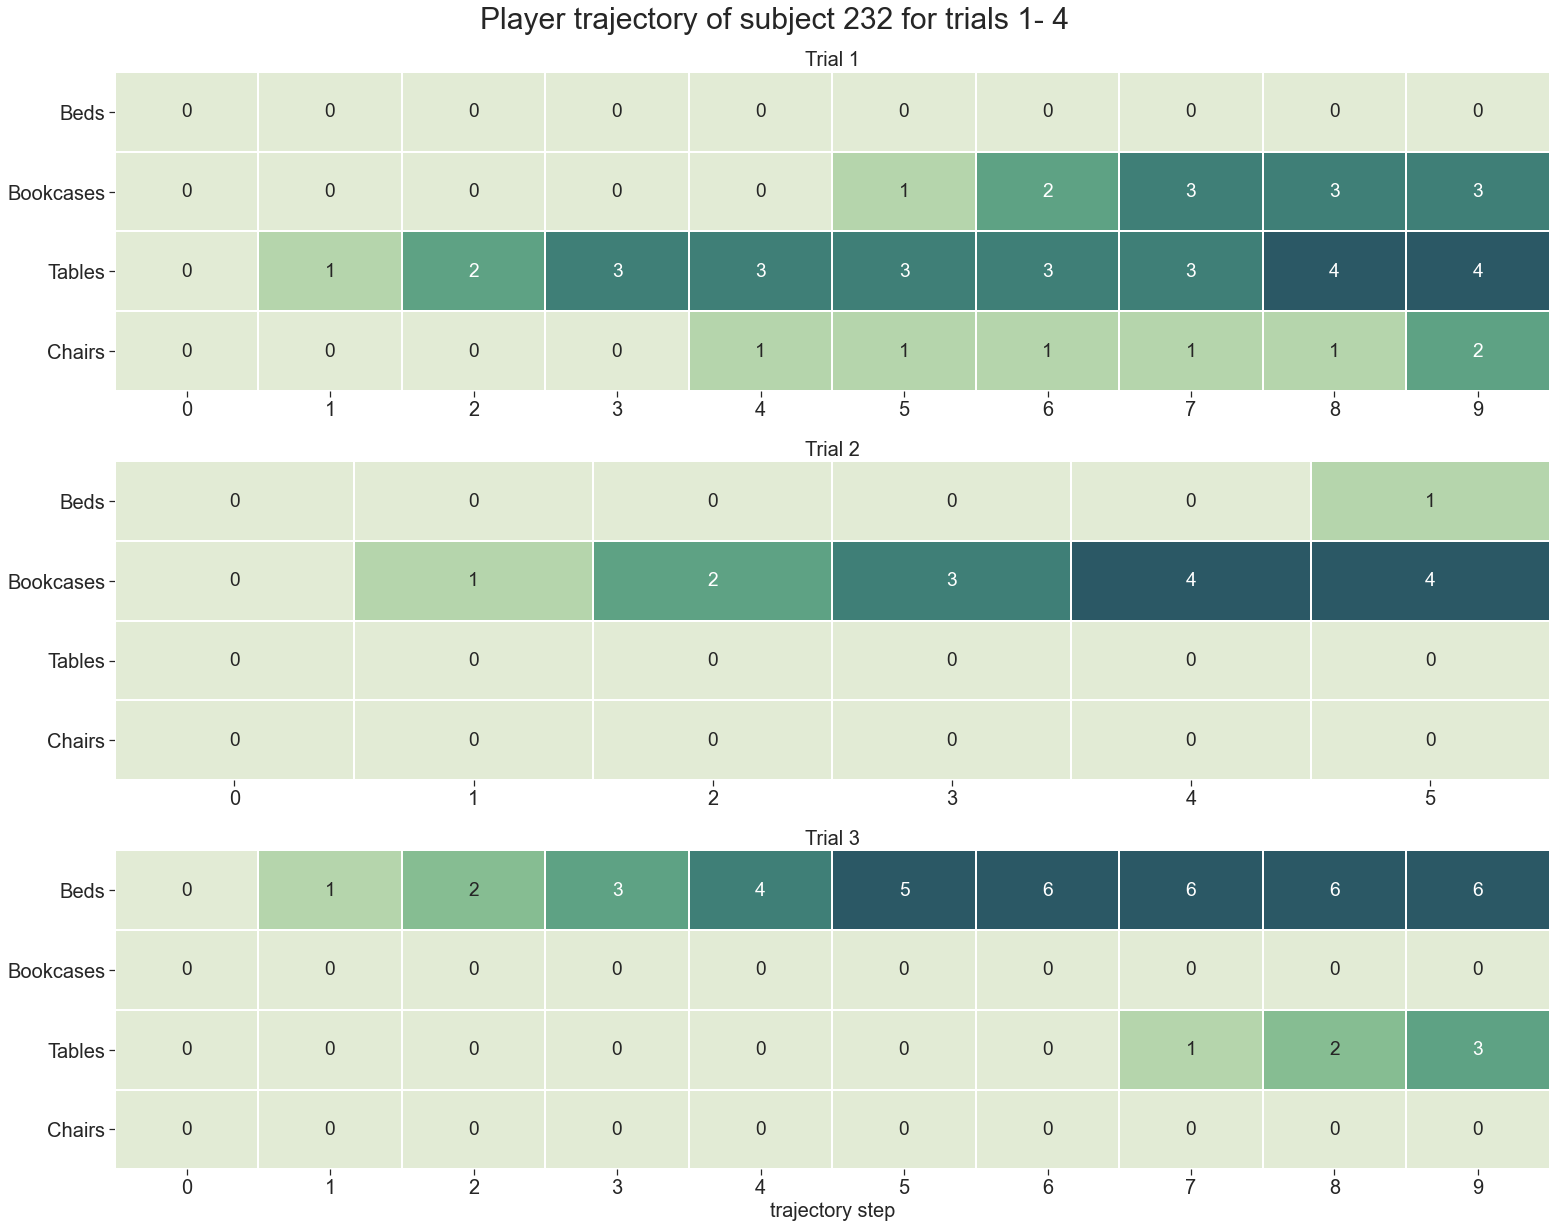

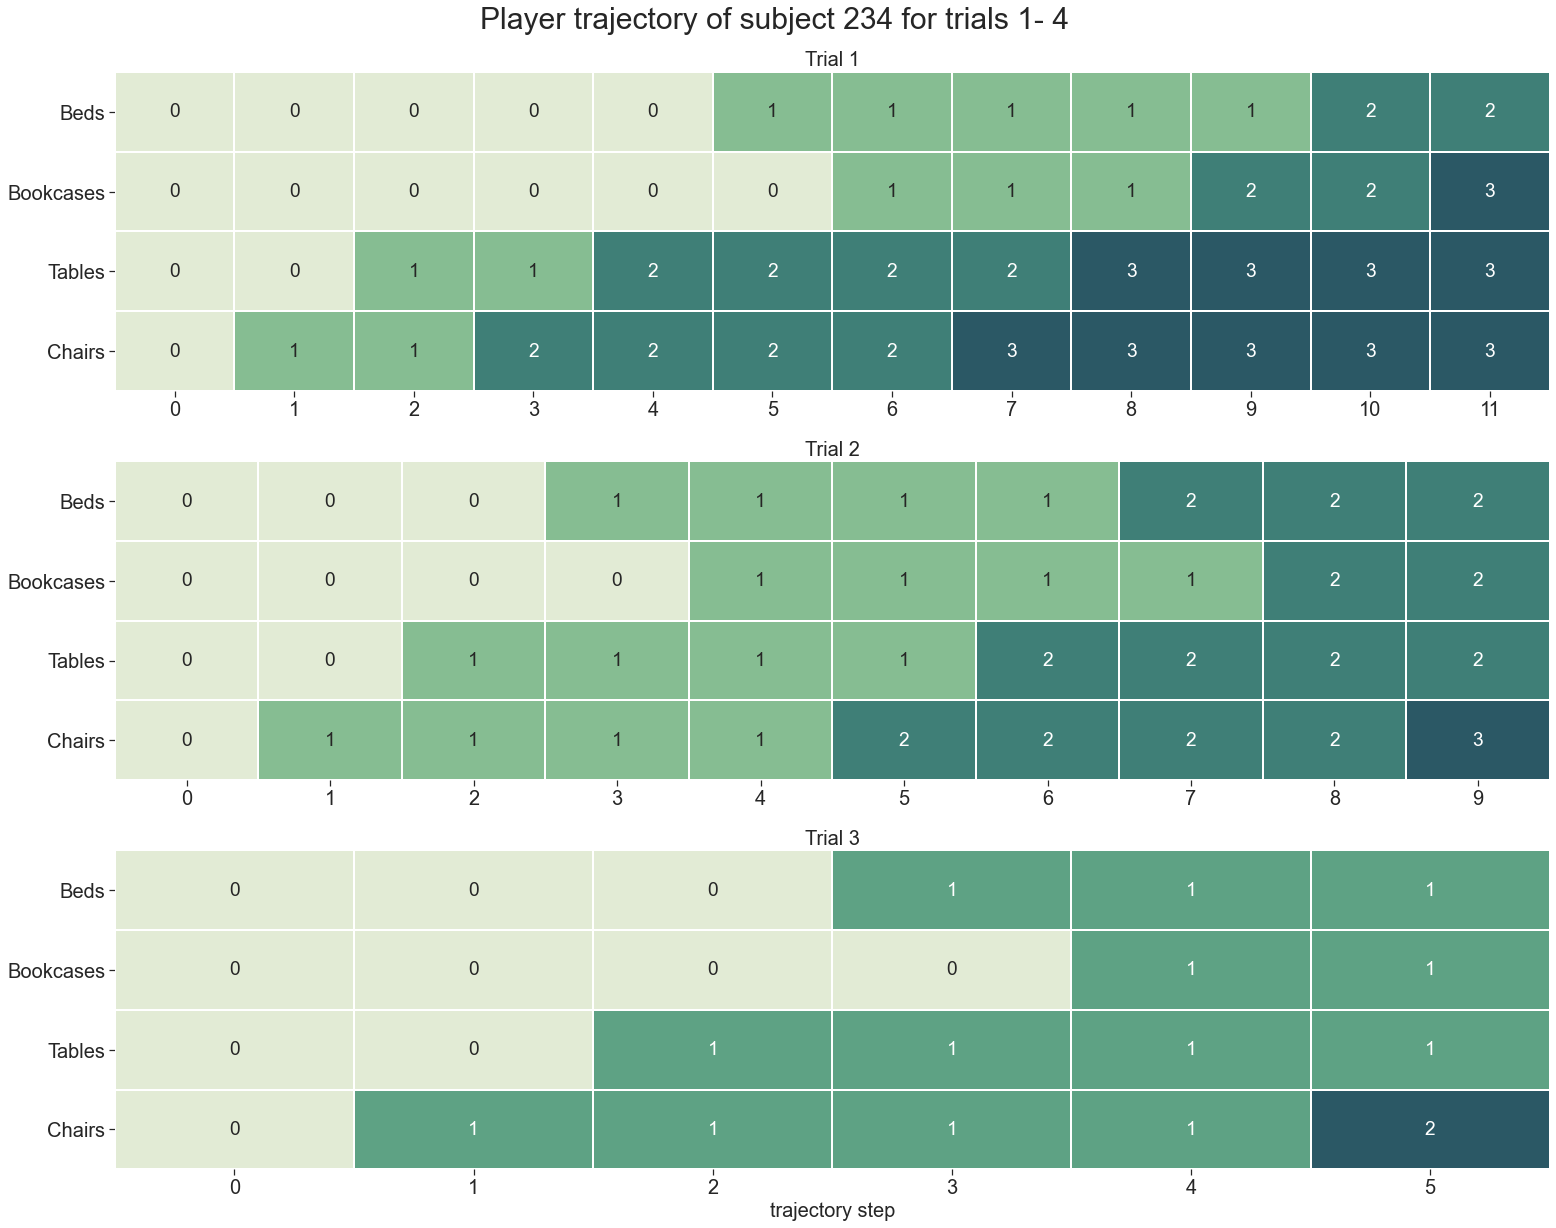

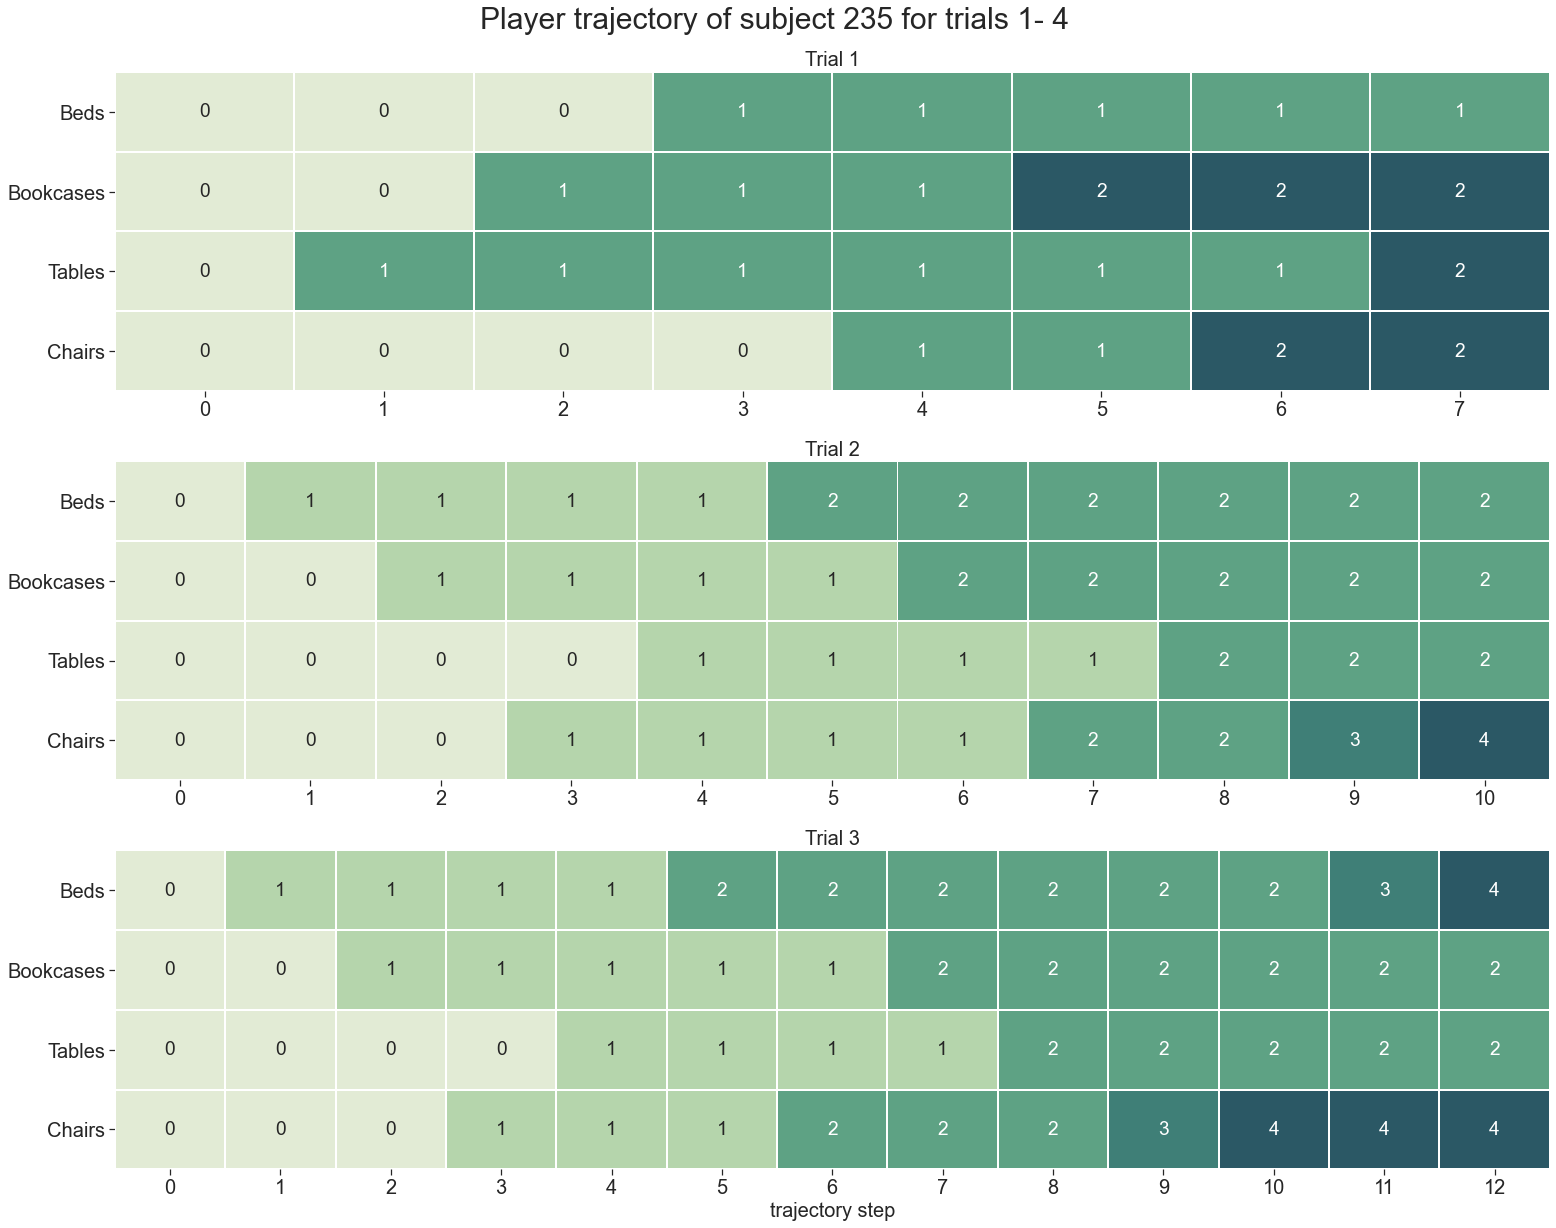

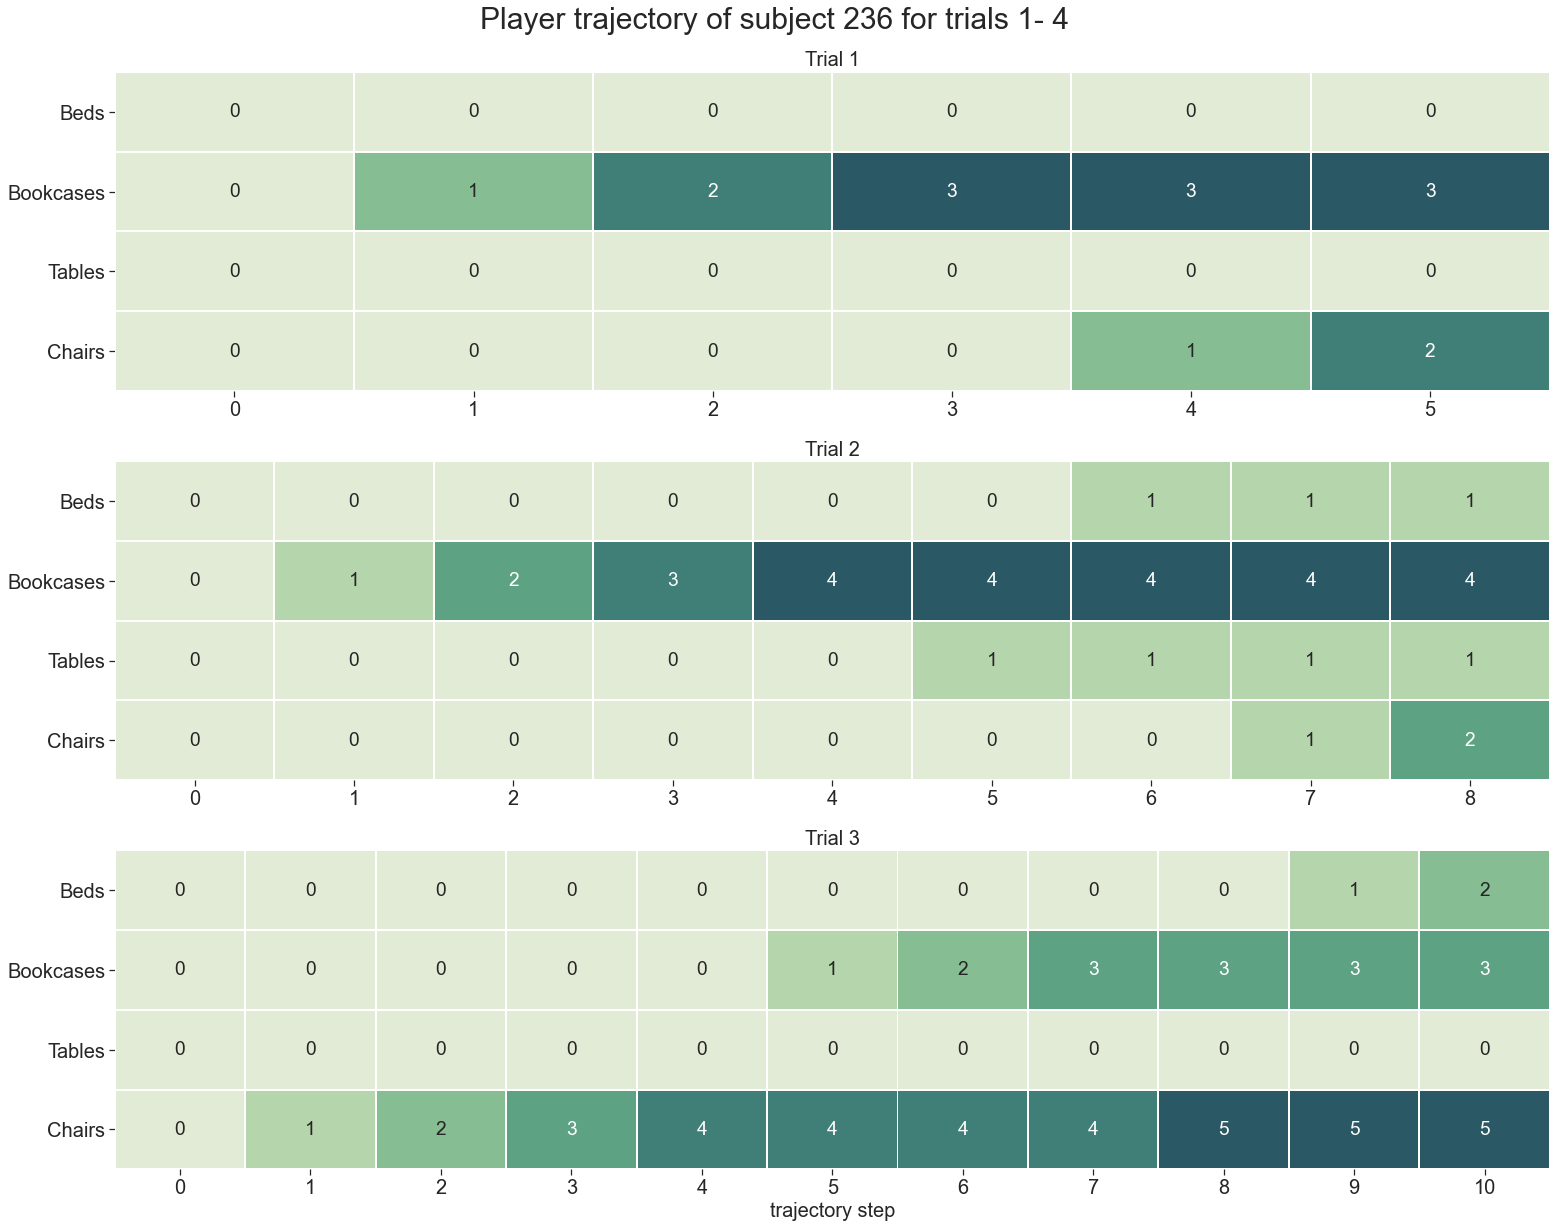

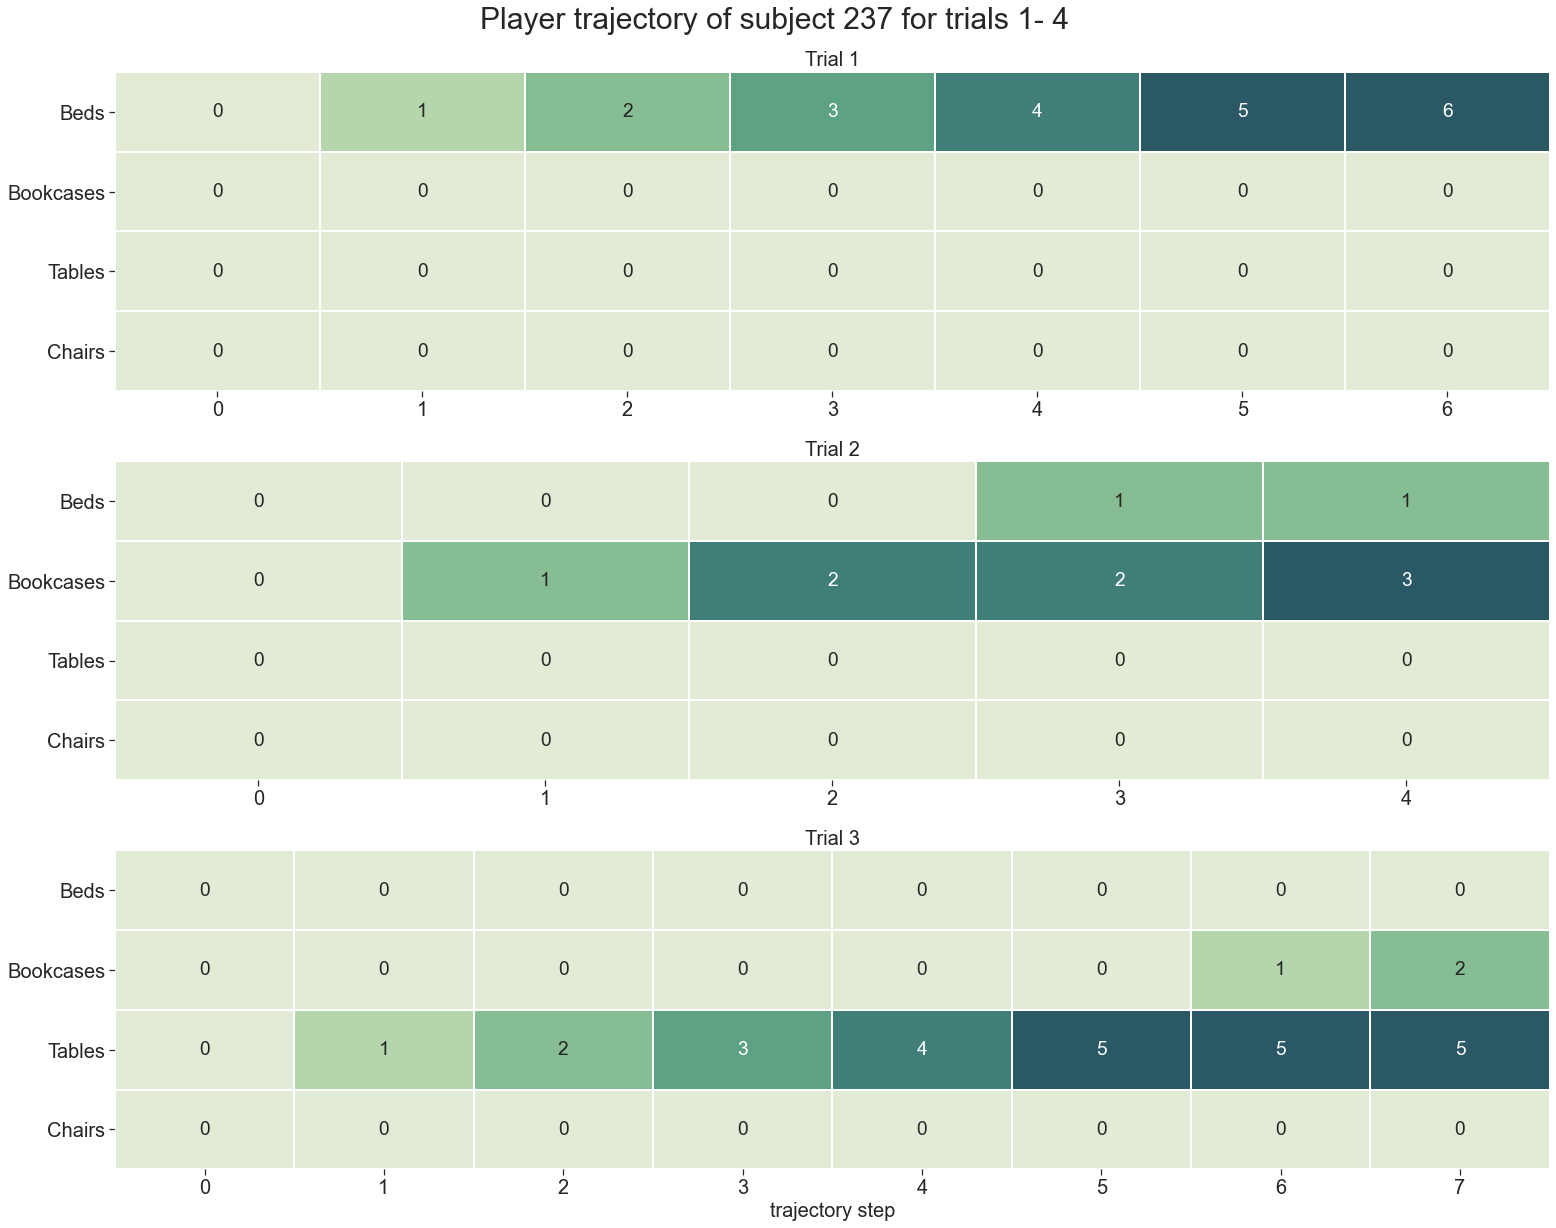

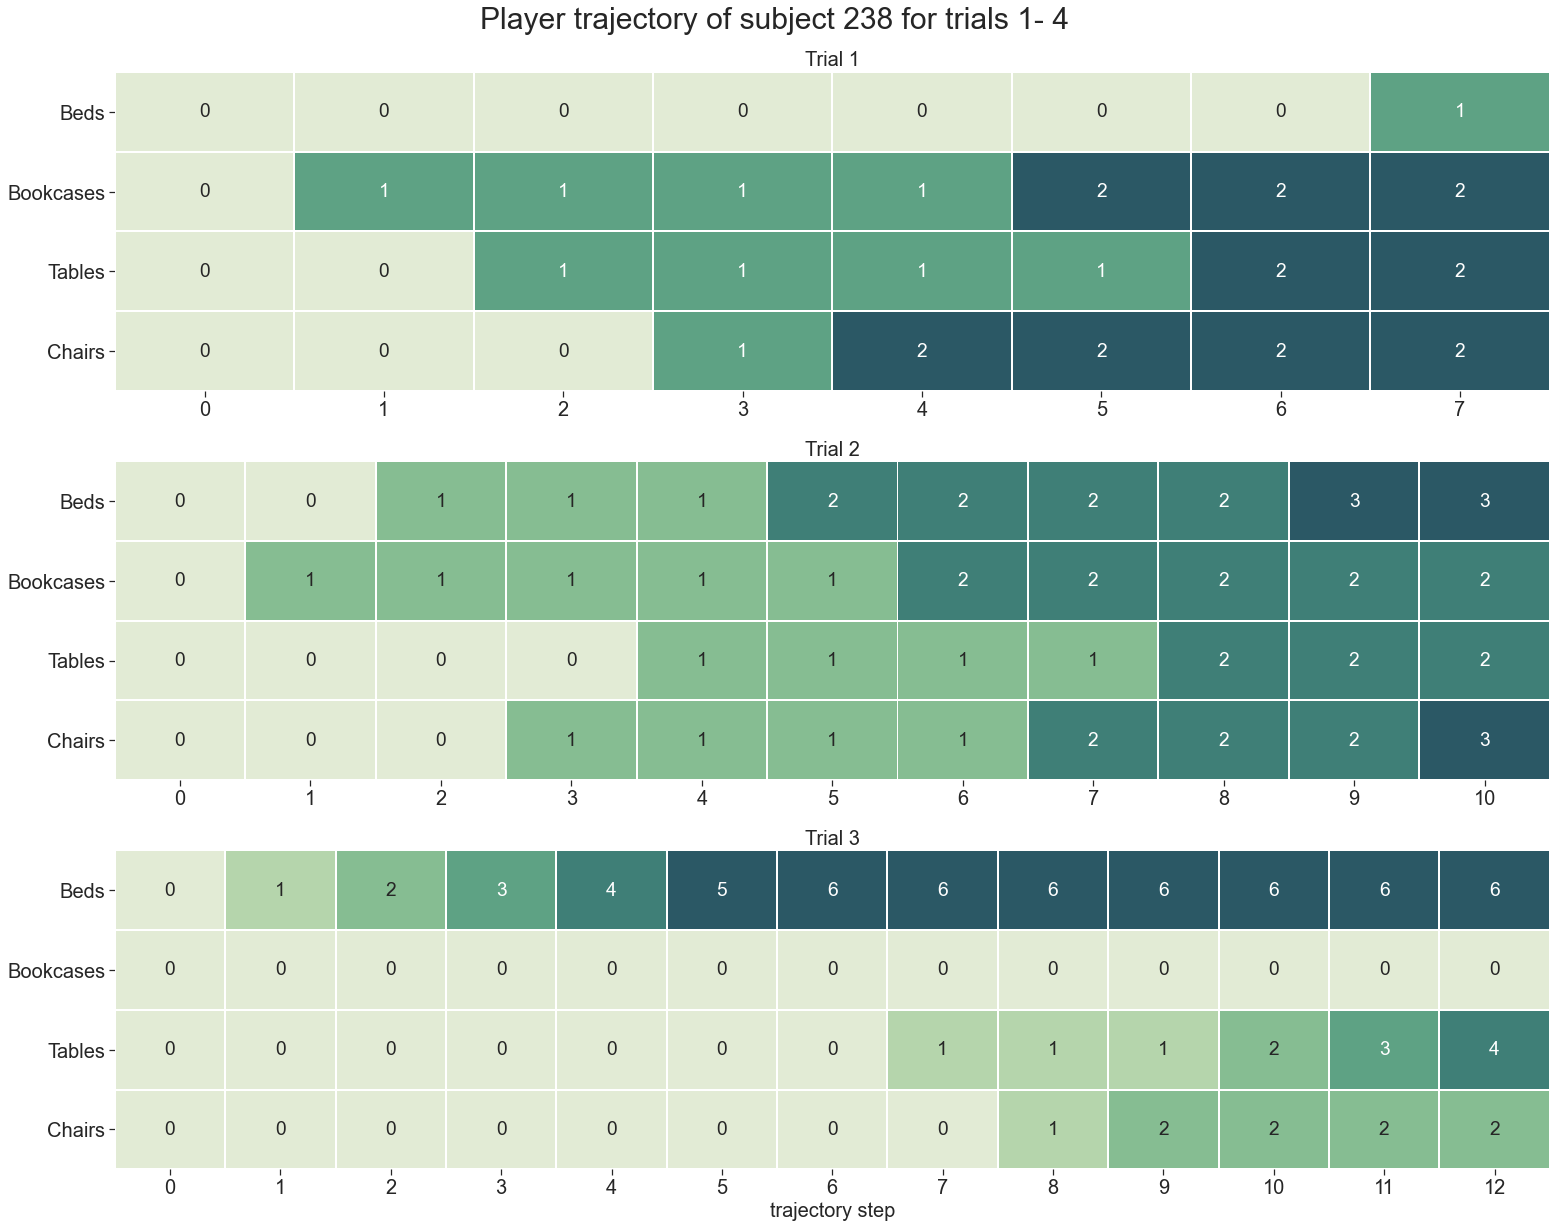

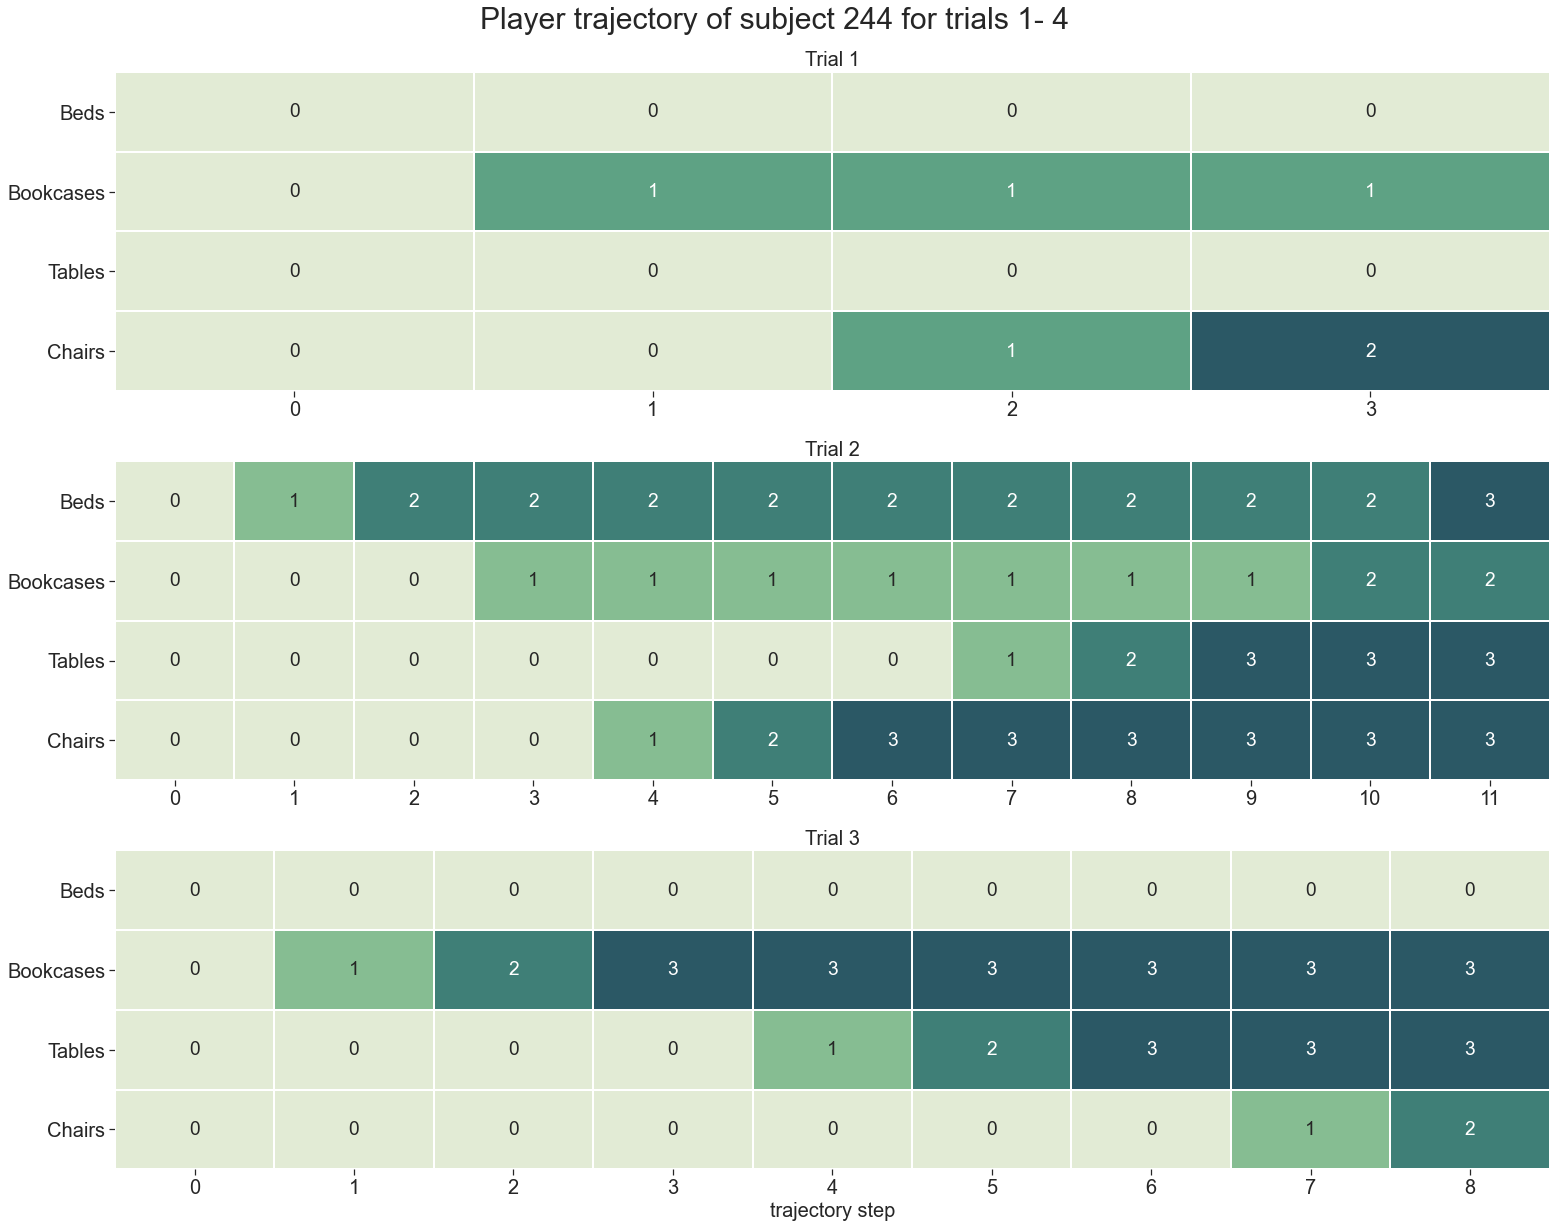

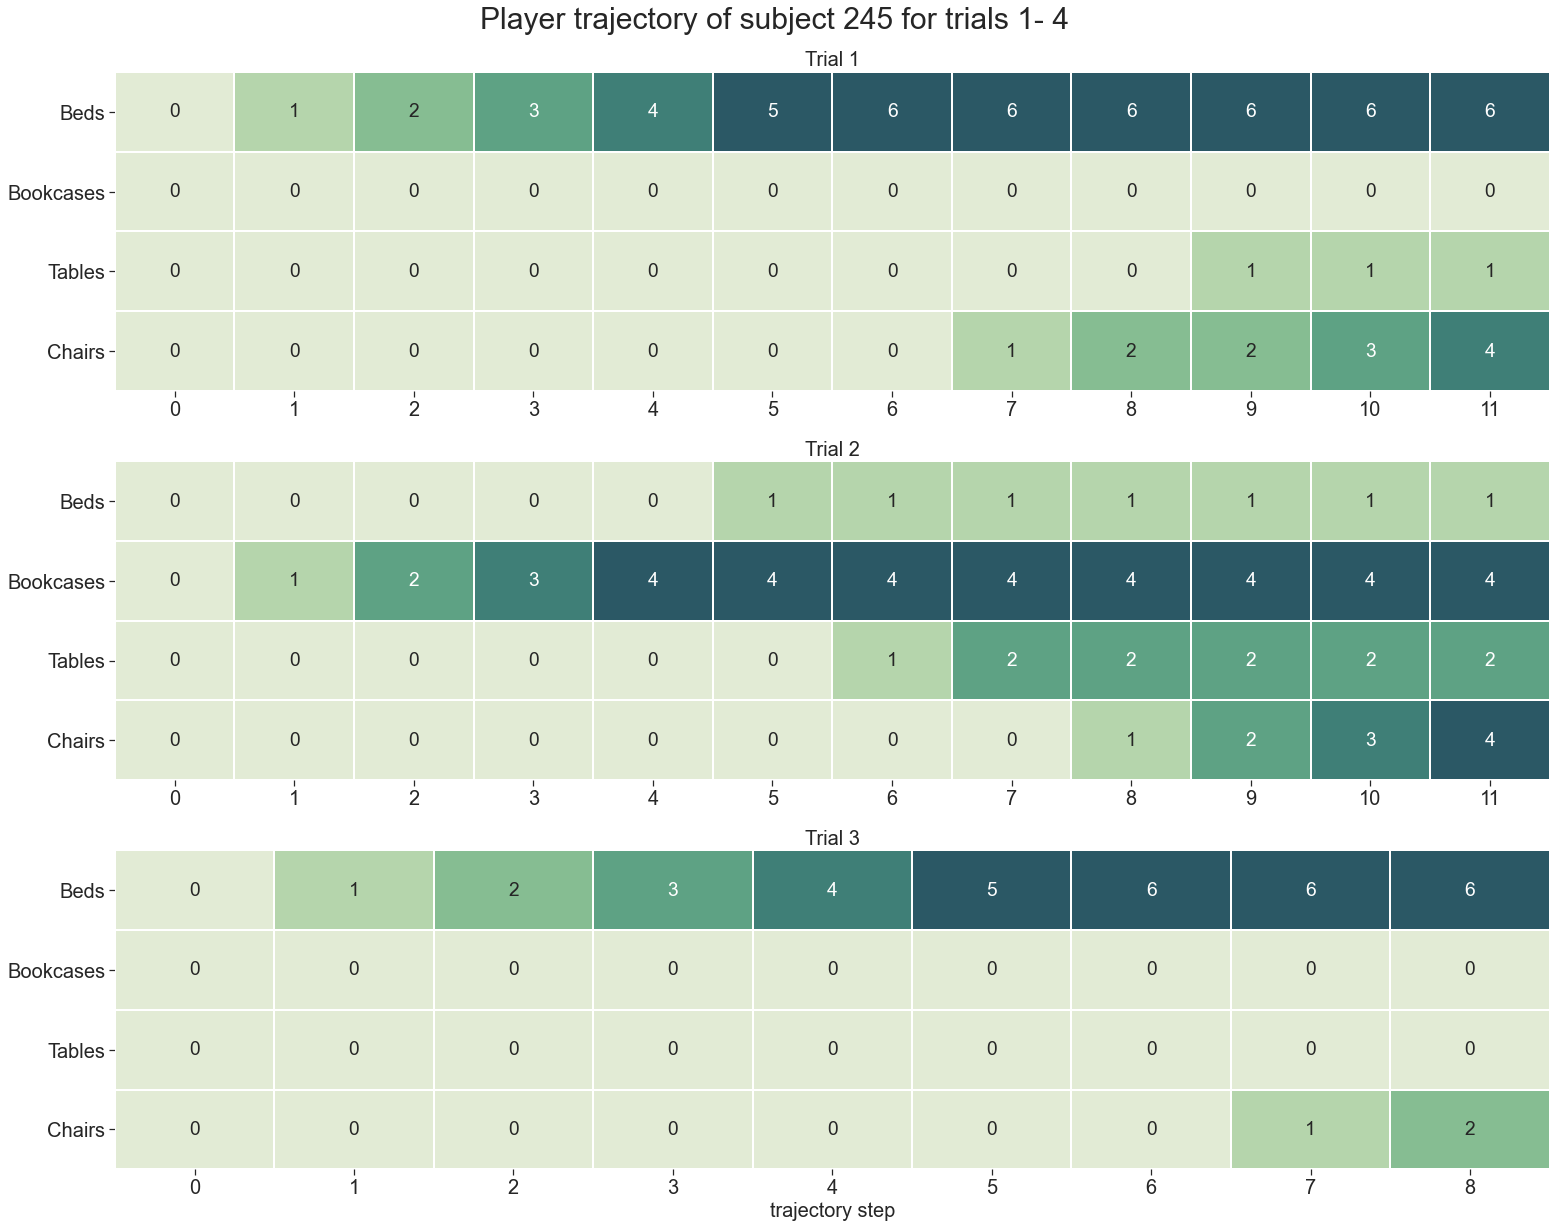

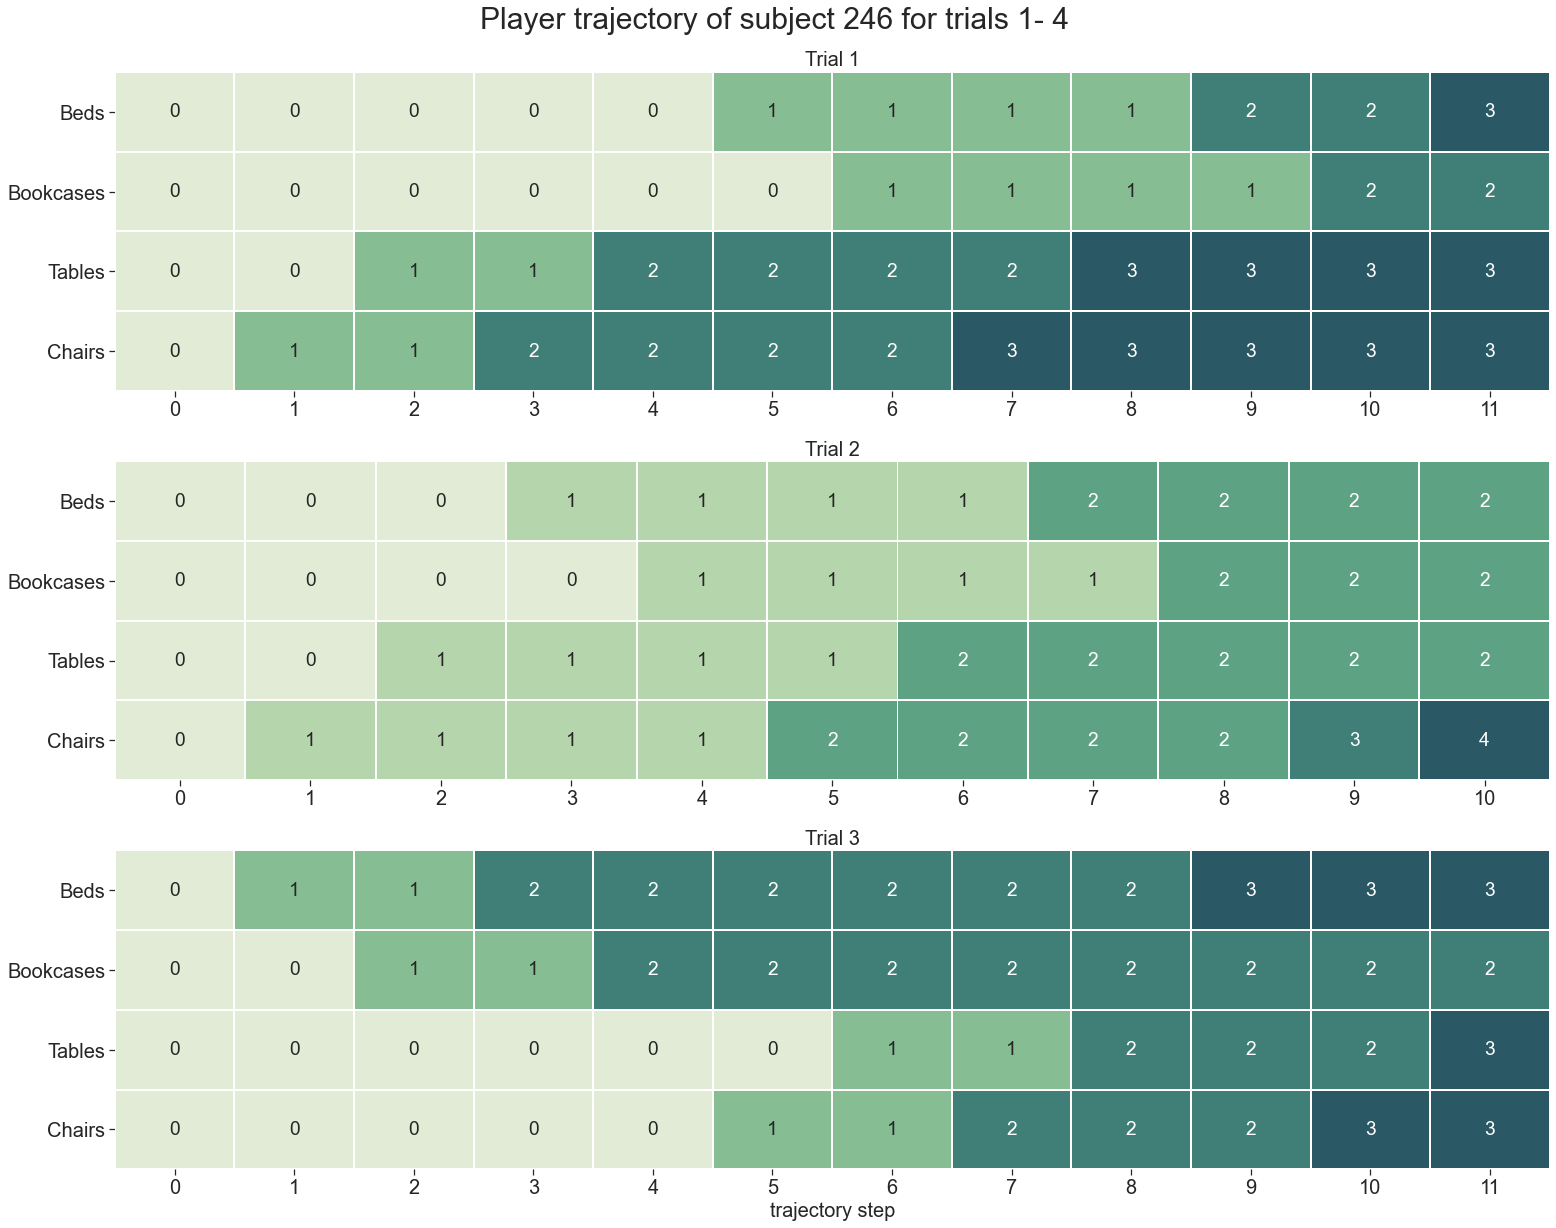

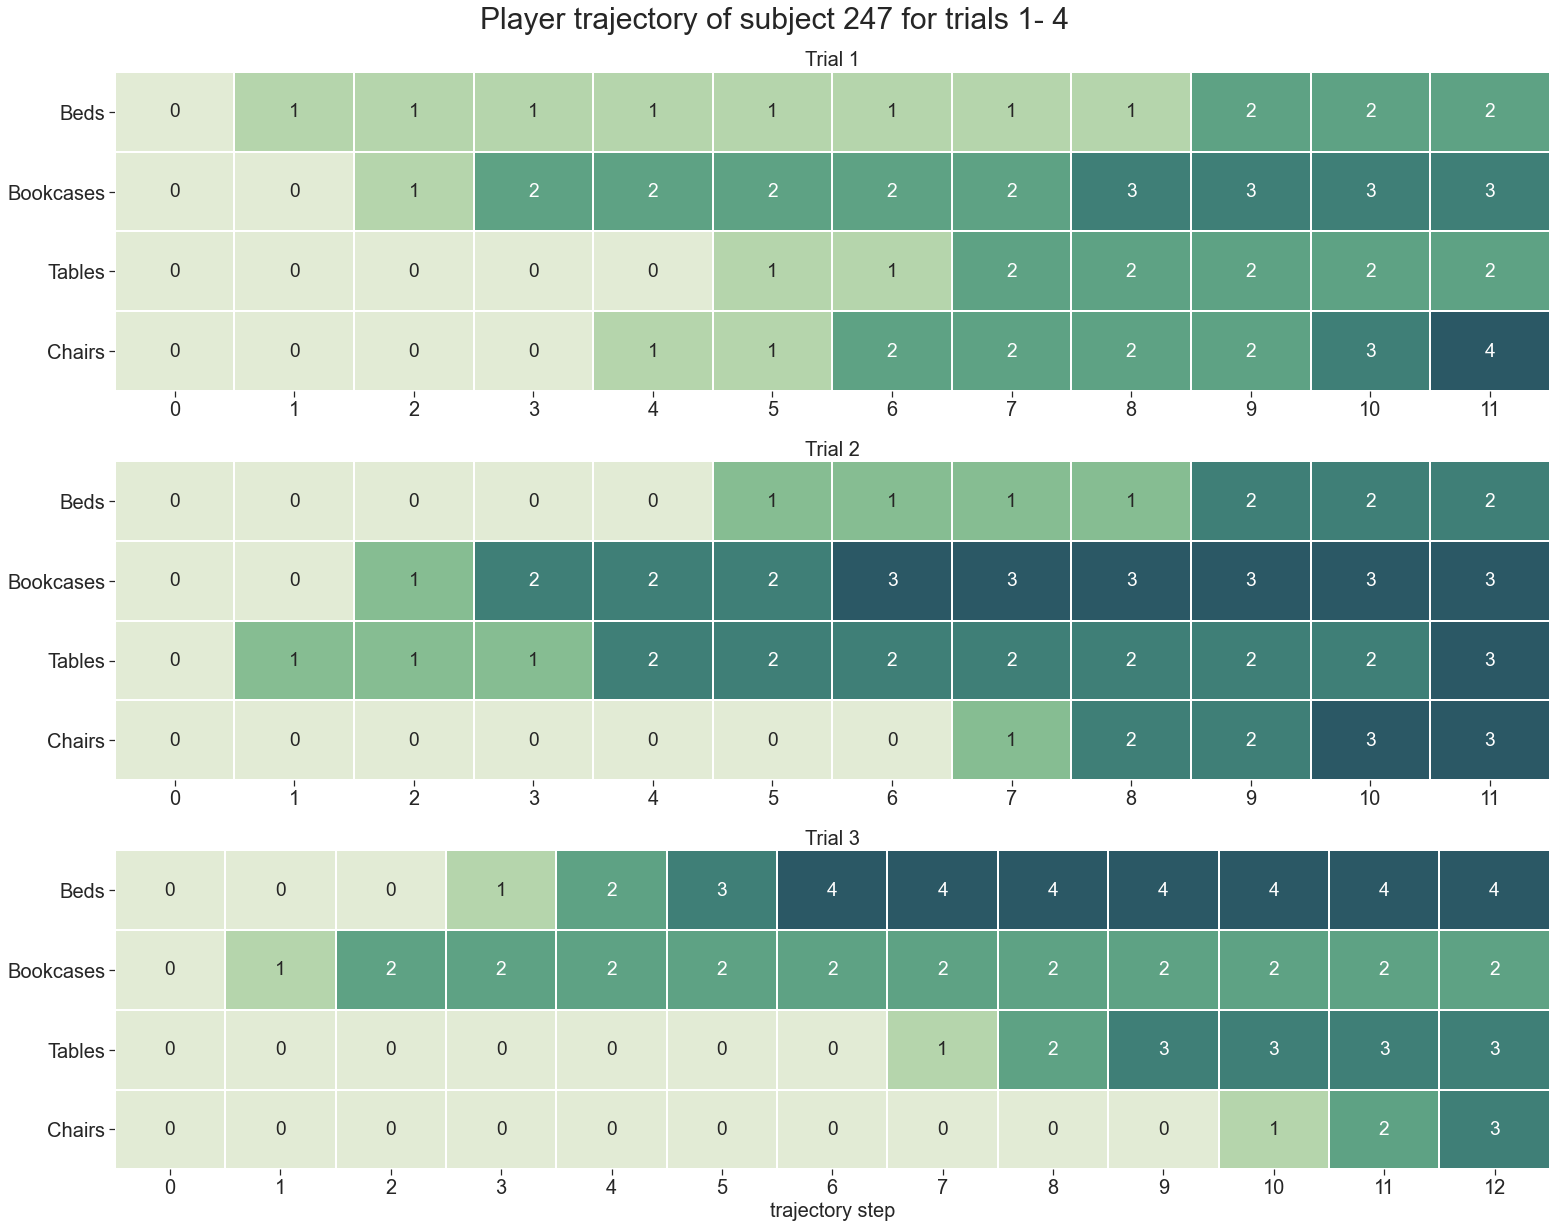

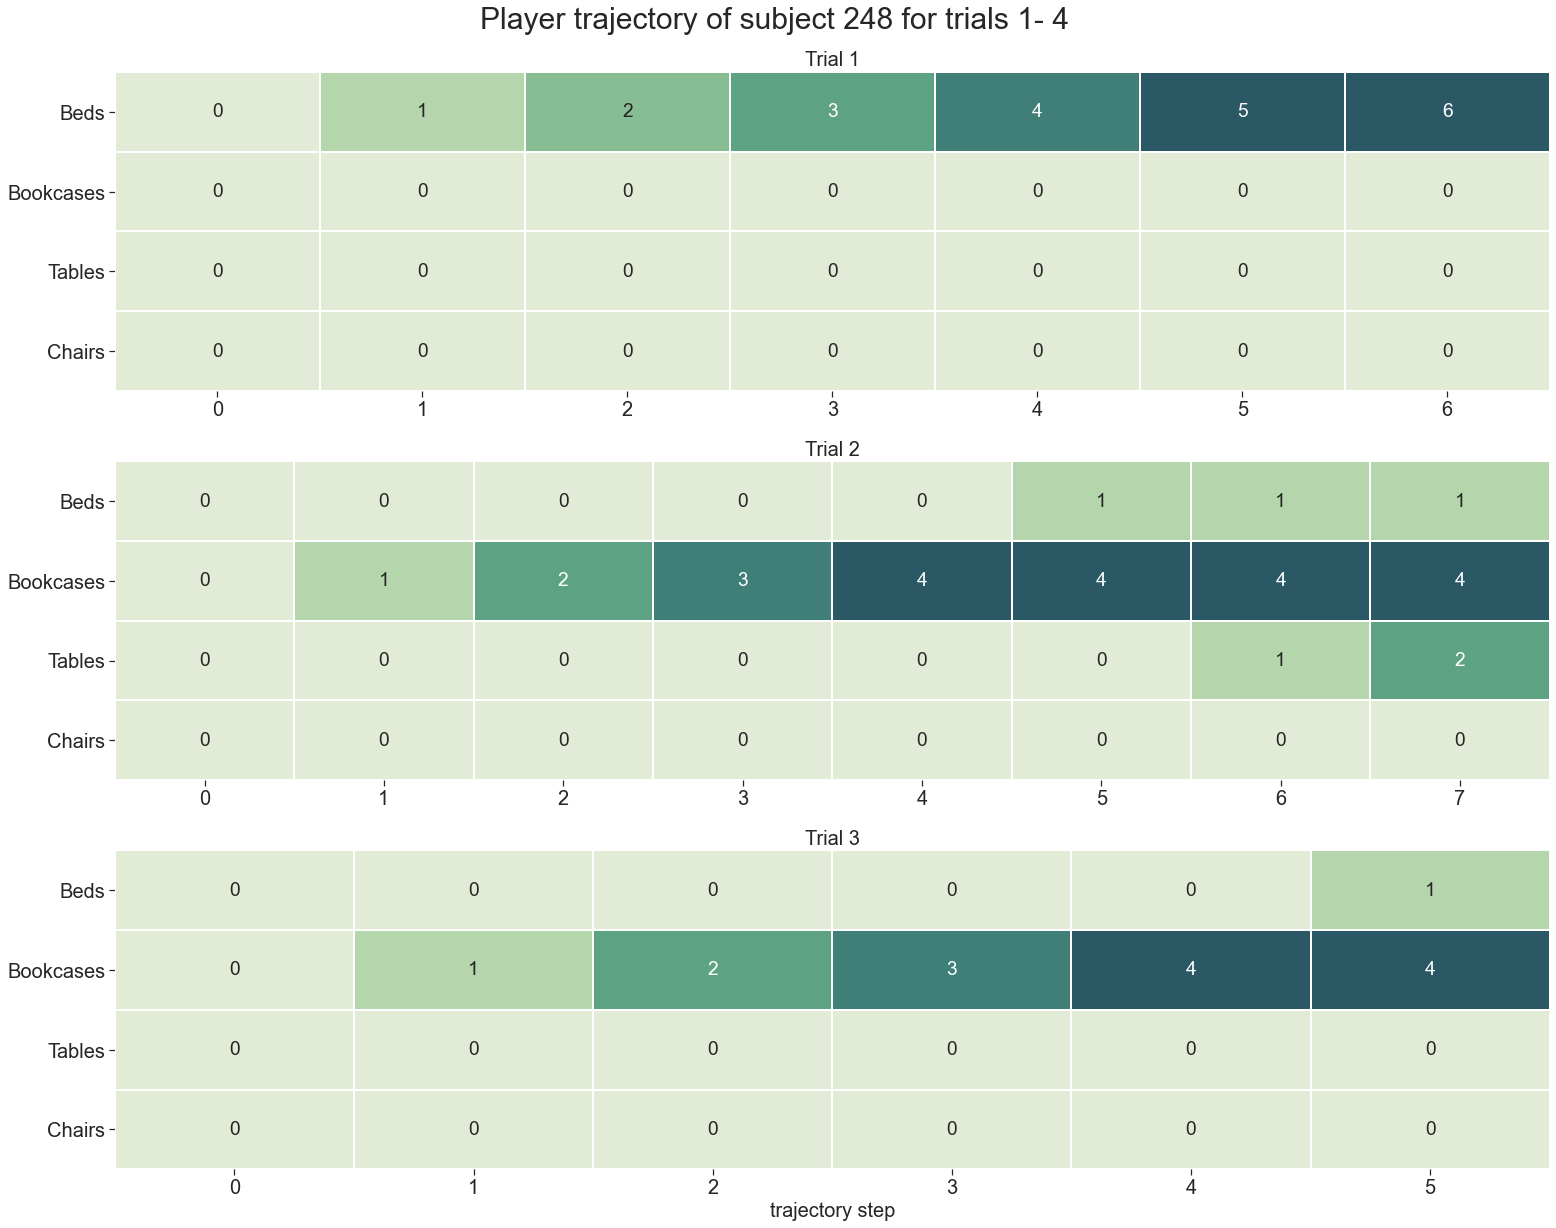

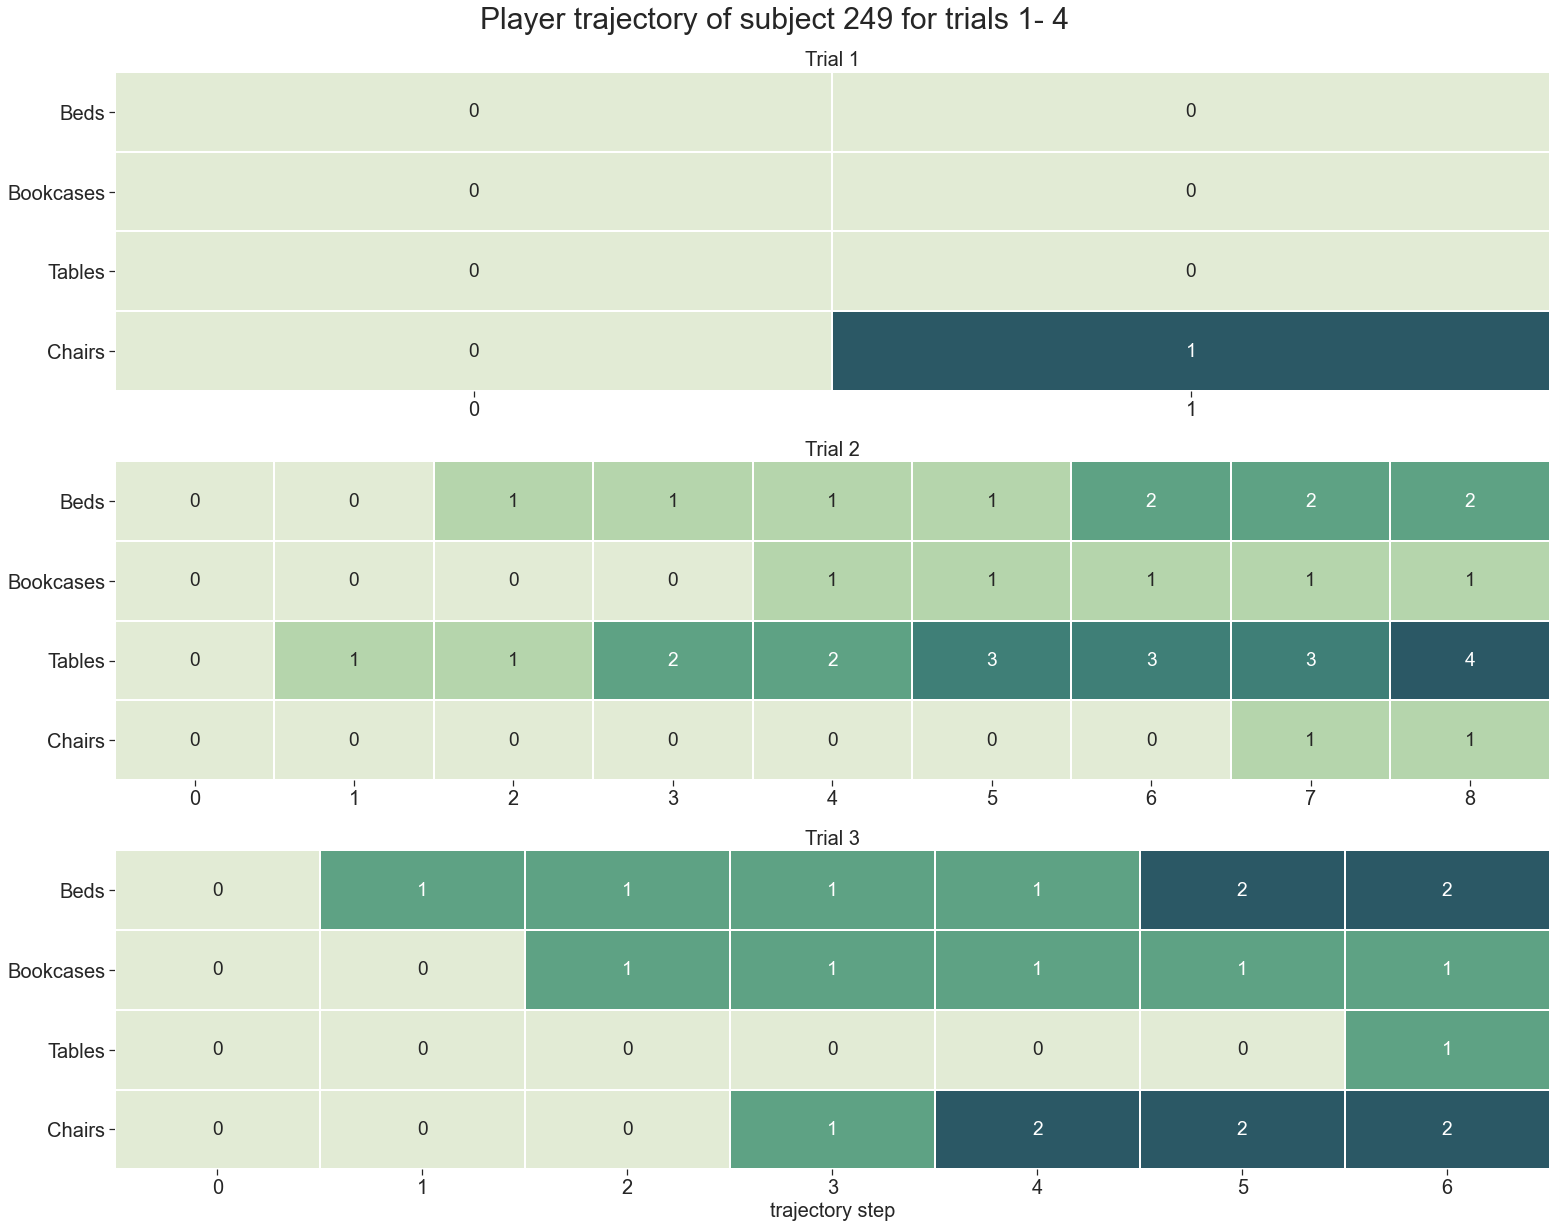

In [14]:

for vp in df_actions.vp.unique()[2:]:
    directory = 'Images/vp_'+str(vp) + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plot_basic_statistics(vp, df_vp_sol, df_play_times)
    plt.close()
    plot_general_actions(vp, df_actions)
    plt.close()
    furniture_overview(vp, df_built)
    plt.close()
    plot_furniture(vp, df_built)
    plt.close()
    plot_furniture_parts(vp, df_built)
    plt.close()
  
    plot_material(vp, df_resources)
    plt.close()
    plot_workshops(vp, df_resources)
    plt.close()
    plot_decision_trajectories(vp, df_solution_paths)
    plt.close()
    